# Pruebas Benchmark

This preprocessing step is important to delete noise, standarize data and guarantee a quality analysis for the single cell RNA sequencing. It involves multiple steps such as quality control (filtering low-quality cells and genes), normalization (adjusting for differences in sequencing depth), feature selection (identifying highly variable genes), dimensionality reduction (using techniques like PCA), and batch effect correction (to remove technical artifacts). These steps prepare the data for clustering, differential expression analysis, and other advanced analyses.

#### Import Libraries and data

In [1]:
!pip install igraph leidenalg louvain 

In [2]:
# pip install scanpy anndata scrublet matplotlib seaborn numpy pandas scipy scikit-learn
# !pip install scrublet os
# !pip install mygene
import mygene
import scanpy as sc
import anndata as ad
import scrublet as scr
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hp
import scipy
import random
import networkx as nx
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from IPython.core.display import display, HTML
import os, json, sys, re
from sklearn.neighbors import NearestNeighbors
# from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, calinski_harabasz_score
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
from tqdm import tqdm
from scipy.stats import pearsonr, normaltest
from itertools import combinations
from sklearn.model_selection import ParameterGrid


C:\Users\henry\AppData\Local\Temp\ipykernel_7536\3051447118.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importin

In [3]:
import warnings
# Suppress the specific FutureWarning and UserWarning
warnings.filterwarnings('ignore', category=FutureWarning, 
                       message="The default value of 'ignore' for the `na_action` parameter")
warnings.filterwarnings('ignore', category=UserWarning, 
                       message="No data for colormapping provided via 'c'")

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log2")

#### Data Load

In [4]:
data_path = "C:/Users/henry/Desktop/python/jbook_rna/datos/Single-cell RNASeq data from Mouse Brain"
data_path2 = "C:/Users/henry/Desktop/python/jbook_rna/datos/Theory - Intro to single-cell RNAseq Images"

In [5]:
glioblastoma_norm_file = os.path.join(data_path, "glioblastoma_normalized.h5ad")
glioblastoma_raw_file = os.path.join(data_path, "glioblastoma_raw.h5ad")
pbmc3k_file = os.path.join(data_path, "pbmc3k.h5ad")

adata_glioblastoma_norm = sc.read_h5ad(glioblastoma_norm_file)
adata_glioblastoma_raw = sc.read_h5ad(glioblastoma_raw_file)
adata_pbmc3k = sc.read_h5ad(pbmc3k_file)

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\anndata\compat\__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\anndata\compat\__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


## **Quality Control (QC)**

Quality control (QC) in scRNA-seq is essential to remove low-quality cells and technical artifacts that could bias downstream analysis. QC typically involves filtering out cells with too few detected genes (indicating possible empty droplets), cells with extremely high gene counts (potentially doublets or multiplets), and cells with a high percentage of mitochondrial gene expression (suggesting damaged or dying cells). These steps help ensure that only high-quality, biologically relevant cells are included in the analysis, improving the accuracy of clustering, differential expression analysis, and biological interpretation.


### Quality control metrics

We use **three key QC metrics**:  

| **Metric**                      | **Issue Detected**                                     | **Filtering Rule** |
|----------------------------------|------------------------------------------------------|----------------------|
| **Total UMI Counts**             | Low = Empty droplets, debris<br>High = Possible doublets | Keep cells with a **moderate range** of UMI counts |
| **Number of Genes per Cell**     | Low = Dead/low-quality cells<br>High = Doublets     | Set **lower/upper cutoffs** based on distribution |
| **Mitochondrial Gene Percentage** | High = Cell stress, apoptosis                      | Remove cells with **too high mito RNA%** |

````{admonition} What is Apoptosis?
:class: tip
Apoptosis is a form of programmed cell death, a tightly regulated process by which cells self-destruct when they are no longer needed or are damaged beyond repair. In the context of genetics and single-cell RNA sequencing (scRNA-seq).

In genetics key genes involved include members of the BCL-2 family (such as BAX, BAK, and BCL2), caspases (like CASP3, CASP8, CASP9), and regulators like TP53 (p53). Mutations or dysregulation in these genes can lead to diseases such as cancer (where apoptosis is suppressed) or degenerative diseases (where apoptosis is excessive).
````

```{admonition} Quality Control (QC) Metrics in scRNA-seq
1️⃣ **Number of Cells Expressing Each Gene (`gene_counts`)**
- Measures how **widely expressed** each gene is across cells.  
- Genes expressed in **very few cells** may be **technical noise**.  
- Helps decide **which genes to keep** in downstream analysis. 

2️⃣ **Number of Detected Genes per Cell (`n_genes_by_cell`)**
- Indicates the **complexity** of RNA content in each cell.  
- **Low values** suggest dead cells or empty droplets.  
- **High values** may indicate doublets (two cells captured together).

3️⃣ **Total UMI Counts per Cell (`total_UMI_counts`)**
- Represents the **sequencing depth** per cell.  
- **Low counts** suggest poor RNA capture or damaged cells.  
- **High counts** can indicate doublets or highly active cells.

🔍 ***These metrics help identify low-quality cells before filtering.***
```

In [6]:
print(adata_glioblastoma_raw)

AnnData object with n_obs × n_vars = 1853 × 7683
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis'


In [7]:
print(f'The data contains the following cells and gene count: \nNumber of cells: {adata_glioblastoma_raw.n_obs}')
print(f'Number of genes: {adata_glioblastoma_raw.n_vars}')

The data contains the following cells and gene count: 
Number of cells: 1853
Number of genes: 7683


In [8]:
sc.pp.calculate_qc_metrics(
    adata_glioblastoma_raw,
    percent_top=[50, 100, 200],   # For top highly variable genes
    inplace=True
)

adata_glioblastoma_raw.obs['total_counts'] = adata_glioblastoma_raw.X.sum(axis=1).astype(int)

#### Gene level metrics

``n_cells_by_counts:`` The number of cells in which a given gene is detected, useful for identifying genes expressed across many cells versus rare or cell-type-specific genes.

``mean_counts:`` The average raw UMI (Unique Molecular Identifier) count per gene across all cells, providing a measure of gene expression levels before normalization.

``log1p_mean_counts:`` The natural logarithm (log1p) transformation of the mean counts, helping to stabilize variance and improve interpretability, especially for highly expressed genes.

``pct_dropout_by_counts:`` The percentage of cells in which a given gene is not detected (dropout rate), useful for identifying highly expressed genes versus those subject to technical dropout.

``total_counts:`` The total number of UMIs per cell, reflecting sequencing depth and cell RNA content, often used for normalization.

``log1p_total_counts:`` The log1p transformation of total counts, reducing skewness in distributions and making comparisons across cells more robust.




In [9]:
print("\nMétricas por gen (adata.var):")
print(adata_glioblastoma_raw.var.columns.tolist())


Métricas por gen (adata.var):
['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']


In [10]:
adata_glioblastoma_raw.var[['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']].head()  # Show first 5 genes


n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                                
ENSG00000000005                  2     0.033459           0.032912   
ENSG00000001561                245    17.581758           2.922180   
ENSG00000001629                715    29.176739           3.407071   
ENSG00000002587               1268    22.115810           3.140517   
ENSG00000002933                548    45.389587           3.837075   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  
index                                                                     
ENSG00000000005              99.892067     62.000000            4.143135  
ENSG00000001561              86.778198  32579.000000           10.391454  
ENSG00000001629              61.413923  54064.496094           10.897951  
ENSG00000002587              31.570426  40980.597656           10.620878  
ENSG00000002933              70.426336  84106.906250           11.339856

#### Cell level metrics

- **`disease_state`**: Indicates the condition of the patient (e.g., healthy or diseased), useful for stratifying samples.  
- **`plate_id`**: Identifies the sequencing batch or plate from which a cell originated, helping to detect batch effects.  
- **`tissue`**: Specifies the tissue source of the sample (e.g., brain, blood), crucial for biological context.  
- **`patient_id`**: Links each cell to a specific patient, allowing for patient-level comparisons.  
- **`cell_type`**: Annotates the inferred cell type, aiding in biological interpretation.  
- **`neoplastic_state`**: Describes whether the cell is classified as neoplastic (tumor) or non-neoplastic, critical for cancer studies.  
- **`diagnosis`**: The clinical diagnosis associated with the sample, relevant for disease-specific analysis.  
- **`n_genes_by_counts`**: Number of genes detected per cell, a key metric in quality control to filter out low-complexity cells.  
- **`log1p_n_genes_by_counts`**: Log1p-transformed `n_genes_by_counts`, stabilizing variance for better interpretation.  
- **`total_counts`**: Total number of UMIs per cell, reflecting sequencing depth and cell RNA content.  
- **`log1p_total_counts`**: Log1p-transformed `total_counts`, reducing skewness in data distribution.  
- **`pct_counts_in_top_50_genes`**: Percentage of total counts coming from the 50 most highly expressed genes, used to check for dominance of specific genes.  
- **`pct_counts_in_top_100_genes`**: Same as above, but for the top 100 genes.  
- **`pct_counts_in_top_200_genes`**: Same as above, but for the top 200 genes, helping to assess gene expression concentration.  


In [11]:
print("Métricas por célula (adata.obs):")
print(adata_glioblastoma_raw.obs.columns.tolist())  

Métricas por célula (adata.obs):
['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']


In [12]:
adata_glioblastoma_raw.obs[['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']].head(20) 

disease_state              plate_id         tissue  \
index                                                                      
GSM2243439  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243444  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243445  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243447  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243452  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243455  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243456  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243457  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243459  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243460  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243464  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243465  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243466  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243467  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243468  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243469  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243470  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243471  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243472  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243473  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   

                   patient_id                   cell_type  \
index                                                       
GSM2243439  patient id: BT_S2       cell type: Neoplastic   
GSM2243444  patient id: BT_S2       cell type: Neoplastic   
GSM2243445  patient id: BT_S2       cell type: Neoplastic   
GSM2243447  patient id: BT_S2       cell type: Neoplastic   
GSM2243452  patient id: BT_S2       cell type: Neoplastic   
GSM2243455  patient id: BT_S2  cell type: Oligodendrocyte   
GSM2243456  patient id: BT_S2       cell type: Neoplastic   
GSM2243457  patient id: BT_S2       cell type: Neoplastic   
GSM2243459  patient id: BT_S2       cell type: Neoplastic   
GSM2243460  patient id: BT_S2       cell type: Neoplastic   
GSM2243464  patient id: BT_S2       cell type: Neoplastic   
GSM2243465  patient id: BT_S2       cell type: Neoplastic   
GSM2243466  patient id: BT_S2       cell type: Neoplastic   
GSM2243467  patient id: BT_S2       cell type: Neoplastic   
GSM2243468  patient id: BT_S2       cell type: Neoplastic   
GSM2243469  patient id: BT_S2       cell type: Neoplastic   
GSM2243470  patient id: BT_S2       cell type: Neoplastic   
GSM2243471  patient id: BT_S2       cell type: Neoplastic   
GSM2243472  patient id: BT_S2       cell type: Neoplastic   
GSM2243473  patient id: BT_S2       cell type: Neoplastic   

                  neoplastic_state        diagnosis  n_genes_by_counts  \
index                                                                    
GSM2243439  neoplastic: Neoplastic       Neoplastic               1341   
GSM2243444  neoplastic: Neoplastic       Neoplastic               1456   
GSM2243445  neoplastic: Neoplastic       Neoplastic               1849   
GSM2243447  neoplastic: Neoplastic       Neoplastic                100   
GSM2243452  neoplastic: Neoplastic       Neoplastic               1788   
GSM2243455     neoplastic: Regular  Oligodendrocyte               2377   
GSM2243456  neoplastic: Neoplastic       Neoplastic               1193   
GSM2243457  neoplastic: Neoplastic       Neoplastic               1823   
GSM2243459  neoplastic: Neoplastic       Neoplastic               1832   
GSM2243460  neoplastic: Neoplastic       Neoplastic               1160   
GSM2243464  neoplastic: Neoplastic       Neoplastic               1869   
GSM2243465  neoplastic: Neoplastic       Neo

#### Summary statistics

The histogram shows the distribution of the number of detected genes per cell. The distribution appears approximately normal but slightly right-skewed, with most cells having between 500 and 2000 detected genes. The density curve suggests a peak around 1200 genes per cell, indicating that this is the most common range. There is a long right tail, meaning some cells have significantly higher gene counts, which may correspond to doublets or highly transcriptionally active cells. 

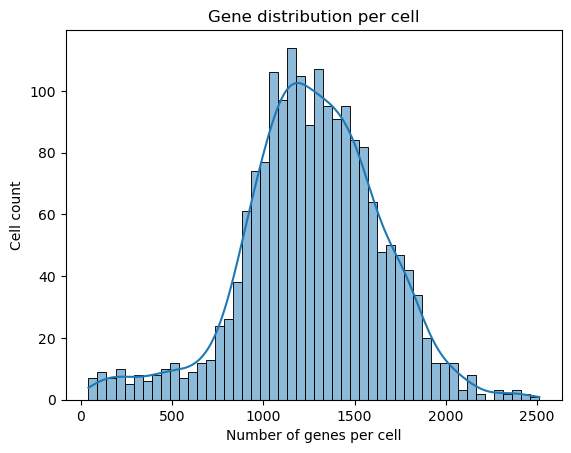

In [13]:
# Plot histogram of number of genes per cell
sns.histplot(adata_glioblastoma_raw.obs['n_genes_by_counts'], bins=50, kde=True)
plt.xlabel('Number of genes per cell')
plt.ylabel('Cell count')
plt.title('Gene distribution per cell')
plt.show()

### 🧬 Unique Molecular Identifiers (UMIs)

```{admonition} What is a UMI?
A **Unique Molecular Identifier (UMI)** is a short **random barcode** added to RNA molecules before sequencing.  
UMIs help correct for **PCR amplification bias** and improve the accuracy of gene expression quantification in single-cell RNA sequencing (**scRNA-seq**).
```

####  Why Are UMIs Important?
1️⃣ **Reduce PCR Bias** → Prevents artificially inflated gene expression caused by PCR duplicates.  
2️⃣ **Improve Quantification** → Counts only **unique UMIs**, not sequencing reads, for accurate expression levels.  
3️⃣ **Remove Technical Noise** → Helps correct sequencing errors and distinguish true biological signals.  

####  How Are UMIs Used in scRNA-seq?
- **Low UMI counts** → Suggests low RNA content, dead cells, or empty droplets.  
- **High UMI counts** → Could indicate doublets (two cells captured together).  
- **UMI filtering** ensures that only high-quality data is used in downstream analysis.  

 **UMIs improve scRNA-seq accuracy by eliminating technical biases.** 


In the histogram of total Unique Molecular Identifiers per cell, we can see that there is an skewness to the rigth and that the mean and median are not distant 

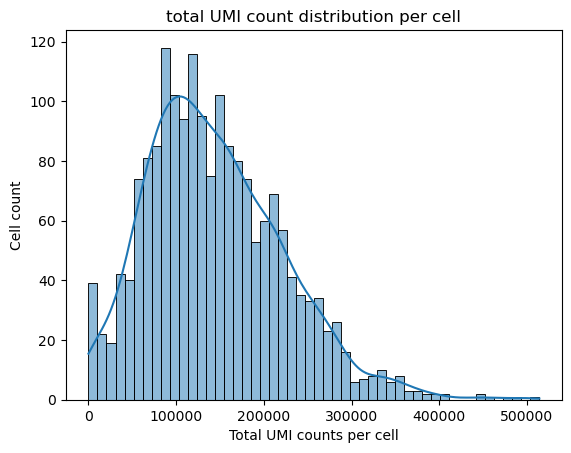

In [14]:
# Plot histogram of total UMI counts per cell
sns.histplot(adata_glioblastoma_raw.obs['total_counts'], bins = 50, kde=True)
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Cell count')
plt.title('total UMI count distribution per cell')
plt.show()

The distribution of the data, as visualized in the violin plot, shows a unimodal pattern with the majority of gene counts per cell concentrated around the middle range, approximately between 500 and 1500. The density decreases symmetrically as the values move toward the extremes, with fewer cells having very low or very high gene counts.

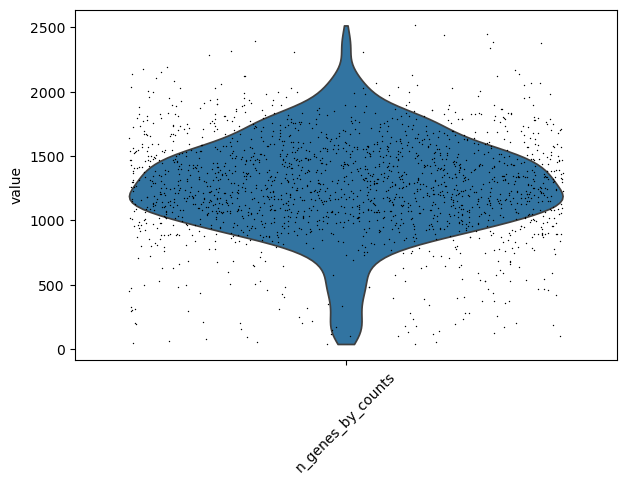

In [15]:
# Violin plot for gene counts per cell
sc.pl.violin(adata_glioblastoma_raw, keys='n_genes_by_counts', jitter=0.4, rotation=45)

In [16]:
# Print a sample of gene names to manually inspect for mitochondrial genes
print(adata_glioblastoma_raw.var_names.to_list()[:7683])  # Show first 7683 gene names

['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG000000

#### Gene list

In [17]:
mg = mygene.MyGeneInfo()
ensembl_ids = ['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG00000013392', 'ENSG00000013503', 'ENSG00000013523', 'ENSG00000013583', 'ENSG00000013588', 'ENSG00000014123', 'ENSG00000014138', 'ENSG00000014164', 'ENSG00000015413', 'ENSG00000015479', 'ENSG00000015532', 'ENSG00000016602', 'ENSG00000019186', 'ENSG00000019505', 'ENSG00000019549', 'ENSG00000019995', 'ENSG00000022556', 'ENSG00000022567', 'ENSG00000023191', 'ENSG00000023318', 'ENSG00000023516', 'ENSG00000023572', 'ENSG00000023608', 'ENSG00000023909', 'ENSG00000025772', 'ENSG00000027001', 'ENSG00000027644', 'ENSG00000028839', 'ENSG00000029559', 'ENSG00000031691', 'ENSG00000033050', 'ENSG00000034053', 'ENSG00000034510', 'ENSG00000034713', 'ENSG00000035141', 'ENSG00000035681', 'ENSG00000035687', 'ENSG00000035720', 'ENSG00000036448', 'ENSG00000036473', 'ENSG00000036530', 'ENSG00000037042', 'ENSG00000037241', 'ENSG00000037965', 'ENSG00000038002', 'ENSG00000038210', 'ENSG00000038295', 'ENSG00000039139', 'ENSG00000039987', 'ENSG00000041353', 'ENSG00000042813', 'ENSG00000043039', 'ENSG00000043591', 'ENSG00000044012', 'ENSG00000044090', 'ENSG00000044574', 'ENSG00000046774', 'ENSG00000047597', 'ENSG00000047662', 'ENSG00000048405', 'ENSG00000048544', 'ENSG00000049249', 'ENSG00000049449', 'ENSG00000049656', 'ENSG00000050344', 'ENSG00000051382', 'ENSG00000051596', 'ENSG00000052850', 'ENSG00000053328', 'ENSG00000053372', 'ENSG00000053438', 'ENSG00000053918', 'ENSG00000054282', 'ENSG00000054392', 'ENSG00000054598', 'ENSG00000054803', 'ENSG00000055813', 'ENSG00000056050', 'ENSG00000056736', 'ENSG00000057468', 'ENSG00000057757', 'ENSG00000058056', 'ENSG00000058262', 'ENSG00000059573', 'ENSG00000059588', 'ENSG00000059758', 'ENSG00000060069', 'ENSG00000060140', 'ENSG00000060558', 'ENSG00000061656', 'ENSG00000061936', 'ENSG00000062725', 'ENSG00000063180', 'ENSG00000063241', 'ENSG00000063515', 'ENSG00000063660', 'ENSG00000064195', 'ENSG00000064199', 'ENSG00000064218', 'ENSG00000064300', 'ENSG00000064726', 'ENSG00000064932', 'ENSG00000065057', 'ENSG00000065308', 'ENSG00000065320', 'ENSG00000065491', 'ENSG00000065518', 'ENSG00000065833', 'ENSG00000065923', 'ENSG00000065970', 'ENSG00000066230', 'ENSG00000066379', 'ENSG00000066422', 'ENSG00000066557', 'ENSG00000066777', 'ENSG00000067167', 'ENSG00000067182', 'ENSG00000067248', 'ENSG00000067533', 'ENSG00000067704', 'ENSG00000067900', 'ENSG00000068079', 'ENSG00000068697', 'ENSG00000068985', 'ENSG00000069482', 'ENSG00000069509', 'ENSG00000069696', 'ENSG00000069764', 'ENSG00000069943', 'ENSG00000070018', 'ENSG00000070019', 'ENSG00000070031', 'ENSG00000070047', 'ENSG00000070193', 'ENSG00000070404', 'ENSG00000070601', 'ENSG00000070761', 'ENSG00000070770', 'ENSG00000070915', 'ENSG00000070950', 'ENSG00000071203', 'ENSG00000071677', 'ENSG00000071991', 'ENSG00000072315', 'ENSG00000072415', 'ENSG00000072657', 'ENSG00000072864', 'ENSG00000072954', 'ENSG00000072958', 'ENSG00000073598', 'ENSG00000073734', 'ENSG00000073754', 'ENSG00000073861', 'ENSG00000073969', 'ENSG00000074181', 'ENSG00000074201', 'ENSG00000074695', 'ENSG00000074771', 'ENSG00000074842', 'ENSG00000075035', 'ENSG00000075043', 'ENSG00000075089', 'ENSG00000075131', 'ENSG00000075188', 'ENSG00000075290', 'ENSG00000075388', 'ENSG00000075429', 'ENSG00000075461', 'ENSG00000075643', 'ENSG00000076003', 'ENSG00000076043', 'ENSG00000076258', 'ENSG00000076356', 'ENSG00000076641', 'ENSG00000076650', 'ENSG00000076662', 'ENSG00000076716', 'ENSG00000076826', 'ENSG00000077080', 'ENSG00000077152', 'ENSG00000077274', 'ENSG00000077312', 'ENSG00000077348', 'ENSG00000077498', 'ENSG00000077514', 'ENSG00000077943', 'ENSG00000077984', 'ENSG00000078081', 'ENSG00000078237', 'ENSG00000078401', 'ENSG00000078579', 'ENSG00000078898', 'ENSG00000079112', 'ENSG00000079257', 'ENSG00000079432', 'ENSG00000079435', 'ENSG00000079462', 'ENSG00000079557', 'ENSG00000080007', 'ENSG00000080031', 'ENSG00000080200', 'ENSG00000080293', 'ENSG00000080371', 'ENSG00000080511', 'ENSG00000080573', 'ENSG00000080608', 'ENSG00000080819', 'ENSG00000081041', 'ENSG00000081051', 'ENSG00000081181', 'ENSG00000081237', 'ENSG00000081791', 'ENSG00000081800', 'ENSG00000081818', 'ENSG00000082068', 'ENSG00000082516', 'ENSG00000083093', 'ENSG00000083168', 'ENSG00000083635', 'ENSG00000083782', 'ENSG00000083807', 'ENSG00000083817', 'ENSG00000083845', 'ENSG00000083896', 'ENSG00000083937', 'ENSG00000084073', 'ENSG00000084092', 'ENSG00000084463', 'ENSG00000084628', 'ENSG00000084734', 'ENSG00000085231', 'ENSG00000085721', 'ENSG00000085871', 'ENSG00000086189', 'ENSG00000086506', 'ENSG00000086544', 'ENSG00000086548', 'ENSG00000086827', 'ENSG00000086967', 'ENSG00000087074', 'ENSG00000087076', 'ENSG00000087128', 'ENSG00000087250', 'ENSG00000087301', 'ENSG00000087302', 'ENSG00000087338', 'ENSG00000087448', 'ENSG00000087510', 'ENSG00000088038', 'ENSG00000088053', 'ENSG00000088179', 'ENSG00000088256', 'ENSG00000088320', 'ENSG00000088356', 'ENSG00000088782', 'ENSG00000088882', 'ENSG00000088930', 'ENSG00000089116', 'ENSG00000089163', 'ENSG00000089199', 'ENSG00000089220', 'ENSG00000089248', 'ENSG00000089486', 'ENSG00000089558', 'ENSG00000089692', 'ENSG00000089723', 'ENSG00000089737', 'ENSG00000089902', 'ENSG00000090013', 'ENSG00000090339', 'ENSG00000090382', 'ENSG00000090402', 'ENSG00000090432', 'ENSG00000090530', 'ENSG00000090565', 'ENSG00000090581', 'ENSG00000090776', 'ENSG00000090971', 'ENSG00000091009', 'ENSG00000091010', 'ENSG00000091073', 'ENSG00000091262', 'ENSG00000091317', 'ENSG00000091482', 'ENSG00000091483', 'ENSG00000091542', 'ENSG00000091640', 'ENSG00000091651', 'ENSG00000091664', 'ENSG00000091704', 'ENSG00000091844', 'ENSG00000091947', 'ENSG00000092067', 'ENSG00000092201', 'ENSG00000092531', 'ENSG00000093009', 'ENSG00000093217', 'ENSG00000094661', 'ENSG00000094796', 'ENSG00000094804', 'ENSG00000095015', 'ENSG00000095110', 'ENSG00000095464', 'ENSG00000095587', 'ENSG00000095627', 'ENSG00000095752', 'ENSG00000095932', 'ENSG00000096092', 'ENSG00000096401', 'ENSG00000097096', 'ENSG00000099194', 'ENSG00000099203', 'ENSG00000099282', 'ENSG00000099326', 'ENSG00000099330', 'ENSG00000099337', 'ENSG00000099399', 'ENSG00000099617', 'ENSG00000099624', 'ENSG00000099769', 'ENSG00000099795', 'ENSG00000099800', 'ENSG00000099804', 'ENSG00000099812', 'ENSG00000099822', 'ENSG00000099834', 'ENSG00000099849', 'ENSG00000099860', 'ENSG00000099953', 'ENSG00000099956', 'ENSG00000099974', 'ENSG00000099977', 'ENSG00000099984', 'ENSG00000099985', 'ENSG00000100053', 'ENSG00000100075', 'ENSG00000100078', 'ENSG00000100079', 'ENSG00000100122', 'ENSG00000100170', 'ENSG00000100191', 'ENSG00000100197', 'ENSG00000100206', 'ENSG00000100207', 'ENSG00000100209', 'ENSG00000100216', 'ENSG00000100249', 'ENSG00000100276', 'ENSG00000100285', 'ENSG00000100290', 'ENSG00000100302', 'ENSG00000100314', 'ENSG00000100320', 'ENSG00000100348', 'ENSG00000100365', 'ENSG00000100373', 'ENSG00000100387', 'ENSG00000100410', 'ENSG00000100418', 'ENSG00000100426', 'ENSG00000100441', 'ENSG00000100448', 'ENSG00000100490', 'ENSG00000100522', 'ENSG00000100557', 'ENSG00000100558', 'ENSG00000100564', 'ENSG00000100580', 'ENSG00000100583', 'ENSG00000100591', 'ENSG00000100596', 'ENSG00000100601', 'ENSG00000100625', 'ENSG00000100647', 'ENSG00000100652', 'ENSG00000100749', 'ENSG00000100884', 'ENSG00000100941', 'ENSG00000100983', 'ENSG00000100985', 'ENSG00000101000', 'ENSG00000101003', 'ENSG00000101074', 'ENSG00000101132', 'ENSG00000101161', 'ENSG00000101162', 'ENSG00000101188', 'ENSG00000101189', 'ENSG00000101193', 'ENSG00000101200', 'ENSG00000101213', 'ENSG00000101230', 'ENSG00000101280', 'ENSG00000101282', 'ENSG00000101292', 'ENSG00000101323', 'ENSG00000101327', 'ENSG00000101335', 'ENSG00000101342', 'ENSG00000101347', 'ENSG00000101350', 'ENSG00000101367', 'ENSG00000101400', 'ENSG00000101405', 'ENSG00000101421', 'ENSG00000101435', 'ENSG00000101438', 'ENSG00000101439', 'ENSG00000101440', 'ENSG00000101441', 'ENSG00000101442', 'ENSG00000101445', 'ENSG00000101446', 'ENSG00000101463', 'ENSG00000101470', 'ENSG00000101542', 'ENSG00000101544', 'ENSG00000101577', 'ENSG00000101665', 'ENSG00000101695', 'ENSG00000101825', 'ENSG00000101846', 'ENSG00000101856', 'ENSG00000101882', 'ENSG00000101883', 'ENSG00000101890', 'ENSG00000101935', 'ENSG00000102055', 'ENSG00000102057', 'ENSG00000102076', 'ENSG00000102096', 'ENSG00000102104', 'ENSG00000102109', 'ENSG00000102128', 'ENSG00000102174', 'ENSG00000102195', 'ENSG00000102218', 'ENSG00000102226', 'ENSG00000102239', 'ENSG00000102245', 'ENSG00000102302', 'ENSG00000102313', 'ENSG00000102359', 'ENSG00000102393', 'ENSG00000102409', 'ENSG00000102539', 'ENSG00000102678', 'ENSG00000102683', 'ENSG00000102699', 'ENSG00000102738', 'ENSG00000102753', 'ENSG00000102794', 'ENSG00000102802', 'ENSG00000102837', 'ENSG00000102870', 'ENSG00000102891', 'ENSG00000102897', 'ENSG00000102921', 'ENSG00000102931', 'ENSG00000102934', 'ENSG00000102962', 'ENSG00000102981', 'ENSG00000102996', 'ENSG00000103021', 'ENSG00000103024', 'ENSG00000103042', 'ENSG00000103047', 'ENSG00000103089', 'ENSG00000103121', 'ENSG00000103150', 'ENSG00000103154', 'ENSG00000103187', 'ENSG00000103222', 'ENSG00000103226', 'ENSG00000103241', 'ENSG00000103254', 'ENSG00000103257', 'ENSG00000103260', 'ENSG00000103319', 'ENSG00000103415', 'ENSG00000103429', 'ENSG00000103512', 'ENSG00000103569', 'ENSG00000103671', 'ENSG00000103707', 'ENSG00000103740', 'ENSG00000103769', 'ENSG00000104044', 'ENSG00000104059', 'ENSG00000104067', 'ENSG00000104112', 'ENSG00000104129', 'ENSG00000104140', 'ENSG00000104147', 'ENSG00000104154', 'ENSG00000104237', 'ENSG00000104267', 'ENSG00000104312', 'ENSG00000104325', 'ENSG00000104327', 'ENSG00000104331', 'ENSG00000104361', 'ENSG00000104369', 'ENSG00000104371', 'ENSG00000104408', 'ENSG00000104412', 'ENSG00000104442', 'ENSG00000104472', 'ENSG00000104499', 'ENSG00000104522', 'ENSG00000104529', 'ENSG00000104643', 'ENSG00000104671', 'ENSG00000104689', 'ENSG00000104714', 'ENSG00000104728', 'ENSG00000104755', 'ENSG00000104804', 'ENSG00000104808', 'ENSG00000104823', 'ENSG00000104848', 'ENSG00000104879', 'ENSG00000104883', 'ENSG00000104888', 'ENSG00000104889', 'ENSG00000104897', 'ENSG00000104899', 'ENSG00000104901', 'ENSG00000104903', 'ENSG00000104918', 'ENSG00000104941', 'ENSG00000104967', 'ENSG00000104969', 'ENSG00000104972', 'ENSG00000104974', 'ENSG00000104979', 'ENSG00000104980', 'ENSG00000104983', 'ENSG00000104998', 'ENSG00000105011', 'ENSG00000105072', 'ENSG00000105088', 'ENSG00000105127', 'ENSG00000105131', 'ENSG00000105141', 'ENSG00000105171', 'ENSG00000105193', 'ENSG00000105202', 'ENSG00000105205', 'ENSG00000105219', 'ENSG00000105220', 'ENSG00000105229', 'ENSG00000105245', 'ENSG00000105246', 'ENSG00000105258', 'ENSG00000105261', 'ENSG00000105329', 'ENSG00000105355', 'ENSG00000105369', 'ENSG00000105370', 'ENSG00000105371', 'ENSG00000105372', 'ENSG00000105374', 'ENSG00000105376', 'ENSG00000105379', 'ENSG00000105398', 'ENSG00000105401', 'ENSG00000105402', 'ENSG00000105427', 'ENSG00000105428', 'ENSG00000105438', 'ENSG00000105464', 'ENSG00000105467', 'ENSG00000105497', 'ENSG00000105507', 'ENSG00000105514', 'ENSG00000105523', 'ENSG00000105538', 'ENSG00000105550', 'ENSG00000105583', 'ENSG00000105605', 'ENSG00000105609', 'ENSG00000105610', 'ENSG00000105612', 'ENSG00000105613', 'ENSG00000105617', 'ENSG00000105618', 'ENSG00000105619', 'ENSG00000105641', 'ENSG00000105643', 'ENSG00000105649', 'ENSG00000105668', 'ENSG00000105675', 'ENSG00000105679', 'ENSG00000105696', 'ENSG00000105697', 'ENSG00000105708', 'ENSG00000105722', 'ENSG00000105737', 'ENSG00000105750', 'ENSG00000105755', 'ENSG00000105767', 'ENSG00000105810', 'ENSG00000105849', 'ENSG00000105855', 'ENSG00000105880', 'ENSG00000105954', 'ENSG00000105989', 'ENSG00000105991', 'ENSG00000105996', 'ENSG00000106004', 'ENSG00000106006', 'ENSG00000106025', 'ENSG00000106028', 'ENSG00000106031', 'ENSG00000106049', 'ENSG00000106123', 'ENSG00000106178', 'ENSG00000106211', 'ENSG00000106236', 'ENSG00000106299', 'ENSG00000106302', 'ENSG00000106305', 'ENSG00000106328', 'ENSG00000106344', 'ENSG00000106355', 'ENSG00000106366', 'ENSG00000106436', 'ENSG00000106511', 'ENSG00000106524', 'ENSG00000106537', 'ENSG00000106538', 'ENSG00000106591', 'ENSG00000106615', 'ENSG00000106631', 'ENSG00000106635', 'ENSG00000106636', 'ENSG00000106780', 'ENSG00000106803', 'ENSG00000106804', 'ENSG00000106952', 'ENSG00000107014', 'ENSG00000107018', 'ENSG00000107020', 'ENSG00000107130', 'ENSG00000107185', 'ENSG00000107201', 'ENSG00000107281', 'ENSG00000107282', 'ENSG00000107295', 'ENSG00000107338', 'ENSG00000107341', 'ENSG00000107438', 'ENSG00000107447', 'ENSG00000107719', 'ENSG00000107815', 'ENSG00000107854', 'ENSG00000107859', 'ENSG00000107862', 'ENSG00000107968', 'ENSG00000107984', 'ENSG00000108055', 'ENSG00000108239', 'ENSG00000108244', 'ENSG00000108255', 'ENSG00000108256', 'ENSG00000108298', 'ENSG00000108379', 'ENSG00000108389', 'ENSG00000108405', 'ENSG00000108406', 'ENSG00000108417', 'ENSG00000108424', 'ENSG00000108510', 'ENSG00000108511', 'ENSG00000108518', 'ENSG00000108551', 'ENSG00000108556', 'ENSG00000108561', 'ENSG00000108576', 'ENSG00000108591', 'ENSG00000108639', 'ENSG00000108651', 'ENSG00000108666', 'ENSG00000108671', 'ENSG00000108691', 'ENSG00000108700', 'ENSG00000108702', 'ENSG00000108733', 'ENSG00000108759', 'ENSG00000108784', 'ENSG00000108798', 'ENSG00000108829', 'ENSG00000108830', 'ENSG00000108849', 'ENSG00000108861', 'ENSG00000108878', 'ENSG00000108947', 'ENSG00000108953', 'ENSG00000108960', 'ENSG00000109047', 'ENSG00000109061', 'ENSG00000109079', 'ENSG00000109089', 'ENSG00000109101', 'ENSG00000109132', 'ENSG00000109163', 'ENSG00000109181', 'ENSG00000109208', 'ENSG00000109272', 'ENSG00000109323', 'ENSG00000109424', 'ENSG00000109436', 'ENSG00000109458', 'ENSG00000109471', 'ENSG00000109610', 'ENSG00000109674', 'ENSG00000109705', 'ENSG00000109756', 'ENSG00000109758', 'ENSG00000109805', 'ENSG00000109819', 'ENSG00000109846', 'ENSG00000109851', 'ENSG00000109919', 'ENSG00000109927', 'ENSG00000109929', 'ENSG00000109943', 'ENSG00000109991', 'ENSG00000110042', 'ENSG00000110057', 'ENSG00000110060', 'ENSG00000110063', 'ENSG00000110092', 'ENSG00000110107', 'ENSG00000110108', 'ENSG00000110148', 'ENSG00000110200', 'ENSG00000110203', 'ENSG00000110218', 'ENSG00000110237', 'ENSG00000110244', 'ENSG00000110315', 'ENSG00000110328', 'ENSG00000110330', 'ENSG00000110344', 'ENSG00000110375', 'ENSG00000110395', 'ENSG00000110484', 'ENSG00000110619', 'ENSG00000110628', 'ENSG00000110696', 'ENSG00000110700', 'ENSG00000110711', 'ENSG00000110719', 'ENSG00000110848', 'ENSG00000110852', 'ENSG00000110876', 'ENSG00000110887', 'ENSG00000110917', 'ENSG00000110925', 'ENSG00000110944', 'ENSG00000110955', 'ENSG00000110975', 'ENSG00000110987', 'ENSG00000111012', 'ENSG00000111046', 'ENSG00000111049', 'ENSG00000111052', 'ENSG00000111058', 'ENSG00000111087', 'ENSG00000111144', 'ENSG00000111145', 'ENSG00000111196', 'ENSG00000111215', 'ENSG00000111231', 'ENSG00000111241', 'ENSG00000111254', 'ENSG00000111262', 'ENSG00000111266', 'ENSG00000111269', 'ENSG00000111291', 'ENSG00000111300', 'ENSG00000111328', 'ENSG00000111341', 'ENSG00000111348', 'ENSG00000111404', 'ENSG00000111405', 'ENSG00000111412', 'ENSG00000111432', 'ENSG00000111481', 'ENSG00000111536', 'ENSG00000111537', 'ENSG00000111581', 'ENSG00000111639', 'ENSG00000111644', 'ENSG00000111652', 'ENSG00000111671', 'ENSG00000111674', 'ENSG00000111701', 'ENSG00000111711', 'ENSG00000111713', 'ENSG00000111775', 'ENSG00000111786', 'ENSG00000111796', 'ENSG00000111816', 'ENSG00000111845', 'ENSG00000111875', 'ENSG00000111885', 'ENSG00000111897', 'ENSG00000111911', 'ENSG00000111962', 'ENSG00000111981', 'ENSG00000112029', 'ENSG00000112039', 'ENSG00000112079', 'ENSG00000112110', 'ENSG00000112115', 'ENSG00000112116', 'ENSG00000112149', 'ENSG00000112164', 'ENSG00000112167', 'ENSG00000112175', 'ENSG00000112195', 'ENSG00000112218', 'ENSG00000112232', 'ENSG00000112234', 'ENSG00000112246', 'ENSG00000112273', 'ENSG00000112299', 'ENSG00000112306', 'ENSG00000112312', 'ENSG00000112365', 'ENSG00000112379', 'ENSG00000112406', 'ENSG00000112462', 'ENSG00000112494', 'ENSG00000112511', 'ENSG00000112514', 'ENSG00000112578', 'ENSG00000112584', 'ENSG00000112599', 'ENSG00000112619', 'ENSG00000112658', 'ENSG00000112742', 'ENSG00000112796', 'ENSG00000112799', 'ENSG00000112818', 'ENSG00000112852', 'ENSG00000112874', 'ENSG00000112877', 'ENSG00000112893', 'ENSG00000112981', 'ENSG00000113068', 'ENSG00000113070', 'ENSG00000113088', 'ENSG00000113100', 'ENSG00000113196', 'ENSG00000113205', 'ENSG00000113209', 'ENSG00000113211', 'ENSG00000113212', 'ENSG00000113248', 'ENSG00000113302', 'ENSG00000113318', 'ENSG00000113369', 'ENSG00000113430', 'ENSG00000113504', 'ENSG00000113525', 'ENSG00000113555', 'ENSG00000113575', 'ENSG00000113583', 'ENSG00000113594', 'ENSG00000113597', 'ENSG00000113643', 'ENSG00000113732', 'ENSG00000113749', 'ENSG00000113805', 'ENSG00000113845', 'ENSG00000113905', 'ENSG00000113946', 'ENSG00000113966', 'ENSG00000114107', 'ENSG00000114113', 'ENSG00000114115', 'ENSG00000114124', 'ENSG00000114166', 'ENSG00000114200', 'ENSG00000114248', 'ENSG00000114315', 'ENSG00000114349', 'ENSG00000114383', 'ENSG00000114446', 'ENSG00000114450', 'ENSG00000114487', 'ENSG00000114547', 'ENSG00000114573', 'ENSG00000114638', 'ENSG00000114646', 'ENSG00000114654', 'ENSG00000114656', 'ENSG00000114686', 'ENSG00000114735', 'ENSG00000114744', 'ENSG00000114767', 'ENSG00000114784', 'ENSG00000114790', 'ENSG00000114850', 'ENSG00000114854', 'ENSG00000114999', 'ENSG00000115008', 'ENSG00000115042', 'ENSG00000115073', 'ENSG00000115112', 'ENSG00000115128', 'ENSG00000115145', 'ENSG00000115165', 'ENSG00000115226', 'ENSG00000115267', 'ENSG00000115268', 'ENSG00000115290', 'ENSG00000115361', 'ENSG00000115368', 'ENSG00000115386', 'ENSG00000115457', 'ENSG00000115461', 'ENSG00000115474', 'ENSG00000115488', 'ENSG00000115507', 'ENSG00000115520', 'ENSG00000115596', 'ENSG00000115598', 'ENSG00000115607', 'ENSG00000115616', 'ENSG00000115665', 'ENSG00000115705', 'ENSG00000115738', 'ENSG00000115825', 'ENSG00000115850', 'ENSG00000115942', 'ENSG00000115946', 'ENSG00000115956', 'ENSG00000115998', 'ENSG00000116014', 'ENSG00000116031', 'ENSG00000116032', 'ENSG00000116035', 'ENSG00000116096', 'ENSG00000116120', 'ENSG00000116157', 'ENSG00000116176', 'ENSG00000116251', 'ENSG00000116273', 'ENSG00000116574', 'ENSG00000116649', 'ENSG00000116704', 'ENSG00000116711', 'ENSG00000116721', 'ENSG00000116726', 'ENSG00000116741', 'ENSG00000116745', 'ENSG00000116752', 'ENSG00000116771', 'ENSG00000116819', 'ENSG00000116824', 'ENSG00000116903', 'ENSG00000116954', 'ENSG00000116981', 'ENSG00000116996', 'ENSG00000117000', 'ENSG00000117016', 'ENSG00000117020', 'ENSG00000117091', 'ENSG00000117118', 'ENSG00000117148', 'ENSG00000117228', 'ENSG00000117318', 'ENSG00000117461', 'ENSG00000117472', 'ENSG00000117507', 'ENSG00000117560', 'ENSG00000117592', 'ENSG00000117593', 'ENSG00000117594', 'ENSG00000117614', 'ENSG00000117691', 'ENSG00000117748', 'ENSG00000118017', 'ENSG00000118096', 'ENSG00000118137', 'ENSG00000118217', 'ENSG00000118231', 'ENSG00000118245', 'ENSG00000118271', 'ENSG00000118292', 'ENSG00000118402', 'ENSG00000118434', 'ENSG00000118491', 'ENSG00000118496', 'ENSG00000118508', 'ENSG00000118523', 'ENSG00000118526', 'ENSG00000118620', 'ENSG00000118655', 'ENSG00000118702', 'ENSG00000118707', 'ENSG00000118762', 'ENSG00000118804', 'ENSG00000118816', 'ENSG00000118849', 'ENSG00000118971', 'ENSG00000118972', 'ENSG00000119013', 'ENSG00000119048', 'ENSG00000119138', 'ENSG00000119147', 'ENSG00000119227', 'ENSG00000119242', 'ENSG00000119321', 'ENSG00000119421', 'ENSG00000119431', 'ENSG00000119457', 'ENSG00000119514', 'ENSG00000119523', 'ENSG00000119541', 'ENSG00000119547', 'ENSG00000119614', 'ENSG00000119632', 'ENSG00000119640', 'ENSG00000119669', 'ENSG00000119686', 'ENSG00000119698', 'ENSG00000119699', 'ENSG00000119705', 'ENSG00000119737', 'ENSG00000119865', 'ENSG00000119878', 'ENSG00000119900', 'ENSG00000119913', 'ENSG00000119915', 'ENSG00000119922', 'ENSG00000119938', 'ENSG00000119973', 'ENSG00000119986', 'ENSG00000120055', 'ENSG00000120057', 'ENSG00000120063', 'ENSG00000120068', 'ENSG00000120071', 'ENSG00000120075', 'ENSG00000120088', 'ENSG00000120094', 'ENSG00000120129', 'ENSG00000120137', 'ENSG00000120149', 'ENSG00000120162', 'ENSG00000120210', 'ENSG00000120211', 'ENSG00000120215', 'ENSG00000120235', 'ENSG00000120242', 'ENSG00000120256', 'ENSG00000120262', 'ENSG00000120279', 'ENSG00000120280', 'ENSG00000120306', 'ENSG00000120322', 'ENSG00000120324', 'ENSG00000120327', 'ENSG00000120328', 'ENSG00000120329', 'ENSG00000120333', 'ENSG00000120337', 'ENSG00000120436', 'ENSG00000120437', 'ENSG00000120563', 'ENSG00000120645', 'ENSG00000120647', 'ENSG00000120675', 'ENSG00000120688', 'ENSG00000120696', 'ENSG00000120697', 'ENSG00000120729', 'ENSG00000120738', 'ENSG00000120800', 'ENSG00000120832', 'ENSG00000120837', 'ENSG00000120875', 'ENSG00000120937', 'ENSG00000120952', 'ENSG00000121005', 'ENSG00000121039', 'ENSG00000121053', 'ENSG00000121058', 'ENSG00000121075', 'ENSG00000121104', 'ENSG00000121152', 'ENSG00000121211', 'ENSG00000121297', 'ENSG00000121314', 'ENSG00000121318', 'ENSG00000121351', 'ENSG00000121361', 'ENSG00000121377', 'ENSG00000121381', 'ENSG00000121406', 'ENSG00000121454', 'ENSG00000121552', 'ENSG00000121621', 'ENSG00000121634', 'ENSG00000121691', 'ENSG00000121743', 'ENSG00000121769', 'ENSG00000121797', 'ENSG00000121807', 'ENSG00000121853', 'ENSG00000121864', 'ENSG00000121871', 'ENSG00000121879', 'ENSG00000121895', 'ENSG00000121905', 'ENSG00000121966', 'ENSG00000122035', 'ENSG00000122042', 'ENSG00000122122', 'ENSG00000122180', 'ENSG00000122254', 'ENSG00000122420', 'ENSG00000122435', 'ENSG00000122484', 'ENSG00000122557', 'ENSG00000122585', 'ENSG00000122592', 'ENSG00000122679', 'ENSG00000122692', 'ENSG00000122711', 'ENSG00000122728', 'ENSG00000122778', 'ENSG00000122859', 'ENSG00000122862', 'ENSG00000122863', 'ENSG00000122971', 'ENSG00000123066', 'ENSG00000123091', 'ENSG00000123095', 'ENSG00000123165', 'ENSG00000123171', 'ENSG00000123268', 'ENSG00000123307', 'ENSG00000123353', 'ENSG00000123364', 'ENSG00000123388', 'ENSG00000123407', 'ENSG00000123496', 'ENSG00000123500', 'ENSG00000123545', 'ENSG00000123569', 'ENSG00000123570', 'ENSG00000123575', 'ENSG00000123576', 'ENSG00000123584', 'ENSG00000123594', 'ENSG00000123595', 'ENSG00000123610', 'ENSG00000123685', 'ENSG00000123689', 'ENSG00000123700', 'ENSG00000123728', 'ENSG00000123810', 'ENSG00000123901', 'ENSG00000123975', 'ENSG00000123977', 'ENSG00000123999', 'ENSG00000124019', 'ENSG00000124089', 'ENSG00000124091', 'ENSG00000124098', 'ENSG00000124102', 'ENSG00000124103', 'ENSG00000124107', 'ENSG00000124134', 'ENSG00000124145', 'ENSG00000124157', 'ENSG00000124171', 'ENSG00000124172', 'ENSG00000124196', 'ENSG00000124198', 'ENSG00000124203', 'ENSG00000124209', 'ENSG00000124212', 'ENSG00000124216', 'ENSG00000124217', 'ENSG00000124227', 'ENSG00000124237', 'ENSG00000124249', 'ENSG00000124257', 'ENSG00000124374', 'ENSG00000124383', 'ENSG00000124391', 'ENSG00000124449', 'ENSG00000124466', 'ENSG00000124479', 'ENSG00000124541', 'ENSG00000124562', 'ENSG00000124575', 'ENSG00000124602', 'ENSG00000124608', 'ENSG00000124610', 'ENSG00000124613', 'ENSG00000124635', 'ENSG00000124657', 'ENSG00000124659', 'ENSG00000124701', 'ENSG00000124713', 'ENSG00000124733', 'ENSG00000124743', 'ENSG00000124766', 'ENSG00000124767', 'ENSG00000124784', 'ENSG00000124785', 'ENSG00000124786', 'ENSG00000124827', 'ENSG00000124875', 'ENSG00000124882', 'ENSG00000124935', 'ENSG00000124939', 'ENSG00000125148', 'ENSG00000125207', 'ENSG00000125249', 'ENSG00000125255', 'ENSG00000125266', 'ENSG00000125285', 'ENSG00000125304', 'ENSG00000125352', 'ENSG00000125356', 'ENSG00000125384', 'ENSG00000125398', 'ENSG00000125430', 'ENSG00000125449', 'ENSG00000125458', 'ENSG00000125492', 'ENSG00000125498', 'ENSG00000125505', 'ENSG00000125508', 'ENSG00000125510', 'ENSG00000125522', 'ENSG00000125531', 'ENSG00000125533', 'ENSG00000125534', 'ENSG00000125571', 'ENSG00000125650', 'ENSG00000125652', 'ENSG00000125656', 'ENSG00000125657', 'ENSG00000125741', 'ENSG00000125788', 'ENSG00000125810', 'ENSG00000125815', 'ENSG00000125816', 'ENSG00000125817', 'ENSG00000125820', 'ENSG00000125827', 'ENSG00000125831', 'ENSG00000125845', 'ENSG00000125848', 'ENSG00000125851', 'ENSG00000125869', 'ENSG00000125872', 'ENSG00000125878', 'ENSG00000125879', 'ENSG00000125895', 'ENSG00000125901', 'ENSG00000125903', 'ENSG00000125910', 'ENSG00000125965', 'ENSG00000125966', 'ENSG00000125968', 'ENSG00000125977', 'ENSG00000125998', 'ENSG00000126003', 'ENSG00000126010', 'ENSG00000126062', 'ENSG00000126216', 'ENSG00000126233', 'ENSG00000126243', 'ENSG00000126246', 'ENSG00000126249', 'ENSG00000126251', 'ENSG00000126262', 'ENSG00000126264', 'ENSG00000126266', 'ENSG00000126267', 'ENSG00000126353', 'ENSG00000126368', 'ENSG00000126453', 'ENSG00000126458', 'ENSG00000126500', 'ENSG00000126524', 'ENSG00000126549', 'ENSG00000126550', 'ENSG00000126603', 'ENSG00000126749', 'ENSG00000126752', 'ENSG00000126775', 'ENSG00000126778', 'ENSG00000126803', 'ENSG00000126814', 'ENSG00000126821', 'ENSG00000126838', 'ENSG00000126861', 'ENSG00000126945', 'ENSG00000126950', 'ENSG00000126953', 'ENSG00000127022', 'ENSG00000127080', 'ENSG00000127083', 'ENSG00000127125', 'ENSG00000127129', 'ENSG00000127220', 'ENSG00000127252', 'ENSG00000127311', 'ENSG00000127324', 'ENSG00000127337', 'ENSG00000127362', 'ENSG00000127364', 'ENSG00000127366', 'ENSG00000127377', 'ENSG00000127412', 'ENSG00000127452', 'ENSG00000127511', 'ENSG00000127515', 'ENSG00000127528', 'ENSG00000127529', 'ENSG00000127530', 'ENSG00000127533', 'ENSG00000127578', 'ENSG00000127588', 'ENSG00000127666', 'ENSG00000127720', 'ENSG00000127743', 'ENSG00000127774', 'ENSG00000127780', 'ENSG00000127837', 'ENSG00000127884', 'ENSG00000127920', 'ENSG00000127922', 'ENSG00000127951', 'ENSG00000128011', 'ENSG00000128016', 'ENSG00000128045', 'ENSG00000128050', 'ENSG00000128052', 'ENSG00000128059', 'ENSG00000128165', 'ENSG00000128185', 'ENSG00000128203', 'ENSG00000128218', 'ENSG00000128228', 'ENSG00000128250', 'ENSG00000128262', 'ENSG00000128266', 'ENSG00000128283', 'ENSG00000128285', 'ENSG00000128310', 'ENSG00000128313', 'ENSG00000128322', 'ENSG00000128342', 'ENSG00000128383', 'ENSG00000128408', 'ENSG00000128519', 'ENSG00000128524', 'ENSG00000128534', 'ENSG00000128564', 'ENSG00000128578', 'ENSG00000128590', 'ENSG00000128594', 'ENSG00000128602', 'ENSG00000128617', 'ENSG00000128655', 'ENSG00000128710', 'ENSG00000128714', 'ENSG00000128731', 'ENSG00000128872', 'ENSG00000128917', 'ENSG00000128928', 'ENSG00000129028', 'ENSG00000129048', 'ENSG00000129071', 'ENSG00000129151', 'ENSG00000129152', 'ENSG00000129159', 'ENSG00000129167', 'ENSG00000129170', 'ENSG00000129194', 'ENSG00000129244', 'ENSG00000129295', 'ENSG00000129355', 'ENSG00000129437', 'ENSG00000129450', 'ENSG00000129473', 'ENSG00000129514', 'ENSG00000129518', 'ENSG00000129596', 'ENSG00000129654', 'ENSG00000129673', 'ENSG00000129744', 'ENSG00000129749', 'ENSG00000129757', 'ENSG00000129864', 'ENSG00000129873', 'ENSG00000129910', 'ENSG00000129911', 'ENSG00000129932', 'ENSG00000129951', 'ENSG00000129988', 'ENSG00000130023', 'ENSG00000130035', 'ENSG00000130037', 'ENSG00000130038', 'ENSG00000130054', 'ENSG00000130175', 'ENSG00000130176', 'ENSG00000130182', 'ENSG00000130193', 'ENSG00000130202', 'ENSG00000130203', 'ENSG00000130208', 'ENSG00000130300', 'ENSG00000130312', 'ENSG00000130313', 'ENSG00000130349', 'ENSG00000130368', 'ENSG00000130382', 'ENSG00000130383', 'ENSG00000130385', 'ENSG00000130427', 'ENSG00000130433', 'ENSG00000130449', 'ENSG00000130487', 'ENSG00000130489', 'ENSG00000130513', 'ENSG00000130522', 'ENSG00000130538', 'ENSG00000130560', 'ENSG00000130643', 'ENSG00000130649', 'ENSG00000130656', 'ENSG00000130699', 'ENSG00000130700', 'ENSG00000130701', 'ENSG00000130711', 'ENSG00000130724', 'ENSG00000130725', 'ENSG00000130734', 'ENSG00000130748', 'ENSG00000130749', 'ENSG00000130751', 'ENSG00000130758', 'ENSG00000130764', 'ENSG00000130766', 'ENSG00000130827', 'ENSG00000130921', 'ENSG00000130935', 'ENSG00000130943', 'ENSG00000130948', 'ENSG00000130957', 'ENSG00000131013', 'ENSG00000131015', 'ENSG00000131042', 'ENSG00000131055', 'ENSG00000131068', 'ENSG00000131094', 'ENSG00000131097', 'ENSG00000131143', 'ENSG00000131148', 'ENSG00000131153', 'ENSG00000131174', 'ENSG00000131187', 'ENSG00000131233', 'ENSG00000131264', 'ENSG00000131368', 'ENSG00000131375', 'ENSG00000131379', 'ENSG00000131400', 'ENSG00000131462', 'ENSG00000131471', 'ENSG00000131475', 'ENSG00000131480', 'ENSG00000131482', 'ENSG00000131495', 'ENSG00000131669', 'ENSG00000131721', 'ENSG00000131737', 'ENSG00000131791', 'ENSG00000131844', 'ENSG00000131848', 'ENSG00000131873', 'ENSG00000131910', 'ENSG00000131931', 'ENSG00000131941', 'ENSG00000131944', 'ENSG00000132002', 'ENSG00000132003', 'ENSG00000132005', 'ENSG00000132109', 'ENSG00000132164', 'ENSG00000132323', 'ENSG00000132386', 'ENSG00000132429', 'ENSG00000132434', 'ENSG00000132446', 'ENSG00000132467', 'ENSG00000132478', 'ENSG00000132481', 'ENSG00000132518', 'ENSG00000132581', 'ENSG00000132631', 'ENSG00000132661', 'ENSG00000132671', 'ENSG00000132703', 'ENSG00000132718', 'ENSG00000132740', 'ENSG00000132744', 'ENSG00000132801', 'ENSG00000132825', 'ENSG00000132840', 'ENSG00000132846', 'ENSG00000132855', 'ENSG00000132911', 'ENSG00000132963', 'ENSG00000132965', 'ENSG00000132975', 'ENSG00000133020', 'ENSG00000133055', 'ENSG00000133101', 'ENSG00000133105', 'ENSG00000133111', 'ENSG00000133116', 'ENSG00000133169', 'ENSG00000133195', 'ENSG00000133243', 'ENSG00000133328', 'ENSG00000133392', 'ENSG00000133393', 'ENSG00000133398', 'ENSG00000133433', 'ENSG00000133460', 'ENSG00000133574', 'ENSG00000133639', 'ENSG00000133704', 'ENSG00000133731', 'ENSG00000133800', 'ENSG00000133808', 'ENSG00000133863', 'ENSG00000133874', 'ENSG00000133878', 'ENSG00000133884', 'ENSG00000133935', 'ENSG00000133937', 'ENSG00000133962', 'ENSG00000133980', 'ENSG00000133985', 'ENSG00000134007', 'ENSG00000134020', 'ENSG00000134049', 'ENSG00000134056', 'ENSG00000134058', 'ENSG00000134061', 'ENSG00000134070', 'ENSG00000134086', 'ENSG00000134107', 'ENSG00000134121', 'ENSG00000134153', 'ENSG00000134160', 'ENSG00000134198', 'ENSG00000134200', 'ENSG00000134247', 'ENSG00000134249', 'ENSG00000134253', 'ENSG00000134259', 'ENSG00000134287', 'ENSG00000134297', 'ENSG00000134339', 'ENSG00000134389', 'ENSG00000134438', 'ENSG00000134443', 'ENSG00000134489', 'ENSG00000134531', 'ENSG00000134533', 'ENSG00000134538', 'ENSG00000134548', 'ENSG00000134569', 'ENSG00000134575', 'ENSG00000134594', 'ENSG00000134595', 'ENSG00000134640', 'ENSG00000134716', 'ENSG00000134757', 'ENSG00000134760', 'ENSG00000134765', 'ENSG00000134780', 'ENSG00000134809', 'ENSG00000134812', 'ENSG00000134827', 'ENSG00000134830', 'ENSG00000134873', 'ENSG00000134917', 'ENSG00000134962', 'ENSG00000135045', 'ENSG00000135077', 'ENSG00000135097', 'ENSG00000135116', 'ENSG00000135144', 'ENSG00000135175', 'ENSG00000135211', 'ENSG00000135222', 'ENSG00000135245', 'ENSG00000135249', 'ENSG00000135312', 'ENSG00000135324', 'ENSG00000135334', 'ENSG00000135346', 'ENSG00000135355', 'ENSG00000135372', 'ENSG00000135374', 'ENSG00000135378', 'ENSG00000135413', 'ENSG00000135414', 'ENSG00000135436', 'ENSG00000135437', 'ENSG00000135441', 'ENSG00000135443', 'ENSG00000135452', 'ENSG00000135457', 'ENSG00000135472', 'ENSG00000135482', 'ENSG00000135517', 'ENSG00000135519', 'ENSG00000135521', 'ENSG00000135547', 'ENSG00000135569', 'ENSG00000135577', 'ENSG00000135587', 'ENSG00000135604', 'ENSG00000135617', 'ENSG00000135625', 'ENSG00000135643', 'ENSG00000135697', 'ENSG00000135698', 'ENSG00000135722', 'ENSG00000135736', 'ENSG00000135744', 'ENSG00000135763', 'ENSG00000135766', 'ENSG00000135776', 'ENSG00000135801', 'ENSG00000135845', 'ENSG00000135862', 'ENSG00000135898', 'ENSG00000135900', 'ENSG00000135902', 'ENSG00000135914', 'ENSG00000135925', 'ENSG00000135929', 'ENSG00000135940', 'ENSG00000135945', 'ENSG00000135956', 'ENSG00000135960', 'ENSG00000135972', 'ENSG00000135973', 'ENSG00000135974', 'ENSG00000136040', 'ENSG00000136052', 'ENSG00000136159', 'ENSG00000136206', 'ENSG00000136213', 'ENSG00000136240', 'ENSG00000136274', 'ENSG00000136327', 'ENSG00000136383', 'ENSG00000136444', 'ENSG00000136451', 'ENSG00000136457', 'ENSG00000136463', 'ENSG00000136478', 'ENSG00000136490', 'ENSG00000136492', 'ENSG00000136514', 'ENSG00000136542', 'ENSG00000136634', 'ENSG00000136694', 'ENSG00000136698', 'ENSG00000136710', 'ENSG00000136718', 'ENSG00000136720', 'ENSG00000136783', 'ENSG00000136834', 'ENSG00000136839', 'ENSG00000136859', 'ENSG00000136881', 'ENSG00000136888', 'ENSG00000136897', 'ENSG00000136918', 'ENSG00000136928', 'ENSG00000136931', 'ENSG00000136938', 'ENSG00000136939', 'ENSG00000136982', 'ENSG00000136986', 'ENSG00000136999', 'ENSG00000137038', 'ENSG00000137040', 'ENSG00000137077', 'ENSG00000137078', 'ENSG00000137080', 'ENSG00000137124', 'ENSG00000137142', 'ENSG00000137168', 'ENSG00000137198', 'ENSG00000137252', 'ENSG00000137267', 'ENSG00000137273', 'ENSG00000137285', 'ENSG00000137288', 'ENSG00000137310', 'ENSG00000137312', 'ENSG00000137331', 'ENSG00000137337', 'ENSG00000137338', 'ENSG00000137343', 'ENSG00000137364', 'ENSG00000137392', 'ENSG00000137393', 'ENSG00000137404', 'ENSG00000137411', 'ENSG00000137414', 'ENSG00000137440', 'ENSG00000137441', 'ENSG00000137460', 'ENSG00000137462', 'ENSG00000137463', 'ENSG00000137492', 'ENSG00000137500', 'ENSG00000137502', 'ENSG00000137513', 'ENSG00000137547', 'ENSG00000137558', 'ENSG00000137561', 'ENSG00000137634', 'ENSG00000137673', 'ENSG00000137674', 'ENSG00000137675', 'ENSG00000137700', 'ENSG00000137709', 'ENSG00000137714', 'ENSG00000137720', 'ENSG00000137806', 'ENSG00000137842', 'ENSG00000137875', 'ENSG00000137876', 'ENSG00000137877', 'ENSG00000137880', 'ENSG00000137960', 'ENSG00000137975', 'ENSG00000137976', 'ENSG00000138083', 'ENSG00000138109', 'ENSG00000138131', 'ENSG00000138135', 'ENSG00000138136', 'ENSG00000138152', 'ENSG00000138160', 'ENSG00000138166', 'ENSG00000138175', 'ENSG00000138271', 'ENSG00000138308', 'ENSG00000138336', 'ENSG00000138379', 'ENSG00000138381', 'ENSG00000138442', 'ENSG00000138459', 'ENSG00000138463', 'ENSG00000138483', 'ENSG00000138495', 'ENSG00000138587', 'ENSG00000138593', 'ENSG00000138600', 'ENSG00000138604', 'ENSG00000138615', 'ENSG00000138622', 'ENSG00000138623', 'ENSG00000138646', 'ENSG00000138650', 'ENSG00000138653', 'ENSG00000138663', 'ENSG00000138669', 'ENSG00000138684', 'ENSG00000138686', 'ENSG00000138722', 'ENSG00000138755', 'ENSG00000138760', 'ENSG00000138792', 'ENSG00000138794', 'ENSG00000138795', 'ENSG00000138801', 'ENSG00000138813', 'ENSG00000138944', 'ENSG00000139053', 'ENSG00000139055', 'ENSG00000139133', 'ENSG00000139144', 'ENSG00000139155', 'ENSG00000139168', 'ENSG00000139173', 'ENSG00000139187', 'ENSG00000139193', 'ENSG00000139194', 'ENSG00000139211', 'ENSG00000139223', 'ENSG00000139233', 'ENSG00000139266', 'ENSG00000139269', 'ENSG00000139278', 'ENSG00000139318', 'ENSG00000139329', 'ENSG00000139330', 'ENSG00000139344', 'ENSG00000139352', 'ENSG00000139433', 'ENSG00000139438', 'ENSG00000139515', 'ENSG00000139517', 'ENSG00000139547', 'ENSG00000139549', 'ENSG00000139572', 'ENSG00000139574', 'ENSG00000139610', 'ENSG00000139645', 'ENSG00000139648', 'ENSG00000139656', 'ENSG00000139668', 'ENSG00000139719', 'ENSG00000139722', 'ENSG00000139725', 'ENSG00000139767', 'ENSG00000139780', 'ENSG00000139797', 'ENSG00000139800', 'ENSG00000139826', 'ENSG00000139832', 'ENSG00000139874', 'ENSG00000139890', 'ENSG00000139914', 'ENSG00000139946', 'ENSG00000139985', 'ENSG00000139988', 'ENSG00000140022', 'ENSG00000140030', 'ENSG00000140057', 'ENSG00000140067', 'ENSG00000140093', 'ENSG00000140259', 'ENSG00000140285', 'ENSG00000140323', 'ENSG00000140379', 'ENSG00000140395', 'ENSG00000140406', 'ENSG00000140450', 'ENSG00000140505', 'ENSG00000140548', 'ENSG00000140694', 'ENSG00000140743', 'ENSG00000140749', 'ENSG00000140807', 'ENSG00000140830', 'ENSG00000140832', 'ENSG00000140835', 'ENSG00000140932', 'ENSG00000140986', 'ENSG00000141026', 'ENSG00000141034', 'ENSG00000141076', 'ENSG00000141096', 'ENSG00000141194', 'ENSG00000141200', 'ENSG00000141232', 'ENSG00000141294', 'ENSG00000141349', 'ENSG00000141385', 'ENSG00000141437', 'ENSG00000141448', 'ENSG00000141452', 'ENSG00000141543', 'ENSG00000141556', 'ENSG00000141574', 'ENSG00000141579', 'ENSG00000141642', 'ENSG00000141664', 'ENSG00000141668', 'ENSG00000141744', 'ENSG00000141750', 'ENSG00000141753', 'ENSG00000141854', 'ENSG00000141933', 'ENSG00000141934', 'ENSG00000141946', 'ENSG00000141965', 'ENSG00000141968', 'ENSG00000141977', 'ENSG00000141985', 'ENSG00000142039', 'ENSG00000142149', 'ENSG00000142178', 'ENSG00000142182', 'ENSG00000142188', 'ENSG00000142207', 'ENSG00000142235', 'ENSG00000142319', 'ENSG00000142408', 'ENSG00000142409', 'ENSG00000142444', 'ENSG00000142459', 'ENSG00000142484', 'ENSG00000142507', 'ENSG00000142511', 'ENSG00000142513', 'ENSG00000142534', 'ENSG00000142538', 'ENSG00000142544', 'ENSG00000142549', 'ENSG00000142552', 'ENSG00000142606', 'ENSG00000142615', 'ENSG00000142619', 'ENSG00000142623', 'ENSG00000142677', 'ENSG00000142684', 'ENSG00000142686', 'ENSG00000142694', 'ENSG00000142959', 'ENSG00000143001', 'ENSG00000143006', 'ENSG00000143028', 'ENSG00000143032', 'ENSG00000143067', 'ENSG00000143105', 'ENSG00000143107', 'ENSG00000143125', 'ENSG00000143126', 'ENSG00000143162', 'ENSG00000143184', 'ENSG00000143185', 'ENSG00000143196', 'ENSG00000143217', 'ENSG00000143256', 'ENSG00000143278', 'ENSG00000143315', 'ENSG00000143320', 'ENSG00000143333', 'ENSG00000143340', 'ENSG00000143368', 'ENSG00000143412', 'ENSG00000143443', 'ENSG00000143473', 'ENSG00000143520', 'ENSG00000143536', 'ENSG00000143545', 'ENSG00000143546', 'ENSG00000143552', 'ENSG00000143556', 'ENSG00000143614', 'ENSG00000143627', 'ENSG00000143630', 'ENSG00000143641', 'ENSG00000143653', 'ENSG00000143702', 'ENSG00000143751', 'ENSG00000143772', 'ENSG00000143786', 'ENSG00000143816', 'ENSG00000143862', 'ENSG00000143867', 'ENSG00000143869', 'ENSG00000143878', 'ENSG00000143921', 'ENSG00000143942', 'ENSG00000143971', 'ENSG00000144010', 'ENSG00000144015', 'ENSG00000144021', 'ENSG00000144035', 'ENSG00000144063', 'ENSG00000144119', 'ENSG00000144214', 'ENSG00000144227', 'ENSG00000144228', 'ENSG00000144233', 'ENSG00000144407', 'ENSG00000144410', 'ENSG00000144476', 'ENSG00000144559', 'ENSG00000144579', 'ENSG00000144583', 'ENSG00000144635', 'ENSG00000144647', 'ENSG00000144649', 'ENSG00000144746', 'ENSG00000144771', 'ENSG00000144791', 'ENSG00000144792', 'ENSG00000144820', 'ENSG00000144821', 'ENSG00000144827', 'ENSG00000144837', 'ENSG00000144840', 'ENSG00000144909', 'ENSG00000144959', 'ENSG00000144962', 'ENSG00000145022', 'ENSG00000145040', 'ENSG00000145088', 'ENSG00000145113', 'ENSG00000145248', 'ENSG00000145283', 'ENSG00000145309', 'ENSG00000145337', 'ENSG00000145354', 'ENSG00000145358', 'ENSG00000145375', 'ENSG00000145384', 'ENSG00000145386', 'ENSG00000145414', 'ENSG00000145423', 'ENSG00000145425', 'ENSG00000145506', 'ENSG00000145569', 'ENSG00000145649', 'ENSG00000145700', 'ENSG00000145734', 'ENSG00000145736', 'ENSG00000145779', 'ENSG00000145780', 'ENSG00000145781', 'ENSG00000145808', 'ENSG00000145826', 'ENSG00000145839', 'ENSG00000145850', 'ENSG00000145861', 'ENSG00000145911', 'ENSG00000145912', 'ENSG00000145936', 'ENSG00000145945', 'ENSG00000145949', 'ENSG00000146001', 'ENSG00000146005', 'ENSG00000146006', 'ENSG00000146047', 'ENSG00000146049', 'ENSG00000146066', 'ENSG00000146072', 'ENSG00000146085', 'ENSG00000146109', 'ENSG00000146112', 'ENSG00000146197', 'ENSG00000146221', 'ENSG00000146233', 'ENSG00000146242', 'ENSG00000146250', 'ENSG00000146281', 'ENSG00000146360', 'ENSG00000146378', 'ENSG00000146383', 'ENSG00000146385', 'ENSG00000146386', 'ENSG00000146399', 'ENSG00000146411', 'ENSG00000146433', 'ENSG00000146477', 'ENSG00000146618', 'ENSG00000146670', 'ENSG00000146676', 'ENSG00000146678', 'ENSG00000146700', 'ENSG00000146707', 'ENSG00000146729', 'ENSG00000146830', 'ENSG00000146857', 'ENSG00000146858', 'ENSG00000146859', 'ENSG00000146904', 'ENSG00000146909', 'ENSG00000147003', 'ENSG00000147027', 'ENSG00000147059', 'ENSG00000147117', 'ENSG00000147119', 'ENSG00000147127', 'ENSG00000147138', 'ENSG00000147160', 'ENSG00000147183', 'ENSG00000147223', 'ENSG00000147246', 'ENSG00000147262', 'ENSG00000147400', 'ENSG00000147432', 'ENSG00000147434', 'ENSG00000147437', 'ENSG00000147570', 'ENSG00000147571', 'ENSG00000147586', 'ENSG00000147588', 'ENSG00000147592', 'ENSG00000147596', 'ENSG00000147606', 'ENSG00000147613', 'ENSG00000147614', 'ENSG00000147649', 'ENSG00000147684', 'ENSG00000147697', 'ENSG00000147804', 'ENSG00000147813', 'ENSG00000147869', 'ENSG00000147872', 'ENSG00000147873', 'ENSG00000147885', 'ENSG00000147896', 'ENSG00000147912', 'ENSG00000148082', 'ENSG00000148123', 'ENSG00000148136', 'ENSG00000148154', 'ENSG00000148156', 'ENSG00000148215', 'ENSG00000148248', 'ENSG00000148290', 'ENSG00000148291', 'ENSG00000148296', 'ENSG00000148297', 'ENSG00000148300', 'ENSG00000148303', 'ENSG00000148377', 'ENSG00000148386', 'ENSG00000148400', 'ENSG00000148411', 'ENSG00000148483', 'ENSG00000148602', 'ENSG00000148672', 'ENSG00000148677', 'ENSG00000148730', 'ENSG00000148734', 'ENSG00000148795', 'ENSG00000148826', 'ENSG00000148926', 'ENSG00000148948', 'ENSG00000148950', 'ENSG00000148965', 'ENSG00000149021', 'ENSG00000149050', 'ENSG00000149133', 'ENSG00000149136', 'ENSG00000149150', 'ENSG00000149201', 'ENSG00000149218', 'ENSG00000149269', 'ENSG00000149300', 'ENSG00000149305', 'ENSG00000149357', 'ENSG00000149480', 'ENSG00000149489', 'ENSG00000149507', 'ENSG00000149534', 'ENSG00000149541', 'ENSG00000149573', 'ENSG00000149575', 'ENSG00000149596', 'ENSG00000149609', 'ENSG00000149634', 'ENSG00000149635', 'ENSG00000149651', 'ENSG00000149654', 'ENSG00000149735', 'ENSG00000149742', 'ENSG00000149761', 'ENSG00000149792', 'ENSG00000149798', 'ENSG00000149823', 'ENSG00000150261', 'ENSG00000150269', 'ENSG00000150281', 'ENSG00000150433', 'ENSG00000150457', 'ENSG00000150594', 'ENSG00000150628', 'ENSG00000150630', 'ENSG00000150637', 'ENSG00000150667', 'ENSG00000150681', 'ENSG00000150750', 'ENSG00000150783', 'ENSG00000150787', 'ENSG00000150907', 'ENSG00000150938', 'ENSG00000150990', 'ENSG00000151005', 'ENSG00000151006', 'ENSG00000151014', 'ENSG00000151025', 'ENSG00000151033', 'ENSG00000151093', 'ENSG00000151117', 'ENSG00000151135', 'ENSG00000151151', 'ENSG00000151176', 'ENSG00000151304', 'ENSG00000151360', 'ENSG00000151365', 'ENSG00000151379', 'ENSG00000151388', 'ENSG00000151475', 'ENSG00000151572', 'ENSG00000151615', 'ENSG00000151650', 'ENSG00000151715', 'ENSG00000151790', 'ENSG00000151846', 'ENSG00000151929', 'ENSG00000151962', 'ENSG00000151967', 'ENSG00000152049', 'ENSG00000152078', 'ENSG00000152086', 'ENSG00000152093', 'ENSG00000152127', 'ENSG00000152137', 'ENSG00000152192', 'ENSG00000152193', 'ENSG00000152207', 'ENSG00000152213', 'ENSG00000152219', 'ENSG00000152253', 'ENSG00000152254', 'ENSG00000152266', 'ENSG00000152270', 'ENSG00000152284', 'ENSG00000152315', 'ENSG00000152380', 'ENSG00000152382', 'ENSG00000152409', 'ENSG00000152454', 'ENSG00000152467', 'ENSG00000152475', 'ENSG00000152503', 'ENSG00000152518', 'ENSG00000152580', 'ENSG00000152661', 'ENSG00000152669', 'ENSG00000152672', 'ENSG00000152705', 'ENSG00000152749', 'ENSG00000152760', 'ENSG00000152766', 'ENSG00000152778', 'ENSG00000152785', 'ENSG00000152894', 'ENSG00000152932', 'ENSG00000152939', 'ENSG00000152942', 'ENSG00000152944', 'ENSG00000152977', 'ENSG00000153044', 'ENSG00000153060', 'ENSG00000153140', 'ENSG00000153147', 'ENSG00000153162', 'ENSG00000153214', 'ENSG00000153347', 'ENSG00000153395', 'ENSG00000153406', 'ENSG00000153485', 'ENSG00000153498', 'ENSG00000153574', 'ENSG00000153714', 'ENSG00000153767', 'ENSG00000153774', 'ENSG00000153879', 'ENSG00000153933', 'ENSG00000153975', 'ENSG00000153976', 'ENSG00000153989', 'ENSG00000154007', 'ENSG00000154059', 'ENSG00000154079', 'ENSG00000154124', 'ENSG00000154127', 'ENSG00000154143', 'ENSG00000154165', 'ENSG00000154174', 'ENSG00000154188', 'ENSG00000154252', 'ENSG00000154309', 'ENSG00000154342', 'ENSG00000154415', 'ENSG00000154438', 'ENSG00000154478', 'ENSG00000154485', 'ENSG00000154518', 'ENSG00000154548', 'ENSG00000154589', 'ENSG00000154620', 'ENSG00000154640', 'ENSG00000154646', 'ENSG00000154710', 'ENSG00000154736', 'ENSG00000154764', 'ENSG00000154813', 'ENSG00000154839', 'ENSG00000154945', 'ENSG00000154997', 'ENSG00000155011', 'ENSG00000155087', 'ENSG00000155093', 'ENSG00000155099', 'ENSG00000155115', 'ENSG00000155249', 'ENSG00000155304', 'ENSG00000155324', 'ENSG00000155330', 'ENSG00000155495', 'ENSG00000155530', 'ENSG00000155622', 'ENSG00000155744', 'ENSG00000155760', 'ENSG00000155792', 'ENSG00000155850', 'ENSG00000155858', 'ENSG00000155868', 'ENSG00000155876', 'ENSG00000155890', 'ENSG00000155897', 'ENSG00000155918', 'ENSG00000155961', 'ENSG00000155975', 'ENSG00000156006', 'ENSG00000156009', 'ENSG00000156049', 'ENSG00000156050', 'ENSG00000156076', 'ENSG00000156127', 'ENSG00000156136', 'ENSG00000156140', 'ENSG00000156150', 'ENSG00000156172', 'ENSG00000156232', 'ENSG00000156234', 'ENSG00000156253', 'ENSG00000156269', 'ENSG00000156282', 'ENSG00000156284', 'ENSG00000156381', 'ENSG00000156411', 'ENSG00000156427', 'ENSG00000156466', 'ENSG00000156467', 'ENSG00000156469', 'ENSG00000156486', 'ENSG00000156564', 'ENSG00000156574', 'ENSG00000156575', 'ENSG00000156689', 'ENSG00000156795', 'ENSG00000156804', 'ENSG00000156831', 'ENSG00000156876', 'ENSG00000156885', 'ENSG00000156928', 'ENSG00000156959', 'ENSG00000156966', 'ENSG00000156968', 'ENSG00000157005', 'ENSG00000157045', 'ENSG00000157093', 'ENSG00000157150', 'ENSG00000157184', 'ENSG00000157219', 'ENSG00000157240', 'ENSG00000157259', 'ENSG00000157315', 'ENSG00000157330', 'ENSG00000157343', 'ENSG00000157456', 'ENSG00000157483', 'ENSG00000157542', 'ENSG00000157778', 'ENSG00000157782', 'ENSG00000157870', 'ENSG00000157873', 'ENSG00000157881', 'ENSG00000157890', 'ENSG00000157911', 'ENSG00000157933', 'ENSG00000157999', 'ENSG00000158008', 'ENSG00000158022', 'ENSG00000158023', 'ENSG00000158042', 'ENSG00000158050', 'ENSG00000158077', 'ENSG00000158092', 'ENSG00000158125', 'ENSG00000158156', 'ENSG00000158164', 'ENSG00000158201', 'ENSG00000158246', 'ENSG00000158292', 'ENSG00000158373', 'ENSG00000158406', 'ENSG00000158427', 'ENSG00000158428', 'ENSG00000158435', 'ENSG00000158445', 'ENSG00000158457', 'ENSG00000158470', 'ENSG00000158473', 'ENSG00000158477', 'ENSG00000158497', 'ENSG00000158526', 'ENSG00000158553', 'ENSG00000158615', 'ENSG00000158683', 'ENSG00000158715', 'ENSG00000158716', 'ENSG00000158748', 'ENSG00000158764', 'ENSG00000158786', 'ENSG00000158825', 'ENSG00000158828', 'ENSG00000158859', 'ENSG00000159055', 'ENSG00000159086', 'ENSG00000159128', 'ENSG00000159131', 'ENSG00000159164', 'ENSG00000159182', 'ENSG00000159184', 'ENSG00000159197', 'ENSG00000159210', 'ENSG00000159217', 'ENSG00000159224', 'ENSG00000159231', 'ENSG00000159248', 'ENSG00000159251', 'ENSG00000159259', 'ENSG00000159289', 'ENSG00000159314', 'ENSG00000159337', 'ENSG00000159387', 'ENSG00000159388', 'ENSG00000159398', 'ENSG00000159399', 'ENSG00000159455', 'ENSG00000159495', 'ENSG00000159516', 'ENSG00000159527', 'ENSG00000159556', 'ENSG00000159596', 'ENSG00000159650', 'ENSG00000159723', 'ENSG00000159763', 'ENSG00000159792', 'ENSG00000159842', 'ENSG00000159873', 'ENSG00000159958', 'ENSG00000159961', 'ENSG00000160013', 'ENSG00000160113', 'ENSG00000160124', 'ENSG00000160161', 'ENSG00000160181', 'ENSG00000160182', 'ENSG00000160188', 'ENSG00000160202', 'ENSG00000160207', 'ENSG00000160213', 'ENSG00000160233', 'ENSG00000160282', 'ENSG00000160285', 'ENSG00000160307', 'ENSG00000160318', 'ENSG00000160323', 'ENSG00000160325', 'ENSG00000160349', 'ENSG00000160396', 'ENSG00000160439', 'ENSG00000160447', 'ENSG00000160472', 'ENSG00000160539', 'ENSG00000160588', 'ENSG00000160654', 'ENSG00000160683', 'ENSG00000160714', 'ENSG00000160716', 'ENSG00000160767', 'ENSG00000160803', 'ENSG00000160808', 'ENSG00000160813', 'ENSG00000160877', 'ENSG00000160888', 'ENSG00000160932', 'ENSG00000160951', 'ENSG00000160959', 'ENSG00000160972', 'ENSG00000160973', 'ENSG00000160993', 'ENSG00000160994', 'ENSG00000161021', 'ENSG00000161048', 'ENSG00000161055', 'ENSG00000161243', 'ENSG00000161267', 'ENSG00000161328', 'ENSG00000161544', 'ENSG00000161594', 'ENSG00000161609', 'ENSG00000161610', 'ENSG00000161618', 'ENSG00000161654', 'ENSG00000161664', 'ENSG00000161798', 'ENSG00000161807', 'ENSG00000161849', 'ENSG00000161850', 'ENSG00000161860', 'ENSG00000161914', 'ENSG00000161920', 'ENSG00000161980', 'ENSG00000161992', 'ENSG00000162009', 'ENSG00000162040', 'ENSG00000162068', 'ENSG00000162104', 'ENSG00000162139', 'ENSG00000162144', 'ENSG00000162188', 'ENSG00000162227', 'ENSG00000162344', 'ENSG00000162366', 'ENSG00000162377', 'ENSG00000162396', 'ENSG00000162399', 'ENSG00000162407', 'ENSG00000162415', 'ENSG00000162456', 'ENSG00000162460', 'ENSG00000162461', 'ENSG00000162482', 'ENSG00000162490', 'ENSG00000162494', 'ENSG00000162496', 'ENSG00000162510', 'ENSG00000162511', 'ENSG00000162526', 'ENSG00000162543', 'ENSG00000162545', 'ENSG00000162592', 'ENSG00000162595', 'ENSG00000162601', 'ENSG00000162616', 'ENSG00000162621', 'ENSG00000162630', 'ENSG00000162654', 'ENSG00000162702', 'ENSG00000162722', 'ENSG00000162723', 'ENSG00000162727', 'ENSG00000162728', 'ENSG00000162738', 'ENSG00000162747', 'ENSG00000162757', 'ENSG00000162763', 'ENSG00000162771', 'ENSG00000162817', 'ENSG00000162849', 'ENSG00000162851', 'ENSG00000162881', 'ENSG00000162896', 'ENSG00000162928', 'ENSG00000162975', 'ENSG00000162989', 'ENSG00000162992', 'ENSG00000162998', 'ENSG00000163012', 'ENSG00000163016', 'ENSG00000163041', 'ENSG00000163060', 'ENSG00000163064', 'ENSG00000163072', 'ENSG00000163081', 'ENSG00000163082', 'ENSG00000163083', 'ENSG00000163098', 'ENSG00000163114', 'ENSG00000163116', 'ENSG00000163121', 'ENSG00000163132', 'ENSG00000163154', 'ENSG00000163162', 'ENSG00000163171', 'ENSG00000163191', 'ENSG00000163202', 'ENSG00000163206', 'ENSG00000163207', 'ENSG00000163216', 'ENSG00000163217', 'ENSG00000163221', 'ENSG00000163251', 'ENSG00000163254', 'ENSG00000163263', 'ENSG00000163273', 'ENSG00000163283', 'ENSG00000163285', 'ENSG00000163286', 'ENSG00000163295', 'ENSG00000163344', 'ENSG00000163347', 'ENSG00000163348', 'ENSG00000163352', 'ENSG00000163394', 'ENSG00000163421', 'ENSG00000163424', 'ENSG00000163428', 'ENSG00000163464', 'ENSG00000163481', 'ENSG00000163497', 'ENSG00000163501', 'ENSG00000163515', 'ENSG00000163527', 'ENSG00000163530', 'ENSG00000163545', 'ENSG00000163563', 'ENSG00000163577', 'ENSG00000163586', 'ENSG00000163623', 'ENSG00000163624', 'ENSG00000163661', 'ENSG00000163666', 'ENSG00000163673', 'ENSG00000163710', 'ENSG00000163734', 'ENSG00000163735', 'ENSG00000163736', 'ENSG00000163737', 'ENSG00000163739', 'ENSG00000163751', 'ENSG00000163755', 'ENSG00000163762', 'ENSG00000163792', 'ENSG00000163794', 'ENSG00000163807', 'ENSG00000163814', 'ENSG00000163815', 'ENSG00000163823', 'ENSG00000163825', 'ENSG00000163833', 'ENSG00000163840', 'ENSG00000163866', 'ENSG00000163873', 'ENSG00000163882', 'ENSG00000163884', 'ENSG00000163888', 'ENSG00000163898', 'ENSG00000163909', 'ENSG00000163914', 'ENSG00000163923', 'ENSG00000163930', 'ENSG00000163933', 'ENSG00000163959', 'ENSG00000163961', 'ENSG00000163982', 'ENSG00000163993', 'ENSG00000164035', 'ENSG00000164047', 'ENSG00000164061', 'ENSG00000164086', 'ENSG00000164087', 'ENSG00000164089', 'ENSG00000164099', 'ENSG00000164100', 'ENSG00000164105', 'ENSG00000164106', 'ENSG00000164107', 'ENSG00000164122', 'ENSG00000164123', 'ENSG00000164128', 'ENSG00000164161', 'ENSG00000164168', 'ENSG00000164175', 'ENSG00000164185', 'ENSG00000164187', 'ENSG00000164188', 'ENSG00000164219', 'ENSG00000164220', 'ENSG00000164237', 'ENSG00000164251', 'ENSG00000164265', 'ENSG00000164296', 'ENSG00000164299', 'ENSG00000164325', 'ENSG00000164326', 'ENSG00000164331', 'ENSG00000164332', 'ENSG00000164338', 'ENSG00000164346', 'ENSG00000164363', 'ENSG00000164366', 'ENSG00000164379', 'ENSG00000164393', 'ENSG00000164399', 'ENSG00000164400', 'ENSG00000164404', 'ENSG00000164406', 'ENSG00000164438', 'ENSG00000164442', 'ENSG00000164458', 'ENSG00000164500', 'ENSG00000164508', 'ENSG00000164543', 'ENSG00000164556', 'ENSG00000164588', 'ENSG00000164597', 'ENSG00000164600', 'ENSG00000164609', 'ENSG00000164610', 'ENSG00000164615', 'ENSG00000164619', 'ENSG00000164620', 'ENSG00000164626', 'ENSG00000164645', 'ENSG00000164647', 'ENSG00000164690', 'ENSG00000164695', 'ENSG00000164708', 'ENSG00000164713', 'ENSG00000164715', 'ENSG00000164729', 'ENSG00000164736', 'ENSG00000164743', 'ENSG00000164758', 'ENSG00000164761', 'ENSG00000164776', 'ENSG00000164778', 'ENSG00000164794', 'ENSG00000164816', 'ENSG00000164821', 'ENSG00000164822', 'ENSG00000164823', 'ENSG00000164825', 'ENSG00000164841', 'ENSG00000164849', 'ENSG00000164853', 'ENSG00000164871', 'ENSG00000164879', 'ENSG00000164893', 'ENSG00000164900', 'ENSG00000164920', 'ENSG00000164935', 'ENSG00000164949', 'ENSG00000164967', 'ENSG00000164976', 'ENSG00000164983', 'ENSG00000165023', 'ENSG00000165030', 'ENSG00000165059', 'ENSG00000165072', 'ENSG00000165105', 'ENSG00000165120', 'ENSG00000165125', 'ENSG00000165131', 'ENSG00000165140', 'ENSG00000165152', 'ENSG00000165168', 'ENSG00000165178', 'ENSG00000165197', 'ENSG00000165202', 'ENSG00000165204', 'ENSG00000165215', 'ENSG00000165244', 'ENSG00000165275', 'ENSG00000165300', 'ENSG00000165304', 'ENSG00000165312', 'ENSG00000165355', 'ENSG00000165370', 'ENSG00000165389', 'ENSG00000165392', 'ENSG00000165406', 'ENSG00000165424', 'ENSG00000165434', 'ENSG00000165462', 'ENSG00000165471', 'ENSG00000165474', 'ENSG00000165478', 'ENSG00000165496', 'ENSG00000165502', 'ENSG00000165507', 'ENSG00000165512', 'ENSG00000165526', 'ENSG00000165527', 'ENSG00000165553', 'ENSG00000165555', 'ENSG00000165556', 'ENSG00000165572', 'ENSG00000165591', 'ENSG00000165606', 'ENSG00000165621', 'ENSG00000165623', 'ENSG00000165632', 'ENSG00000165660', 'ENSG00000165672', 'ENSG00000165684', 'ENSG00000165685', 'ENSG00000165694', 'ENSG00000165695', 'ENSG00000165724', 'ENSG00000165733', 'ENSG00000165757', 'ENSG00000165762', 'ENSG00000165794', 'ENSG00000165799', 'ENSG00000165801', 'ENSG00000165805', 'ENSG00000165807', 'ENSG00000165832', 'ENSG00000165841', 'ENSG00000165879', 'ENSG00000165886', 'ENSG00000165916', 'ENSG00000165917', 'ENSG00000165929', 'ENSG00000165935', 'ENSG00000165943', 'ENSG00000165949', 'ENSG00000165953', 'ENSG00000165985', 'ENSG00000165997', 'ENSG00000166002', 'ENSG00000166016', 'ENSG00000166090', 'ENSG00000166106', 'ENSG00000166111', 'ENSG00000166118', 'ENSG00000166143', 'ENSG00000166148', 'ENSG00000166152', 'ENSG00000166160', 'ENSG00000166170', 'ENSG00000166188', 'ENSG00000166189', 'ENSG00000166211', 'ENSG00000166225', 'ENSG00000166228', 'ENSG00000166257', 'ENSG00000166278', 'ENSG00000166289', 'ENSG00000166295', 'ENSG00000166311', 'ENSG00000166326', 'ENSG00000166329', 'ENSG00000166337', 'ENSG00000166341', 'ENSG00000166343', 'ENSG00000166349', 'ENSG00000166363', 'ENSG00000166368', 'ENSG00000166377', 'ENSG00000166398', 'ENSG00000166402', 'ENSG00000166426', 'ENSG00000166439', 'ENSG00000166454', 'ENSG00000166478', 'ENSG00000166479', 'ENSG00000166503', 'ENSG00000166507', 'ENSG00000166523', 'ENSG00000166527', 'ENSG00000166562', 'ENSG00000166569', 'ENSG00000166573', 'ENSG00000166578', 'ENSG00000166582', 'ENSG00000166603', 'ENSG00000166634', 'ENSG00000166664', 'ENSG00000166670', 'ENSG00000166716', 'ENSG00000166741', 'ENSG00000166743', 'ENSG00000166750', 'ENSG00000166780', 'ENSG00000166783', 'ENSG00000166787', 'ENSG00000166788', 'ENSG00000166794', 'ENSG00000166800', 'ENSG00000166821', 'ENSG00000166823', 'ENSG00000166828', 'ENSG00000166831', 'ENSG00000166847', 'ENSG00000166848', 'ENSG00000166855', 'ENSG00000166856', 'ENSG00000166860', 'ENSG00000166862', 'ENSG00000166869', 'ENSG00000166881', 'ENSG00000166884', 'ENSG00000166896', 'ENSG00000166902', 'ENSG00000166912', 'ENSG00000166922', 'ENSG00000166923', 'ENSG00000166924', 'ENSG00000166925', 'ENSG00000166926', 'ENSG00000166930', 'ENSG00000166948', 'ENSG00000166959', 'ENSG00000166997', 'ENSG00000167011', 'ENSG00000167034', 'ENSG00000167080', 'ENSG00000167083', 'ENSG00000167105', 'ENSG00000167112', 'ENSG00000167131', 'ENSG00000167136', 'ENSG00000167139', 'ENSG00000167183', 'ENSG00000167193', 'ENSG00000167194', 'ENSG00000167195', 'ENSG00000167283', 'ENSG00000167286', 'ENSG00000167332', 'ENSG00000167346', 'ENSG00000167359', 'ENSG00000167360', 'ENSG00000167378', 'ENSG00000167393', 'ENSG00000167414', 'ENSG00000167434', 'ENSG00000167513', 'ENSG00000167531', 'ENSG00000167535', 'ENSG00000167580', 'ENSG00000167608', 'ENSG00000167613', 'ENSG00000167614', 'ENSG00000167615', 'ENSG00000167617', 'ENSG00000167618', 'ENSG00000167633', 'ENSG00000167634', 'ENSG00000167653', 'ENSG00000167656', 'ENSG00000167664', 'ENSG00000167676', 'ENSG00000167693', 'ENSG00000167700', 'ENSG00000167703', 'ENSG00000167711', 'ENSG00000167716', 'ENSG00000167740', 'ENSG00000167768', 'ENSG00000167769', 'ENSG00000167771', 'ENSG00000167778', 'ENSG00000167779', 'ENSG00000167785', 'ENSG00000167797', 'ENSG00000167799', 'ENSG00000167800', 'ENSG00000167822', 'ENSG00000167825', 'ENSG00000167850', 'ENSG00000167862', 'ENSG00000167874', 'ENSG00000167880', 'ENSG00000167910', 'ENSG00000167916', 'ENSG00000167920', 'ENSG00000167930', 'ENSG00000167941', 'ENSG00000167977', 'ENSG00000167981', 'ENSG00000167985', 'ENSG00000168004', 'ENSG00000168005', 'ENSG00000168032', 'ENSG00000168040', 'ENSG00000168062', 'ENSG00000168078', 'ENSG00000168081', 'ENSG00000168090', 'ENSG00000168124', 'ENSG00000168131', 'ENSG00000168135', 'ENSG00000168140', 'ENSG00000168143', 'ENSG00000168148', 'ENSG00000168158', 'ENSG00000168172', 'ENSG00000168209', 'ENSG00000168229', 'ENSG00000168246', 'ENSG00000168263', 'ENSG00000168267', 'ENSG00000168269', 'ENSG00000168273', 'ENSG00000168280', 'ENSG00000168282', 'ENSG00000168286', 'ENSG00000168298', 'ENSG00000168303', 'ENSG00000168334', 'ENSG00000168348', 'ENSG00000168350', 'ENSG00000168394', 'ENSG00000168398', 'ENSG00000168412', 'ENSG00000168418', 'ENSG00000168427', 'ENSG00000168477', 'ENSG00000168481', 'ENSG00000168491', 'ENSG00000168496', 'ENSG00000168497', 'ENSG00000168505', 'ENSG00000168515', 'ENSG00000168539', 'ENSG00000168556', 'ENSG00000168564', 'ENSG00000168569', 'ENSG00000168575', 'ENSG00000168582', 'ENSG00000168612', 'ENSG00000168615', 'ENSG00000168619', 'ENSG00000168631', 'ENSG00000168634', 'ENSG00000168671', 'ENSG00000168672', 'ENSG00000168703', 'ENSG00000168785', 'ENSG00000168792', 'ENSG00000168795', 'ENSG00000168806', 'ENSG00000168807', 'ENSG00000168811', 'ENSG00000168818', 'ENSG00000168828', 'ENSG00000168830', 'ENSG00000168875', 'ENSG00000168876', 'ENSG00000168894', 'ENSG00000168899', 'ENSG00000168903', 'ENSG00000168913', 'ENSG00000168917', 'ENSG00000168938', 'ENSG00000168955', 'ENSG00000169006', 'ENSG00000169018', 'ENSG00000169020', 'ENSG00000169021', 'ENSG00000169032', 'ENSG00000169040', 'ENSG00000169047', 'ENSG00000169067', 'ENSG00000169105', 'ENSG00000169154', 'ENSG00000169155', 'ENSG00000169164', 'ENSG00000169184', 'ENSG00000169188', 'ENSG00000169194', 'ENSG00000169208', 'ENSG00000169213', 'ENSG00000169214', 'ENSG00000169217', 'ENSG00000169230', 'ENSG00000169245', 'ENSG00000169252', 'ENSG00000169258', 'ENSG00000169271', 'ENSG00000169291', 'ENSG00000169297', 'ENSG00000169306', 'ENSG00000169313', 'ENSG00000169314', 'ENSG00000169327', 'ENSG00000169330', 'ENSG00000169340', 'ENSG00000169385', 'ENSG00000169393', 'ENSG00000169397', 'ENSG00000169410', 'ENSG00000169413', 'ENSG00000169418', 'ENSG00000169427', 'ENSG00000169442', 'ENSG00000169446', 'ENSG00000169469', 'ENSG00000169474', 'ENSG00000169484', 'ENSG00000169488', 'ENSG00000169495', 'ENSG00000169507', 'ENSG00000169508', 'ENSG00000169509', 'ENSG00000169515', 'ENSG00000169548', 'ENSG00000169562', 'ENSG00000169564', 'ENSG00000169570', 'ENSG00000169575', 'ENSG00000169605', 'ENSG00000169612', 'ENSG00000169621', 'ENSG00000169627', 'ENSG00000169635', 'ENSG00000169676', 'ENSG00000169683', 'ENSG00000169704', 'ENSG00000169710', 'ENSG00000169717', 'ENSG00000169738', 'ENSG00000169750', 'ENSG00000169777', 'ENSG00000169826', 'ENSG00000169836', 'ENSG00000169840', 'ENSG00000169856', 'ENSG00000169857', 'ENSG00000169860', 'ENSG00000169877', 'ENSG00000169885', 'ENSG00000169895', 'ENSG00000169900', 'ENSG00000169903', 'ENSG00000169906', 'ENSG00000169914', 'ENSG00000169918', 'ENSG00000169926', 'ENSG00000169951', 'ENSG00000169955', 'ENSG00000169957', 'ENSG00000169962', 'ENSG00000169964', 'ENSG00000169976', 'ENSG00000169989', 'ENSG00000169992', 'ENSG00000170027', 'ENSG00000170044', 'ENSG00000170049', 'ENSG00000170075', 'ENSG00000170099', 'ENSG00000170122', 'ENSG00000170128', 'ENSG00000170145', 'ENSG00000170166', 'ENSG00000170178', 'ENSG00000170185', 'ENSG00000170191', 'ENSG00000170209', 'ENSG00000170214', 'ENSG00000170255', 'ENSG00000170260', 'ENSG00000170270', 'ENSG00000170276', 'ENSG00000170279', 'ENSG00000170290', 'ENSG00000170293', 'ENSG00000170296', 'ENSG00000170323', 'ENSG00000170345', 'ENSG00000170348', 'ENSG00000170356', 'ENSG00000170365', 'ENSG00000170367', 'ENSG00000170369', 'ENSG00000170373', 'ENSG00000170374', 'ENSG00000170385', 'ENSG00000170396', 'ENSG00000170425', 'ENSG00000170426', 'ENSG00000170430', 'ENSG00000170439', 'ENSG00000170454', 'ENSG00000170464', 'ENSG00000170465', 'ENSG00000170468', 'ENSG00000170484', 'ENSG00000170498', 'ENSG00000170522', 'ENSG00000170523', 'ENSG00000170542', 'ENSG00000170549', 'ENSG00000170558', 'ENSG00000170577', 'ENSG00000170604', 'ENSG00000170605', 'ENSG00000170608', 'ENSG00000170613', 'ENSG00000170619', 'ENSG00000170629', 'ENSG00000170632', 'ENSG00000170638', 'ENSG00000170647', 'ENSG00000170677', 'ENSG00000170681', 'ENSG00000170683', 'ENSG00000170684', 'ENSG00000170689', 'ENSG00000170748', 'ENSG00000170775', 'ENSG00000170782', 'ENSG00000170790', 'ENSG00000170801', 'ENSG00000170819', 'ENSG00000170827', 'ENSG00000170837', 'ENSG00000170855', 'ENSG00000170858', 'ENSG00000170860', 'ENSG00000170876', 'ENSG00000170881', 'ENSG00000170889', 'ENSG00000170892', 'ENSG00000170893', 'ENSG00000170906', 'ENSG00000170909', 'ENSG00000170915', 'ENSG00000170920', 'ENSG00000170923', 'ENSG00000170925', 'ENSG00000170929', 'ENSG00000170935', 'ENSG00000170948', 'ENSG00000170950', 'ENSG00000170953', 'ENSG00000170955', 'ENSG00000170961', 'ENSG00000170965', 'ENSG00000170967', 'ENSG00000170989', 'ENSG00000171014', 'ENSG00000171049', 'ENSG00000171051', 'ENSG00000171053', 'ENSG00000171054', 'ENSG00000171056', 'ENSG00000171102', 'ENSG00000171115', 'ENSG00000171116', 'ENSG00000171119', 'ENSG00000171126', 'ENSG00000171133', 'ENSG00000171136', 'ENSG00000171150', 'ENSG00000171155', 'ENSG00000171159', 'ENSG00000171169', 'ENSG00000171180', 'ENSG00000171202', 'ENSG00000171208', 'ENSG00000171209', 'ENSG00000171217', 'ENSG00000171219', 'ENSG00000171223', 'ENSG00000171224', 'ENSG00000171227', 'ENSG00000171236', 'ENSG00000171241', 'ENSG00000171243', 'ENSG00000171246', 'ENSG00000171291', 'ENSG00000171303', 'ENSG00000171314', 'ENSG00000171357', 'ENSG00000171360', 'ENSG00000171385', 'ENSG00000171403', 'ENSG00000171425', 'ENSG00000171431', 'ENSG00000171443', 'ENSG00000171446', 'ENSG00000171448', 'ENSG00000171450', 'ENSG00000171451', 'ENSG00000171459', 'ENSG00000171466', 'ENSG00000171478', 'ENSG00000171481', 'ENSG00000171496', 'ENSG00000171497', 'ENSG00000171501', 'ENSG00000171505', 'ENSG00000171517', 'ENSG00000171522', 'ENSG00000171532', 'ENSG00000171540', 'ENSG00000171561', 'ENSG00000171596', 'ENSG00000171611', 'ENSG00000171612', 'ENSG00000171657', 'ENSG00000171658', 'ENSG00000171711', 'ENSG00000171720', 'ENSG00000171724', 'ENSG00000171747', 'ENSG00000171759', 'ENSG00000171773', 'ENSG00000171786', 'ENSG00000171794', 'ENSG00000171815', 'ENSG00000171819', 'ENSG00000171823', 'ENSG00000171853', 'ENSG00000171855', 'ENSG00000171860', 'ENSG00000171864', 'ENSG00000171865', 'ENSG00000171872', 'ENSG00000171873', 'ENSG00000171936', 'ENSG00000171942', 'ENSG00000171944', 'ENSG00000171951', 'ENSG00000171956', 'ENSG00000171987', 'ENSG00000171989', 'ENSG00000172000', 'ENSG00000172007', 'ENSG00000172023', 'ENSG00000172031', 'ENSG00000172057', 'ENSG00000172058', 'ENSG00000172061', 'ENSG00000172062', 'ENSG00000172073', 'ENSG00000172086', 'ENSG00000172113', 'ENSG00000172115', 'ENSG00000172146', 'ENSG00000172150', 'ENSG00000172155', 'ENSG00000172156', 'ENSG00000172167', 'ENSG00000172172', 'ENSG00000172188', 'ENSG00000172199', 'ENSG00000172208', 'ENSG00000172209', 'ENSG00000172215', 'ENSG00000172216', 'ENSG00000172232', 'ENSG00000172238', 'ENSG00000172244', 'ENSG00000172247', 'ENSG00000172288', 'ENSG00000172289', 'ENSG00000172315', 'ENSG00000172318', 'ENSG00000172320', 'ENSG00000172324', 'ENSG00000172336', 'ENSG00000172339', 'ENSG00000172350', 'ENSG00000172352', 'ENSG00000172354', 'ENSG00000172361', 'ENSG00000172362', 'ENSG00000172365', 'ENSG00000172377', 'ENSG00000172380', 'ENSG00000172382', 'ENSG00000172399', 'ENSG00000172404', 'ENSG00000172409', 'ENSG00000172410', 'ENSG00000172421', 'ENSG00000172457', 'ENSG00000172458', 'ENSG00000172459', 'ENSG00000172460', 'ENSG00000172464', 'ENSG00000172476', 'ENSG00000172482', 'ENSG00000172487', 'ENSG00000172489', 'ENSG00000172497', 'ENSG00000172519', 'ENSG00000172538', 'ENSG00000172543', 'ENSG00000172554', 'ENSG00000172568', 'ENSG00000172572', 'ENSG00000172586', 'ENSG00000172602', 'ENSG00000172613', 'ENSG00000172640', 'ENSG00000172663', 'ENSG00000172673', 'ENSG00000172680', 'ENSG00000172689', 'ENSG00000172742', 'ENSG00000172769', 'ENSG00000172772', 'ENSG00000172789', 'ENSG00000172817', 'ENSG00000172818', 'ENSG00000172840', 'ENSG00000172867', 'ENSG00000172922', 'ENSG00000172927', 'ENSG00000172935', 'ENSG00000172938', 'ENSG00000172939', 'ENSG00000172967', 'ENSG00000172969', 'ENSG00000173013', 'ENSG00000173080', 'ENSG00000173110', 'ENSG00000173113', 'ENSG00000173141', 'ENSG00000173156', 'ENSG00000173198', 'ENSG00000173208', 'ENSG00000173212', 'ENSG00000173214', 'ENSG00000173237', 'ENSG00000173250', 'ENSG00000173261', 'ENSG00000173281', 'ENSG00000173285', 'ENSG00000173295', 'ENSG00000173302', 'ENSG00000173327', 'ENSG00000173334', 'ENSG00000173335', 'ENSG00000173349', 'ENSG00000173391', 'ENSG00000173401', 'ENSG00000173404', 'ENSG00000173431', 'ENSG00000173451', 'ENSG00000173456', 'ENSG00000173465', 'ENSG00000173467', 'ENSG00000173511', 'ENSG00000173530', 'ENSG00000173542', 'ENSG00000173545', 'ENSG00000173546', 'ENSG00000173548', 'ENSG00000173578', 'ENSG00000173581', 'ENSG00000173597', 'ENSG00000173612', 'ENSG00000173621', 'ENSG00000173626', 'ENSG00000173627', 'ENSG00000173653', 'ENSG00000173673', 'ENSG00000173679', 'ENSG00000173702', 'ENSG00000173705', 'ENSG00000173714', 'ENSG00000173757', 'ENSG00000173762', 'ENSG00000173769', 'ENSG00000173825', 'ENSG00000173905', 'ENSG00000173908', 'ENSG00000173926', 'ENSG00000173928', 'ENSG00000173930', 'ENSG00000173991', 'ENSG00000173992', 'ENSG00000174004', 'ENSG00000174007', 'ENSG00000174010', 'ENSG00000174013', 'ENSG00000174015', 'ENSG00000174106', 'ENSG00000174109', 'ENSG00000174125', 'ENSG00000174132', 'ENSG00000174145', 'ENSG00000174165', 'ENSG00000174173', 'ENSG00000174226', 'ENSG00000174231', 'ENSG00000174236', 'ENSG00000174243', 'ENSG00000174255', 'ENSG00000174276', 'ENSG00000174279', 'ENSG00000174307', 'ENSG00000174325', 'ENSG00000174327', 'ENSG00000174332', 'ENSG00000174339', 'ENSG00000174343', 'ENSG00000174370', 'ENSG00000174417', 'ENSG00000174429', 'ENSG00000174448', 'ENSG00000174453', 'ENSG00000174460', 'ENSG00000174469', 'ENSG00000174521', 'ENSG00000174527', 'ENSG00000174529', 'ENSG00000174567', 'ENSG00000174576', 'ENSG00000174579', 'ENSG00000174599', 'ENSG00000174667', 'ENSG00000174684', 'ENSG00000174695', 'ENSG00000174697', 'ENSG00000174721', 'ENSG00000174740', 'ENSG00000174749', 'ENSG00000174788', 'ENSG00000174804', 'ENSG00000174807', 'ENSG00000174840', 'ENSG00000174914', 'ENSG00000174915', 'ENSG00000174917', 'ENSG00000174937', 'ENSG00000174943', 'ENSG00000174944', 'ENSG00000174946', 'ENSG00000174948', 'ENSG00000174953', 'ENSG00000174957', 'ENSG00000174970', 'ENSG00000174982', 'ENSG00000174990', 'ENSG00000174992', 'ENSG00000175040', 'ENSG00000175073', 'ENSG00000175077', 'ENSG00000175087', 'ENSG00000175093', 'ENSG00000175097', 'ENSG00000175105', 'ENSG00000175130', 'ENSG00000175143', 'ENSG00000175155', 'ENSG00000175164', 'ENSG00000175175', 'ENSG00000175183', 'ENSG00000175189', 'ENSG00000175202', 'ENSG00000175213', 'ENSG00000175221', 'ENSG00000175229', 'ENSG00000175264', 'ENSG00000175267', 'ENSG00000175283', 'ENSG00000175294', 'ENSG00000175311', 'ENSG00000175315', 'ENSG00000175324', 'ENSG00000175325', 'ENSG00000175334', 'ENSG00000175336', 'ENSG00000175344', 'ENSG00000175376', 'ENSG00000175398', 'ENSG00000175414', 'ENSG00000175482', 'ENSG00000175485', 'ENSG00000175489', 'ENSG00000175513', 'ENSG00000175514', 'ENSG00000175518', 'ENSG00000175520', 'ENSG00000175535', 'ENSG00000175536', 'ENSG00000175548', 'ENSG00000175550', 'ENSG00000175567', 'ENSG00000175573', 'ENSG00000175592', 'ENSG00000175602', 'ENSG00000175619', 'ENSG00000175643', 'ENSG00000175646', 'ENSG00000175664', 'ENSG00000175676', 'ENSG00000175691', 'ENSG00000175707', 'ENSG00000175711', 'ENSG00000175718', 'ENSG00000175782', 'ENSG00000175809', 'ENSG00000175820', 'ENSG00000175857', 'ENSG00000175874', 'ENSG00000175877', 'ENSG00000175879', 'ENSG00000175895', 'ENSG00000175906', 'ENSG00000175928', 'ENSG00000175938', 'ENSG00000175946', 'ENSG00000175985', 'ENSG00000176009', 'ENSG00000176020', 'ENSG00000176022', 'ENSG00000176046', 'ENSG00000176055', 'ENSG00000176076', 'ENSG00000176108', 'ENSG00000176125', 'ENSG00000176136', 'ENSG00000176177', 'ENSG00000176182', 'ENSG00000176198', 'ENSG00000176200', 'ENSG00000176208', 'ENSG00000176219', 'ENSG00000176222', 'ENSG00000176230', 'ENSG00000176231', 'ENSG00000176239', 'ENSG00000176244', 'ENSG00000176246', 'ENSG00000176248', 'ENSG00000176253', 'ENSG00000176269', 'ENSG00000176281', 'ENSG00000176294', 'ENSG00000176299', 'ENSG00000176340', 'ENSG00000176381', 'ENSG00000176383', 'ENSG00000176386', 'ENSG00000176387', 'ENSG00000176399', 'ENSG00000176401', 'ENSG00000176402', 'ENSG00000176410', 'ENSG00000176428', 'ENSG00000176435', 'ENSG00000176476', 'ENSG00000176490', 'ENSG00000176495', 'ENSG00000176532', 'ENSG00000176540', 'ENSG00000176542', 'ENSG00000176547', 'ENSG00000176555', 'ENSG00000176563', 'ENSG00000176566', 'ENSG00000176567', 'ENSG00000176595', 'ENSG00000176605', 'ENSG00000176678', 'ENSG00000176679', 'ENSG00000176681', 'ENSG00000176692', 'ENSG00000176695', 'ENSG00000176714', 'ENSG00000176720', 'ENSG00000176723', 'ENSG00000176732', 'ENSG00000176742', 'ENSG00000176746', 'ENSG00000176748', 'ENSG00000176749', 'ENSG00000176769', 'ENSG00000176774', 'ENSG00000176782', 'ENSG00000176783', 'ENSG00000176787', 'ENSG00000176788', 'ENSG00000176798', 'ENSG00000176845', 'ENSG00000176871', 'ENSG00000176887', 'ENSG00000176893', 'ENSG00000176894', 'ENSG00000176895', 'ENSG00000176896', 'ENSG00000176900', 'ENSG00000176903', 'ENSG00000176904', 'ENSG00000176907', 'ENSG00000176922', 'ENSG00000176925', 'ENSG00000176928', 'ENSG00000176945', 'ENSG00000176971', 'ENSG00000176973', 'ENSG00000176988', 'ENSG00000177025', 'ENSG00000177030', 'ENSG00000177045', 'ENSG00000177047', 'ENSG00000177051', 'ENSG00000177076', 'ENSG00000177096', 'ENSG00000177098', 'ENSG00000177105', 'ENSG00000177108', 'ENSG00000177125', 'ENSG00000177143', 'ENSG00000177151', 'ENSG00000177169', 'ENSG00000177174', 'ENSG00000177186', 'ENSG00000177191', 'ENSG00000177201', 'ENSG00000177202', 'ENSG00000177212', 'ENSG00000177243', 'ENSG00000177257', 'ENSG00000177272', 'ENSG00000177283', 'ENSG00000177291', 'ENSG00000177294', 'ENSG00000177300', 'ENSG00000177303', 'ENSG00000177350', 'ENSG00000177352', 'ENSG00000177359', 'ENSG00000177363', 'ENSG00000177370', 'ENSG00000177383', 'ENSG00000177432', 'ENSG00000177453', 'ENSG00000177462', 'ENSG00000177464', 'ENSG00000177465', 'ENSG00000177468', 'ENSG00000177476', 'ENSG00000177485', 'ENSG00000177489', 'ENSG00000177494', 'ENSG00000177511', 'ENSG00000177519', 'ENSG00000177535', 'ENSG00000177551', 'ENSG00000177558', 'ENSG00000177600', 'ENSG00000177602', 'ENSG00000177606', 'ENSG00000177613', 'ENSG00000177627', 'ENSG00000177628', 'ENSG00000177669', 'ENSG00000177673', 'ENSG00000177675', 'ENSG00000177684', 'ENSG00000177688', 'ENSG00000177693', 'ENSG00000177700', 'ENSG00000177706', 'ENSG00000177710', 'ENSG00000177721', 'ENSG00000177732', 'ENSG00000177733', 'ENSG00000177807', 'ENSG00000177839', 'ENSG00000177854', 'ENSG00000177875', 'ENSG00000177888', 'ENSG00000177889', 'ENSG00000177932', 'ENSG00000177938', 'ENSG00000177946', 'ENSG00000177971', 'ENSG00000177984', 'ENSG00000177992', 'ENSG00000178015', 'ENSG00000178033', 'ENSG00000178074', 'ENSG00000178084', 'ENSG00000178096', 'ENSG00000178104', 'ENSG00000178105', 'ENSG00000178150', 'ENSG00000178163', 'ENSG00000178172', 'ENSG00000178187', 'ENSG00000178201', 'ENSG00000178229', 'ENSG00000178235', 'ENSG00000178257', 'ENSG00000178279', 'ENSG00000178301', 'ENSG00000178307', 'ENSG00000178342', 'ENSG00000178343', 'ENSG00000178358', 'ENSG00000178363', 'ENSG00000178372', 'ENSG00000178394', 'ENSG00000178395', 'ENSG00000178403', 'ENSG00000178404', 'ENSG00000178445', 'ENSG00000178449', 'ENSG00000178473', 'ENSG00000178502', 'ENSG00000178531', 'ENSG00000178537', 'ENSG00000178538', 'ENSG00000178567', 'ENSG00000178573', 'ENSG00000178586', 'ENSG00000178591', 'ENSG00000178597', 'ENSG00000178602', 'ENSG00000178690', 'ENSG00000178694', 'ENSG00000178695', 'ENSG00000178700', 'ENSG00000178718', 'ENSG00000178726', 'ENSG00000178732', 'ENSG00000178750', 'ENSG00000178764', 'ENSG00000178772', 'ENSG00000178776', 'ENSG00000178789', 'ENSG00000178795', 'ENSG00000178804', 'ENSG00000178828', 'ENSG00000178836', 'ENSG00000178860', 'ENSG00000178896', 'ENSG00000178913', 'ENSG00000178919', 'ENSG00000178928', 'ENSG00000178934', 'ENSG00000178935', 'ENSG00000178947', 'ENSG00000178951', 'ENSG00000178974', 'ENSG00000178982', 'ENSG00000179002', 'ENSG00000179008', 'ENSG00000179021', 'ENSG00000179023', 'ENSG00000179041', 'ENSG00000179046', 'ENSG00000179055', 'ENSG00000179058', 'ENSG00000179059', 'ENSG00000179071', 'ENSG00000179073', 'ENSG00000179083', 'ENSG00000179085', 'ENSG00000179091', 'ENSG00000179097', 'ENSG00000179104', 'ENSG00000179111', 'ENSG00000179142', 'ENSG00000179144', 'ENSG00000179148', 'ENSG00000179172', 'ENSG00000179240', 'ENSG00000179242', 'ENSG00000179256', 'ENSG00000179262', 'ENSG00000179270', 'ENSG00000179271', 'ENSG00000179284', 'ENSG00000179292', 'ENSG00000179300', 'ENSG00000179331', 'ENSG00000179344', 'ENSG00000179363', 'ENSG00000179387', 'ENSG00000179388', 'ENSG00000179407', 'ENSG00000179431', 'ENSG00000179455', 'ENSG00000179468', 'ENSG00000179476', 'ENSG00000179477', 'ENSG00000179546', 'ENSG00000179562', 'ENSG00000179564', 'ENSG00000179580', 'ENSG00000179588', 'ENSG00000179598', 'ENSG00000179600', 'ENSG00000179604', 'ENSG00000179615', 'ENSG00000179626', 'ENSG00000179627', 'ENSG00000179632', 'ENSG00000179673', 'ENSG00000179674', 'ENSG00000179695', 'ENSG00000179709', 'ENSG00000179751', 'ENSG00000179772', 'ENSG00000179774', 'ENSG00000179813', 'ENSG00000179817', 'ENSG00000179826', 'ENSG00000179833', 'ENSG00000179841', 'ENSG00000179846', 'ENSG00000179855', 'ENSG00000179859', 'ENSG00000179862', 'ENSG00000179886', 'ENSG00000179889', 'ENSG00000179914', 'ENSG00000179919', 'ENSG00000179922', 'ENSG00000179930', 'ENSG00000179933', 'ENSG00000179934', 'ENSG00000179938', 'ENSG00000179941', 'ENSG00000179943', 'ENSG00000179950', 'ENSG00000179958', 'ENSG00000179981', 'ENSG00000180008', 'ENSG00000180011', 'ENSG00000180016', 'ENSG00000180044', 'ENSG00000180053', 'ENSG00000180061', 'ENSG00000180068', 'ENSG00000180089', 'ENSG00000180090', 'ENSG00000180098', 'ENSG00000180138', 'ENSG00000180155', 'ENSG00000180205', 'ENSG00000180219', 'ENSG00000180245', 'ENSG00000180251', 'ENSG00000180269', 'ENSG00000180305', 'ENSG00000180318', 'ENSG00000180332', 'ENSG00000180340', 'ENSG00000180346', 'ENSG00000180357', 'ENSG00000180383', 'ENSG00000180386', 'ENSG00000180389', 'ENSG00000180423', 'ENSG00000180424', 'ENSG00000180432', 'ENSG00000180433', 'ENSG00000180440', 'ENSG00000180447', 'ENSG00000180475', 'ENSG00000180483', 'ENSG00000180535', 'ENSG00000180543', 'ENSG00000180549', 'ENSG00000180573', 'ENSG00000180596', 'ENSG00000180611', 'ENSG00000180616', 'ENSG00000180626', 'ENSG00000180644', 'ENSG00000180658', 'ENSG00000180660', 'ENSG00000180697', 'ENSG00000180708', 'ENSG00000180720', 'ENSG00000180730', 'ENSG00000180745', 'ENSG00000180767', 'ENSG00000180772', 'ENSG00000180785', 'ENSG00000180787', 'ENSG00000180806', 'ENSG00000180818', 'ENSG00000180828', 'ENSG00000180834', 'ENSG00000180871', 'ENSG00000180872', 'ENSG00000180875', 'ENSG00000180878', 'ENSG00000180884', 'ENSG00000180917', 'ENSG00000180919', 'ENSG00000180921', 'ENSG00000180929', 'ENSG00000180934', 'ENSG00000180938', 'ENSG00000180974', 'ENSG00000180979', 'ENSG00000180988', 'ENSG00000180992', 'ENSG00000181001', 'ENSG00000181004', 'ENSG00000181007', 'ENSG00000181009', 'ENSG00000181013', 'ENSG00000181016', 'ENSG00000181023', 'ENSG00000181029', 'ENSG00000181031', 'ENSG00000181074', 'ENSG00000181085', 'ENSG00000181092', 'ENSG00000181104', 'ENSG00000181218', 'ENSG00000181234', 'ENSG00000181264', 'ENSG00000181273', 'ENSG00000181274', 'ENSG00000181284', 'ENSG00000181291', 'ENSG00000181323', 'ENSG00000181358', 'ENSG00000181371', 'ENSG00000181374', 'ENSG00000181408', 'ENSG00000181418', 'ENSG00000181433', 'ENSG00000181449', 'ENSG00000181467', 'ENSG00000181472', 'ENSG00000181499', 'ENSG00000181518', 'ENSG00000181541', 'ENSG00000181552', 'ENSG00000181562', 'ENSG00000181585', 'ENSG00000181609', 'ENSG00000181616', 'ENSG00000181617', 'ENSG00000181631', 'ENSG00000181634', 'ENSG00000181649', 'ENSG00000181656', 'ENSG00000181690', 'ENSG00000181693', 'ENSG00000181698', 'ENSG00000181718', 'ENSG00000181733', 'ENSG00000181744', 'ENSG00000181751', 'ENSG00000181752', 'ENSG00000181754', 'ENSG00000181761', 'ENSG00000181767', 'ENSG00000181773', 'ENSG00000181778', 'ENSG00000181781', 'ENSG00000181785', 'ENSG00000181786', 'ENSG00000181788', 'ENSG00000181803', 'ENSG00000181817', 'ENSG00000181826', 'ENSG00000181830', 'ENSG00000181867', 'ENSG00000181903', 'ENSG00000181904', 'ENSG00000181915', 'ENSG00000181924', 'ENSG00000181927', 'ENSG00000181939', 'ENSG00000181958', 'ENSG00000181961', 'ENSG00000181963', 'ENSG00000181965', 'ENSG00000182040', 'ENSG00000182054', 'ENSG00000182070', 'ENSG00000182077', 'ENSG00000182083', 'ENSG00000182103', 'ENSG00000182107', 'ENSG00000182108', 'ENSG00000182111', 'ENSG00000182117', 'ENSG00000182118', 'ENSG00000182154', 'ENSG00000182156', 'ENSG00000182170', 'ENSG00000182187', 'ENSG00000182195', 'ENSG00000182218', 'ENSG00000182223', 'ENSG00000182247', 'ENSG00000182255', 'ENSG00000182257', 'ENSG00000182261', 'ENSG00000182264', 'ENSG00000182308', 'ENSG00000182315', 'ENSG00000182318', 'ENSG00000182324', 'ENSG00000182327', 'ENSG00000182330', 'ENSG00000182334', 'ENSG00000182348', 'ENSG00000182372', 'ENSG00000182379', 'ENSG00000182393', 'ENSG00000182405', 'ENSG00000182415', 'ENSG00000182447', 'ENSG00000182459', 'ENSG00000182472', 'ENSG00000182481', 'ENSG00000182489', 'ENSG00000182512', 'ENSG00000182521', 'ENSG00000182533', 'ENSG00000182544', 'ENSG00000182545', 'ENSG00000182551', 'ENSG00000182557', 'ENSG00000182575', 'ENSG00000182580', 'ENSG00000182584', 'ENSG00000182585', 'ENSG00000182591', 'ENSG00000182600', 'ENSG00000182601', 'ENSG00000182613', 'ENSG00000182631', 'ENSG00000182634', 'ENSG00000182636', 'ENSG00000182645', 'ENSG00000182652', 'ENSG00000182674', 'ENSG00000182676', 'ENSG00000182685', 'ENSG00000182687', 'ENSG00000182700', 'ENSG00000182704', 'ENSG00000182742', 'ENSG00000182747', 'ENSG00000182749', 'ENSG00000182752', 'ENSG00000182759', 'ENSG00000182768', 'ENSG00000182774', 'ENSG00000182782', 'ENSG00000182783', 'ENSG00000182791', 'ENSG00000182810', 'ENSG00000182816', 'ENSG00000182827', 'ENSG00000182836', 'ENSG00000182854', 'ENSG00000182890', 'ENSG00000182898', 'ENSG00000182916', 'ENSG00000182931', 'ENSG00000182938', 'ENSG00000182950', 'ENSG00000182952', 'ENSG00000182957', 'ENSG00000182963', 'ENSG00000182968', 'ENSG00000182993', 'ENSG00000183018', 'ENSG00000183019', 'ENSG00000183020', 'ENSG00000183024', 'ENSG00000183067', 'ENSG00000183072', 'ENSG00000183090', 'ENSG00000183114', 'ENSG00000183128', 'ENSG00000183134', 'ENSG00000183145', 'ENSG00000183146', 'ENSG00000183148', 'ENSG00000183150', 'ENSG00000183153', 'ENSG00000183155', 'ENSG00000183160', 'ENSG00000183161', 'ENSG00000183172', 'ENSG00000183185', 'ENSG00000183186', 'ENSG00000183196', 'ENSG00000183246', 'ENSG00000183251', 'ENSG00000183260', 'ENSG00000183269', 'ENSG00000183273', 'ENSG00000183303', 'ENSG00000183307', 'ENSG00000183309', 'ENSG00000183310', 'ENSG00000183313', 'ENSG00000183323', 'ENSG00000183336', 'ENSG00000183340', 'ENSG00000183346', 'ENSG00000183379', 'ENSG00000183386', 'ENSG00000183389', 'ENSG00000183395', 'ENSG00000183396', 'ENSG00000183397', 'ENSG00000183426', 'ENSG00000183434', 'ENSG00000183439', 'ENSG00000183463', 'ENSG00000183496', 'ENSG00000183508', 'ENSG00000183513', 'ENSG00000183542', 'ENSG00000183560', 'ENSG00000183578', 'ENSG00000183580', 'ENSG00000183598', 'ENSG00000183607', 'ENSG00000183615', 'ENSG00000183617', 'ENSG00000183629', 'ENSG00000183631', 'ENSG00000183638', 'ENSG00000183640', 'ENSG00000183648', 'ENSG00000183654', 'ENSG00000183665', 'ENSG00000183682', 'ENSG00000183684', 'ENSG00000183688', 'ENSG00000183691', 'ENSG00000183695', 'ENSG00000183706', 'ENSG00000183709', 'ENSG00000183718', 'ENSG00000183722', 'ENSG00000183729', 'ENSG00000183733', 'ENSG00000183734', 'ENSG00000183735', 'ENSG00000183763', 'ENSG00000183770', 'ENSG00000183779', 'ENSG00000183783', 'ENSG00000183784', 'ENSG00000183791', 'ENSG00000183793', 'ENSG00000183795', 'ENSG00000183798', 'ENSG00000183801', 'ENSG00000183807', 'ENSG00000183813', 'ENSG00000183831', 'ENSG00000183837', 'ENSG00000183840', 'ENSG00000183862', 'ENSG00000183864', 'ENSG00000183876', 'ENSG00000183888', 'ENSG00000183891', 'ENSG00000183908', 'ENSG00000183935', 'ENSG00000183943', 'ENSG00000183960', 'ENSG00000183971', 'ENSG00000183978', 'ENSG00000183979', 'ENSG00000184009', 'ENSG00000184014', 'ENSG00000184022', 'ENSG00000184032', 'ENSG00000184106', 'ENSG00000184108', 'ENSG00000184113', 'ENSG00000184140', 'ENSG00000184148', 'ENSG00000184155', 'ENSG00000184160', 'ENSG00000184163', 'ENSG00000184166', 'ENSG00000184185', 'ENSG00000184194', 'ENSG00000184203', 'ENSG00000184207', 'ENSG00000184210', 'ENSG00000184227', 'ENSG00000184232', 'ENSG00000184258', 'ENSG00000184260', 'ENSG00000184261', 'ENSG00000184270', 'ENSG00000184276', 'ENSG00000184292', 'ENSG00000184293', 'ENSG00000184302', 'ENSG00000184321', 'ENSG00000184344', 'ENSG00000184345', 'ENSG00000184350', 'ENSG00000184351', 'ENSG00000184357', 'ENSG00000184363', 'ENSG00000184374', 'ENSG00000184378', 'ENSG00000184388', 'ENSG00000184389', 'ENSG00000184394', 'ENSG00000184408', 'ENSG00000184432', 'ENSG00000184434', 'ENSG00000184451', 'ENSG00000184454', 'ENSG00000184459', 'ENSG00000184471', 'ENSG00000184478', 'ENSG00000184486', 'ENSG00000184489', 'ENSG00000184492', 'ENSG00000184497', 'ENSG00000184502', 'ENSG00000184524', 'ENSG00000184530', 'ENSG00000184545', 'ENSG00000184557', 'ENSG00000184560', 'ENSG00000184564', 'ENSG00000184574', 'ENSG00000184602', 'ENSG00000184619', 'ENSG00000184640', 'ENSG00000184659', 'ENSG00000184669', 'ENSG00000184675', 'ENSG00000184697', 'ENSG00000184698', 'ENSG00000184709', 'ENSG00000184724', 'ENSG00000184731', 'ENSG00000184735', 'ENSG00000184774', 'ENSG00000184785', 'ENSG00000184786', 'ENSG00000184811', 'ENSG00000184814', 'ENSG00000184828', 'ENSG00000184845', 'ENSG00000184857', 'ENSG00000184860', 'ENSG00000184895', 'ENSG00000184897', 'ENSG00000184898', 'ENSG00000184903', 'ENSG00000184905', 'ENSG00000184916', 'ENSG00000184924', 'ENSG00000184933', 'ENSG00000184954', 'ENSG00000184956', 'ENSG00000184967', 'ENSG00000184979', 'ENSG00000184983', 'ENSG00000184984', 'ENSG00000184988', 'ENSG00000184995', 'ENSG00000185002', 'ENSG00000185015', 'ENSG00000185028', 'ENSG00000185037', 'ENSG00000185040', 'ENSG00000185056', 'ENSG00000185069', 'ENSG00000185085', 'ENSG00000185105', 'ENSG00000185112', 'ENSG00000185115', 'ENSG00000185127', 'ENSG00000185129', 'ENSG00000185130', 'ENSG00000185149', 'ENSG00000185156', 'ENSG00000185163', 'ENSG00000185182', 'ENSG00000185215', 'ENSG00000185222', 'ENSG00000185231', 'ENSG00000185245', 'ENSG00000185262', 'ENSG00000185267', 'ENSG00000185271', 'ENSG00000185290', 'ENSG00000185294', 'ENSG00000185313', 'ENSG00000185332', 'ENSG00000185338', 'ENSG00000185339', 'ENSG00000185352', 'ENSG00000185361', 'ENSG00000185372', 'ENSG00000185385', 'ENSG00000185467', 'ENSG00000185477', 'ENSG00000185479', 'ENSG00000185482', 'ENSG00000185507', 'ENSG00000185519', 'ENSG00000185522', 'ENSG00000185523', 'ENSG00000185561', 'ENSG00000185567', 'ENSG00000185591', 'ENSG00000185594', 'ENSG00000185608', 'ENSG00000185610', 'ENSG00000185614', 'ENSG00000185640', 'ENSG00000185650', 'ENSG00000185662', 'ENSG00000185668', 'ENSG00000185669', 'ENSG00000185670', 'ENSG00000185674', 'ENSG00000185686', 'ENSG00000185730', 'ENSG00000185742', 'ENSG00000185745', 'ENSG00000185758', 'ENSG00000185774', 'ENSG00000185775', 'ENSG00000185792', 'ENSG00000185798', 'ENSG00000185803', 'ENSG00000185818', 'ENSG00000185821', 'ENSG00000185823', 'ENSG00000185829', 'ENSG00000185862', 'ENSG00000185863', 'ENSG00000185873', 'ENSG00000185880', 'ENSG00000185888', 'ENSG00000185897', 'ENSG00000185899', 'ENSG00000185900', 'ENSG00000185905', 'ENSG00000185915', 'ENSG00000185924', 'ENSG00000185926', 'ENSG00000185933', 'ENSG00000185940', 'ENSG00000185950', 'ENSG00000185955', 'ENSG00000185958', 'ENSG00000185962', 'ENSG00000185966', 'ENSG00000185972', 'ENSG00000185974', 'ENSG00000185982', 'ENSG00000185985', 'ENSG00000186007', 'ENSG00000186009', 'ENSG00000186026', 'ENSG00000186038', 'ENSG00000186047', 'ENSG00000186049', 'ENSG00000186051', 'ENSG00000186092', 'ENSG00000186103', 'ENSG00000186105', 'ENSG00000186111', 'ENSG00000186113', 'ENSG00000186118', 'ENSG00000186119', 'ENSG00000186130', 'ENSG00000186136', 'ENSG00000186141', 'ENSG00000186146', 'ENSG00000186150', 'ENSG00000186160', 'ENSG00000186163', 'ENSG00000186166', 'ENSG00000186190', 'ENSG00000186191', 'ENSG00000186193', 'ENSG00000186198', 'ENSG00000186207', 'ENSG00000186212', 'ENSG00000186222', 'ENSG00000186226', 'ENSG00000186230', 'ENSG00000186265', 'ENSG00000186280', 'ENSG00000186288', 'ENSG00000186306', 'ENSG00000186310', 'ENSG00000186326', 'ENSG00000186329', 'ENSG00000186334', 'ENSG00000186335', 'ENSG00000186350', 'ENSG00000186352', 'ENSG00000186367', 'ENSG00000186377', 'ENSG00000186393', 'ENSG00000186395', 'ENSG00000186407', 'ENSG00000186431', 'ENSG00000186432', 'ENSG00000186440', 'ENSG00000186442', 'ENSG00000186451', 'ENSG00000186458', 'ENSG00000186462', 'ENSG00000186469', 'ENSG00000186479', 'ENSG00000186509', 'ENSG00000186513', 'ENSG00000186562', 'ENSG00000186564', 'ENSG00000186572', 'ENSG00000186579', 'ENSG00000186599', 'ENSG00000186603', 'ENSG00000186652', 'ENSG00000186665', 'ENSG00000186666', 'ENSG00000186675', 'ENSG00000186723', 'ENSG00000186766', 'ENSG00000186767', 'ENSG00000186787', 'ENSG00000186790', 'ENSG00000186795', 'ENSG00000186803', 'ENSG00000186806', 'ENSG00000186810', 'ENSG00000186818', 'ENSG00000186832', 'ENSG00000186834', 'ENSG00000186844', 'ENSG00000186847', 'ENSG00000186860', 'ENSG00000186868', 'ENSG00000186871', 'ENSG00000186881', 'ENSG00000186889', 'ENSG00000186895', 'ENSG00000186897', 'ENSG00000186907', 'ENSG00000186910', 'ENSG00000186912', 'ENSG00000186924', 'ENSG00000186925', 'ENSG00000186930', 'ENSG00000186943', 'ENSG00000186965', 'ENSG00000186967', 'ENSG00000186970', 'ENSG00000186971', 'ENSG00000186977', 'ENSG00000186980', 'ENSG00000187003', 'ENSG00000187005', 'ENSG00000187026', 'ENSG00000187033', 'ENSG00000187037', 'ENSG00000187049', 'ENSG00000187051', 'ENSG00000187066', 'ENSG00000187068', 'ENSG00000187080', 'ENSG00000187082', 'ENSG00000187105', 'ENSG00000187116', 'ENSG00000187135', 'ENSG00000187140', 'ENSG00000187151', 'ENSG00000187166', 'ENSG00000187170', 'ENSG00000187173', 'ENSG00000187175', 'ENSG00000187180', 'ENSG00000187193', 'ENSG00000187223', 'ENSG00000187238', 'ENSG00000187242', 'ENSG00000187272', 'ENSG00000187325', 'ENSG00000187474', 'ENSG00000187475', 'ENSG00000187479', 'ENSG00000187483', 'ENSG00000187486', 'ENSG00000187492', 'ENSG00000187510', 'ENSG00000187513', 'ENSG00000187516', 'ENSG00000187545', 'ENSG00000187550', 'ENSG00000187553', 'ENSG00000187556', 'ENSG00000187559', 'ENSG00000187566', 'ENSG00000187569', 'ENSG00000187581', 'ENSG00000187595', 'ENSG00000187601', 'ENSG00000187608', 'ENSG00000187612', 'ENSG00000187616', 'ENSG00000187624', 'ENSG00000187626', 'ENSG00000187642', 'ENSG00000187650', 'ENSG00000187658', 'ENSG00000187664', 'ENSG00000187676', 'ENSG00000187678', 'ENSG00000187682', 'ENSG00000187689', 'ENSG00000187690', 'ENSG00000187701', 'ENSG00000187713', 'ENSG00000187714', 'ENSG00000187726', 'ENSG00000187730', 'ENSG00000187733', 'ENSG00000187747', 'ENSG00000187754', 'ENSG00000187758', 'ENSG00000187766', 'ENSG00000187772', 'ENSG00000187773', 'ENSG00000187792', 'ENSG00000187806', 'ENSG00000187808', 'ENSG00000187815', 'ENSG00000187821', 'ENSG00000187823', 'ENSG00000187824', 'ENSG00000187833', 'ENSG00000187837', 'ENSG00000187840', 'ENSG00000187855', 'ENSG00000187857', 'ENSG00000187866', 'ENSG00000187867', 'ENSG00000187871', 'ENSG00000187918', 'ENSG00000187944', 'ENSG00000187950', 'ENSG00000187951', 'ENSG00000187957', 'ENSG00000187959', 'ENSG00000187969', 'ENSG00000187980', 'ENSG00000187987', 'ENSG00000188000', 'ENSG00000188001', 'ENSG00000188004', 'ENSG00000188011', 'ENSG00000188015', 'ENSG00000188021', 'ENSG00000188029', 'ENSG00000188032', 'ENSG00000188033', 'ENSG00000188038', 'ENSG00000188042', 'ENSG00000188050', 'ENSG00000188051', 'ENSG00000188060', 'ENSG00000188064', 'ENSG00000188070', 'ENSG00000188076', 'ENSG00000188095', 'ENSG00000188100', 'ENSG00000188112', 'ENSG00000188124', 'ENSG00000188133', 'ENSG00000188163', 'ENSG00000188167', 'ENSG00000188175', 'ENSG00000188211', 'ENSG00000188215', 'ENSG00000188229', 'ENSG00000188269', 'ENSG00000188277', 'ENSG00000188293', 'ENSG00000188305', 'ENSG00000188306', 'ENSG00000188315', 'ENSG00000188322', 'ENSG00000188324', 'ENSG00000188334', 'ENSG00000188340', 'ENSG00000188368', 'ENSG00000188373', 'ENSG00000188375', 'ENSG00000188379', 'ENSG00000188386', 'ENSG00000188389', 'ENSG00000188393', 'ENSG00000188396', 'ENSG00000188404', 'ENSG00000188408', 'ENSG00000188425', 'ENSG00000188483', 'ENSG00000188486', 'ENSG00000188505', 'ENSG00000188523', 'ENSG00000188542', 'ENSG00000188558', 'ENSG00000188581', 'ENSG00000188582', 'ENSG00000188585', 'ENSG00000188603', 'ENSG00000188613', 'ENSG00000188620', 'ENSG00000188624', 'ENSG00000188626', 'ENSG00000188636', 'ENSG00000188659', 'ENSG00000188691', 'ENSG00000188694', 'ENSG00000188707', 'ENSG00000188710', 'ENSG00000188716', 'ENSG00000188725', 'ENSG00000188729', 'ENSG00000188730', 'ENSG00000188747', 'ENSG00000188755', 'ENSG00000188763', 'ENSG00000188770', 'ENSG00000188771', 'ENSG00000188778', 'ENSG00000188782', 'ENSG00000188783', 'ENSG00000188784', 'ENSG00000188786', 'ENSG00000188800', 'ENSG00000188816', 'ENSG00000188817', 'ENSG00000188822', 'ENSG00000188833', 'ENSG00000188859', 'ENSG00000188883', 'ENSG00000188886', 'ENSG00000188897', 'ENSG00000188909', 'ENSG00000188910', 'ENSG00000188916', 'ENSG00000188931', 'ENSG00000188937', 'ENSG00000188958', 'ENSG00000188959', 'ENSG00000188986', 'ENSG00000188991', 'ENSG00000188993', 'ENSG00000188996', 'ENSG00000188997', 'ENSG00000189013', 'ENSG00000189014', 'ENSG00000189030', 'ENSG00000189037', 'ENSG00000189043', 'ENSG00000189051', 'ENSG00000189052', 'ENSG00000189058', 'ENSG00000189060', 'ENSG00000189064', 'ENSG00000189068', 'ENSG00000189090', 'ENSG00000189114', 'ENSG00000189120', 'ENSG00000189127', 'ENSG00000189132', 'ENSG00000189134', 'ENSG00000189136', 'ENSG00000189139', 'ENSG00000189143', 'ENSG00000189169', 'ENSG00000189181', 'ENSG00000189182', 'ENSG00000189190', 'ENSG00000189221', 'ENSG00000189227', 'ENSG00000189241', 'ENSG00000189252', 'ENSG00000189253', 'ENSG00000189280', 'ENSG00000189283', 'ENSG00000189299', 'ENSG00000189320', 'ENSG00000189325', 'ENSG00000189326', 'ENSG00000189332', 'ENSG00000189334', 'ENSG00000189348', 'ENSG00000189357', 'ENSG00000189366', 'ENSG00000189369', 'ENSG00000189377', 'ENSG00000189398', 'ENSG00000189401', 'ENSG00000189420', 'ENSG00000189430', 'ENSG00000189431', 'ENSG00000189433', 'ENSG00000196071', 'ENSG00000196083', 'ENSG00000196098', 'ENSG00000196099', 'ENSG00000196109', 'ENSG00000196110', 'ENSG00000196116', 'ENSG00000196119', 'ENSG00000196126', 'ENSG00000196131', 'ENSG00000196132', 'ENSG00000196156', 'ENSG00000196166', 'ENSG00000196171', 'ENSG00000196172', 'ENSG00000196184', 'ENSG00000196196', 'ENSG00000196224', 'ENSG00000196228', 'ENSG00000196240', 'ENSG00000196242', 'ENSG00000196248', 'ENSG00000196260', 'ENSG00000196263', 'ENSG00000196266', 'ENSG00000196289', 'ENSG00000196341', 'ENSG00000196350', 'ENSG00000196361', 'ENSG00000196363', 'ENSG00000196368', 'ENSG00000196371', 'ENSG00000196383', 'ENSG00000196387', 'ENSG00000196388', 'ENSG00000196396', 'ENSG00000196406', 'ENSG00000196411', 'ENSG00000196415', 'ENSG00000196420', 'ENSG00000196421', 'ENSG00000196431', 'ENSG00000196436', 'ENSG00000196449', 'ENSG00000196453', 'ENSG00000196455', 'ENSG00000196468', 'ENSG00000196475', 'ENSG00000196503', 'ENSG00000196539', 'ENSG00000196542', 'ENSG00000196544', 'ENSG00000196570', 'ENSG00000196578', 'ENSG00000196584', 'ENSG00000196589', 'ENSG00000196605', 'ENSG00000196611', 'ENSG00000196620', 'ENSG00000196636', 'ENSG00000196639', 'ENSG00000196659', 'ENSG00000196664', 'ENSG00000196666', 'ENSG00000196700', 'ENSG00000196705', 'ENSG00000196711', 'ENSG00000196715', 'ENSG00000196734', 'ENSG00000196735', 'ENSG00000196743', 'ENSG00000196747', 'ENSG00000196748', 'ENSG00000196757', 'ENSG00000196767', 'ENSG00000196772', 'ENSG00000196778', 'ENSG00000196787', 'ENSG00000196800', 'ENSG00000196805', 'ENSG00000196812', 'ENSG00000196821', 'ENSG00000196832', 'ENSG00000196844', 'ENSG00000196850', 'ENSG00000196859', 'ENSG00000196860', 'ENSG00000196862', 'ENSG00000196865', 'ENSG00000196866', 'ENSG00000196867', 'ENSG00000196890', 'ENSG00000196900', 'ENSG00000196914', 'ENSG00000196917', 'ENSG00000196935', 'ENSG00000196944', 'ENSG00000196970', 'ENSG00000196972', 'ENSG00000196976', 'ENSG00000196981', 'ENSG00000196990', 'ENSG00000196993', 'ENSG00000197006', 'ENSG00000197008', 'ENSG00000197013', 'ENSG00000197019', 'ENSG00000197020', 'ENSG00000197021', 'ENSG00000197024', 'ENSG00000197056', 'ENSG00000197057', 'ENSG00000197061', 'ENSG00000197079', 'ENSG00000197084', 'ENSG00000197106', 'ENSG00000197110', 'ENSG00000197123', 'ENSG00000197125', 'ENSG00000197136', 'ENSG00000197140', 'ENSG00000197153', 'ENSG00000197162', 'ENSG00000197170', 'ENSG00000197171', 'ENSG00000197191', 'ENSG00000197208', 'ENSG00000197213', 'ENSG00000197233', 'ENSG00000197238', 'ENSG00000197241', 'ENSG00000197245', 'ENSG00000197249', 'ENSG00000197265', 'ENSG00000197272', 'ENSG00000197273', 'ENSG00000197275', 'ENSG00000197279', 'ENSG00000197283', 'ENSG00000197296', 'ENSG00000197324', 'ENSG00000197353', 'ENSG00000197360', 'ENSG00000197361', 'ENSG00000197363', 'ENSG00000197364', 'ENSG00000197372', 'ENSG00000197385', 'ENSG00000197403', 'ENSG00000197405', 'ENSG00000197406', 'ENSG00000197408', 'ENSG00000197409', 'ENSG00000197416', 'ENSG00000197417', 'ENSG00000197421', 'ENSG00000197428', 'ENSG00000197437', 'ENSG00000197442', 'ENSG00000197444', 'ENSG00000197446', 'ENSG00000197454', 'ENSG00000197457', 'ENSG00000197479', 'ENSG00000197483', 'ENSG00000197487', 'ENSG00000197496', 'ENSG00000197506', 'ENSG00000197532', 'ENSG00000197540', 'ENSG00000197549', 'ENSG00000197555', 'ENSG00000197557', 'ENSG00000197561', 'ENSG00000197562', 'ENSG00000197566', 'ENSG00000197579', 'ENSG00000197588', 'ENSG00000197591', 'ENSG00000197617', 'ENSG00000197629', 'ENSG00000197632', 'ENSG00000197635', 'ENSG00000197646', 'ENSG00000197651', 'ENSG00000197653', 'ENSG00000197658', 'ENSG00000197683', 'ENSG00000197696', 'ENSG00000197705', 'ENSG00000197706', 'ENSG00000197714', 'ENSG00000197728', 'ENSG00000197734', 'ENSG00000197745', 'ENSG00000197747', 'ENSG00000197753', 'ENSG00000197756', 'ENSG00000197757', 'ENSG00000197766', 'ENSG00000197769', 'ENSG00000197776', 'ENSG00000197780', 'ENSG00000197786', 'ENSG00000197790', 'ENSG00000197798', 'ENSG00000197822', 'ENSG00000197837', 'ENSG00000197838', 'ENSG00000197849', 'ENSG00000197852', 'ENSG00000197859', 'ENSG00000197860', 'ENSG00000197863', 'ENSG00000197870', 'ENSG00000197887', 'ENSG00000197888', 'ENSG00000197889', 'ENSG00000197903', 'ENSG00000197905', 'ENSG00000197915', 'ENSG00000197919', 'ENSG00000197921', 'ENSG00000197935', 'ENSG00000197938', 'ENSG00000197943', 'ENSG00000197951', 'ENSG00000197953', 'ENSG00000197956', 'ENSG00000197977', 'ENSG00000197978', 'ENSG00000197991', 'ENSG00000197992', 'ENSG00000197993', 'ENSG00000198010', 'ENSG00000198018', 'ENSG00000198021', 'ENSG00000198026', 'ENSG00000198028', 'ENSG00000198049', 'ENSG00000198060', 'ENSG00000198074', 'ENSG00000198075', 'ENSG00000198083', 'ENSG00000198087', 'ENSG00000198090', 'ENSG00000198092', 'ENSG00000198099', 'ENSG00000198104', 'ENSG00000198108', 'ENSG00000198113', 'ENSG00000198128', 'ENSG00000198133', 'ENSG00000198142', 'ENSG00000198146', 'ENSG00000198155', 'ENSG00000198168', 'ENSG00000198169', 'ENSG00000198173', 'ENSG00000198203', 'ENSG00000198205', 'ENSG00000198246', 'ENSG00000198271', 'ENSG00000198283', 'ENSG00000198284', 'ENSG00000198286', 'ENSG00000198326', 'ENSG00000198336', 'ENSG00000198342', 'ENSG00000198353', 'ENSG00000198354', 'ENSG00000198355', 'ENSG00000198369', 'ENSG00000198382', 'ENSG00000198390', 'ENSG00000198393', 'ENSG00000198398', 'ENSG00000198417', 'ENSG00000198420', 'ENSG00000198429', 'ENSG00000198435', 'ENSG00000198440', 'ENSG00000198443', 'ENSG00000198445', 'ENSG00000198455', 'ENSG00000198471', 'ENSG00000198478', 'ENSG00000198498', 'ENSG00000198502', 'ENSG00000198517', 'ENSG00000198521', 'ENSG00000198523', 'ENSG00000198535', 'ENSG00000198551', 'ENSG00000198553', 'ENSG00000198569', 'ENSG00000198570', 'ENSG00000198573', 'ENSG00000198574', 'ENSG00000198576', 'ENSG00000198597', 'ENSG00000198598', 'ENSG00000198601', 'ENSG00000198642', 'ENSG00000198643', 'ENSG00000198680', 'ENSG00000198681', 'ENSG00000198690', 'ENSG00000198692', 'ENSG00000198695', 'ENSG00000198700', 'ENSG00000198704', 'ENSG00000198712', 'ENSG00000198719', 'ENSG00000198727', 'ENSG00000198729', 'ENSG00000198730', 'ENSG00000198740', 'ENSG00000198742', 'ENSG00000198743', 'ENSG00000198754', 'ENSG00000198763', 'ENSG00000198774', 'ENSG00000198783', 'ENSG00000198785', 'ENSG00000198786', 'ENSG00000198796', 'ENSG00000198797', 'ENSG00000198798', 'ENSG00000198804', 'ENSG00000198812', 'ENSG00000198815', 'ENSG00000198816', 'ENSG00000198818', 'ENSG00000198824', 'ENSG00000198826', 'ENSG00000198829', 'ENSG00000198833', 'ENSG00000198835', 'ENSG00000198836', 'ENSG00000198837', 'ENSG00000198839', 'ENSG00000198840', 'ENSG00000198841', 'ENSG00000198842', 'ENSG00000198846', 'ENSG00000198848', 'ENSG00000198851', 'ENSG00000198854', 'ENSG00000198855', 'ENSG00000198858', 'ENSG00000198863', 'ENSG00000198865', 'ENSG00000198870', 'ENSG00000198881', 'ENSG00000198885', 'ENSG00000198886', 'ENSG00000198887', 'ENSG00000198888', 'ENSG00000198889', 'ENSG00000198890', 'ENSG00000198892', 'ENSG00000198894', 'ENSG00000198899', 'ENSG00000198900', 'ENSG00000198909', 'ENSG00000198914', 'ENSG00000198918', 'ENSG00000198920', 'ENSG00000198924', 'ENSG00000198933', 'ENSG00000198934', 'ENSG00000198937', 'ENSG00000198938', 'ENSG00000198939', 'ENSG00000198944', 'ENSG00000198945', 'ENSG00000198952', 'ENSG00000198954', 'ENSG00000198961', 'ENSG00000198965', 'ENSG00000198967', 'ENSG00000203581', 'ENSG00000203618', 'ENSG00000203661', 'ENSG00000203663', 'ENSG00000203667', 'ENSG00000203668', 'ENSG00000203685', 'ENSG00000203722', 'ENSG00000203727', 'ENSG00000203730', 'ENSG00000203737', 'ENSG00000203740', 'ENSG00000203756', 'ENSG00000203757', 'ENSG00000203760', 'ENSG00000203772', 'ENSG00000203778', 'ENSG00000203782', 'ENSG00000203783', 'ENSG00000203784', 'ENSG00000203785', 'ENSG00000203786', 'ENSG00000203795', 'ENSG00000203797', 'ENSG00000203811', 'ENSG00000203812', 'ENSG00000203814', 'ENSG00000203819', 'ENSG00000203837', 'ENSG00000203857', 'ENSG00000203859', 'ENSG00000203867', 'ENSG00000203870', 'ENSG00000203872', 'ENSG00000203877', 'ENSG00000203880', 'ENSG00000203883', 'ENSG00000203896', 'ENSG00000203907', 'ENSG00000203908', 'ENSG00000203909', 'ENSG00000203910', 'ENSG00000203923', 'ENSG00000203933', 'ENSG00000203942', 'ENSG00000203943', 'ENSG00000203950', 'ENSG00000203952', 'ENSG00000203970', 'ENSG00000203972', 'ENSG00000203989', 'ENSG00000203995', 'ENSG00000204001', 'ENSG00000204006', 'ENSG00000204007', 'ENSG00000204010', 'ENSG00000204019', 'ENSG00000204020', 'ENSG00000204021', 'ENSG00000204022', 'ENSG00000204025', 'ENSG00000204033', 'ENSG00000204052', 'ENSG00000204065', 'ENSG00000204070', 'ENSG00000204086', 'ENSG00000204099', 'ENSG00000204103', 'ENSG00000204118', 'ENSG00000204128', 'ENSG00000204131', 'ENSG00000204140', 'ENSG00000204147', 'ENSG00000204165', 'ENSG00000204174', 'ENSG00000204175', 'ENSG00000204178', 'ENSG00000204186', 'ENSG00000204188', 'ENSG00000204195', 'ENSG00000204209', 'ENSG00000204219', 'ENSG00000204220', 'ENSG00000204227', 'ENSG00000204228', 'ENSG00000204231', 'ENSG00000204237', 'ENSG00000204246', 'ENSG00000204248', 'ENSG00000204256', 'ENSG00000204257', 'ENSG00000204264', 'ENSG00000204267', 'ENSG00000204279', 'ENSG00000204287', 'ENSG00000204290', 'ENSG00000204296', 'ENSG00000204300', 'ENSG00000204301', 'ENSG00000204304', 'ENSG00000204305', 'ENSG00000204308', 'ENSG00000204310', 'ENSG00000204314', 'ENSG00000204315', 'ENSG00000204323', 'ENSG00000204334', 'ENSG00000204335', 'ENSG00000204338', 'ENSG00000204344', 'ENSG00000204345', 'ENSG00000204347', 'ENSG00000204348', 'ENSG00000204351', 'ENSG00000204356', 'ENSG00000204361', 'ENSG00000204363', 'ENSG00000204366', 'ENSG00000204370', 'ENSG00000204371', 'ENSG00000204385', 'ENSG00000204386', 'ENSG00000204387', 'ENSG00000204388', 'ENSG00000204389', 'ENSG00000204390', 'ENSG00000204392', 'ENSG00000204394', 'ENSG00000204396', 'ENSG00000204397', 'ENSG00000204403', 'ENSG00000204410', 'ENSG00000204420', 'ENSG00000204421', 'ENSG00000204424', 'ENSG00000204427', 'ENSG00000204428', 'ENSG00000204435', 'ENSG00000204438', 'ENSG00000204439', 'ENSG00000204442', 'ENSG00000204444', 'ENSG00000204449', 'ENSG00000204450', 'ENSG00000204469', 'ENSG00000204472', 'ENSG00000204475', 'ENSG00000204478', 'ENSG00000204479', 'ENSG00000204480', 'ENSG00000204481', 'ENSG00000204482', 'ENSG00000204498', 'ENSG00000204501', 'ENSG00000204505', 'ENSG00000204510', 'ENSG00000204511', 'ENSG00000204514', 'ENSG00000204516', 'ENSG00000204518', 'ENSG00000204520', 'ENSG00000204524', 'ENSG00000204525', 'ENSG00000204531', 'ENSG00000204536', 'ENSG00000204538', 'ENSG00000204539', 'ENSG00000204540', 'ENSG00000204542', 'ENSG00000204544', 'ENSG00000204547', 'ENSG00000204548', 'ENSG00000204560', 'ENSG00000204564', 'ENSG00000204568', 'ENSG00000204569', 'ENSG00000204571', 'ENSG00000204572', 'ENSG00000204574', 'ENSG00000204577', 'ENSG00000204580', 'ENSG00000204583', 'ENSG00000204590', 'ENSG00000204592', 'ENSG00000204595', 'ENSG00000204604', 'ENSG00000204610', 'ENSG00000204611', 'ENSG00000204612', 'ENSG00000204613', 'ENSG00000204614', 'ENSG00000204616', 'ENSG00000204618', 'ENSG00000204619', 'ENSG00000204623', 'ENSG00000204624', 'ENSG00000204632', 'ENSG00000204640', 'ENSG00000204644', 'ENSG00000204650', 'ENSG00000204653', 'ENSG00000204655', 'ENSG00000204657', 'ENSG00000204659', 'ENSG00000204661', 'ENSG00000204663', 'ENSG00000204669', 'ENSG00000204671', 'ENSG00000204681', 'ENSG00000204682', 'ENSG00000204687', 'ENSG00000204688', 'ENSG00000204694', 'ENSG00000204695', 'ENSG00000204700', 'ENSG00000204701', 'ENSG00000204703', 'ENSG00000204704', 'ENSG00000204710', 'ENSG00000204711', 'ENSG00000204713', 'ENSG00000204767', 'ENSG00000204779', 'ENSG00000204815', 'ENSG00000204822', 'ENSG00000204839', 'ENSG00000204849', 'ENSG00000204851', 'ENSG00000204866', 'ENSG00000204869', 'ENSG00000204872', 'ENSG00000204873', 'ENSG00000204880', 'ENSG00000204882', 'ENSG00000204887', 'ENSG00000204897', 'ENSG00000204899', 'ENSG00000204909', 'ENSG00000204913', 'ENSG00000204922', 'ENSG00000204923', 'ENSG00000204928', 'ENSG00000204930', 'ENSG00000204936', 'ENSG00000204946', 'ENSG00000204947', 'ENSG00000204950', 'ENSG00000204952', 'ENSG00000204954', 'ENSG00000204956', 'ENSG00000204961', 'ENSG00000204962', 'ENSG00000204963', 'ENSG00000204965', 'ENSG00000204969', 'ENSG00000204970', 'ENSG00000204977', 'ENSG00000204978', 'ENSG00000204979', 'ENSG00000204983', 'ENSG00000205002', 'ENSG00000205022', 'ENSG00000205029', 'ENSG00000205030', 'ENSG00000205035', 'ENSG00000205045', 'ENSG00000205057', 'ENSG00000205076', 'ENSG00000205078', 'ENSG00000205086', 'ENSG00000205089', 'ENSG00000205090', 'ENSG00000205097', 'ENSG00000205108', 'ENSG00000205111', 'ENSG00000205116', 'ENSG00000205126', 'ENSG00000205129', 'ENSG00000205138', 'ENSG00000205143', 'ENSG00000205155', 'ENSG00000205176', 'ENSG00000205177', 'ENSG00000205186', 'ENSG00000205208', 'ENSG00000205209', 'ENSG00000205212', 'ENSG00000205238', 'ENSG00000205250', 'ENSG00000205269', 'ENSG00000205277', 'ENSG00000205279', 'ENSG00000205302', 'ENSG00000205323', 'ENSG00000205327', 'ENSG00000205328', 'ENSG00000205329', 'ENSG00000205330', 'ENSG00000205339', 'ENSG00000205356', 'ENSG00000205358', 'ENSG00000205359', 'ENSG00000205363', 'ENSG00000205364', 'ENSG00000205409', 'ENSG00000205413', 'ENSG00000205436', 'ENSG00000205445', 'ENSG00000205456', 'ENSG00000205476', 'ENSG00000205485', 'ENSG00000205495', 'ENSG00000205496', 'ENSG00000205497', 'ENSG00000205502', 'ENSG00000205531', 'ENSG00000205544', 'ENSG00000205549', 'ENSG00000205572', 'ENSG00000205642', 'ENSG00000205649', 'ENSG00000205667', 'ENSG00000205669', 'ENSG00000205678', 'ENSG00000205693', 'ENSG00000205702', 'ENSG00000205704', 'ENSG00000205710', 'ENSG00000205718', 'ENSG00000205730', 'ENSG00000205744', 'ENSG00000205765', 'ENSG00000205771', 'ENSG00000205784', 'ENSG00000205794', 'ENSG00000205795', 'ENSG00000205808', 'ENSG00000205809', 'ENSG00000205810', 'ENSG00000205832', 'ENSG00000205835', 'ENSG00000205846', 'ENSG00000205847', 'ENSG00000205856', 'ENSG00000205857', 'ENSG00000205858', 'ENSG00000205864', 'ENSG00000205867', 'ENSG00000205869', 'ENSG00000205882', 'ENSG00000205883', 'ENSG00000205884', 'ENSG00000205899', 'ENSG00000205903', 'ENSG00000205922', 'ENSG00000205923', 'ENSG00000205927', 'ENSG00000205946', 'ENSG00000205978', 'ENSG00000205981', 'ENSG00000206013', 'ENSG00000206026', 'ENSG00000206043', 'ENSG00000206047', 'ENSG00000206069', 'ENSG00000206102', 'ENSG00000206104', 'ENSG00000206105', 'ENSG00000206106', 'ENSG00000206107', 'ENSG00000206127', 'ENSG00000206149', 'ENSG00000206150', 'ENSG00000206172', 'ENSG00000206177', 'ENSG00000206181', 'ENSG00000206203', 'ENSG00000206260', 'ENSG00000206262', 'ENSG00000206418', 'ENSG00000206422', 'ENSG00000206432', 'ENSG00000206448', 'ENSG00000206474', 'ENSG00000206503', 'ENSG00000206527', 'ENSG00000206535', 'ENSG00000206536', 'ENSG00000206538', 'ENSG00000206557', 'ENSG00000206559', 'ENSG00000206579', 'ENSG00000211450', 'ENSG00000211455', 'ENSG00000211689', 'ENSG00000212122', 'ENSG00000212123', 'ENSG00000212124', 'ENSG00000212126', 'ENSG00000212127', 'ENSG00000212128', 'ENSG00000212657', 'ENSG00000212658', 'ENSG00000212659', 'ENSG00000212710', 'ENSG00000212721', 'ENSG00000212722', 'ENSG00000212724', 'ENSG00000212725', 'ENSG00000212747', 'ENSG00000212807', 'ENSG00000212864', 'ENSG00000212899', 'ENSG00000212900', 'ENSG00000212901', 'ENSG00000212907', 'ENSG00000212916', 'ENSG00000212933', 'ENSG00000212935', 'ENSG00000212938', 'ENSG00000212993', 'ENSG00000213005', 'ENSG00000213015', 'ENSG00000213020', 'ENSG00000213022', 'ENSG00000213029', 'ENSG00000213030', 'ENSG00000213064', 'ENSG00000213073', 'ENSG00000213075', 'ENSG00000213079', 'ENSG00000213085', 'ENSG00000213088', 'ENSG00000213139', 'ENSG00000213145', 'ENSG00000213160', 'ENSG00000213171', 'ENSG00000213185', 'ENSG00000213186', 'ENSG00000213190', 'ENSG00000213199', 'ENSG00000213203', 'ENSG00000213214', 'ENSG00000213215', 'ENSG00000213221', 'ENSG00000213246', 'ENSG00000213265', 'ENSG00000213281', 'ENSG00000213316', 'ENSG00000213337', 'ENSG00000213339', 'ENSG00000213398', 'ENSG00000213401', 'ENSG00000213402', 'ENSG00000213412', 'ENSG00000213413', 'ENSG00000213416', 'ENSG00000213417', 'ENSG00000213420', 'ENSG00000213424', 'ENSG00000213445', 'ENSG00000213462', 'ENSG00000213463', 'ENSG00000213465', 'ENSG00000213512', 'ENSG00000213516', 'ENSG00000213538', 'ENSG00000213551', 'ENSG00000213563', 'ENSG00000213578', 'ENSG00000213588', 'ENSG00000213593', 'ENSG00000213614', 'ENSG00000213619', 'ENSG00000213625', 'ENSG00000213638', 'ENSG00000213639', 'ENSG00000213654', 'ENSG00000213672', 'ENSG00000213676', 'ENSG00000213693', 'ENSG00000213694', 'ENSG00000213699', 'ENSG00000213714', 'ENSG00000213719', 'ENSG00000213722', 'ENSG00000213741', 'ENSG00000213759', 'ENSG00000213760', 'ENSG00000213782', 'ENSG00000213793', 'ENSG00000213801', 'ENSG00000213809', 'ENSG00000213822', 'ENSG00000213853', 'ENSG00000213859', 'ENSG00000213865', 'ENSG00000213886', 'ENSG00000213903', 'ENSG00000213906', 'ENSG00000213920', 'ENSG00000213921', 'ENSG00000213927', 'ENSG00000213928', 'ENSG00000213931', 'ENSG00000213934', 'ENSG00000213937', 'ENSG00000213949', 'ENSG00000213965', 'ENSG00000213973', 'ENSG00000213977', 'ENSG00000214013', 'ENSG00000214029', 'ENSG00000214042', 'ENSG00000214046', 'ENSG00000214050', 'ENSG00000214081', 'ENSG00000214087', 'ENSG00000214097', 'ENSG00000214100', 'ENSG00000214102', 'ENSG00000214107', 'ENSG00000214114', 'ENSG00000214135', 'ENSG00000214160', 'ENSG00000214174', 'ENSG00000214189', 'ENSG00000214194', 'ENSG00000214198', 'ENSG00000214212', 'ENSG00000214215', 'ENSG00000214223', 'ENSG00000214226', 'ENSG00000214249', 'ENSG00000214253', 'ENSG00000214262', 'ENSG00000214274', 'ENSG00000214285', 'ENSG00000214290', 'ENSG00000214300', 'ENSG00000214309', 'ENSG00000214313', 'ENSG00000214324', 'ENSG00000214331', 'ENSG00000214336', 'ENSG00000214344', 'ENSG00000214357', 'ENSG00000214360', 'ENSG00000214367', 'ENSG00000214376', 'ENSG00000214402', 'ENSG00000214413', 'ENSG00000214414', 'ENSG00000214415', 'ENSG00000214435', 'ENSG00000214456', 'ENSG00000214491', 'ENSG00000214510', 'ENSG00000214511', 'ENSG00000214513', 'ENSG00000214514', 'ENSG00000214517', 'ENSG00000214518', 'ENSG00000214530', 'ENSG00000214534', 'ENSG00000214553', 'ENSG00000214575', 'ENSG00000214617', 'ENSG00000214642', 'ENSG00000214643', 'ENSG00000214652', 'ENSG00000214681', 'ENSG00000214686', 'ENSG00000214688', 'ENSG00000214700', 'ENSG00000214711', 'ENSG00000214725', 'ENSG00000214736', 'ENSG00000214753', 'ENSG00000214756', 'ENSG00000214765', 'ENSG00000214782', 'ENSG00000214787', 'ENSG00000214814', 'ENSG00000214819', 'ENSG00000214822', 'ENSG00000214827', 'ENSG00000214837', 'ENSG00000214842', 'ENSG00000214855', 'ENSG00000214860', 'ENSG00000214866', 'ENSG00000214872', 'ENSG00000214891', 'ENSG00000214897', 'ENSG00000214929', 'ENSG00000214940', 'ENSG00000214941', 'ENSG00000214943', 'ENSG00000214944', 'ENSG00000214954', 'ENSG00000214960', 'ENSG00000214967', 'ENSG00000214978', 'ENSG00000215009', 'ENSG00000215012', 'ENSG00000215018', 'ENSG00000215021', 'ENSG00000215029', 'ENSG00000215041', 'ENSG00000215045', 'ENSG00000215114', 'ENSG00000215115', 'ENSG00000215146', 'ENSG00000215148', 'ENSG00000215154', 'ENSG00000215174', 'ENSG00000215182', 'ENSG00000215183', 'ENSG00000215186', 'ENSG00000215190', 'ENSG00000215203', 'ENSG00000215217', 'ENSG00000215218', 'ENSG00000215251', 'ENSG00000215262', 'ENSG00000215271', 'ENSG00000215274', 'ENSG00000215277', 'ENSG00000215301', 'ENSG00000215305', 'ENSG00000215343', 'ENSG00000215356', 'ENSG00000215372', 'ENSG00000215375', 'ENSG00000215378', 'ENSG00000215397', 'ENSG00000215421', 'ENSG00000215454', 'ENSG00000215455', 'ENSG00000215474', 'ENSG00000215475', 'ENSG00000215512', 'ENSG00000215545', 'ENSG00000215547', 'ENSG00000215559', 'ENSG00000215568', 'ENSG00000215595', 'ENSG00000215612', 'ENSG00000215644', 'ENSG00000215695', 'ENSG00000215704', 'ENSG00000215717', 'ENSG00000215784', 'ENSG00000215788', 'ENSG00000215790', 'ENSG00000215817', 'ENSG00000215838', 'ENSG00000215853', 'ENSG00000215869', 'ENSG00000215906', 'ENSG00000215910', 'ENSG00000215912', 'ENSG00000215914', 'ENSG00000215915', 'ENSG00000216306', 'ENSG00000216490', 'ENSG00000216588', 'ENSG00000216621', 'ENSG00000216649', 'ENSG00000216775', 'ENSG00000216921', 'ENSG00000217236', 'ENSG00000217442', 'ENSG00000217801', 'ENSG00000217930', 'ENSG00000218336', 'ENSG00000218358', 'ENSG00000218510', 'ENSG00000218739', 'ENSG00000218819', 'ENSG00000218823', 'ENSG00000218891', 'ENSG00000219073', 'ENSG00000219435', 'ENSG00000219438', 'ENSG00000219451', 'ENSG00000219607', 'ENSG00000219626', 'ENSG00000220008', 'ENSG00000220201', 'ENSG00000220205', 'ENSG00000220749', 'ENSG00000221813', 'ENSG00000221818', 'ENSG00000221821', 'ENSG00000221826', 'ENSG00000221829', 'ENSG00000221836', 'ENSG00000221837', 'ENSG00000221838', 'ENSG00000221840', 'ENSG00000221843', 'ENSG00000221852', 'ENSG00000221855', 'ENSG00000221858', 'ENSG00000221859', 'ENSG00000221864', 'ENSG00000221866', 'ENSG00000221867', 'ENSG00000221869', 'ENSG00000221874', 'ENSG00000221880', 'ENSG00000221882', 'ENSG00000221883', 'ENSG00000221886', 'ENSG00000221887', 'ENSG00000221888', 'ENSG00000221890', 'ENSG00000221900', 'ENSG00000221909', 'ENSG00000221910', 'ENSG00000221914', 'ENSG00000221916', 'ENSG00000221923', 'ENSG00000221931', 'ENSG00000221932', 'ENSG00000221933', 'ENSG00000221937', 'ENSG00000221938', 'ENSG00000221944', 'ENSG00000221946', 'ENSG00000221947', 'ENSG00000221954', 'ENSG00000221957', 'ENSG00000221962', 'ENSG00000221963', 'ENSG00000221968', 'ENSG00000221970', 'ENSG00000221972', 'ENSG00000221977', 'ENSG00000221983', 'ENSG00000221986', 'ENSG00000221988', 'ENSG00000221989', 'ENSG00000221995', 'ENSG00000221996', 'ENSG00000222009', 'ENSG00000222011', 'ENSG00000222014', 'ENSG00000222018', 'ENSG00000222019', 'ENSG00000222028', 'ENSG00000222036', 'ENSG00000222038', 'ENSG00000222046', 'ENSG00000222047', 'ENSG00000223417', 'ENSG00000223443', 'ENSG00000223496', 'ENSG00000223501', 'ENSG00000223510', 'ENSG00000223535', 'ENSG00000223547', 'ENSG00000223569', 'ENSG00000223572', 'ENSG00000223573', 'ENSG00000223601', 'ENSG00000223609', 'ENSG00000223614', 'ENSG00000223629', 'ENSG00000223637', 'ENSG00000223638', 'ENSG00000223658', 'ENSG00000223705', 'ENSG00000223756', 'ENSG00000223760', 'ENSG00000223773', 'ENSG00000223802', 'ENSG00000223820', 'ENSG00000223953', 'ENSG00000223959', 'ENSG00000223972', 'ENSG00000224051', 'ENSG00000224081', 'ENSG00000224097', 'ENSG00000224107', 'ENSG00000224227', 'ENSG00000224287', 'ENSG00000224383', 'ENSG00000224389', 'ENSG00000224420', 'ENSG00000224440', 'ENSG00000224470', 'ENSG00000224531', 'ENSG00000224557', 'ENSG00000224586', 'ENSG00000224659', 'ENSG00000224712', 'ENSG00000224792', 'ENSG00000224877', 'ENSG00000224902', 'ENSG00000224940', 'ENSG00000224960', 'ENSG00000224982', 'ENSG00000225110', 'ENSG00000225180', 'ENSG00000225190', 'ENSG00000225210', 'ENSG00000225327', 'ENSG00000225362', 'ENSG00000225366', 'ENSG00000225396', 'ENSG00000225449', 'ENSG00000225492', 'ENSG00000225526', 'ENSG00000225556', 'ENSG00000225560', 'ENSG00000225581', 'ENSG00000225614', 'ENSG00000225648', 'ENSG00000225663', 'ENSG00000225781', 'ENSG00000225805', 'ENSG00000225828', 'ENSG00000225849', 'ENSG00000225868', 'ENSG00000225872', 'ENSG00000225873', 'ENSG00000225899', 'ENSG00000225921', 'ENSG00000225932', 'ENSG00000225940', 'ENSG00000225950', 'ENSG00000225968', 'ENSG00000225973', 'ENSG00000226023', 'ENSG00000226025', 'ENSG00000226124', 'ENSG00000226174', 'ENSG00000226210', 'ENSG00000226287', 'ENSG00000226288', 'ENSG00000226306', 'ENSG00000226314', 'ENSG00000226321', 'ENSG00000226372', 'ENSG00000226430', 'ENSG00000226435', 'ENSG00000226479', 'ENSG00000226650', 'ENSG00000226685', 'ENSG00000226690', 'ENSG00000226742', 'ENSG00000226752', 'ENSG00000226761', 'ENSG00000226763', 'ENSG00000226784', 'ENSG00000226792', 'ENSG00000226807', 'ENSG00000226864', 'ENSG00000226887', 'ENSG00000226929', 'ENSG00000226931', 'ENSG00000226941', 'ENSG00000226979', 'ENSG00000227051', 'ENSG00000227057', 'ENSG00000227059', 'ENSG00000227124', 'ENSG00000227140', 'ENSG00000227179', 'ENSG00000227232', 'ENSG00000227234', 'ENSG00000227268', 'ENSG00000227345', 'ENSG00000227357', 'ENSG00000227449', 'ENSG00000227471', 'ENSG00000227488', 'ENSG00000227500', 'ENSG00000227507', 'ENSG00000227551', 'ENSG00000227729', 'ENSG00000227825', 'ENSG00000227855', 'ENSG00000227868', 'ENSG00000227877', 'ENSG00000227942', 'ENSG00000228075', 'ENSG00000228083', 'ENSG00000228141', 'ENSG00000228146', 'ENSG00000228198', 'ENSG00000228224', 'ENSG00000228253', 'ENSG00000228278', 'ENSG00000228294', 'ENSG00000228314', 'ENSG00000228376', 'ENSG00000228439', 'ENSG00000228451', 'ENSG00000228474', 'ENSG00000228517', 'ENSG00000228567', 'ENSG00000228594', 'ENSG00000228607', 'ENSG00000228623', 'ENSG00000228672', 'ENSG00000228695', 'ENSG00000228696', 'ENSG00000228716', 'ENSG00000228727', 'ENSG00000228789', 'ENSG00000228836', 'ENSG00000228856', 'ENSG00000229009', 'ENSG00000229015', 'ENSG00000229027', 'ENSG00000229117', 'ENSG00000229180', 'ENSG00000229183', 'ENSG00000229212', 'ENSG00000229292', 'ENSG00000229314', 'ENSG00000229359', 'ENSG00000229391', 'ENSG00000229415', 'ENSG00000229419', 'ENSG00000229453', 'ENSG00000229474', 'ENSG00000229544', 'ENSG00000229547', 'ENSG00000229549', 'ENSG00000229571', 'ENSG00000229637', 'ENSG00000229676', 'ENSG00000229809', 'ENSG00000229833', 'ENSG00000229859', 'ENSG00000229894', 'ENSG00000229937', 'ENSG00000229972', 'ENSG00000230006', 'ENSG00000230021', 'ENSG00000230062', 'ENSG00000230066', 'ENSG00000230124', 'ENSG00000230178', 'ENSG00000230219', 'ENSG00000230257', 'ENSG00000230301', 'ENSG00000230359', 'ENSG00000230373', 'ENSG00000230445', 'ENSG00000230453', 'ENSG00000230510', 'ENSG00000230522', 'ENSG00000230524', 'ENSG00000230549', 'ENSG00000230561', 'ENSG00000230583', 'ENSG00000230601', 'ENSG00000230657', 'ENSG00000230666', 'ENSG00000230667', 'ENSG00000230701', 'ENSG00000230778', 'ENSG00000230797', 'ENSG00000230873', 'ENSG00000230927', 'ENSG00000230989', 'ENSG00000231068', 'ENSG00000231192', 'ENSG00000231213', 'ENSG00000231256', 'ENSG00000231274', 'ENSG00000231322', 'ENSG00000231389', 'ENSG00000231396', 'ENSG00000231431', 'ENSG00000231500', 'ENSG00000231584', 'ENSG00000231679', 'ENSG00000231752', 'ENSG00000231784', 'ENSG00000231824', 'ENSG00000231827', 'ENSG00000231852', 'ENSG00000231861', 'ENSG00000231887', 'ENSG00000231924', 'ENSG00000231925', 'ENSG00000231989', 'ENSG00000232039', 'ENSG00000232040', 'ENSG00000232070', 'ENSG00000232112', 'ENSG00000232113', 'ENSG00000232119', 'ENSG00000232125', 'ENSG00000232159', 'ENSG00000232196', 'ENSG00000232237', 'ENSG00000232258', 'ENSG00000232263', 'ENSG00000232264', 'ENSG00000232268', 'ENSG00000232382', 'ENSG00000232388', 'ENSG00000232399', 'ENSG00000232423', 'ENSG00000232431', 'ENSG00000232434', 'ENSG00000232528', 'ENSG00000232629', 'ENSG00000232653', 'ENSG00000232765', 'ENSG00000232775', 'ENSG00000232810', 'ENSG00000232818', 'ENSG00000232838', 'ENSG00000232859', 'ENSG00000232871', 'ENSG00000232938', 'ENSG00000232948', 'ENSG00000233041', 'ENSG00000233080', 'ENSG00000233087', 'ENSG00000233122', 'ENSG00000233136', 'ENSG00000233198', 'ENSG00000233238', 'ENSG00000233261', 'ENSG00000233276', 'ENSG00000233312', 'ENSG00000233369', 'ENSG00000233382', 'ENSG00000233412', 'ENSG00000233436', 'ENSG00000233437', 'ENSG00000233491', 'ENSG00000233493', 'ENSG00000233531', 'ENSG00000233608', 'ENSG00000233614', 'ENSG00000233622', 'ENSG00000233670', 'ENSG00000233673', 'ENSG00000233701', 'ENSG00000233780', 'ENSG00000233802', 'ENSG00000233803', 'ENSG00000233816', 'ENSG00000233822', 'ENSG00000233917', 'ENSG00000233927', 'ENSG00000233932', 'ENSG00000233954', 'ENSG00000234068', 'ENSG00000234118', 'ENSG00000234124', 'ENSG00000234127', 'ENSG00000234178', 'ENSG00000234224', 'ENSG00000234278', 'ENSG00000234284', 'ENSG00000234409', 'ENSG00000234414', 'ENSG00000234420', 'ENSG00000234438', 'ENSG00000234444', 'ENSG00000234469', 'ENSG00000234479', 'ENSG00000234493', 'ENSG00000234498', 'ENSG00000234511', 'ENSG00000234545', 'ENSG00000234560', 'ENSG00000234585', 'ENSG00000234602', 'ENSG00000234616', 'ENSG00000234745', 'ENSG00000234776', 'ENSG00000234803', 'ENSG00000234828', 'ENSG00000234829', 'ENSG00000234830', 'ENSG00000234857', 'ENSG00000234906', 'ENSG00000234965', 'ENSG00000234996', 'ENSG00000235034', 'ENSG00000235098', 'ENSG00000235106', 'ENSG00000235109', 'ENSG00000235118', 'ENSG00000235156', 'ENSG00000235162', 'ENSG00000235169', 'ENSG00000235173', 'ENSG00000235194', 'ENSG00000235217', 'ENSG00000235268', 'ENSG00000235374', 'ENSG00000235376', 'ENSG00000235387', 'ENSG00000235438', 'ENSG00000235453', 'ENSG00000235505', 'ENSG00000235568', 'ENSG00000235602', 'ENSG00000235608', 'ENSG00000235618', 'ENSG00000235631', 'ENSG00000235687', 'ENSG00000235699', 'ENSG00000235700', 'ENSG00000235711', 'ENSG00000235718', 'ENSG00000235750', 'ENSG00000235812', 'ENSG00000235863', 'ENSG00000235942', 'ENSG00000235961', 'ENSG00000236027', 'ENSG00000236032', 'ENSG00000236104', 'ENSG00000236125', 'ENSG00000236155', 'ENSG00000236252', 'ENSG00000236253', 'ENSG00000236279', 'ENSG00000236287', 'ENSG00000236296', 'ENSG00000236320', 'ENSG00000236334', 'ENSG00000236362', 'ENSG00000236371', 'ENSG00000236383', 'ENSG00000236396', 'ENSG00000236398', 'ENSG00000236424', 'ENSG00000236446', 'ENSG00000236543', 'ENSG00000236552', 'ENSG00000236609', 'ENSG00000236637', 'ENSG00000236699', 'ENSG00000236761', 'ENSG00000236829', 'ENSG00000236957', 'ENSG00000236980', 'ENSG00000236981', 'ENSG00000237038', 'ENSG00000237064', 'ENSG00000237110', 'ENSG00000237136', 'ENSG00000237172', 'ENSG00000237190', 'ENSG00000237223', 'ENSG00000237247', 'ENSG00000237265', 'ENSG00000237289', 'ENSG00000237296', 'ENSG00000237330', 'ENSG00000237353', 'ENSG00000237388', 'ENSG00000237412', 'ENSG00000237438', 'ENSG00000237440', 'ENSG00000237441', 'ENSG00000237452', 'ENSG00000237515', 'ENSG00000237521', 'ENSG00000237524', 'ENSG00000237541', 'ENSG00000237575', 'ENSG00000237624', 'ENSG00000237649', 'ENSG00000237651', 'ENSG00000237693', 'ENSG00000237700', 'ENSG00000237732', 'ENSG00000237763', 'ENSG00000237765', 'ENSG00000237802', 'ENSG00000237872', 'ENSG00000237984', 'ENSG00000238083', 'ENSG00000238098', 'ENSG00000238105', 'ENSG00000238166', 'ENSG00000238205', 'ENSG00000238227', 'ENSG00000238243', 'ENSG00000238269', 'ENSG00000239264', 'ENSG00000239282', 'ENSG00000239305', 'ENSG00000239306', 'ENSG00000239388', 'ENSG00000239389', 'ENSG00000239402', 'ENSG00000239474', 'ENSG00000239521', 'ENSG00000239533', 'ENSG00000239590', 'ENSG00000239605', 'ENSG00000239642', 'ENSG00000239649', 'ENSG00000239672', 'ENSG00000239713', 'ENSG00000239732', 'ENSG00000239779', 'ENSG00000239789', 'ENSG00000239810', 'ENSG00000239827', 'ENSG00000239839', 'ENSG00000239857', 'ENSG00000239886', 'ENSG00000239887', 'ENSG00000239961', 'ENSG00000239998', 'ENSG00000240021', 'ENSG00000240024', 'ENSG00000240038', 'ENSG00000240045', 'ENSG00000240053', 'ENSG00000240065', 'ENSG00000240108', 'ENSG00000240184', 'ENSG00000240194', 'ENSG00000240204', 'ENSG00000240224', 'ENSG00000240230', 'ENSG00000240247', 'ENSG00000240268', 'ENSG00000240280', 'ENSG00000240303', 'ENSG00000240344', 'ENSG00000240370', 'ENSG00000240386', 'ENSG00000240403', 'ENSG00000240432', 'ENSG00000240480', 'ENSG00000240505', 'ENSG00000240542', 'ENSG00000240563', 'ENSG00000240602', 'ENSG00000240632', 'ENSG00000240654', 'ENSG00000240682', 'ENSG00000240694', 'ENSG00000240720', 'ENSG00000240747', 'ENSG00000240764', 'ENSG00000240771', 'ENSG00000240857', 'ENSG00000240871', 'ENSG00000240891', 'ENSG00000240935', 'ENSG00000240972', 'ENSG00000241015', 'ENSG00000241058', 'ENSG00000241104', 'ENSG00000241106', 'ENSG00000241119', 'ENSG00000241123', 'ENSG00000241127', 'ENSG00000241186', 'ENSG00000241224', 'ENSG00000241233', 'ENSG00000241258', 'ENSG00000241343', 'ENSG00000241360', 'ENSG00000241370', 'ENSG00000241399', 'ENSG00000241404', 'ENSG00000241468', 'ENSG00000241476', 'ENSG00000241484', 'ENSG00000241549', 'ENSG00000241563', 'ENSG00000241595', 'ENSG00000241635', 'ENSG00000241644', 'ENSG00000241685', 'ENSG00000241697', 'ENSG00000241735', 'ENSG00000241749', 'ENSG00000241794', 'ENSG00000241837', 'ENSG00000241839', 'ENSG00000241852', 'ENSG00000241935', 'ENSG00000241945', 'ENSG00000241978', 'ENSG00000242019', 'ENSG00000242028', 'ENSG00000242110', 'ENSG00000242114', 'ENSG00000242120', 'ENSG00000242153', 'ENSG00000242173', 'ENSG00000242180', 'ENSG00000242220', 'ENSG00000242221', 'ENSG00000242252', 'ENSG00000242259', 'ENSG00000242265', 'ENSG00000242294', 'ENSG00000242362', 'ENSG00000242366', 'ENSG00000242372', 'ENSG00000242389', 'ENSG00000242412', 'ENSG00000242419', 'ENSG00000242441', 'ENSG00000242485', 'ENSG00000242498', 'ENSG00000242515', 'ENSG00000242550', 'ENSG00000242574', 'ENSG00000242599', 'ENSG00000242600', 'ENSG00000242612', 'ENSG00000242616', 'ENSG00000242689', 'ENSG00000242715', 'ENSG00000242732', 'ENSG00000242779', 'ENSG00000242802', 'ENSG00000242852', 'ENSG00000242866', 'ENSG00000242875', 'ENSG00000242950', 'ENSG00000243040', 'ENSG00000243056', 'ENSG00000243064', 'ENSG00000243073', 'ENSG00000243130', 'ENSG00000243135', 'ENSG00000243137', 'ENSG00000243147', 'ENSG00000243156', 'ENSG00000243207', 'ENSG00000243232', 'ENSG00000243244', 'ENSG00000243279', 'ENSG00000243284', 'ENSG00000243316', 'ENSG00000243317', 'ENSG00000243323', 'ENSG00000243335', 'ENSG00000243364', 'ENSG00000243406', 'ENSG00000243414', 'ENSG00000243440', 'ENSG00000243444', 'ENSG00000243449', 'ENSG00000243468', 'ENSG00000243477', 'ENSG00000243480', 'ENSG00000243489', 'ENSG00000243509', 'ENSG00000243543', 'ENSG00000243566', 'ENSG00000243627', 'ENSG00000243646', 'ENSG00000243649', 'ENSG00000243667', 'ENSG00000243709', 'ENSG00000243710', 'ENSG00000243725', 'ENSG00000243729', 'ENSG00000243742', 'ENSG00000243749', 'ENSG00000243753', 'ENSG00000243772', 'ENSG00000243775', 'ENSG00000243811', 'ENSG00000243896', 'ENSG00000243910', 'ENSG00000243927', 'ENSG00000243943', 'ENSG00000243955', 'ENSG00000243978', 'ENSG00000243989', 'ENSG00000244020', 'ENSG00000244025', 'ENSG00000244026', 'ENSG00000244038', 'ENSG00000244057', 'ENSG00000244067', 'ENSG00000244094', 'ENSG00000244115', 'ENSG00000244122', 'ENSG00000244165', 'ENSG00000244187', 'ENSG00000244219', 'ENSG00000244227', 'ENSG00000244242', 'ENSG00000244274', 'ENSG00000244280', 'ENSG00000244355', 'ENSG00000244362', 'ENSG00000244395', 'ENSG00000244405', 'ENSG00000244411', 'ENSG00000244414', 'ENSG00000244462', 'ENSG00000244474', 'ENSG00000244476', 'ENSG00000244482', 'ENSG00000244486', 'ENSG00000244509', 'ENSG00000244537', 'ENSG00000244560', 'ENSG00000244588', 'ENSG00000244607', 'ENSG00000244617', 'ENSG00000244623', 'ENSG00000244624', 'ENSG00000244681', 'ENSG00000244693', 'ENSG00000244694', 'ENSG00000244731', 'ENSG00000244734', 'ENSG00000244752', 'ENSG00000244754', 'ENSG00000245680', 'ENSG00000245848', 'ENSG00000245958', 'ENSG00000246082', 'ENSG00000246705', 'ENSG00000246922', 'ENSG00000247077', 'ENSG00000247315', 'ENSG00000247595', 'ENSG00000247596', 'ENSG00000247626', 'ENSG00000247746', 'ENSG00000248099', 'ENSG00000248109', 'ENSG00000248144', 'ENSG00000248167', 'ENSG00000248278', 'ENSG00000248329', 'ENSG00000248333', 'ENSG00000248383', 'ENSG00000248385', 'ENSG00000248449', 'ENSG00000248472', 'ENSG00000248483', 'ENSG00000248485', 'ENSG00000248487', 'ENSG00000248498', 'ENSG00000248522', 'ENSG00000248592', 'ENSG00000248593', 'ENSG00000248643', 'ENSG00000248672', 'ENSG00000248698', 'ENSG00000248712', 'ENSG00000248713', 'ENSG00000248746', 'ENSG00000248767', 'ENSG00000248771', 'ENSG00000248848', 'ENSG00000248871', 'ENSG00000248905', 'ENSG00000248919', 'ENSG00000248920', 'ENSG00000248933', 'ENSG00000249104', 'ENSG00000249115', 'ENSG00000249138', 'ENSG00000249139', 'ENSG00000249158', 'ENSG00000249222', 'ENSG00000249242', 'ENSG00000249437', 'ENSG00000249459', 'ENSG00000249471', 'ENSG00000249481', 'ENSG00000249581', 'ENSG00000249693', 'ENSG00000249709', 'ENSG00000249751', 'ENSG00000249811', 'ENSG00000249853', 'ENSG00000249860', 'ENSG00000249861', 'ENSG00000249884', 'ENSG00000249915', 'ENSG00000249931', 'ENSG00000249948', 'ENSG00000249961', 'ENSG00000249992', 'ENSG00000250021', 'ENSG00000250026', 'ENSG00000250120', 'ENSG00000250151', 'ENSG00000250204', 'ENSG00000250254', 'ENSG00000250298', 'ENSG00000250305', 'ENSG00000250312', 'ENSG00000250317', 'ENSG00000250361', 'ENSG00000250366', 'ENSG00000250420', 'ENSG00000250423', 'ENSG00000250426', 'ENSG00000250479', 'ENSG00000250486', 'ENSG00000250506', 'ENSG00000250510', 'ENSG00000250565', 'ENSG00000250571', 'ENSG00000250654', 'ENSG00000250673', 'ENSG00000250709', 'ENSG00000250719', 'ENSG00000250722', 'ENSG00000250741', 'ENSG00000250745', 'ENSG00000250771', 'ENSG00000250799', 'ENSG00000250821', 'ENSG00000250844', 'ENSG00000250878', 'ENSG00000250959', 'ENSG00000251192', 'ENSG00000251201', 'ENSG00000251258', 'ENSG00000251287', 'ENSG00000251322', 'ENSG00000251369', 'ENSG00000251380', 'ENSG00000251402', 'ENSG00000251474', 'ENSG00000251493', 'ENSG00000251503', 'ENSG00000251557', 'ENSG00000251595', 'ENSG00000251655', 'ENSG00000251664', 'ENSG00000251669', 'ENSG00000251692', 'ENSG00000251694', 'ENSG00000253117', 'ENSG00000253148', 'ENSG00000253159', 'ENSG00000253203', 'ENSG00000253250', 'ENSG00000253276', 'ENSG00000253293', 'ENSG00000253304', 'ENSG00000253305', 'ENSG00000253309', 'ENSG00000253313', 'ENSG00000253368', 'ENSG00000253457', 'ENSG00000253485', 'ENSG00000253506', 'ENSG00000253537', 'ENSG00000253542', 'ENSG00000253548', 'ENSG00000253598', 'ENSG00000253626', 'ENSG00000253696', 'ENSG00000253710', 'ENSG00000253719', 'ENSG00000253729', 'ENSG00000253731', 'ENSG00000253767', 'ENSG00000253797', 'ENSG00000253831', 'ENSG00000253846', 'ENSG00000253873', 'ENSG00000253882', 'ENSG00000253910', 'ENSG00000253953', 'ENSG00000253958', 'ENSG00000254004', 'ENSG00000254087', 'ENSG00000254093', 'ENSG00000254122', 'ENSG00000254206', 'ENSG00000254221', 'ENSG00000254245', 'ENSG00000254402', 'ENSG00000254413', 'ENSG00000254415', 'ENSG00000254440', 'ENSG00000254445', 'ENSG00000254466', 'ENSG00000254470', 'ENSG00000254505', 'ENSG00000254521', 'ENSG00000254535', 'ENSG00000254550', 'ENSG00000254585', 'ENSG00000254598', 'ENSG00000254634', 'ENSG00000254636', 'ENSG00000254647', 'ENSG00000254656', 'ENSG00000254685', 'ENSG00000254709', 'ENSG00000254726', 'ENSG00000254737', 'ENSG00000254772', 'ENSG00000254788', 'ENSG00000254806', 'ENSG00000254811', 'ENSG00000254827', 'ENSG00000254834', 'ENSG00000254838', 'ENSG00000254852', 'ENSG00000254858', 'ENSG00000254870', 'ENSG00000254901', 'ENSG00000254923', 'ENSG00000254959', 'ENSG00000254986', 'ENSG00000254995', 'ENSG00000254996', 'ENSG00000254997', 'ENSG00000254999', 'ENSG00000255009', 'ENSG00000255012', 'ENSG00000255042', 'ENSG00000255071', 'ENSG00000255072', 'ENSG00000255112', 'ENSG00000255150', 'ENSG00000255152', 'ENSG00000255154', 'ENSG00000255181', 'ENSG00000255203', 'ENSG00000255221', 'ENSG00000255223', 'ENSG00000255245', 'ENSG00000255274', 'ENSG00000255277', 'ENSG00000255282', 'ENSG00000255298', 'ENSG00000255302', 'ENSG00000255307', 'ENSG00000255330', 'ENSG00000255346', 'ENSG00000255359', 'ENSG00000255374', 'ENSG00000255378', 'ENSG00000255398', 'ENSG00000255408', 'ENSG00000255423', 'ENSG00000255501', 'ENSG00000255524', 'ENSG00000255526', 'ENSG00000255529', 'ENSG00000255538', 'ENSG00000255561', 'ENSG00000255582', 'ENSG00000255585', 'ENSG00000255587', 'ENSG00000255622', 'ENSG00000255669', 'ENSG00000255690', 'ENSG00000255713', 'ENSG00000255804', 'ENSG00000255823', 'ENSG00000255833', 'ENSG00000255837', 'ENSG00000255974', 'ENSG00000255986', 'ENSG00000256043', 'ENSG00000256045', 'ENSG00000256053', 'ENSG00000256060', 'ENSG00000256061', 'ENSG00000256069', 'ENSG00000256087', 'ENSG00000256162', 'ENSG00000256188', 'ENSG00000256222', 'ENSG00000256223', 'ENSG00000256229', 'ENSG00000256235', 'ENSG00000256269', 'ENSG00000256294', 'ENSG00000256340', 'ENSG00000256374', 'ENSG00000256394', 'ENSG00000256436', 'ENSG00000256453', 'ENSG00000256463', 'ENSG00000256525', 'ENSG00000256537', 'ENSG00000256574', 'ENSG00000256594', 'ENSG00000256612', 'ENSG00000256618', 'ENSG00000256660', 'ENSG00000256671', 'ENSG00000256683', 'ENSG00000256713', 'ENSG00000256762', 'ENSG00000256771', 'ENSG00000256797', 'ENSG00000256806', 'ENSG00000256812', 'ENSG00000256870', 'ENSG00000256892', 'ENSG00000256980', 'ENSG00000257008', 'ENSG00000257017', 'ENSG00000257057', 'ENSG00000257093', 'ENSG00000257103', 'ENSG00000257108', 'ENSG00000257115', 'ENSG00000257138', 'ENSG00000257150', 'ENSG00000257218', 'ENSG00000257267', 'ENSG00000257315', 'ENSG00000257335', 'ENSG00000257365', 'ENSG00000257446', 'ENSG00000257501', 'ENSG00000257542', 'ENSG00000257591', 'ENSG00000257594', 'ENSG00000257704', 'ENSG00000257727', 'ENSG00000257743', 'ENSG00000257780', 'ENSG00000257838', 'ENSG00000257923', 'ENSG00000257949', 'ENSG00000257950', 'ENSG00000257987', 'ENSG00000258083', 'ENSG00000258102', 'ENSG00000258130', 'ENSG00000258150', 'ENSG00000258223', 'ENSG00000258227', 'ENSG00000258289', 'ENSG00000258315', 'ENSG00000258366', 'ENSG00000258388', 'ENSG00000258405', 'ENSG00000258429', 'ENSG00000258436', 'ENSG00000258453', 'ENSG00000258484', 'ENSG00000258555', 'ENSG00000258588', 'ENSG00000258597', 'ENSG00000258643', 'ENSG00000258644', 'ENSG00000258659', 'ENSG00000258713', 'ENSG00000258806', 'ENSG00000258817', 'ENSG00000258818', 'ENSG00000258839', 'ENSG00000258873', 'ENSG00000258890', 'ENSG00000258947', 'ENSG00000258984', 'ENSG00000258986', 'ENSG00000258992', 'ENSG00000259024', 'ENSG00000259030', 'ENSG00000259040', 'ENSG00000259075', 'ENSG00000259112', 'ENSG00000259120', 'ENSG00000259156', 'ENSG00000259158', 'ENSG00000259207', 'ENSG00000259224', 'ENSG00000259288', 'ENSG00000259295', 'ENSG00000259305', 'ENSG00000259315', 'ENSG00000259330', 'ENSG00000259332', 'ENSG00000259384', 'ENSG00000259399', 'ENSG00000259417', 'ENSG00000259429', 'ENSG00000259431', 'ENSG00000259435', 'ENSG00000259479', 'ENSG00000259494', 'ENSG00000259511', 'ENSG00000259516', 'ENSG00000259571', 'ENSG00000259706', 'ENSG00000259728', 'ENSG00000259803', 'ENSG00000259823', 'ENSG00000259848', 'ENSG00000259916', 'ENSG00000259956', 'ENSG00000260001', 'ENSG00000260027', 'ENSG00000260097', 'ENSG00000260103', 'ENSG00000260105', 'ENSG00000260128', 'ENSG00000260220', 'ENSG00000260230', 'ENSG00000260238', 'ENSG00000260266', 'ENSG00000260286', 'ENSG00000260287', 'ENSG00000260314', 'ENSG00000260325', 'ENSG00000260386', 'ENSG00000260389', 'ENSG00000260428', 'ENSG00000260456', 'ENSG00000260458', 'ENSG00000260549', 'ENSG00000260596', 'ENSG00000260691', 'ENSG00000260802', 'ENSG00000260811', 'ENSG00000260903', 'ENSG00000260916', 'ENSG00000261024', 'ENSG00000261052', 'ENSG00000261115', 'ENSG00000261150', 'ENSG00000261192', 'ENSG00000261210', 'ENSG00000261221', 'ENSG00000261236', 'ENSG00000261272', 'ENSG00000261279', 'ENSG00000261308', 'ENSG00000261341', 'ENSG00000261371', 'ENSG00000261408', 'ENSG00000261456', 'ENSG00000261509', 'ENSG00000261522', 'ENSG00000261556', 'ENSG00000261587', 'ENSG00000261594', 'ENSG00000261603', 'ENSG00000261609', 'ENSG00000261649', 'ENSG00000261652', 'ENSG00000261667', 'ENSG00000261678', 'ENSG00000261701', 'ENSG00000261740', 'ENSG00000261741', 'ENSG00000261760', 'ENSG00000261787', 'ENSG00000261794', 'ENSG00000261796', 'ENSG00000261857', 'ENSG00000261934', 'ENSG00000261949', 'ENSG00000262179', 'ENSG00000262180', 'ENSG00000262191', 'ENSG00000262209', 'ENSG00000262246', 'ENSG00000262315', 'ENSG00000262406', 'ENSG00000262484', 'ENSG00000262576', 'ENSG00000262587', 'ENSG00000262628', 'ENSG00000262655', 'ENSG00000262664', 'ENSG00000262748', 'ENSG00000262814', 'ENSG00000262874', 'ENSG00000262919', 'ENSG00000262943', 'ENSG00000263001', 'ENSG00000263002', 'ENSG00000263006', 'ENSG00000263155', 'ENSG00000263201', 'ENSG00000263353', 'ENSG00000263429', 'ENSG00000263464', 'ENSG00000263465', 'ENSG00000263513', 'ENSG00000263528', 'ENSG00000263563', 'ENSG00000263639', 'ENSG00000263715', 'ENSG00000263761', 'ENSG00000263818', 'ENSG00000263874', 'ENSG00000263956', 'ENSG00000263961', 'ENSG00000264006', 'ENSG00000264230', 'ENSG00000264343', 'ENSG00000264364', 'ENSG00000264424', 'ENSG00000264522', 'ENSG00000264717', 'ENSG00000264743', 'ENSG00000264845', 'ENSG00000265018', 'ENSG00000265060', 'ENSG00000265107', 'ENSG00000265190', 'ENSG00000265203', 'ENSG00000265241', 'ENSG00000265298', 'ENSG00000265354', 'ENSG00000265366', 'ENSG00000265480', 'ENSG00000265491', 'ENSG00000265531', 'ENSG00000265681', 'ENSG00000265763', 'ENSG00000265766', 'ENSG00000265787', 'ENSG00000265808', 'ENSG00000265972', 'ENSG00000266028', 'ENSG00000266074', 'ENSG00000266094', 'ENSG00000266173', 'ENSG00000266200', 'ENSG00000266265', 'ENSG00000266286', 'ENSG00000266338', 'ENSG00000266405', 'ENSG00000266412', 'ENSG00000266433', 'ENSG00000266472', 'ENSG00000266524', 'ENSG00000266714', 'ENSG00000266733', 'ENSG00000266964', 'ENSG00000266967', 'ENSG00000267041', 'ENSG00000267060', 'ENSG00000267206', 'ENSG00000267368', 'ENSG00000267467', 'ENSG00000267508', 'ENSG00000267534', 'ENSG00000267631', 'ENSG00000267645', 'ENSG00000267673', 'ENSG00000267680', 'ENSG00000267697', 'ENSG00000267795', 'ENSG00000267796', 'ENSG00000267855', 'ENSG00000267909', 'ENSG00000267978', 'ENSG00000268009', 'ENSG00000268041', 'ENSG00000268043', 'ENSG00000268089', 'ENSG00000268104', 'ENSG00000268153', 'ENSG00000268182', 'ENSG00000268221', 'ENSG00000268223', 'ENSG00000268235', 'ENSG00000268320', 'ENSG00000268350', 'ENSG00000268442', 'ENSG00000268447', 'ENSG00000268606', 'ENSG00000268629', 'ENSG00000268651', 'ENSG00000268655', 'ENSG00000268674', 'ENSG00000268738', 'ENSG00000268758', 'ENSG00000268864', 'ENSG00000268869', 'ENSG00000268902', 'ENSG00000268916', 'ENSG00000268940', 'ENSG00000268964', 'ENSG00000268988', 'ENSG00000268994', 'ENSG00000269028', 'ENSG00000269058', 'ENSG00000269067', 'ENSG00000269096', 'ENSG00000269113', 'ENSG00000269190', 'ENSG00000269313', 'ENSG00000269332', 'ENSG00000269335', 'ENSG00000269343', 'ENSG00000269404', 'ENSG00000269405', 'ENSG00000269433', 'ENSG00000269437', 'ENSG00000269502', 'ENSG00000269526', 'ENSG00000269556', 'ENSG00000269586', 'ENSG00000269699', 'ENSG00000269713', 'ENSG00000269720', 'ENSG00000269743', 'ENSG00000269845', 'ENSG00000269855', 'ENSG00000269858', 'ENSG00000269891', 'ENSG00000269896', 'ENSG00000269897', 'ENSG00000269904', 'ENSG00000269955', 'ENSG00000269964', 'ENSG00000270011', 'ENSG00000270024', 'ENSG00000270106', 'ENSG00000270136', 'ENSG00000270181', 'ENSG00000270231', 'ENSG00000270276', 'ENSG00000270339', 'ENSG00000270379', 'ENSG00000270392', 'ENSG00000270601', 'ENSG00000270617', 'ENSG00000270629', 'ENSG00000270647', 'ENSG00000270672', 'ENSG00000270757', 'ENSG00000270765', 'ENSG00000270800', 'ENSG00000270806', 'ENSG00000270882', 'ENSG00000270885', 'ENSG00000270898', 'ENSG00000270946', 'ENSG00000271079', 'ENSG00000271092', 'ENSG00000271209', 'ENSG00000271254', 'ENSG00000271271', 'ENSG00000271303', 'ENSG00000271321', 'ENSG00000271383', 'ENSG00000271425', 'ENSG00000271447', 'ENSG00000271449', 'ENSG00000271503', 'ENSG00000271567', 'ENSG00000271601', 'ENSG00000271605', 'ENSG00000271723', 'ENSG00000271824', 'ENSG00000271968', 'ENSG00000272031', 'ENSG00000272047', 'ENSG00000272150', 'ENSG00000272196', 'ENSG00000272325', 'ENSG00000272333', 'ENSG00000272391', 'ENSG00000272395', 'ENSG00000272398', 'ENSG00000272414', 'ENSG00000272419', 'ENSG00000272514', 'ENSG00000272573', 'ENSG00000272602', 'ENSG00000272617', 'ENSG00000272636', 'ENSG00000272674', 'ENSG00000272804', 'ENSG00000272886', 'ENSG00000272899', 'ENSG00000272968', 'ENSG00000273003', 'ENSG00000273024', 'ENSG00000273045', 'ENSG00000273079', 'ENSG00000273111', 'ENSG00000273136', 'ENSG00000273173', 'ENSG00000273274', 'ENSG00000273294', 'ENSG00000273513', 'ENSG00000273514', 'ENSG00000273540', 'ENSG00000273542', 'ENSG00000273559', 'ENSG00000273590', 'ENSG00000273604', 'ENSG00000273611', 'ENSG00000273696', 'ENSG00000273703', 'ENSG00000273706', 'ENSG00000273749', 'ENSG00000273777', 'ENSG00000273802', 'ENSG00000273820', 'ENSG00000273841', 'ENSG00000273899', 'ENSG00000273976', 'ENSG00000273983', 'ENSG00000274026', 'ENSG00000274049', 'ENSG00000274070', 'ENSG00000274102', 'ENSG00000274180', 'ENSG00000274183', 'ENSG00000274209', 'ENSG00000274211', 'ENSG00000274226', 'ENSG00000274267', 'ENSG00000274274', 'ENSG00000274276', 'ENSG00000274283', 'ENSG00000274286', 'ENSG00000274290', 'ENSG00000274349', 'ENSG00000274376', 'ENSG00000274386', 'ENSG00000274391', 'ENSG00000274419', 'ENSG00000274443', 'ENSG00000274487', 'ENSG00000274512', 'ENSG00000274516', 'ENSG00000274523', 'ENSG00000274529', 'ENSG00000274559', 'ENSG00000274583', 'ENSG00000274588', 'ENSG00000274600', 'ENSG00000274602', 'ENSG00000274611', 'ENSG00000274618', 'ENSG00000274641', 'ENSG00000274675', 'ENSG00000274736', 'ENSG00000274739', 'ENSG00000274744', 'ENSG00000274749', 'ENSG00000274750', 'ENSG00000274764', 'ENSG00000274791', 'ENSG00000274792', 'ENSG00000274808', 'ENSG00000274810', 'ENSG00000274897', 'ENSG00000274933', 'ENSG00000274997', 'ENSG00000275004', 'ENSG00000275023', 'ENSG00000275034', 'ENSG00000275052', 'ENSG00000275066', 'ENSG00000275074', 'ENSG00000275111', 'ENSG00000275113', 'ENSG00000275126', 'ENSG00000275152', 'ENSG00000275183', 'ENSG00000275221', 'ENSG00000275302', 'ENSG00000275340', 'ENSG00000275342', 'ENSG00000275356', 'ENSG00000275379', 'ENSG00000275385', 'ENSG00000275395', 'ENSG00000275410', 'ENSG00000275436', 'ENSG00000275464', 'ENSG00000275489', 'ENSG00000275520', 'ENSG00000275546', 'ENSG00000275553', 'ENSG00000275572', 'ENSG00000275585', 'ENSG00000275591', 'ENSG00000275628', 'ENSG00000275663', 'ENSG00000275700', 'ENSG00000275713', 'ENSG00000275714', 'ENSG00000275718', 'ENSG00000275722', 'ENSG00000275756', 'ENSG00000275774', 'ENSG00000275778', 'ENSG00000275793', 'ENSG00000275832', 'ENSG00000275835', 'ENSG00000275895', 'ENSG00000275896', 'ENSG00000275949', 'ENSG00000275954', 'ENSG00000275969', 'ENSG00000275993', 'ENSG00000276023', 'ENSG00000276040', 'ENSG00000276043', 'ENSG00000276070', 'ENSG00000276076', 'ENSG00000276085', 'ENSG00000276119', 'ENSG00000276139', 'ENSG00000276180', 'ENSG00000276203', 'ENSG00000276231', 'ENSG00000276234', 'ENSG00000276240', 'ENSG00000276256', 'ENSG00000276289', 'ENSG00000276291', 'ENSG00000276293', 'ENSG00000276345', 'ENSG00000276368', 'ENSG00000276380', 'ENSG00000276409', 'ENSG00000276410', 'ENSG00000276430', 'ENSG00000276547', 'ENSG00000276550', 'ENSG00000276581', 'ENSG00000276600', 'ENSG00000276644', 'ENSG00000276686', 'ENSG00000276715', 'ENSG00000276747', 'ENSG00000276756', 'ENSG00000276760', 'ENSG00000276903', 'ENSG00000276950', 'ENSG00000276966', 'ENSG00000277053', 'ENSG00000277058', 'ENSG00000277075', 'ENSG00000277117', 'ENSG00000277149', 'ENSG00000277150', 'ENSG00000277157', 'ENSG00000277161', 'ENSG00000277196', 'ENSG00000277203', 'ENSG00000277224', 'ENSG00000277258', 'ENSG00000277277', 'ENSG00000277288', 'ENSG00000277322', 'ENSG00000277336', 'ENSG00000277363', 'ENSG00000277399', 'ENSG00000277400', 'ENSG00000277422', 'ENSG00000277443', 'ENSG00000277462', 'ENSG00000277481', 'ENSG00000277494', 'ENSG00000277556', 'ENSG00000277561', 'ENSG00000277586', 'ENSG00000277630', 'ENSG00000277632', 'ENSG00000277639', 'ENSG00000277654', 'ENSG00000277656', 'ENSG00000277657', 'ENSG00000277745', 'ENSG00000277758', 'ENSG00000277775', 'ENSG00000277778', 'ENSG00000277791', 'ENSG00000277858', 'ENSG00000277865', 'ENSG00000277893', 'ENSG00000277972', 'ENSG00000278023', 'ENSG00000278046', 'ENSG00000278053', 'ENSG00000278057', 'ENSG00000278085', 'ENSG00000278129', 'ENSG00000278195', 'ENSG00000278224', 'ENSG00000278247', 'ENSG00000278259', 'ENSG00000278272', 'ENSG00000278289', 'ENSG00000278299', 'ENSG00000278304', 'ENSG00000278311', 'ENSG00000278318', 'ENSG00000278463', 'ENSG00000278499', 'ENSG00000278505', 'ENSG00000278522', 'ENSG00000278530', 'ENSG00000278535', 'ENSG00000278540', 'ENSG00000278558', 'ENSG00000278570', 'ENSG00000278588', 'ENSG00000278599', 'ENSG00000278615', 'ENSG00000278619', 'ENSG00000278620', 'ENSG00000278633', 'ENSG00000278637', 'ENSG00000278662', 'ENSG00000278674', 'ENSG00000278677', 'ENSG00000278685', 'ENSG00000278705', 'ENSG00000278817', 'ENSG00000278828', 'ENSG00000278845', 'ENSG00000278870', 'ENSG00000278889', 'ENSG00000279000', 'ENSG00000279012', 'ENSG00000279051', 'ENSG00000279111', 'ENSG00000279116', 'ENSG00000279169', 'ENSG00000279208', 'ENSG00000279263', 'ENSG00000279270', 'ENSG00000279301', 'ENSG00000279395', 'ENSG00000279408', 'ENSG00000279457', 'ENSG00000279486', 'ENSG00000279514', 'ENSG00000279761', 'ENSG00000279782', 'ENSG00000279804', 'ENSG00000279961', 'ENSG00000279968', 'ENSG00000280021', 'ENSG00000280071', 'ENSG00000280090', 'ENSG00000280094', 'ENSG00000280204', 'ENSG00000280236', 'ENSG00000280263', 'ENSG00000280267', 'ENSG00000280314', 'ENSG00000280433', 'ENSG00000280670', 'ENSG00000280789', 'ENSG00000280852', 'ENSG00000280913', 'ENSG00000280969', 'ENSG00000281106', 'ENSG00000281347', 'ENSG00000281887', 'ENSG00000281991', 'ENSG00000282301', 'ENSG00000282458', 'ENSG00000282608', 'ENSG00000282757', 'ENSG00000282815', 'ENSG00000282826', 'ENSG00000283050', 'ENSG00000283071', 'ENSG00000283093', 'ENSG00000283199', 'ENSG00000283268', 'ENSG00000283297', 'ENSG00000283307', 'ENSG00000283374', 'ENSG00000283378', 'ENSG00000283439', 'ENSG00000283463', 'ENSG00000283473', 'ENSG00000283486', 'ENSG00000283516', 'ENSG00000283526', 'ENSG00000283542', 'ENSG00000283597', 'ENSG00000283599', 'ENSG00000283632', 'ENSG00000283697', 'ENSG00000283709', 'ENSG00000283758', 'ENSG00000283900', 'ENSG00000283945', 'ENSG00000283980', 'ENSG00000284308', 'ENSG00000284337', 'ENSG00000284395', 'ENSG00000284413', 'ENSG00000284516', 'ENSG00000284573', 'ENSG00000284609', 'ENSG00000284680', 'ENSG00000284690', 'ENSG00000284701', 'ENSG00000284723']


#### Gene maping

As in the data we have Index or identifiers for the genes but not their real names and we want to reach the conentration of mitochondrial cells and to find out the proportion of mitochondrial cells, we mapp the genes using a python library `mygene` that lead us to define and set the original name of the gene.

In [18]:
# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

In this step, we mapped the gene identifiers (Ensembl IDs) to their corresponding gene symbols using the `mygene` library. This mapping help us for interpreting the biological significance of the genes and identifying specific subsets, such as mitochondrial genes.

#### Process:
1. **Gene Mapping**:  
    - We queried the Ensembl IDs from the dataset against the MyGeneInfo database to retrieve their corresponding gene symbols.
    - A dictionary was created to map Ensembl IDs to gene symbols.

2. **Mitochondrial Gene Identification**:  
    - A predefined list of mitochondrial gene symbols was used to identify mitochondrial genes in the dataset.
    - The gene symbols were converted to lowercase for case-insensitive matching.
    - A new column, `Is_Mitochondrial`, was added to the dataset to indicate whether a gene is mitochondrial.

In [19]:
# List of Ensembl IDs
ensembl_ids = list(adata_glioblastoma_raw.var.index)  # Use actual index from AnnData

# Query MyGeneInfo for gene symbols
gene_info = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

# Create a dictionary to map Ensembl IDs to gene symbols
gene_mappings = {gene["query"]: gene.get("symbol", None) for gene in gene_info if "symbol" in gene}
print("Sample gene mappings:", list(gene_mappings.items())[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000268674', 3)]
58 input query terms found no hit:	['ENSG00000130489', 'ENSG00000133808', 'ENSG00000139656', 'ENSG00000168078', 'ENSG00000170647', 'ENS


Sample gene mappings: [('ENSG00000000005', 'TNMD'), ('ENSG00000001561', 'ENPP4'), ('ENSG00000001629', 'ANKIB1'), ('ENSG00000002587', 'HS3ST1'), ('ENSG00000002933', 'TMEM176A'), ('ENSG00000003056', 'M6PR'), ('ENSG00000003137', 'CYP26B1'), ('ENSG00000004478', 'FKBP4'), ('ENSG00000004779', 'NDUFAB1'), ('ENSG00000004799', 'PDK4')]


In [20]:
# Map the gene names using gene_mappings dictionary
adata_glioblastoma_raw.var["Mapped_Gene"] = adata_glioblastoma_raw.var.index.map(gene_mappings)

# Convert mitochondrial genes list to lowercase set for faster lookup
mitochondrial_genes_set = {gene.lower() for gene in [
    "MTFP1", "CKMT1A", "CKMT1B", "MTCP1", "MTF1", "TRMT10C", "MTERF3", 
    "MTERF2", "MTCH2", "MTFMT", "MT3"
]}

# Convert Mapped_Gene to lowercase and check if it's mitochondrial
adata_glioblastoma_raw.var["Is_Mitochondrial"] = adata_glioblastoma_raw.var["Mapped_Gene"].astype(str).str.lower().isin(mitochondrial_genes_set)
mito_count = adata_glioblastoma_raw.var["Is_Mitochondrial"].sum()
print(f"Number of mitochondrial genes: {mito_count}")

Number of mitochondrial genes: 11


In [21]:
mitochondrial_genes_df = adata_glioblastoma_raw.var[adata_glioblastoma_raw.var["Is_Mitochondrial"]]
print(mitochondrial_genes_df[["Mapped_Gene"]])

                Mapped_Gene
index                      
ENSG00000087250         MT3
ENSG00000103707       MTFMT
ENSG00000109919       MTCH2
ENSG00000120832      MTERF2
ENSG00000156469      MTERF3
ENSG00000174173     TRMT10C
ENSG00000188786        MTF1
ENSG00000214827       MTCP1
ENSG00000223572      CKMT1A
ENSG00000237289      CKMT1B
ENSG00000242114       MTFP1


- The mapping process successfully retrieved gene symbols for most of the Ensembl IDs.
- A subset of genes was identified as mitochondrial genes based on the predefined list.
- The number of mitochondrial genes detected in the dataset was **`11`**.
- These mitochondrial genes were used to calculate the mitochondrial RNA expression percentage for each cell, which is a key quality control metric in single-cell RNA sequencing analysis.

In [22]:
# Show the first few rows
adata_glioblastoma_raw.var[["Mapped_Gene", "Is_Mitochondrial"]].head()

Mapped_Gene  Is_Mitochondrial
index                                        
ENSG00000000005        TNMD             False
ENSG00000001561       ENPP4             False
ENSG00000001629      ANKIB1             False
ENSG00000002587      HS3ST1             False
ENSG00000002933    TMEM176A             False

In [23]:
# Calculate the Sum of UMIs in mitochondrial genes per cells
adata_glioblastoma_raw.obs["mito_UMI_counts"] = adata_glioblastoma_raw[:, adata_glioblastoma_raw.var["Is_Mitochondrial"]].X.sum(axis=1)

In [24]:
# Calculate the percentage of mitochondrial expression 
adata_glioblastoma_raw.obs["pct_mito"] = (
    adata_glioblastoma_raw.obs["mito_UMI_counts"] / adata_glioblastoma_raw.obs["total_counts"]
) * 100

In [25]:
adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].head()

total_counts  mito_UMI_counts  pct_mito
index                                              
GSM2243439        159262       129.850235  0.081532
GSM2243444        326321      2255.449219  0.691175
GSM2243445        196996      1588.646240  0.806436
GSM2243447         90933         0.000000  0.000000
GSM2243452        208278       615.426880  0.295483

The dataset contains 1,853 observations and the following statistics: `total_counts`, `mito_UMI_counts`, and `pct_mito`. The `total_counts` variable, representing the total number of counts per cell, has a mean of 144,683.83 and a standard deviation of 78,055.96, with values ranging from 48 to 514,206. The `mito_UMI_counts`, indicating mitochondrial UMI counts, has a mean of 489.12 and a standard deviation of 828.28, with a minimum of 0 and a maximum of 8,995. The `pct_mito`, representing the percentage of mitochondrial counts, has a mean of 0.29 (29%) and a standard deviation of 0.39, with values ranging from 0 to 3.96. The interquartile range (IQR) for `total_counts` is 88,120 to 192,708, for `mito_UMI_counts` is 8.80 to 604, and for `pct_mito` is 0.009 to 0.423, indicating variability in the data across cells.

In [26]:
# Verify summary statistics
print(adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].describe())

        total_counts  mito_UMI_counts     pct_mito
count    1853.000000      1853.000000  1853.000000
mean   144683.833783       489.119263     0.290660
std     78055.957761       828.284058     0.391548
min        48.000000         0.000000     0.000000
25%     88120.000000         8.800528     0.009227
50%    133640.000000       160.000000     0.145850
75%    192708.000000       604.000000     0.423109
max    514206.000000      8995.002930     3.961021


#### Distribution of Quality Control Metrics in scRNA-seq  

The three histograms represent key quality control metrics for the glioblastoma single-cell RNA sequencing (scRNA-seq) dataset:  

1. **Number of Genes Detected per Cell**  
   The distribution of genes detected per cell is approximately normal, with a peak around 1200 genes. It shows a right skew, indicating some cells have a significantly higher number of detected genes. This metric is useful for filtering out low-complexity cells and potential doublets with abnormally high gene counts.  

2. **Total UMI Counts per Cell**  
   The total UMI count distribution follows a similar pattern to the gene count distribution, but with a longer right tail. The peak occurs around 100,000–150,000 UMIs per cell. Cells with extremely high counts could be doublets or highly active cells, while very low-count cells may be of low quality.  

3. **Percentage of Mitochondrial Expression per Cell**  
   The mitochondrial gene expression percentage is highly skewed, with most cells having low mitochondrial content (<1%). A few outliers exhibit higher mitochondrial percentages (>2%), which might indicate dying or stressed cells. Cells with excessively high mitochondrial expression are typically filtered out during quality control to ensure high-quality data.  

These visualizations are crucial for identifying outliers, setting quality control thresholds, and ensuring the reliability of downstream analyses in scRNA-seq.  


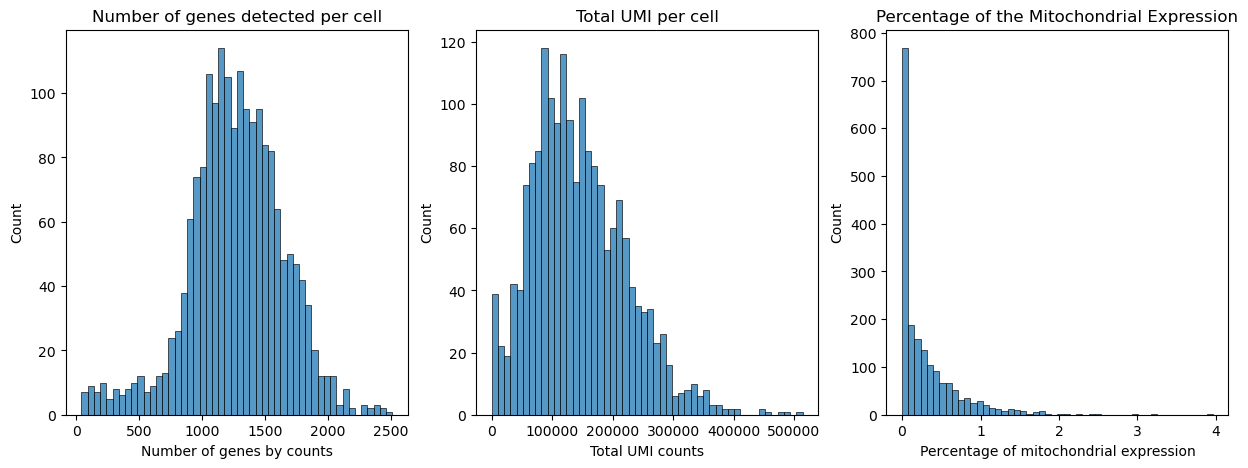

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(adata_glioblastoma_raw.obs["n_genes_by_counts"], bins=50, ax=axes[0])
axes[0].set_title("Number of genes detected per cell")
axes[0].set_xlabel("Number of genes by counts")
axes[0].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["total_counts"], bins=50, ax=axes[1])
axes[1].set_title("Total UMI per cell")
axes[1].set_xlabel("Total UMI counts")
axes[1].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["pct_mito"], bins=50, ax=axes[2])
axes[2].set_title("Percentage of the Mitochondrial Expression")
axes[2].set_xlabel("Percentage of mitochondrial expression")
axes[2].set_ylabel("Count")

plt.show()

In [28]:
# Display the first few rows of the .obs attribute as an HTML table
display(HTML(adata_glioblastoma_raw.obs.head().to_html()))

#### Correlation between number of genes by cell and total UMI counts

There is a clear positive correlation between the number of genes per cell and the total UMI counts. Cells with higher total UMI counts tend to have a greater number of detected genes, which is expected since higher sequencing depth or cellular activity often results in more genes being captured. The color gradient shows that cells with higher mitochondrial percentages (redder points) are scattered across the plot but tend to cluster in regions with lower total UMI counts and fewer detected genes. This suggests that cells with high mitochondrial activity may have lower overall transcriptional activity, potentially indicating stressed or dying cells.



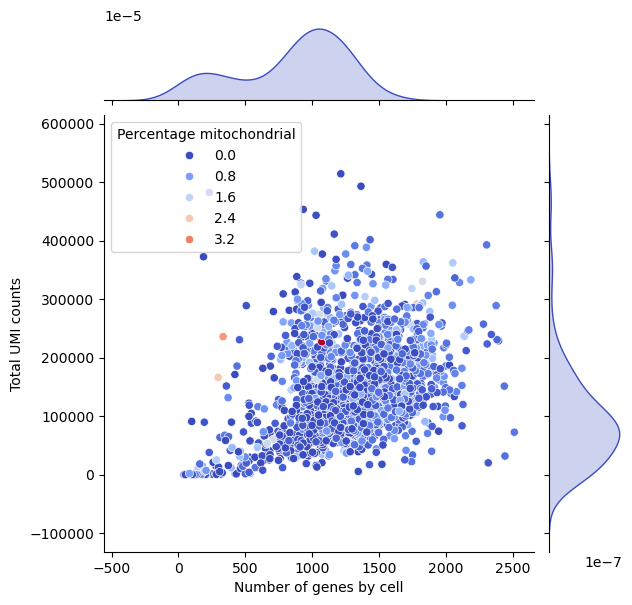

In [29]:
df = adata_glioblastoma_raw.obs[["n_genes_by_counts", "total_counts", "pct_mito"]].copy()
df.rename(columns={"n_genes_by_counts": "Number of genes by cell", 
                   "total_counts": "Total UMI counts", 
                   "pct_mito": "Percentage mitochondrial"}, inplace=True)

sns.jointplot(
    data=df,
    x="Number of genes by cell",
    y="Total UMI counts",
    hue="Percentage mitochondrial",
    palette="coolwarm",
    kind="scatter"
)

## Cell Filtering

`````{admonition} Why Do We Filter Cells?
:class: tip
We remove cells that are:  
1️⃣ **Low-quality or dead** → Few detected genes or low UMI counts.  
2️⃣ **Potential doublets** → Abnormally high UMI counts (two cells captured together).  
3️⃣ **Stressed or apoptotic** → High percentage of mitochondrial RNA.  
`````

#### Why These Thresholds?

1. **Minimum Genes per Cell (`min_genes = 200`)**:
   - This threshold ensures that only cells with at least 200 detected genes are retained. Cells with fewer genes are likely low-quality or empty droplets, which do not represent viable or biologically meaningful cells. This cutoff is commonly used in single-cell RNA-seq preprocessing to remove noise and artifacts from the dataset.  

2. **Maximum Genes per Cell (`max_genes = 5000`)**:
   - The upper limit of 5,000 genes per cell is set to exclude potential doublets or multiplets, where two or more cells are captured together, artificially inflating the number of detected genes. This threshold is adjusted to accommodate the complexity of tumor cells, which often exhibit higher transcriptional activity compared to normal cells.
3. **Minimum UMIs per Cell (`min_counts = 1000`)**:
   - A minimum of 1,000 total UMI counts per cell ensures sufficient sequencing depth to capture meaningful biological information. Cells with fewer counts are likely to be of low quality or insufficiently sequenced.
4. **Maximum Mitochondrial Percentage (`max_mito = 20`)**:
   - A maximum mitochondrial percentage of 20% is used to filter out cells with excessive mitochondrial gene expression, which is often indicative of stressed or dying cells. However, this threshold is set higher for cancer datasets, as tumor cells can exhibit elevated mitochondrial activity due to their altered metabolism and stress response.

In [30]:
# Filtering thresholds (adjusted for your dataset size)
min_genes = 200       # Minimum genes per cell (removes low-quality cells)
max_genes = 5000      # Upper limit (captures tumor cell complexity while excluding doublets)
min_counts = 1000     # Minimum UMIs/cell (ensures sufficient sequencing depth)
max_mito = 20         # Max mitochondrial % (higher tolerance for cancer cells)

# Apply filters
filtered_cells = (
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] > min_genes) &
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] < max_genes) &
    (adata_glioblastoma_raw.obs["total_counts"] > min_counts) &
    (adata_glioblastoma_raw.obs["pct_mito"] < max_mito)
)

adata_filtered = adata_glioblastoma_raw[filtered_cells].copy()

In [31]:
# Check retained cells/genes
print(f"Cells pre-filter: {adata_glioblastoma_raw.n_obs}, post-filter: {adata_filtered.n_obs}")
print(f"Genes pre-filter: {adata_glioblastoma_raw.n_vars}, post-filter: {adata_filtered.n_vars}")

Cells pre-filter: 1853, post-filter: 1823
Genes pre-filter: 7683, post-filter: 7683


#### Distribution of Cell Types Across Variables

1. **Number of Genes by Cell (`n_genes_by_cell`)**:
   - The violin plot for `n_genes_by_cell` shows variability across cell types:
     - **Astrocytes**, **immune cells**, and **vascular cells** have relatively lower median values and narrower distributions, indicating fewer detected genes per cell and less variability within these cell types.
     - **Neoplastic cells** exhibit the widest distribution and the highest median number of genes, reflecting their transcriptional complexity and heterogeneity, which is characteristic of tumor cells.
     - **Neurons** and **oligodendrocytes** show intermediate distributions, with neurons having slightly higher median values than oligodendrocytes.
     - **OPCs (oligodendrocyte precursor cells)** have a narrower distribution, suggesting a more uniform transcriptional profile compared to other cell types.
   - **Insights**: The high number of genes in neoplastic cells suggests their diverse transcriptional activity, while the lower values in astrocytes and vascular cells may reflect their more specialized roles.

2. **Total UMI Counts (`total_UMI_counts`)**:
   - The distribution of total UMI counts follows a similar pattern to `n_genes_by_cell`:
     - **Neoplastic cells** again show the highest median and widest distribution, consistent with their high transcriptional activity.
     - **Astrocytes**, **immune cells**, and **vascular cells** have lower median UMI counts and narrower distributions, indicating lower overall transcriptional activity.
     - **Neurons** and **oligodendrocytes** have intermediate UMI counts, with neurons showing slightly higher values.
     - **OPCs** have a relatively narrow distribution, similar to their pattern in `n_genes_by_cell`.
   - **Insights**: The high UMI counts in neoplastic cells further support their transcriptional heterogeneity, while the lower counts in astrocytes and vascular cells suggest more specialized and less active transcriptional states.

3. **Percentage of Mitochondrial Counts (`pct_mito`)**:
   - The mitochondrial percentage varies significantly across cell types:
     - **Astrocytes** and **immune cells** have the highest median mitochondrial percentages, with astrocytes showing a particularly wide distribution. This may indicate higher mitochondrial activity or stress in these cell types.
     - **Neoplastic cells** have a moderate mitochondrial percentage, with a relatively wide distribution, reflecting their metabolic diversity.
     - **Neurons**, **OPCs**, **oligodendrocytes**, and **vascular cells** have lower mitochondrial percentages, with vascular cells showing the narrowest distribution and lowest median values.
   - **Insights**: The high mitochondrial percentages in astrocytes and immune cells may reflect their active roles in maintaining homeostasis and responding to stress. The moderate mitochondrial activity in neoplastic cells could be linked to their altered metabolism, while the low percentages in neurons and vascular cells suggest less mitochondrial involvement in their transcriptional profiles.

C:\Users\henry\AppData\Local\Temp\ipykernel_7536\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\henry\AppData\Local\Temp\ipykernel_7536\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\henry\AppData\Local\Temp\ipykernel_7536\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


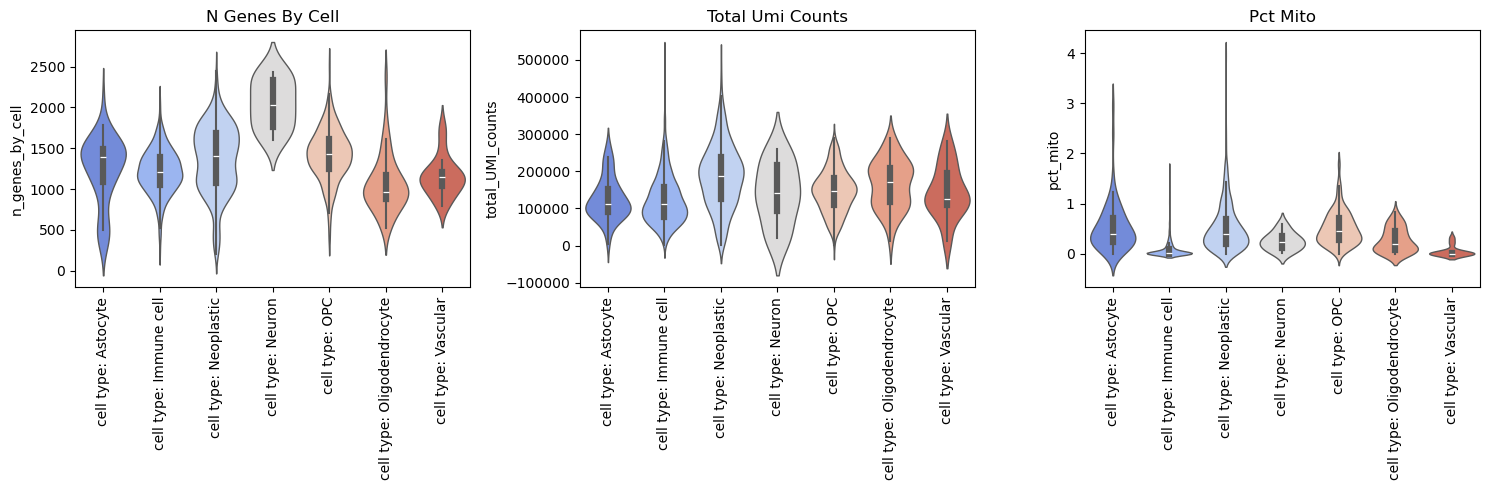

In [32]:
# Convert relevant data from adata_filtered to DataFrame
df = pd.DataFrame({
    'n_genes_by_cell': adata_filtered.obs['n_genes_by_counts'],  # Corrected column name
    'total_UMI_counts': adata_filtered.obs['total_counts'],      # Corrected column name
    'pct_mito': adata_filtered.obs['pct_mito'],
    'cell_type': adata_filtered.obs['cell_type']
})
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each metric 
for ax, metric in zip(axes, ['n_genes_by_cell', 'total_UMI_counts', 'pct_mito']):
    sns.violinplot(
        data=df,
        x='cell_type',
        y=metric,
        hue='cell_type',  # Needed for palette
        palette='coolwarm',
        legend=False,     # Disables legend
        ax=ax,
        density_norm='width',  # Replaces deprecated 'scale'
        linewidth=1       # Makes violin borders more visible
    )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Doublets and Singlets in Single-Cell RNA-Seq (scRNA-Seq)

```{} What are the singlet and doublets?

In single-cell RNA sequencing (scRNA-Seq), the terms **"doublet"** and **"singlet"** refer to the nature of the captured cells in the experiment:

- **Singlet** → A single individual cell encapsulated in a droplet or captured in a well.
- **Doublet** → Two cells encapsulated together in the same droplet, which can lead to contaminated or mixed data in the analysis.
```

### 🔬 Why is it important to detect doublets?
Doublets can lead to **false interpretations** in the analysis, as they may appear to be a new cell type with a combined expression profile of two real cells. This affects:

- **Cell type identification** (they may seem like new cell types that do not actually exist).
- **Analysis of cellular subpopulations**.
- **Inference of cell relationships and trajectories**.

In [33]:
# Extract counts matrix (assuming adata_filtered.X contains raw counts)
counts_matrix = adata_filtered.X

In [34]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.015) # Question for achim abut this range

Expected Doublet Rate Calculation

For droplet-based single-cell RNA sequencing (e.g., 10x Genomics), the expected doublet rate follows a linear relationship with cell loading density:**Recommended Doublet Detection Threshold for Your Data**, Where:
- **0.0008** is the empirical coefficient representing ~0.8% doublets per 1,000 cells
- This value comes from controlled experimental measurements

**1. Expected Doublet Rate Calculation**  

For **1,853 cells**, the estimated doublet rate is:  

$$\text{Expected Doublet Rate} = 1,853 \times 0.008 = 1.5\% $$

In [35]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.4%
Overall doublet rate:
	Expected   = 1.5%
	Estimated  = 0.0%
Elapsed time: 2.0 seconds


In [36]:
adata_filtered.obs['doublet_score'] = doublet_scores
adata_filtered.obs['predicted_doublet'] = predicted_doublets

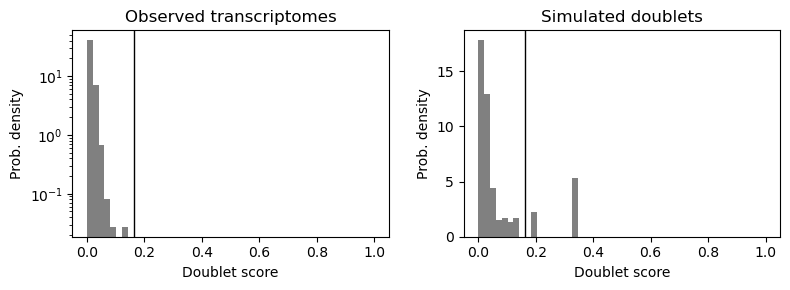

In [37]:
scrub.plot_histogram()
plt.show()


In [38]:
print(f"Detected doublet rate: {100*predicted_doublets.mean():.1f}%")
print(f"Number of predicted doublets: {predicted_doublets.sum()}")

Detected doublet rate: 0.0%
Number of predicted doublets: 0


**Visual inspection of scores vs. QC metrics**

A few cells exhibit slightly higher doublet scores (up to ~0.14), but these are sparse and do not form a significant cluster, suggesting that potential doublets are rare in this dataset. The expected doublet rate (based on experimental design) is **1.5%** and the estimated doublet rate (based on Scrublet's analysis) is **0.0%**, indicating that no doublets were identified in the dataset.

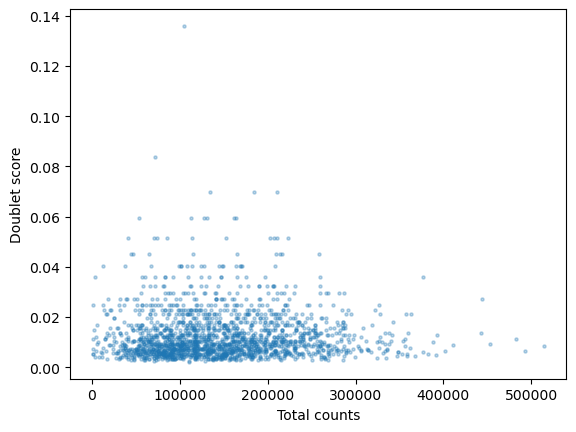

In [39]:
plt.scatter(adata_filtered.obs['total_counts'], adata_filtered.obs['doublet_score'], s=5, alpha=0.3)
plt.xlabel('Total counts')
plt.ylabel('Doublet score')
plt.show()

In [40]:
# Filtering and visualization
print(f"Before filtering doublets: {adata_filtered.n_obs} cells")
adata_filtered = adata_filtered[~adata_filtered.obs['predicted_doublet'], :].copy()
print(f"After filtering doublets: {adata_filtered.n_obs} cells")

Before filtering doublets: 1823 cells
After filtering doublets: 1823 cells


#### Umap distribution for doublets

This UMAP plot visualizes the distribution of cells in a reduced-dimensional space, with each point representing a cell. The color gradient corresponds to the **doublet scores** assigned to each cell, ranging from low (blue) to high (red).

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 7683 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


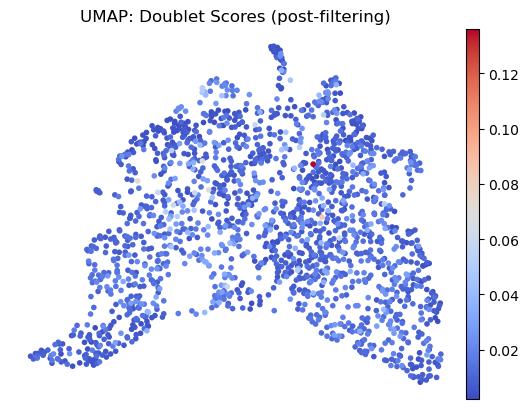

In [41]:
# Visualize remaining cells in UMAP
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

sc.pl.umap(adata_filtered, 
           color='doublet_score', 
           color_map='coolwarm', 
           title='UMAP: Doublet Scores (post-filtering)',
           frameon=False)

In [42]:
# adata_filtered.write('your_cleaned_data.h5ad')

## Data Normalization, Transformation and Standarization

  In this step we have to normalize the **total UMI counts per cell**. This means each cell's total count is rescaled to **10,000**, ensuring comparability across cells.  To get that we apply a **log transformation** to all gene expression values in `adata_glioblastoma_filtered.X`.  

***Variables normalized*** 
- The **gene expression values** (UMI counts) were normalized.  
- Other metadata variables (such as `n_counts_by_cell`, `total_counts`, or `pct_mito`) were **not modified**—these remain in `adata_filtered.obs`.  



In [43]:
# Normalize to median total counts (CPM-like normalization)
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

### **Transformation**

***Log Transformation Formula*** 

The log transformation used is:  

$$ \text{log1p}(x) = \log(1 + x) $$  

This helps stabilize variance and make the data more normally distributed.

In [44]:
# Log-transform the normalized data (log1p = log(1+x))
sc.pp.log1p(adata_filtered)

### **Select the most highly variable genes**

Uses the Seurat v3 method to find highly variable genes. It selects the top 2,000 most variable genes for further analysis.

In [45]:
# Identify highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_filtered,
    n_top_genes=2000,          # Keep top 2.500 variable genes
    flavor='seurat',           # Method used by Seurat (mean-variance relationship)
    subset=True                # Keep only HVGs for downstream analysis
)


### **Standarization**

```{admonition} Why Standardize?
Standardization transforms gene expression values to:

- Center and scale features: Each gene has mean = 0 and variance = 1

- Prevents highly expressed genes from dominating analysis:

- Improve PCA performance: Ensures all genes contribute equally to principal components

- Enable distance-based methods: Clustering (e.g., Leiden) and visualization (UMAP/t-SNE) require comparable feature scales
```

For each gene g:

$$\text{Scaled Expression} = \frac{X_{g} - \mu_{g}}{\sigma_{g}}$$

Where:
$$X_{g}: \text{Log-normalized expression}$$ 
$$\mu_{g}: \text{Mean expression across cells}$$  
$$\sigma_{g}: \text{Standard deviation}$$

In [46]:
# Scale to unit variance and zero mean (z-score)
sc.pp.scale(adata_filtered, max_value=10)

In [47]:
# Verify results
print(adata_filtered)
print(f"Number of HVGs selected: {adata_filtered.n_vars}")

AnnData object with n_obs × n_vars = 1823 × 2000
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'mito_UMI_counts', 'pct_mito', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Mapped_Gene', 'Is_Mitochondrial', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
Number of HVGs selected: 2000


A clear trend is visible: genes with higher mean expression tend to have higher dispersion. This is expected, as technical noise and biological variability both increase with expression levels.

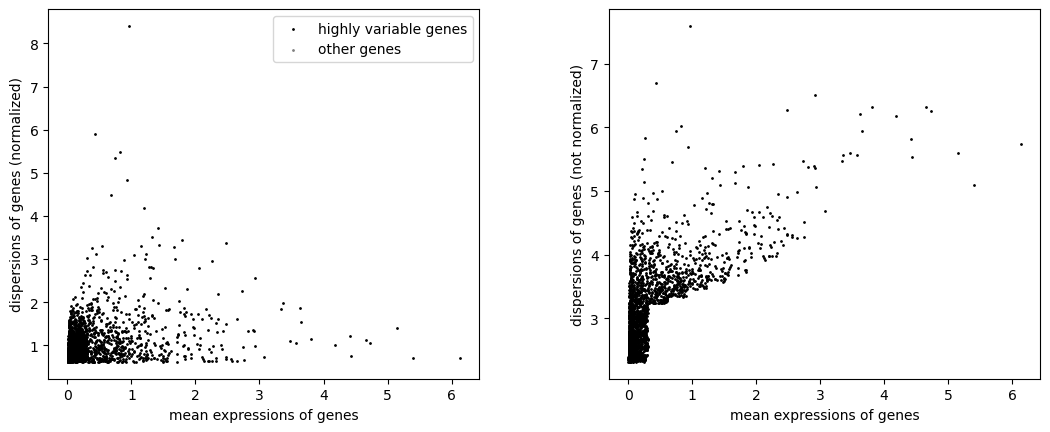

In [48]:
sc.pl.highly_variable_genes(adata_filtered)


A smaller number of genes have higher mean expression values, extending toward the right side of the plot. These genes are likely housekeeping genes or highly expressed genes with consistent expression across cells. The color gradient highlights the normalized dispersion values, with yellow points representing genes with the highest variability

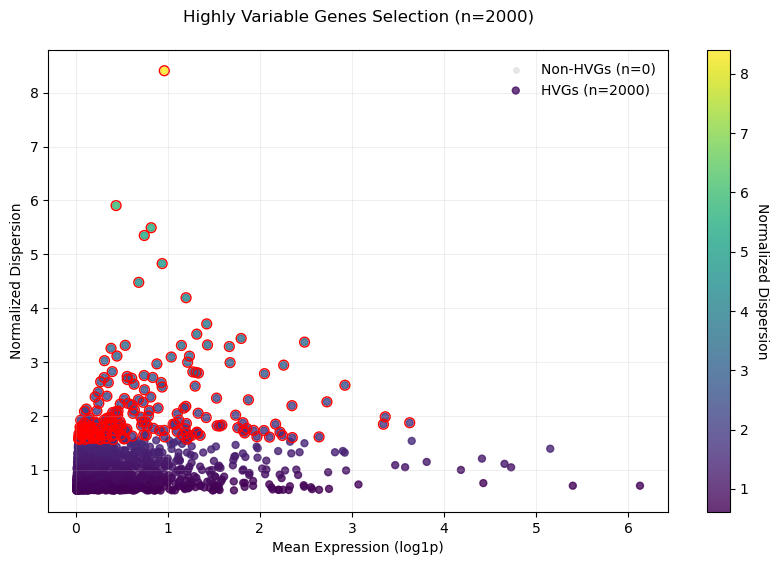

In [49]:
# Create a publication-quality HVG plot
plt.figure(figsize=(10, 6))

# Plot non-HVGs in light gray
plt.scatter(
    x=adata_filtered.var[~adata_filtered.var['highly_variable']]['means'],
    y=adata_filtered.var[~adata_filtered.var['highly_variable']]['dispersions_norm'],
    c='lightgray',
    s=15,
    alpha=0.5,
    label='Non-HVGs (n={})'.format(adata_filtered.n_vars - 2000)
)

# Plot HVGs with dispersion-based coloring
hvg_subset = adata_filtered.var[adata_filtered.var['highly_variable']]
scatter = plt.scatter(
    x=hvg_subset['means'],
    y=hvg_subset['dispersions_norm'],
    c=hvg_subset['dispersions_norm'],  # Color by dispersion value
    cmap='viridis',
    s=25,
    alpha=0.8,
    label='HVGs (n=2000)'
)

# Add colorbar for dispersion values
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Dispersion', rotation=270, labelpad=15)

# Formatting
plt.title('Highly Variable Genes Selection (n=2000)', pad=20)
plt.xlabel('Mean Expression (log1p)')
plt.ylabel('Normalized Dispersion')
plt.legend(frameon=False)
plt.grid(True, alpha=0.2)

# Highlight the top 10% most dispersed genes
top_10_pct = hvg_subset.nlargest(200, 'dispersions_norm')
plt.scatter(
    x=top_10_pct['means'],
    y=top_10_pct['dispersions_norm'],
    edgecolors='red',
    facecolors='none',
    s=50,
    linewidths=1,
    label='Top 10% HVGs'
)

plt.show()

## Batch Correction

In [50]:
adata_original = adata_filtered.copy()

# Remove zero-variance genes
gene_variances = np.var(
    adata_filtered.X.toarray() if hasattr(adata_filtered.X, "toarray") else adata_filtered.X,
    axis=0
)
genes_to_keep = gene_variances > 0
adata_filtered = adata_filtered[:, genes_to_keep]

In [51]:
sc.pp.pca(adata_filtered, n_comps=50)

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\preprocessing\_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [52]:
print("Running Harmony batch correction...")
harmony_out = hp.run_harmony(
    adata_filtered.obsm['X_pca'],
    adata_filtered.obs,
    ['plate_id']
)
adata_filtered.obsm['X_harmony'] = harmony_out.Z_corr.T
print("Harmony correction complete.")

2025-05-13 21:55:57,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony batch correction...


2025-05-13 21:55:57,930 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-13 21:55:57,948 - harmonypy - INFO - Iteration 1 of 10
2025-05-13 21:55:59,167 - harmonypy - INFO - Iteration 2 of 10
2025-05-13 21:56:00,363 - harmonypy - INFO - Iteration 3 of 10
2025-05-13 21:56:01,230 - harmonypy - INFO - Iteration 4 of 10
2025-05-13 21:56:02,722 - harmonypy - INFO - Iteration 5 of 10
2025-05-13 21:56:03,337 - harmonypy - INFO - Iteration 6 of 10
2025-05-13 21:56:04,562 - harmonypy - INFO - Iteration 7 of 10
2025-05-13 21:56:05,084 - harmonypy - INFO - Iteration 8 of 10
2025-05-13 21:56:06,040 - harmonypy - INFO - Iteration 9 of 10
2025-05-13 21:56:06,429 - harmonypy - INFO - Iteration 10 of 10
2025-05-13 21:56:07,447 - harmonypy - INFO - Stopped before convergence


Harmony correction complete.


In [53]:
# Compute neighbors and UMAP using Harmony embedding
sc.pp.neighbors(adata_filtered, use_rep='X_harmony')
sc.tl.umap(adata_filtered)

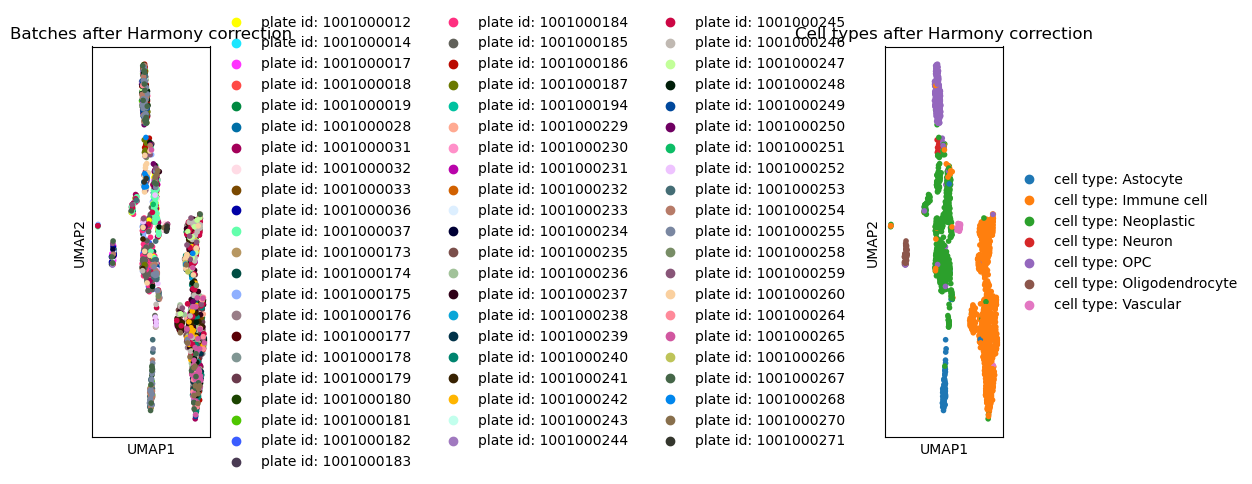

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    adata_filtered,
    color='plate_id',
    ax=ax1,
    title='Batches after Harmony correction',
    show=False
)
sc.pl.umap(
    adata_filtered,
    color='cell_type',
    ax=ax2,
    title='Cell types after Harmony correction',
    show=False
)

plt.tight_layout()
plt.show()

In [55]:
# Print summary statistics
print("\nShape of data after Harmony correction:", adata_filtered.shape)
print("Number of batches:", len(adata_filtered.obs['plate_id'].unique()))


Shape of data after Harmony correction: (1823, 2000)
Number of batches: 64


In [56]:
adata_filtered.write('C:/Users/henry/Downloads/adata_filtered.h5ad')

## Dimensionality reduction

````{admonition} What is dimensionality reduction?
Dimensionality reduction is the process of transforming high-dimensional data into a lower-dimensional space while preserving the most important features or patterns. In the context of single-cell RNA sequencing (scRNA-seq), where each cell is represented by thousands of gene expression values, dimensionality reduction is crucial for simplifying the data, reducing noise, and enabling meaningful visualization and analysis.
```

### Using PCA

- The first few PCs (e.g., PC1, PC2, PC3) explain the largest proportion of variance, with a steep drop-off in variance explained as the ranking increases.
- After approximately the 10th PC, the variance explained by each additional PC becomes minimal, indicating diminishing returns in terms of information captured.

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


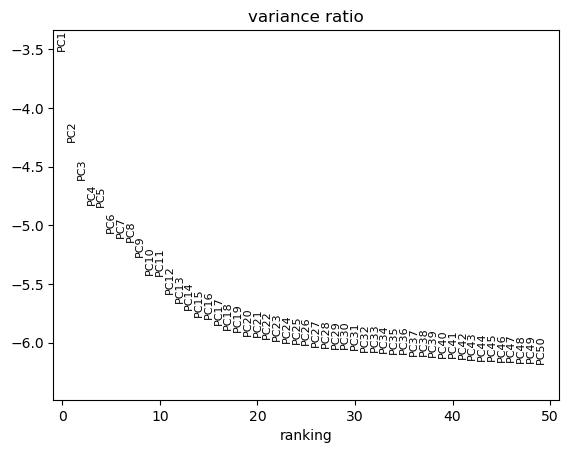

In [57]:
# Run PCA (using ARPACK for reproducibility)
sc.tl.pca(adata_filtered, 
          n_comps=50, 
          svd_solver='arpack',  # Best for reproducibility
          use_highly_variable=True)  # Use the 2000 HVGs

# Plot variance explained
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=50, log=True)

In [58]:
np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

array([0.02982847, 0.04353569, 0.0534675 , 0.06150168, 0.06939694,
       0.07571189, 0.08177835, 0.08763348, 0.09276243, 0.097189  ,
       0.10155126, 0.10531369, 0.10880657, 0.11208757, 0.11517075,
       0.11819483, 0.12108765, 0.12385833, 0.12657326, 0.12920351,
       0.13181002, 0.13437727, 0.13689186, 0.1393744 , 0.14182699,
       0.14426738, 0.14666459, 0.14902763, 0.15138672, 0.15372702,
       0.15605642, 0.15835232, 0.16064428, 0.16291155, 0.16516817,
       0.16741067, 0.16963257, 0.1718447 , 0.17403933, 0.17621431,
       0.17838238, 0.1805329 , 0.18266787, 0.18479817, 0.18692064,
       0.18902254, 0.19111815, 0.1932109 , 0.19529845, 0.19737189],
      dtype=float32)

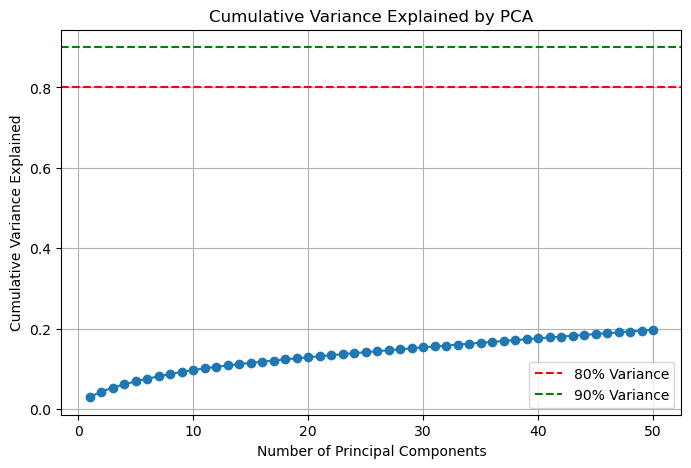

In [59]:
cumulative_variance = np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')  # Mark 80% threshold
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')  # Mark 90% threshold
plt.legend()
plt.grid()

# Show plot
plt.show()

#### Caclulate performance metrics

In [60]:
# Helper: get embedding from AnnData
def get_embedding(adata, key):
    if key == 'X_pca':
        return adata.obsm['X_pca']
    elif key == 'X_harmony':
        return adata.obsm['X_harmony']
    else:
        raise ValueError("Unknown embedding key")

In [61]:
# Helper: calculate batch entropy mixing
def batch_entropy(adata, embedding_key, batch_key, n_neighbors=30):
    from sklearn.neighbors import NearestNeighbors
    X = adata.obsm[embedding_key]
    batches = adata.obs[batch_key].values
    le = LabelEncoder()
    batch_labels = le.fit_transform(batches)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    entropies = []
    for i, neighbors in enumerate(indices):
        neighbor_batches = batch_labels[neighbors[1:]]  # exclude self
        probs = np.bincount(neighbor_batches, minlength=len(le.classes_)) / n_neighbors
        entropy = -np.sum([p * np.log2(p) for p in probs if p > 0])
        entropies.append(entropy)
    return np.mean(entropies)

In [62]:
# Calculate metrics for PCA
pca_embedding = get_embedding(adata_filtered, 'X_pca')
cell_types = adata_filtered.obs['cell_type'].values
batches = adata_filtered.obs['plate_id'].values

silhouette_pca = silhouette_score(pca_embedding, cell_types)
batch_entropy_pca = batch_entropy(adata_filtered, 'X_pca', 'plate_id')

In [63]:
# Calculate metrics for Harmony
harmony_embedding = get_embedding(adata_filtered, 'X_harmony')
silhouette_harmony = silhouette_score(harmony_embedding, cell_types)
batch_entropy_harmony = batch_entropy(adata_filtered, 'X_harmony', 'plate_id')

In [64]:
# Helper: calculate ARI and NMI
def clustering_metrics(embedding, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding)
    pred_labels = kmeans.labels_
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return ari, nmi

In [65]:
# Helper: variance explained (for PCA)
def variance_explained(adata):
    if 'pca' in adata.uns and 'variance_ratio' in adata.uns['pca']:
        return np.sum(adata.uns['pca']['variance_ratio'])
    else:
        return np.nan

In [66]:
results = pd.DataFrame({
    'Method': ['PCA', 'Harmony'],
    'Silhouette Score (cell type)': [silhouette_pca, silhouette_harmony],
    'Batch Entropy Mixing': [batch_entropy_pca, batch_entropy_harmony]
})

In [67]:
methods = {
    'PCA': 'X_pca',
    'Harmony': 'X_harmony',
}

In [68]:
results = []

# Encode cell types for metrics
cell_types = LabelEncoder().fit_transform(adata_filtered.obs['cell_type'])
n_cell_types = len(np.unique(cell_types))

In [69]:
for method, emb_key in methods.items():
    embedding = get_embedding(adata_filtered, emb_key)
    # Silhouette Score
    silhouette = silhouette_score(embedding, cell_types)
    # Batch Entropy
    batch_entropy_val = batch_entropy(adata_filtered, emb_key, 'plate_id')
    # ARI & NMI (using KMeans, number of clusters = number of cell types)
    ari, nmi = clustering_metrics(embedding, cell_types, n_cell_types)
    # Variance explained (only for PCA)
    var_exp = variance_explained(adata_filtered) if method == 'PCA' else np.nan
    # Append to results
    results.append({
        'Method': method,
        'Silhouette Score (cell type)': silhouette,
        'Batch Entropy Mixing': batch_entropy_val,
        'ARI': ari,
        'NMI': nmi,
        'Variance Explained': var_exp
    })

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [70]:
results_df = pd.DataFrame(results)
results_df

Method  Silhouette Score (cell type)  Batch Entropy Mixing       ARI  \
0      PCA                      0.189582              2.895963  0.537578   
1  Harmony                      0.218689              3.488787  0.550414   

        NMI  Variance Explained  
0  0.649484            0.197372  
1  0.674881                 NaN

**Selecting the best numbers of neighbors**

In [71]:
for k in [10, 15, 20, 30]:
    sc.pp.neighbors(adata_filtered, n_pcs=30, n_neighbors=k)
    sc.tl.leiden(adata_filtered, resolution=0.6, key_added=f'clust_k{k}')
    
    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    score = silhouette_score(adata_filtered.obsm['X_pca'][:,:30], 
                            adata_filtered.obs[f'clust_k{k}'])
    print(f"k={k}: Silhouette = {score:.3f}")

C:\Users\henry\AppData\Local\Temp\ipykernel_7536\1217238346.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered, resolution=0.6, key_added=f'clust_k{k}')


k=10: Silhouette = 0.191
k=15: Silhouette = 0.182
k=20: Silhouette = 0.180
k=30: Silhouette = 0.160


#### Neighbourhood Graph and Umap

```{admonition} What is UMAP?
UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used in single-cell RNA sequencing (scRNA-seq) analysis. It reduces high-dimensional data (like thousands of gene expression values per cell) into a 2D or 3D representation while preserving the local structure of the data. This allows us to visualize relationships between cells in a lower-dimensional space.
```

In [72]:
# Build graph with optimal k=10
sc.pp.neighbors(
    adata_filtered,
    n_pcs=30,       # From variance plot
    n_neighbors=10,  # From silhouette
    metric='euclidean'
)

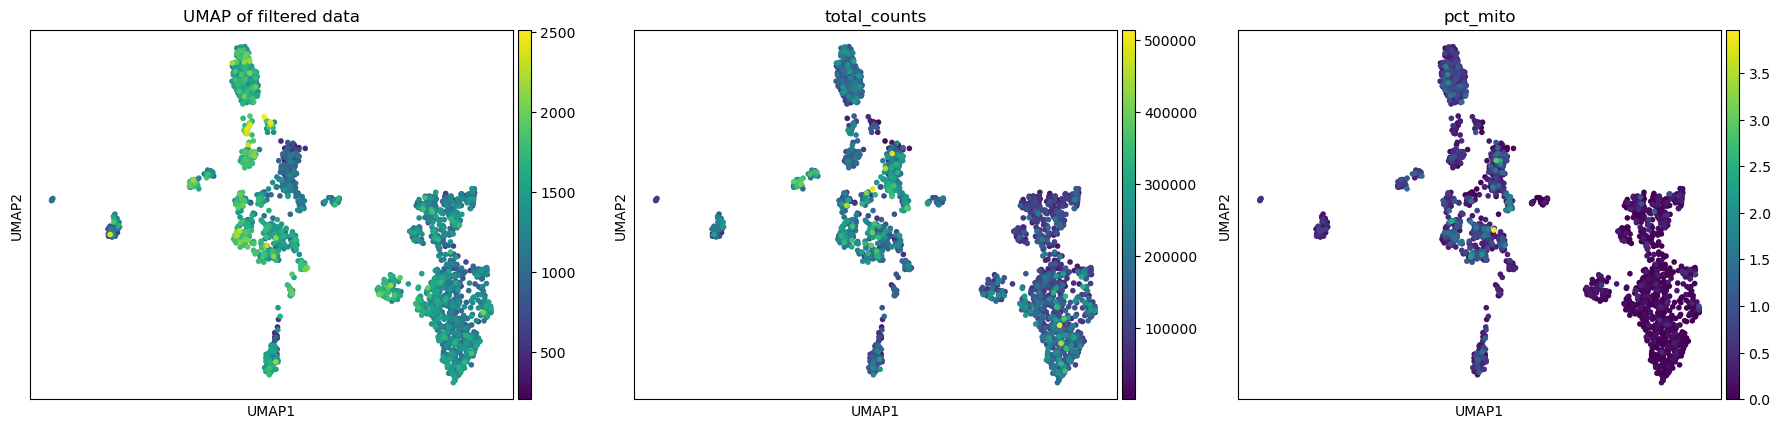

In [73]:
sc.pl.umap(adata_filtered, color=["n_genes_by_counts", "total_counts", "pct_mito"], ncols=3, title="UMAP of filtered data")

```{admonition} What is granularity in clusters?
In clustering algorithms like **Leiden** and **Louvain**, the **resolution parameter** controls the granularity of the clusters. It determines how finely or coarsely the data is partitioned into clusters. A higher resolution results in more, smaller clusters, while a lower resolution produces fewer, larger clusters.
```

### Clustering techniques

#### Using Leidein

The resolution parameter in Leiden clustering controls how granular your clusters will be:

- 0.4	Fewer, broader clusters	Identifying major cell types
- 0.6	Moderate clustering (default)	Balancing specificity/size
- 0.8	More, finer clusters	Detecting rare subtypes

In [74]:
# Cluster at multiple resolutions
for res in [0.4, 0.6, 0.8]:
    sc.tl.leiden(
        adata_filtered,
        resolution=res,
        key_added=f'leiden_r{res}'
    )

In [75]:
  
# Get cluster counts for each resolution
cluster_counts_r06 = adata_filtered.obs['leiden_r0.4'].value_counts().sort_index(ascending=True)
cluster_counts_r04 = adata_filtered.obs['leiden_r0.6'].value_counts().sort_index(ascending=True)
cluster_counts_r08 = adata_filtered.obs['leiden_r0.8'].value_counts().sort_index(ascending=True)


# Create a DataFrame
df_clusters = pd.DataFrame({
    'Leiden (r=0.4)': cluster_counts_r04,
    'Leiden (r=0.6)': cluster_counts_r06,
    'Leiden (r=0.8)': cluster_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_clusters)

    Leiden (r=0.4)  Leiden (r=0.6)  Leiden (r=0.8)
0              315             324             237
1              296             323             223
10              42              11              56
11              22               5              47
12              11               0              42
13               5               0              27
14               0               0              22
15               0               0              11
16               0               0               5
2              238             315             220
3              223             259             215
4              220             220             186
5              191             190             165
6               76              56             136
7               72              56              99
8               56              42              76
9               56              22              56


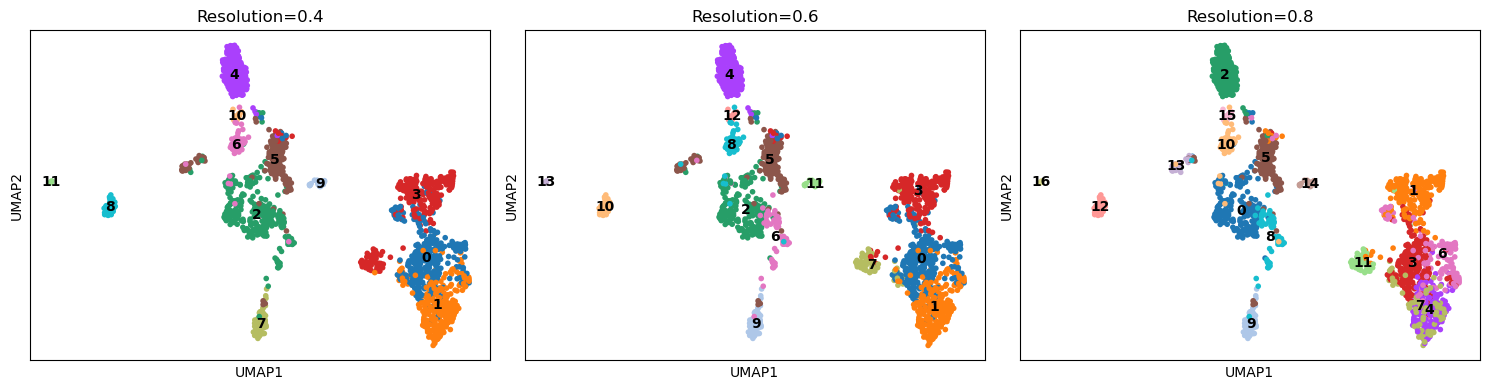

In [76]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

```{admonition} What is silhoutte score?
The **silhouette score** is a metric used to evaluate the quality of clustering. It measures how similar a cell is to other cells in its own cluster compared to cells in other clusters. The score ranges from -1 to 1:
- A score close to **1** indicates that cells are well-matched to their own cluster and poorly matched to other clusters (good clustering).
- A score close to **0** indicates that cells are on the boundary between clusters.
- A score close to **-1** indicates that cells may be assigned to the wrong cluster.
```

The Leiden clustering results show that **resolution 0.6** provides the best-defined clusters based on the silhouette score. Lower resolutions (e.g., 0.4) result in broader clusters, while higher resolutions (e.g., 0.8) lead to finer granularity but less well-defined clusters.

In [77]:
from sklearn.metrics import silhouette_score

for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'leiden_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.177
Resolution 0.6: Silhouette = 0.191
Resolution 0.8: Silhouette = 0.159


#### Clustering with louvain

In [78]:
for res in [0.4, 0.6, 0.8]:
    sc.tl.louvain(
        adata_filtered,
        resolution=res,
        key_added=f'louvain_r{res}',
        random_state=42
    )

In [79]:
# Get cluster counts for each resolution
louvain_counts_r04 = adata_filtered.obs['louvain_r0.4'].value_counts().sort_index(ascending=True)
louvain_counts_r06 = adata_filtered.obs['louvain_r0.6'].value_counts().sort_index(ascending=True)
louvain_counts_r08 = adata_filtered.obs['louvain_r0.8'].value_counts().sort_index(ascending=True)

# Create a DataFrame
df_louvain = pd.DataFrame({
    'Louvain (r=0.4)': louvain_counts_r04,
    'Louvain (r=0.6)': louvain_counts_r06,
    'Louvain (r=0.8)': louvain_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_louvain)

    Louvain (r=0.4)  Louvain (r=0.6)  Louvain (r=0.8)
0               348              350              350
1               285              320              291
10                0               23               42
11                0               11               23
12                0                0               11
2               270              268              230
3               241              235              223
4               220              220              220
5               215              192              192
6               135               56               79
7                67               56               56
8                42               50               56
9                 0               42               50


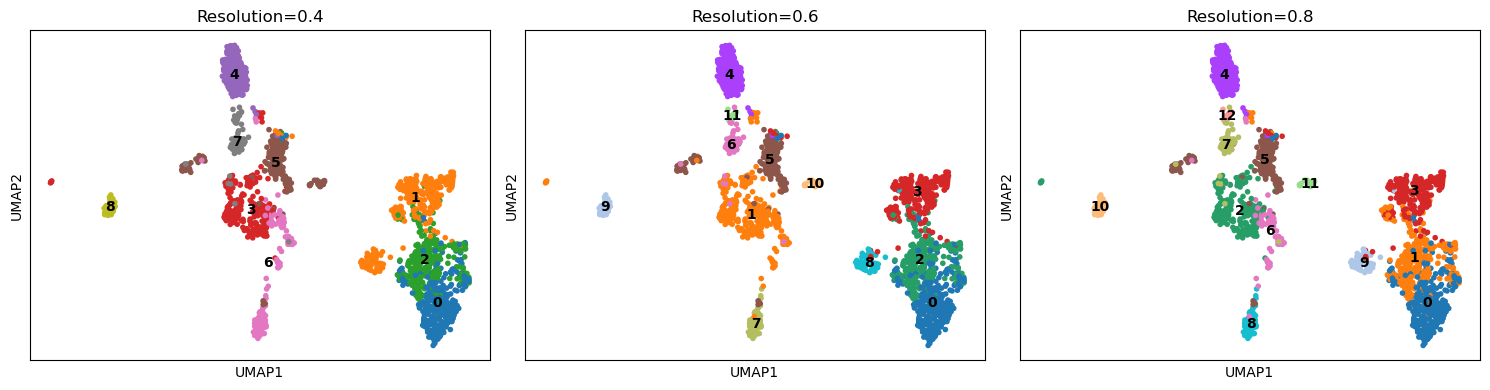

In [80]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

The Louvain clustering results show that higher resolutions lead to more clusters with smaller sizes, similar to the Leiden algorithm. However, Louvain tends to produce fewer, larger clusters compared to Leiden. The silhouette scores indicate that the clusters become more well-defined at higher resolutions, with the best score observed at **resolution 0.8**.

In [81]:
for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'louvain_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.157
Resolution 0.6: Silhouette = 0.176
Resolution 0.8: Silhouette = 0.197


#### Comparation between clusters

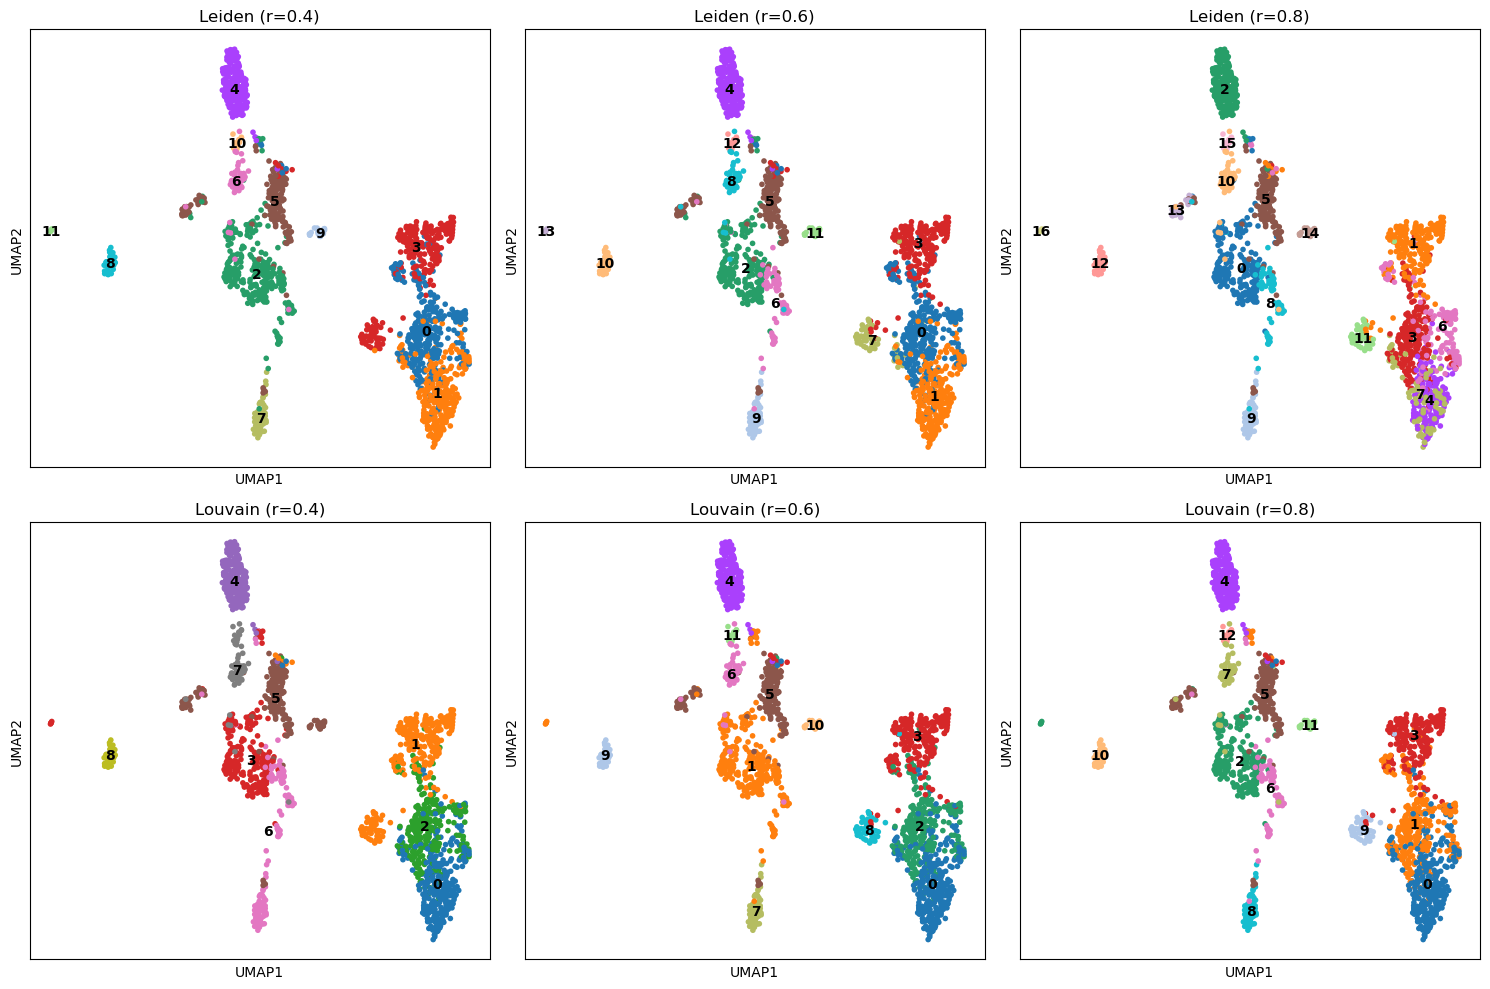

In [82]:
import matplotlib.pyplot as plt

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Leiden results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Leiden (r={res})',
        ax=axes[0,i],
        legend_loc='on data',
        show=False
    )

# Louvain results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Louvain (r={res})',
        ax=axes[1,i],
        legend_loc='on data',
        show=False
    )

plt.tight_layout()
plt.show()

**Cluster size comparison**
 Leiden clustering (blue) generally produces a larger number of smaller clusters compared to Louvain (orange), which results in slightly larger clusters. As the resolution increases, both methods detect more fine-grained structures, but Leiden retains a greater diversity in cluster sizes. This suggests that Leiden might be more sensitive to capturing smaller subpopulations, while Louvain tends to favor more balanced partitions.

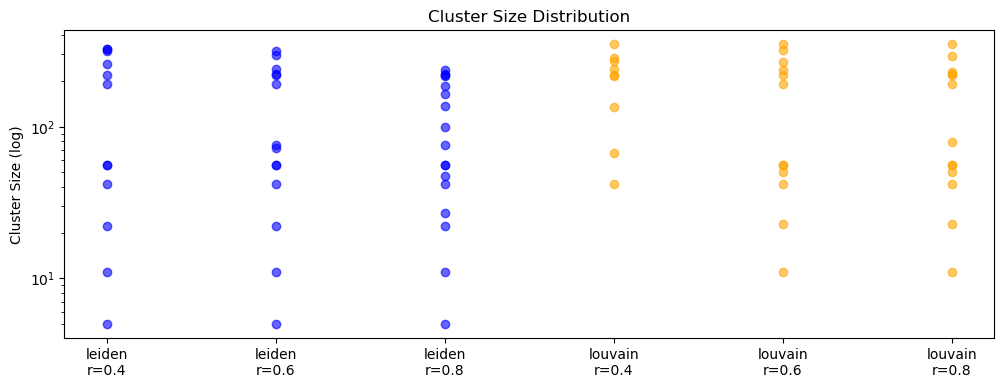

In [83]:
# Plot cluster sizes
plt.figure(figsize=(12, 4))
for i, method in enumerate(['leiden', 'louvain']):
    for res in [0.4, 0.6, 0.8]:
        counts = adata_filtered.obs[f'{method}_r{res}'].value_counts()
        plt.scatter(
            [f'{method}\nr={res}'] * len(counts),
            counts,
            color=['blue', 'orange'][i],
            alpha=0.6
        )
plt.yscale('log')
plt.ylabel('Cluster Size (log)')
plt.title('Cluster Size Distribution')
plt.show()

**Comparisson between solhoutte scores**

The silhouette scores provide insight into the clustering quality for different resolutions using Leiden and Louvain methods. At lower resolutions (r = 0.4, 0.6), Leiden outperforms Louvain with higher silhouette scores (0.177 and 0.191 vs. 0.157 and 0.176, respectively), indicating better-defined clusters. However, at r = 0.8, Louvain surpasses Leiden (0.197 vs. 0.161), suggesting that Louvain produces more cohesive clusters at higher resolutions. This indicates that Leiden is more effective at lower resolutions, while Louvain may be preferable when finer cluster structures are needed.



In [84]:
from sklearn.metrics import silhouette_score

# Calculate for all resolutions
results = []
for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        score = silhouette_score(
            adata_filtered.obsm['X_pca'][:,:30],
            adata_filtered.obs[f'{method}_r{res}']
        )
        results.append({
            'Method': method,
            'Resolution': res,
            'Silhouette': score
        })

# Display as table
import pandas as pd
pd.DataFrame(results).pivot(index='Resolution', columns='Method', values='Silhouette')

Method        leiden   louvain
Resolution                    
0.4         0.177232  0.156801
0.6         0.190543  0.175585
0.8         0.159214  0.196528

```{admonition} ARI (Adjusted Rand Index)
Measures how similar the cluster assignments are, adjusting for random chance.

- Range: 0 (random) to 1 (perfect match).

- Higher ARI means Leiden and Louvain results are similar.
```

ARI

In [85]:
from sklearn.metrics import adjusted_rand_score

for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        ari = adjusted_rand_score(
            adata_filtered.obs['cell_type'],
            adata_filtered.obs[f'{method}_r{res}']
        )
        print(f"{method} r={res}: ARI = {ari:.3f}")

leiden r=0.4: ARI = 0.417
leiden r=0.6: ARI = 0.362
leiden r=0.8: ARI = 0.285
louvain r=0.4: ARI = 0.380
louvain r=0.6: ARI = 0.397
louvain r=0.8: ARI = 0.369


```{admonition} NMI (Normalized Mutual Information)

 Measures how much information is shared between the two clustering methods.

- Range: 0 (independent) to 1 (identical clustering).

- Higher NMI indicates strong agreement between Leiden and Louvain.
```

In [86]:
from sklearn.metrics import normalized_mutual_info_score as nmi

# Compute NMI between Leiden and Louvain for each resolution
resolutions = [0.4, 0.6, 0.8]
nmi_results = []

for res in resolutions:
    leiden_labels = adata_filtered.obs[f'leiden_r{res}']
    louvain_labels = adata_filtered.obs[f'louvain_r{res}']
    nmi_score = nmi(leiden_labels, louvain_labels)
    nmi_results.append(nmi_score)

df_nmi = pd.DataFrame({
    'Resolution': resolutions,
    'NMI (Leiden vs Louvain)': nmi_results
})

print(df_nmi)

   Resolution  NMI (Leiden vs Louvain)
0         0.4                 0.872361
1         0.6                 0.889825
2         0.8                 0.876954


Biological clasification

- These genes represent a mix of immune-related (e.g., **SAA2**, **S100A8**), stress-response (e.g., **DNAJC9**), and regulatory genes (e.g., **CTDP1**, **FBXO32**).
- The presence of inflammation and immune-related genes suggests that the dataset may include immune cell populations or cells responding to stress or inflammation.
- Genes like **MGP** and **LEPROT** may indicate specific cell types or states, such as metabolic or extracellular matrix regulation.

In [87]:
# Get top 10 HVGs
top_hvgs = adata_filtered.var.nlargest(10, 'dispersions_norm').index.tolist()

# Create a mapping dictionary from your var table
gene_id_to_name = adata_filtered.var['Mapped_Gene'].to_dict()  # Or appropriate column

# Print top HVGs with their names
print("Top HVGs:")
for gene_id in top_hvgs:
    print(f"{gene_id}: {gene_id_to_name.get(gene_id, 'unnamed')}")

Top HVGs:
ENSG00000134339: SAA2
ENSG00000060069: CTDP1
ENSG00000258659: TRIM34
ENSG00000204542: C6orf15
ENSG00000213551: DNAJC9
ENSG00000215183: MSMP
ENSG00000156804: FBXO32
ENSG00000111341: MGP
ENSG00000143546: S100A8
ENSG00000213625: LEPROT


In [88]:
# Check which of your marker genes actually exist in Mapped_Gene
available_markers = []
for gene in ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']:
    if gene in adata_filtered.var['Mapped_Gene'].values:
        available_markers.append(gene)
    else:
        print(f"'{gene}' not found in Mapped_Gene column")

print("Available markers:", available_markers)

marker_genes = {
    'Inflammatory': [g for g in ['S100A8', 'SAA2'] if g in available_markers],
    'Proliferative': [g for g in ['MSMP', 'FBXO32'] if g in available_markers],
    'Structural': [g for g in ['MGP', 'DNAJC9'] if g in available_markers]
}

Available markers: ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']


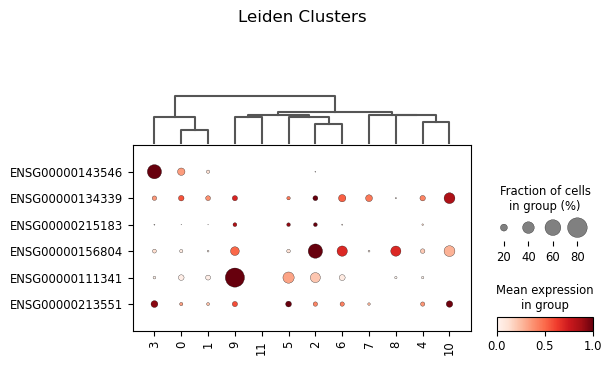

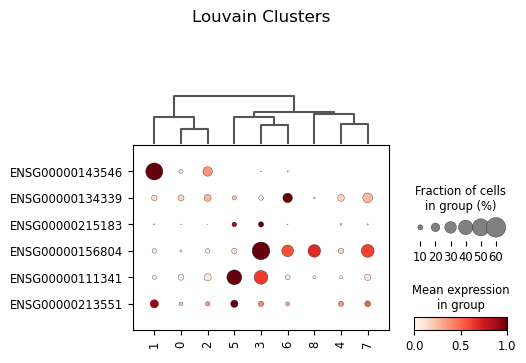

In [89]:
# Map gene symbols to var_names (Ensembl IDs) in adata_filtered.var
mapped_var_names = []
for gene_list in marker_genes.values():
    for gene in gene_list:
        matches = adata_filtered.var.index[adata_filtered.var["Mapped_Gene"] == gene].tolist()
        if matches:
            mapped_var_names.append(matches[0])
        else:
            print(f"Warning: {gene} not found in Mapped_Gene")

# Plot using the mapped var_names
for method in ['leiden', 'louvain']:
    sc.pl.dotplot(
        adata_filtered,
        var_names=mapped_var_names,  # Use mapped var_names
        groupby=f'{method}_r0.4',
        title=f'{method.capitalize()} Clusters',
        dendrogram=True,
        swap_axes=True,
        cmap='Reds',
        standard_scale='var',
        use_raw=False
    )

Mitochondrial content

- **Cluster 5** has the highest median and the widest distribution of `pct_mito`, with values extending up to 4%. This suggests that cells in this cluster exhibit elevated mitochondrial activity, potentially indicating stress or metabolic differences.
- **Clusters 0, 1, 3, 7, 9, and 10** have relatively narrow distributions and low medians, indicating consistent and low mitochondrial activity across cells in these clusters.
- **Clusters 2, 4, 6, and 8** show moderate variability, with slightly higher medians compared to clusters with low mitochondrial activity.

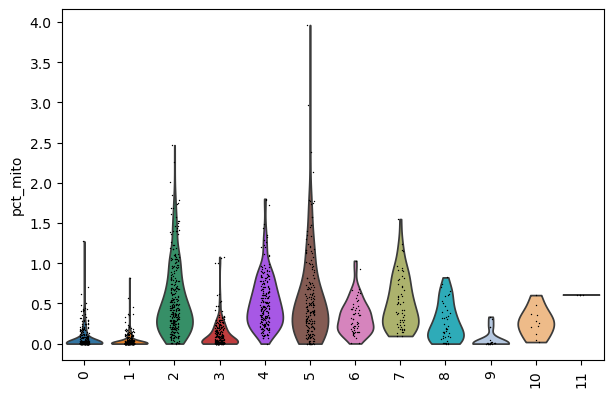

In [90]:
sc.pl.violin(
    adata_filtered,
    keys=['pct_mito'],
    groupby='leiden_r0.4',
    rotation=90
)


#### Best cluster method

**Leiden at r=0.4** is the optimal choice based on the highest ARI (0.417), indicating the best alignment with the reference clustering. This resolution provides broader clusters that are biologically interpretable and well-defined.

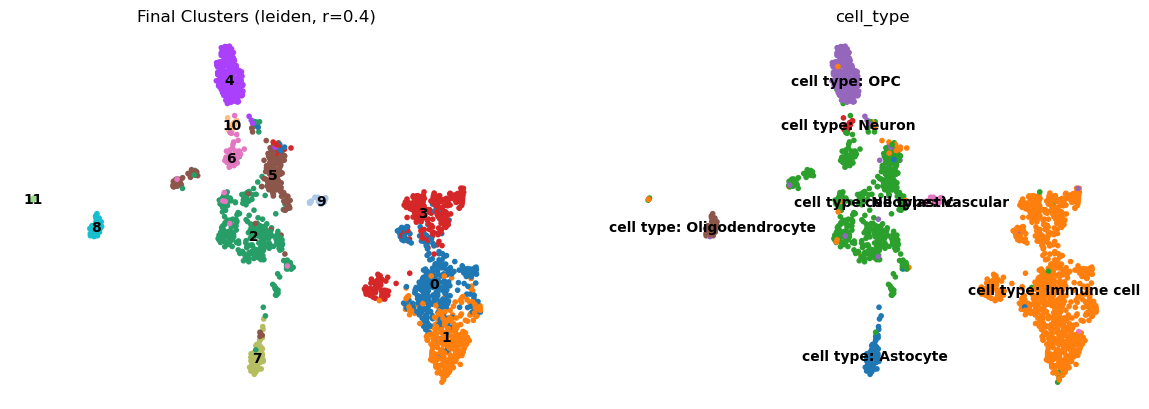

In [91]:
# Example: Select best resolution based on metrics
best_method = 'leiden'  # or 'louvain'
best_res = 0.4
adata_filtered.obs['final_clusters'] = adata_filtered.obs[f'{best_method}_r{best_res}']

# Visualize final choice
sc.pl.umap(
    adata_filtered,
    color=['final_clusters', 'cell_type'],
    legend_loc='on data',
    frameon=False,
    title=f'Final Clusters ({best_method}, r={best_res})'
)

## Differential Expression Analysis

```{admonition} What is Differential Expression Analysis?
Differential Expression (DE) analysis identifies genes that are **significantly upregulated or downregulated** between different conditions, cell types, or clusters in a single-cell RNA-seq (scRNA-seq) dataset.

- Helps **identify marker genes** that define different cell populations.
- Reveals **biological differences** between clusters or experimental conditions.
- Can be used for **functional enrichment analysis** (e.g., GO, KEGG pathways).
```

When analyzing differentially expressed genes, we focus on:

- **Log Fold Change (logFC)**: Measures how much a gene is up/downregulated.
- **Adjusted p-value (FDR)**: Ensures statistical significance while controlling false positives.
- **Mean Expression**: Helps distinguish truly expressed genes from noise.

In [ ]:
# Compute DEGs for all clusters (compared to the rest)
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters',  # Column with cluster labels
    method='wilcoxon',        # Default method (alternatives: 't-test', 'logreg')
    key_added='dea_results',  # Stores results in `adata.uns['dea_results']`
    pts=True                 # Add fraction of cells expressing each gene
)

# Save top 10 DEGs per cluster
dea_results = pd.DataFrame(adata_filtered.uns['dea_results']['names'])
top_degs = dea_results.head(10)
print(top_degs)

                 0                1                2                3  \
0  ENSG00000198502  ENSG00000277632  ENSG00000125148  ENSG00000197747   
1  ENSG00000227357  ENSG00000275302  ENSG00000175183  ENSG00000090382   
2  ENSG00000275395  ENSG00000276070  ENSG00000117318  ENSG00000160213   
3  ENSG00000116741  ENSG00000277336  ENSG00000115457  ENSG00000147872   
4  ENSG00000242574  ENSG00000179388  ENSG00000134531  ENSG00000258227   
5  ENSG00000137393  ENSG00000276085  ENSG00000187193  ENSG00000110719   
6  ENSG00000127951  ENSG00000171860  ENSG00000177606  ENSG00000143546   
7  ENSG00000107968  ENSG00000169313  ENSG00000109846  ENSG00000240972   
8  ENSG00000147872  ENSG00000204287  ENSG00000106211  ENSG00000115165   
9  ENSG00000204287  ENSG00000266028  ENSG00000176907  ENSG00000159399   

                 4                5                6                7  \
0  ENSG00000189058  ENSG00000198804  ENSG00000135452  ENSG00000164089   
1  ENSG00000102934  ENSG00000106211  ENSG000001837


#### **Top Differentially Expressed Genes (DEGs) per Cluster - Biological Interpretation**

#### **Cluster 0**
- **Key Genes**: HLA-DRB5, CCL3, MT2A, S100A10, APOD
- **Description**:  
  - Immune/Inflammatory cluster:  
    - `HLA-DRB5` (MHC class II), `CCL3` (chemokine), and `S100A10` (calcium-binding protein) suggest antigen presentation and immune activation.  
    - `MT2A` (metallothionein) indicates metal ion homeostasis/stress response.  
    - `APOD` (lipocalin) may relate to lipid metabolism.

#### **Cluster 1**
- **Key Genes**: HLA-DRB4, CCL4, CSRP2, LYZ, PLLP  
- **Description**:  
  - Macrophage/Myeloid lineage cluster:  
    - `LYZ` (lysozyme) and `CCL4` (chemokine) are myeloid cell markers.  
    - `CSRP2` (cysteine-rich protein) links to smooth muscle differentiation.  
    - `HLA-DRB4` reinforces antigen presentation roles.

#### **Cluster 2**
- **Key Genes**: FCGBP, CCL4L2, ID3, CSTB, DNER  
- **Description**:  
  - Secretory/Epithelial cluster:  
    - `FCGBP` (mucin-binding protein) and `CSTB` (cystatin B) are enriched in mucosal/epithelial tissues.  
    - `ID3` (inhibitor of DNA binding) regulates cellular differentiation.

#### **Cluster 3**
- **Key Genes**: RGS2, CCL3L3, IGFBP2, PLIN2  
- **Description**:  
  - Lipid Metabolism/Adipocyte cluster:  
    - `PLIN2` (lipid droplet protein) and `IGFBP2` (insulin-like growth factor binding) suggest adipocyte/metabolic functions.  
    - `RGS2` regulates G-protein signaling in metabolic pathways.

#### **Cluster 4**
- **Key Genes**: HLA-DMB, EGR3, EMP1, CLEC5A  
- **Description**:  
  - Dendritic Cell/Immune Activation cluster:  
    - `HLA-DMB` (MHC class II chaperone) and `CLEC5A` (C-type lectin) indicate immune cell activation.  
    - `EGR3` (early growth response) regulates T-cell differentiation.

#### **Cluster 5**
- **Key Genes**: RNF144B, CCL3L3, MT1X, TCIRG1  
- **Description**:  
  - Stress Response/Oxidative cluster:  
    - `MT1X` (metallothionein) and `TCIRG1` (proton pump subunit) respond to oxidative/metal stress.  
    - `RNF144B` (E3 ubiquitin ligase) links to protein degradation.

#### **Cluster 6**
- **Key Genes**: FGL2, C3AR1, JUN, S100A8  
- **Description**:  
  - Pro-inflammatory/Neutrophil cluster:  
    - `S100A8` (calgranulin A) and `C3AR1` (complement receptor) are neutrophil markers.  
    - `JUN` (AP-1 transcription factor) drives inflammatory signaling.

#### **Cluster 7**
- **Key Genes**: MAP3K8, P2RY12, CRYAB, MIF  
- **Description**:  
  - Microglial/Neuroimmune cluster:  
    - `P2RY12` (purinergic receptor) and `CRYAB` (heat shock protein) are microglia markers.  
    - `MIF` (macrophage migration inhibitory factor) regulates neuroinflammation.

#### **Cluster 8**
- **Key Genes**: PLIN2, HLA-DRA, HSPB1, CYTIP  
- **Description**:  
  - Lipid-Associated/Stress cluster:  
    - `PLIN2` (lipid droplet) and `HSPB1` (heat shock protein) indicate lipid storage/stress.  
    - `HLA-DRA` (MHC class II) suggests immune crosstalk.

#### **Cluster 9**
- **Key Genes**: HLA-DRA, SRGAP2, TCIM, HK2  
- **Description**:  
  - Metabolic/Neuronal cluster:  
    - `HK2` (hexokinase) and `SRGAP2` (neuronal development) suggest glucose metabolism/neuronal roles.  
    - `TCIM` (TP53-regulated inhibitor) may link to apoptosis regulation.

#### **Cluster 10**
- **Key Genes**: GABBR2, ZCCHC12, TUBB2A, CPNE6  
- **Description**:  
  - Neuronal/Developmental cluster:  
    - `GABBR2` (GABA receptor) and `TUBB2A` (neural tubulin) indicate neuronal signaling.  
    - `ZCCHC12` (zinc finger protein) is involved in neurodevelopment.

#### **Cluster 11**
- **Key Genes**: ZNF486, TCIM, RTL6, AQP11  
- **Description**:  
  - Undefined/Niche cluster:  
    - `AQP11` (aquaporin) suggests transmembrane transport.  
    - `RTL6` (retrotransposon-like) has unclear biological relevance.  
    - Requires further investigation.


```{admonition} Summary of genes per cluster
- **Immune Clusters**: 0, 1, 4, 6, 7 (MHC/chemokine genes)  
- **Metabolic/Lipid Clusters**: 3, 8 (PLIN2, APOD)  
- **Neuronal Clusters**: 9, 10 (HK2, GABBR2)  
- **Stress Response Clusters**: 5 (MT1X, TCIRG1)
```

In [ ]:
# Compute DEGs for all clusters
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters',
    method='wilcoxon',
    key_added='dea_results',
    pts=True
)

# Create a dictionary to map Ensembl IDs to gene symbols
ensembl_to_gene = adata_filtered.var['Mapped_Gene'].to_dict()

# Replace Ensembl IDs with gene symbols in the DEG results dataframe
top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists
top_degs_mapped = top_degs_mapped.head(10)

print("Top DEGs (Mapped to Gene Symbols):")
print(top_degs_mapped)

Top DEGs (Mapped to Gene Symbols):
          0        1       2        3        4        5        6        7  \
0  HLA-DRB5     CCL3    MT2A  S100A10     APOD     COX1  TSPAN31   ETNPPL   
1  HLA-DRB4     CCL4   CSRP2      LYZ     PLLP    HSPB1     TBK1      AGT   
2     FCGBP   CCL4L2     ID3     CSTB     DNER      CA2   LANCL2   CLDN10   
3      RGS2   CCL3L3  IGFBP2    PLIN2      NaN    KCNE5     PMP2    PLPP3   
4   HLA-DMB     EGR3    EMP1   CLEC5A  PCDHGC3  RARRES2      ARC    GLUD1   
5   RNF144B   CCL3L3    MT1X   TCIRG1    CSPG4     H4C3    CRYAB     SCG3   
6      FGL2    C3AR1     JUN   S100A8  GPR37L1  IL13RA2     SCG2      NaN   
7    MAP3K8   P2RY12   CRYAB      MIF     SCG3    TMT1B   LRRTM2  GPR37L1   
8     PLIN2  HLA-DRA   HSPB1    CYTIP   PLPPR1      AGT  PCDHGC3    S1PR1   
9   HLA-DRA   SRGAP2    TCIM      HK2   MEGF11   PDLIM1   IGFBP5    TTYH1   

         8         9       10      11  
0   DBNDD2       NaN   GABBR2  ZNF486  
1    CRYAB     CD248  ZCCHC12    TCIM

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\320458301.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists


### Volcano Plot

In [ ]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden_r0.4", method="wilcoxon", key_added="dea_results")
degs_df = sc.get.rank_genes_groups_df(adata_filtered, group="2", key="dea_results")


- The majority of genes have low -Log10 adjusted p-values, clustering near the bottom of the plot. This indicates that most genes do not show statistically significant differential expression.
- Only a small subset of genes shows both high fold changes and moderate significance, suggesting that these genes may be key markers or drivers of Cluster 2.

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\2788135446.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


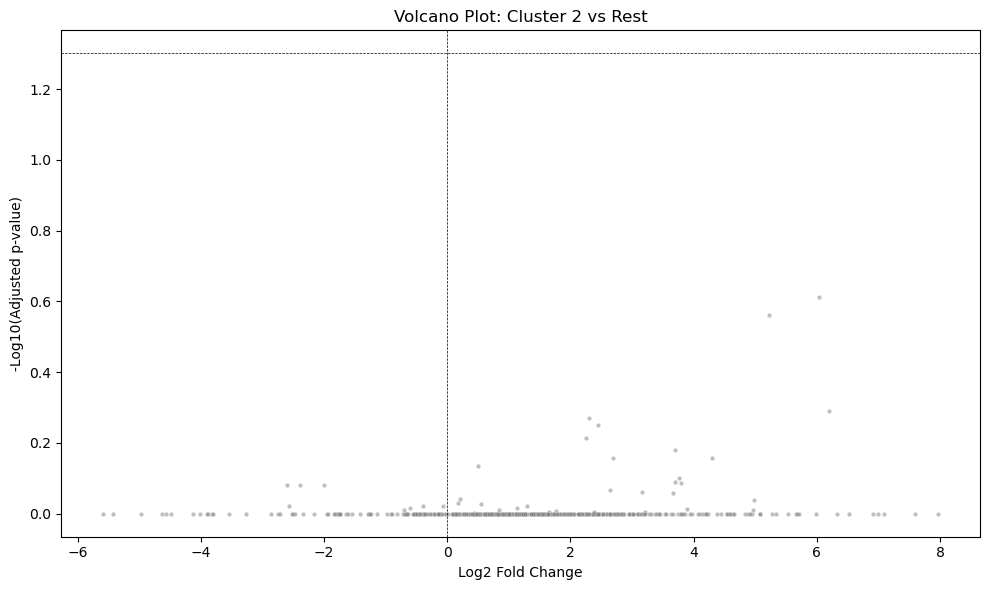

In [ ]:
# Drop NaNs and ensure numeric values
degs_df = degs_df.dropna(subset=["logfoldchanges", "pvals_adj"])
degs_df["pvals_adj"] = pd.to_numeric(degs_df["pvals_adj"], errors="coerce")

# Create volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(
    data=degs_df,
    x="logfoldchanges",
    y=-np.log10(degs_df["pvals_adj"]),
    color="gray",
    alpha=0.5,
    s=10
)

# Highlight significant genes
sig_degs = degs_df[(degs_df["pvals_adj"] < 0.05) & (abs(degs_df["logfoldchanges"]) > 0.5)]
sns.scatterplot(
    data=sig_degs,
    x="logfoldchanges",
    y=-np.log10(sig_degs["pvals_adj"]),
    hue=sig_degs["logfoldchanges"] > 0,
    palette={True: "red", False: "blue"},
    s=20,
    legend=False
)

# Label top significant genes
for _, row in sig_degs.nsmallest(5, "pvals_adj").iterrows():
    plt.text(
        row["logfoldchanges"],
        -np.log10(row["pvals_adj"]),
        row["gene_symbol"],
        fontsize=8,
        ha="center",
        va="bottom"
    )

# Add threshold lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black", linewidth=0.5)  # p = 0.05 cutoff
plt.axvline(0, linestyle="--", color="black", linewidth=0.5)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(Adjusted p-value)")
plt.title(f"Volcano Plot: Cluster 2 vs Rest")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Ensure the columns exist
print(degs_df.columns)

# Check for NaNs
print(degs_df.isna().sum())

Index(['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj'], dtype='object')
names             0
scores            0
logfoldchanges    0
pvals             0
pvals_adj         0
dtype: int64


In [ ]:
print(degs_df[["logfoldchanges", "pvals_adj"]].describe())


       logfoldchanges   pvals_adj
count      431.000000  431.000000
mean         1.259929    0.983609
std          2.109867    0.075351
min         -5.586777    0.243576
25%          0.262969    0.999040
50%          1.127348    0.999040
75%          2.406521    0.999040
max          7.970360    0.999906


In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg correction
degs_df["pvals_adj"] = multipletests(degs_df["pvals"], method="fdr_bh")[1]

# Check if values are more reasonable
print(degs_df["pvals_adj"].describe())


count    4.310000e+02
mean     9.992488e-01
std      1.111513e-16
min      9.992488e-01
25%      9.992488e-01
50%      9.992488e-01
75%      9.992488e-01
max      9.992488e-01
Name: pvals_adj, dtype: float64


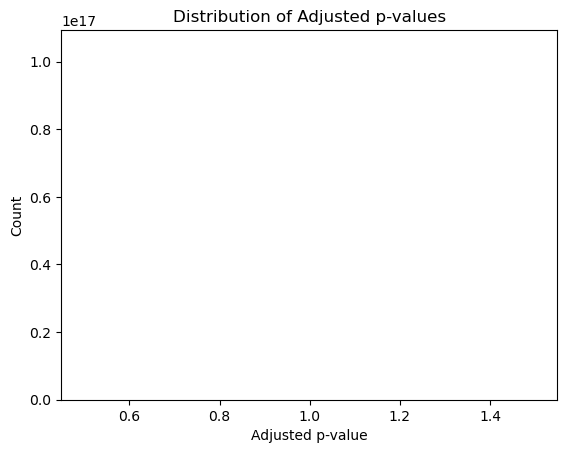

In [ ]:
degs_df = degs_df.dropna(subset=["logfoldchanges"])

sns.histplot(degs_df['pvals_adj'], bins=50, kde=True)
plt.xlabel('Adjusted p-value')
plt.ylabel('Count')
plt.title('Distribution of Adjusted p-values')
plt.show()


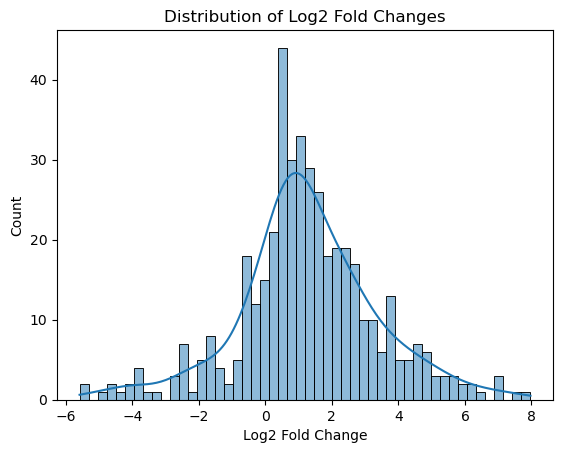

In [ ]:
sns.histplot(degs_df['logfoldchanges'], bins=50, kde=True)
plt.xlabel('Log2 Fold Change')
plt.ylabel('Count')
plt.title('Distribution of Log2 Fold Changes')
plt.show()


# Benchmark Models

## Model VAE

In [156]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()
        #Encoder
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)

        #dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

Loss Function

In [157]:
def zinb_loss(recon_x, x, mu, log_var, beta=1.0, theta=1.0):
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()
        else:
            x = torch.tensor(x, dtype=torch.float32)

    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()
        else:
            recon_x = torch.tensor(recon_x, dtype=torch.float32)

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - 
                         torch.lgamma(theta_tensor) + x * torch.log(torch.clamp(recon_x, min=1e-8) + 1e-8) + 
                         theta_tensor * torch.log(theta_tensor / (torch.clamp(recon_x, min=1e-8) + 1e-8)))

    # Loss KL
    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Loos total
    total_loss = nb_loss + beta * kl_loss
    return total_loss, nb_loss, kl_loss

Training of the model

In [158]:
def train_model_vae(model, X, optimizer, num_epochs, verbose=1):
    model.train()
    losses, nb_losses, kl_losses = [], [], []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X)
        loss, nb_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        kl_losses.append(kl_loss.item())

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}, NB Loss: {nb_loss.item():.4f}, "
                  f"KL Loss: {kl_loss.item():.4f}")

    return losses, nb_losses, kl_losses

#### Clusterization for VAE

In [ ]:
def clustering_and_metrics(mu, X_data):
    # Latent representation (mu)
    adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
    # Preprocessing UMAP
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # clustering resolutions
    resolutions = [0.4, 0.6, 0.8]
    methods = ['leiden', 'louvain']
    clustering_results = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    i = 0

    for method in methods:
        for res in resolutions:
            key = f"{method}_r"
            
            #Leiden o Louvain
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)
            # clusters lablels
            labels = adata_latent.obs[key].astype(int).values
            n_clusters = len(set(labels))
            silh = silhouette_score(adata_latent.obsm['X_umap'], labels) if n_clusters > 1 else -1
            ch = calinski_harabasz_score(adata_latent.obsm['X_umap'], labels) if n_clusters > 1 else -1
            
            clustering_results.append({
                'method': method,
                'resolution': res,
                'n_clusters': n_clusters,
                'silhouette': silh,
                'calinski_harabasz': ch
            })

            axs[i].scatter(adata_latent.obsm['X_umap'][:, 0], adata_latent.obsm['X_umap'][:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
            axs[i].set_xlabel("UMAP1")
            axs[i].set_ylabel("UMAP2")
            i += 1

    plt.tight_layout()
    plt.show()

    return clustering_results




### Hyperparametrization of VAE

In [ ]:
# GridSEARCH
def hyperparameter_search(X, input_dim, num_epochs):
    param_grid = {
        'hidden_dim': [64, 128, 256],
        'latent_dim': [32, 64, 128],
        'dropout_rate': [0.1, 0.2, 0.3],
        'learning_rate': [1e-3, 1e-4, 1e-5]
    }

    best_score = float('inf')
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        model = VAE(input_dim, params['hidden_dim'], params['latent_dim'], dropout_rate=params['dropout_rate'])
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        losses, nb_losses, bernoulli_losses, kl_losses = train_model_vae(model, X, optimizer, num_epochs, verbose=1)
        
        # Evaluar métricas
        final_loss = losses[-1]
        if final_loss < best_score:
            best_score = final_loss
            best_params = params
            best_model = model

    return best_model, best_params

In [ ]:
input_dim = adata_filtered.shape[1]
X_data = adata_filtered.X
X = torch.FloatTensor(X_data)
num_epochs = 200
best_model, best_params = hyperparameter_search(X, input_dim, num_epochs)

print(f"Best hyperparameters: {best_params}")


Training with parameters: {'dropout_rate': 0.1, 'hidden_dim': 64, 'latent_dim': 32, 'learning_rate': 0.001}


C:\Users\henry\AppData\Local\Temp\ipykernel_21284\419942230.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_21284\419942230.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -34560792.0000, NB Loss: -37103348.0000, Bernoulli Loss: 2541348.5000, KL Loss: 1206.4799
Epoch [2/200] - Loss: -34590584.0000, NB Loss: -37111328.0000, Bernoulli Loss: 2519559.7500, KL Loss: 1184.4680
Epoch [3/200] - Loss: -34598704.0000, NB Loss: -37098516.0000, Bernoulli Loss: 2498512.7500, KL Loss: 1300.6113
Epoch [4/200] - Loss: -34637784.0000, NB Loss: -37113776.0000, Bernoulli Loss: 2474525.0000, KL Loss: 1466.0491
Epoch [5/200] - Loss: -34670012.0000, NB Loss: -37117492.0000, Bernoulli Loss: 2445813.2500, KL Loss: 1667.7100
Epoch [6/200] - Loss: -34690560.0000, NB Loss: -37103228.0000, Bernoulli Loss: 2410737.0000, KL Loss: 1931.2047
Epoch [7/200] - Loss: -34733728.0000, NB Loss: -37102920.0000, Bernoulli Loss: 2366942.2500, KL Loss: 2247.0508
Epoch [8/200] - Loss: -34783668.0000, NB Loss: -37100732.0000, Bernoulli Loss: 2314452.0000, KL Loss: 2610.7275
Epoch [9/200] - Loss: -34858728.0000, NB Loss: -37110908.0000, Bernoulli Loss: 2249134.0000, KL Loss: 30

In [160]:
#Using the best parameters
X_data = adata_filtered.X 
dropout_rate = 0.1
hidden_dim = 256
latent_dim = 64
learning_rate = 0.001
num_epochs = 200
input_dim = X_data.shape[1]

In [161]:
# Model
vae_model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate=dropout_rate)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
X_data_tensor = torch.tensor(X_data, dtype=torch.float32) #tensor
vae_losses, vae_nb_losses, vae_kl_losses = train_model_vae(vae_model, X_data_tensor, optimizer, num_epochs, verbose=1)

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3711228865.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3711228865.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36885040.0000, NB Loss: -36887048.0000, KL Loss: 2008.3431
Epoch [2/200] - Loss: -36906228.0000, NB Loss: -36907688.0000, KL Loss: 1460.4611
Epoch [3/200] - Loss: -36903388.0000, NB Loss: -36904340.0000, KL Loss: 950.8523
Epoch [4/200] - Loss: -36938368.0000, NB Loss: -36939080.0000, KL Loss: 710.4103
Epoch [5/200] - Loss: -36951040.0000, NB Loss: -36951592.0000, KL Loss: 550.5015
Epoch [6/200] - Loss: -36910260.0000, NB Loss: -36910692.0000, KL Loss: 430.9820
Epoch [7/200] - Loss: -36904356.0000, NB Loss: -36904704.0000, KL Loss: 348.5888
Epoch [8/200] - Loss: -36950516.0000, NB Loss: -36950804.0000, KL Loss: 286.8381
Epoch [9/200] - Loss: -36950928.0000, NB Loss: -36951164.0000, KL Loss: 237.8105
Epoch [10/200] - Loss: -36932964.0000, NB Loss: -36933164.0000, KL Loss: 201.4208
Epoch [11/200] - Loss: -36948336.0000, NB Loss: -36948508.0000, KL Loss: 170.5934
Epoch [12/200] - Loss: -36968500.0000, NB Loss: -36968644.0000, KL Loss: 145.7775
Epoch [13/200] - Loss: 

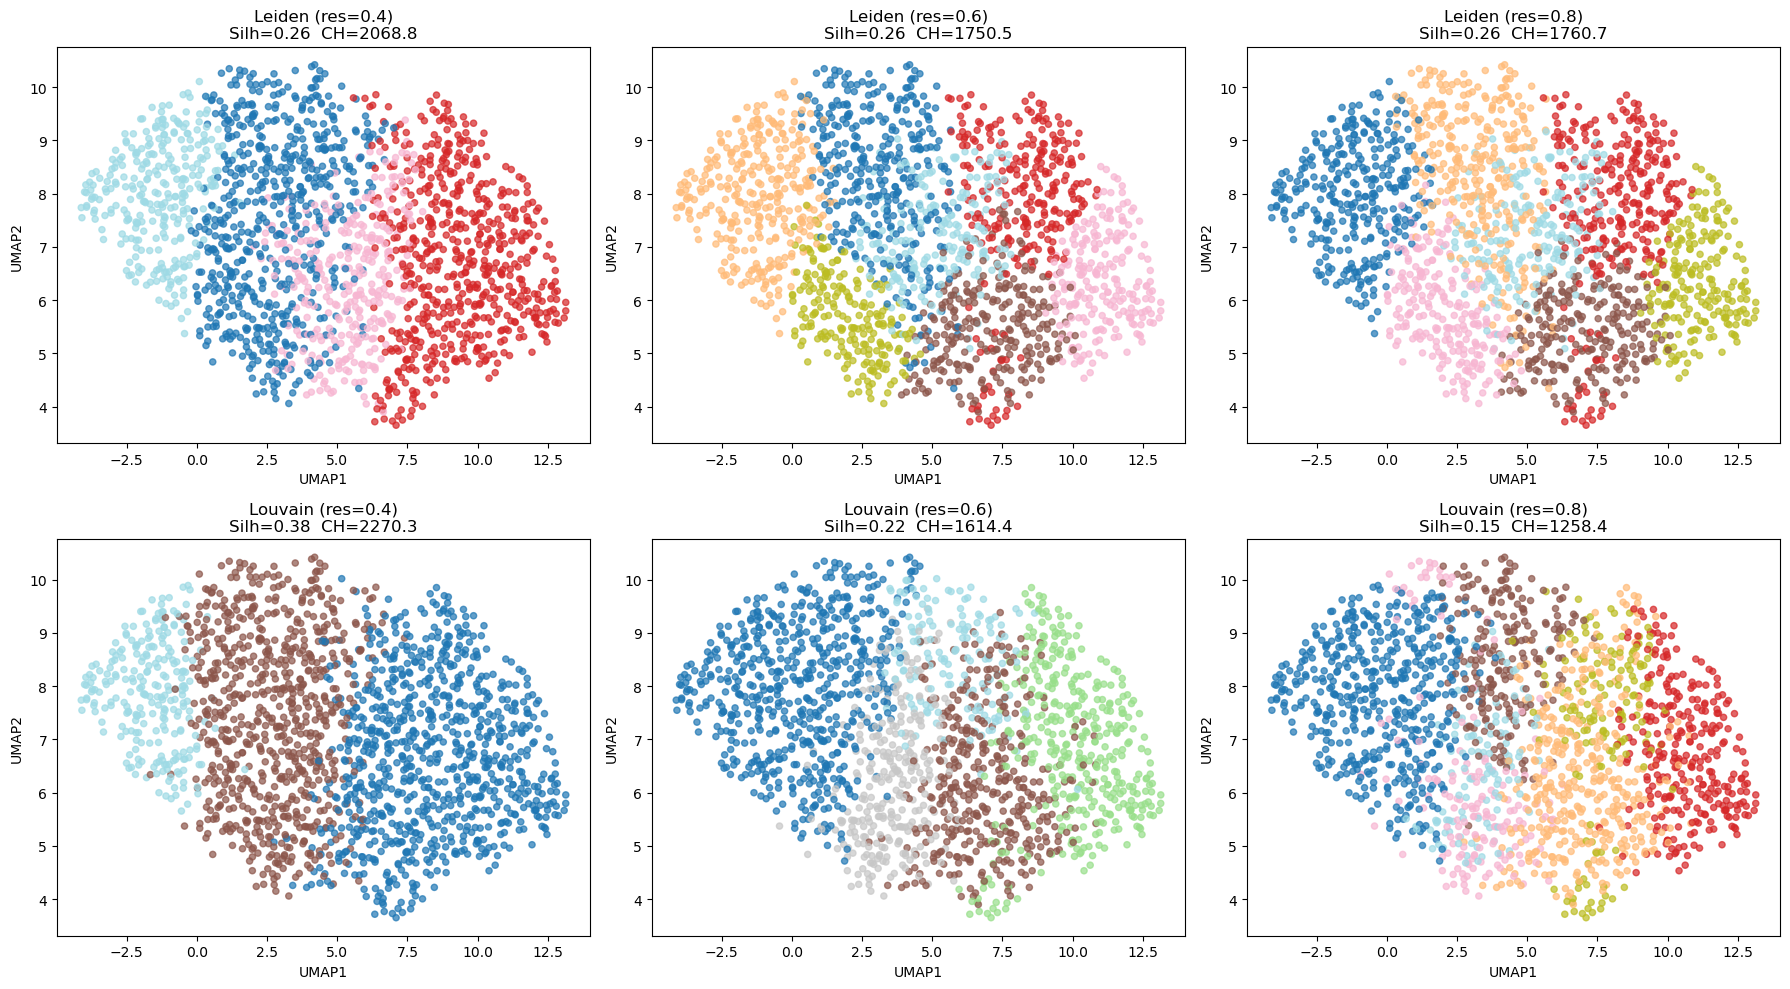

In [162]:
if not isinstance(X_data, torch.Tensor):
    X_data = torch.tensor(X_data, dtype=torch.float32)

# Latent representations
mu, log_var = vae_model.encode(X_data)
clustering_results = clustering_and_metrics(mu, X_data) #clustering

## Evaluation metrics

In [163]:
for result in clustering_results:
    print(result)

{'method': 'leiden', 'resolution': 0.4, 'n_clusters': 4, 'silhouette': 0.26418158, 'calinski_harabasz': 2068.811035395584}
{'method': 'leiden', 'resolution': 0.6, 'n_clusters': 7, 'silhouette': 0.25555158, 'calinski_harabasz': 1750.4845300894135}
{'method': 'leiden', 'resolution': 0.8, 'n_clusters': 7, 'silhouette': 0.2555849, 'calinski_harabasz': 1760.7343580169875}
{'method': 'louvain', 'resolution': 0.4, 'n_clusters': 3, 'silhouette': 0.38484988, 'calinski_harabasz': 2270.349488160752}
{'method': 'louvain', 'resolution': 0.6, 'n_clusters': 5, 'silhouette': 0.2223675, 'calinski_harabasz': 1614.4065008762805}
{'method': 'louvain', 'resolution': 0.8, 'n_clusters': 7, 'silhouette': 0.15278848, 'calinski_harabasz': 1258.3877077522002}


In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)', 
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE': [vae_mse, vae_pearson_corr, vae_latent_pvalue, vae_silhouette, vae_calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})


```{admonition} Calinski-Harabaz Index
The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, is a metric used to evaluate the quality of clustering results. It measures how well the clusters are separated and how compact they are. Specifically, it is the ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion. A higher Calinski-Harabasz score indicates better-defined clusters

The Calinski-Harabasz Index (CH) is defined as:

$$
\text{CH} = \frac{ \text{Tr}(B_k) / (k - 1) }{ \text{Tr}(W_k) / (n - k) }
$$

Where:  
- \( \text{Tr}(B_k) \) is the trace of the between-cluster dispersion matrix  
- \( \text{Tr}(W_k) \) is the trace of the within-cluster dispersion matrix  
- \( k \) is the number of clusters  
- \( n \) is the total number of data points
```

In [ ]:
metrics_df

Metric           VAE          PCA
0                               MSE      0.857137          NaN
1               Pearson Correlation     -0.001246          NaN
2  Latent Space Normality (p-value)      0.000000          NaN
3         Silhouette Score (DBSCAN)      0.828196     0.139134
4  Calinski-Harabasz Index (DBSCAN)  13501.244409  5360.274983

Prueba todas metrucas

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from scipy.stats import normaltest, pearsonr
import matplotlib.pyplot as plt

# ----- VAE MODEL -----
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim * 2, input_dim)
        self.fc_dec3 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec3(h))
        h = self.dropout(h)
        return self.fc_dec2(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# ----- ZINB LOSS -----
def zinb_loss(recon_x, x, mu, log_var, beta=1.0, theta=1.0):
    x = x.to_dense() if x.is_sparse else x
    recon_x = recon_x.to_dense() if recon_x.is_sparse else recon_x

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - 
                         torch.lgamma(theta_tensor) + x * torch.log(torch.clamp(recon_x, min=1e-8)) + 
                         theta_tensor * torch.log(theta_tensor / (torch.clamp(recon_x, min=1e-8))))

    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return nb_loss + beta * kl_loss, nb_loss, kl_loss

# ----- TRAINING LOOP -----
def train_model_vae(model, X, optimizer, num_epochs=200):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon, mu, log_var = model(X)
        loss, _, _ = zinb_loss(recon, X, mu, log_var)
        loss.backward()
        optimizer.step()

# ----- METRICS + CLUSTERING -----
def evaluate_model(model, X_data):
    model.eval()
    with torch.no_grad():
        recon, mu, log_var = model(X_data)
    mu_np = mu.cpu().numpy()
    X_np = X_data.cpu().numpy()
    recon_np = recon.cpu().numpy()

    # Métricas de reconstrucción
    mse = mean_squared_error(X_np.flatten(), recon_np.flatten())
    pearson_corr = pearsonr(X_np.flatten(), recon_np.flatten())[0]
    latent_normality_pval = normaltest(mu_np, axis=0).pvalue.mean()

    # Análisis de clusters
    adata_latent = sc.AnnData(X=mu_np)
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X")
    sc.tl.umap(adata_latent)

    methods = ["leiden", "louvain"]
    resolutions = [0.4, 0.6, 0.8]
    records = []

    for method in methods:
        for res in resolutions:
            key = f"{method}_r{res}"
            if method == "leiden":
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            if len(set(labels)) > 1:
                silh = silhouette_score(adata_latent.obsm["X_umap"], labels)
                ch = calinski_harabasz_score(adata_latent.obsm["X_umap"], labels)
            else:
                silh, ch = -1, -1

            records.append({
                "Metric": "Silhouette Score",
                "VAE": silh,
                "Method": method,
                "Resolution": res
            })
            records.append({
                "Metric": "Calinski-Harabasz Index",
                "VAE": ch,
                "Method": method,
                "Resolution": res
            })

    # Métricas generales
    records.extend([
        {"Metric": "MSE", "VAE": mse, "Method": None, "Resolution": None},
        {"Metric": "Pearson Correlation", "VAE": pearson_corr, "Method": None, "Resolution": None},
        {"Metric": "Latent Space Normality (p-value)", "VAE": latent_normality_pval, "Method": None, "Resolution": None}
    ])

    return pd.DataFrame(records)

# ----- EJECUCIÓN -----
# Cargar tus datos reales aquí
# Fix: Check for sparse matrix using hasattr and .todense(), else use as is
if hasattr(adata_filtered.X, "todense"):
    X_data = adata_filtered.X.todense()
else:
    X_data = adata_filtered.X
X_data_tensor = torch.tensor(X_data, dtype=torch.float32)

vae_model = VAE(input_dim=X_data_tensor.shape[1], hidden_dim=256, latent_dim=64)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
train_model_vae(vae_model, X_data_tensor, optimizer, num_epochs=200)

metrics_df = evaluate_model(vae_model, X_data_tensor)
print(metrics_df)


                              Metric          VAE   Method  Resolution
0                   Silhouette Score     0.360796   leiden         0.4
1            Calinski-Harabasz Index  2579.929926   leiden         0.4
2                   Silhouette Score     0.382903   leiden         0.6
3            Calinski-Harabasz Index  2725.917470   leiden         0.6
4                   Silhouette Score     0.333091   leiden         0.8
5            Calinski-Harabasz Index  2648.221566   leiden         0.8
6                   Silhouette Score     0.336724  louvain         0.4
7            Calinski-Harabasz Index  2365.809305  louvain         0.4
8                   Silhouette Score     0.347951  louvain         0.6
9            Calinski-Harabasz Index  2394.337141  louvain         0.6
10                  Silhouette Score     0.334769  louvain         0.8
11           Calinski-Harabasz Index  2580.002770  louvain         0.8
12                               MSE     3.194687     None         NaN
13    

## VAE + Attention

In [164]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
    
    def forward(self, x):
        attn_output, _ = self.attention_layer(x, x, x)
        return attn_output

In [165]:
class VAEAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAEAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.attn = Attention(hidden_dim)
        
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)
        
        self.fc_p0 = nn.Linear(latent_dim, input_dim)
        
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        
        h = h.unsqueeze(1)
        h = self.attn(h)
        h = h.squeeze(1)
        
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        p0 = torch.sigmoid(self.fc_p0(mu))
        return self.decode(z), mu, log_var, p0

In [166]:
#Loss functions 
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()
        else:
            x = torch.tensor(x, dtype=torch.float32)

    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()
        else:
            recon_x = torch.tensor(recon_x, dtype=torch.float32)

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - 
                         torch.lgamma(theta_tensor) + x * torch.log(torch.clamp(recon_x, min=1e-8) + 1e-8) + 
                         theta_tensor * torch.log(theta_tensor / (torch.clamp(recon_x, min=1e-8) + 1e-8)))

    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [167]:
#Function to train the model
def train_model_vae(model, X, optimizer, num_epochs, verbose=1):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}, NB Loss: {nb_loss.item():.4f}, "
                  f"Bernoulli Loss: {bernoulli_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}")

    return losses, nb_losses, bernoulli_losses, kl_losses

In [168]:
# Function to perform clustering and calculate metrics (Silhouette, Calinski, Pearson)
def clustering_and_metrics(X_data, mu):
    # Perform UMAP using sc.pp.neighbors and sc.tl.umap
    adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
    sc.tl.umap(adata_latent)
    umap_coords = adata_latent.obsm['X_umap']

    resolutions = [0.8, 1, 1.2]
    methods = ['leiden', 'louvain']
    clustering_results = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    i = 0

    for method in methods:
        for res in resolutions:
            key = f"{method}_r"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            n_clusters = len(set(labels))
            silh = silhouette_score(umap_coords, labels) if n_clusters > 1 else -1
            ch = calinski_harabasz_score(umap_coords, labels) if n_clusters > 1 else -1

            clustering_results.append({
                'method': method,
                'resolution': res,
                'n_clusters': n_clusters,
                'silhouette': silh,
                'calinski_harabasz': ch
            })

            axs[i].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
            axs[i].set_xlabel("UMAP1")
            axs[i].set_ylabel("UMAP2")
            i += 1

    plt.tight_layout()
    plt.show()

    return clustering_results

### Hyperparametrization of the model VAE + Attention

correr este

In [ ]:

def hyperparameter_tuning(X_data):
    # Hiperparámetros para probar
    param_grid = {
        'hidden_dim': [64, 128, 256],  # Dimensiones ocultas
        'latent_dim': [32, 64, 128],  # Dimensiones latentes
        'dropout_rate': [0.1, 0.3, 0.5],  # Tasa de abandono
        'learning_rate': [1e-3, 1e-4, 1e-5]  # Tasa de aprendizaje
    }
    
    grid = ParameterGrid(param_grid)
    
    best_metrics = {
        'best_loss': float('inf'),
        'best_params': None,
        'best_silhouette': -1,
        'best_calinski': -1,
        'best_pearson': -1
    }

    # Búsqueda de hiperparámetros
    for params in grid:
        print(f"Training with params: {params}")
        
        # Crear el modelo con los hiperparámetros actuales
        vae_model = VAEAttention(
            input_dim=X_data.shape[1],
            hidden_dim=params['hidden_dim'],
            latent_dim=params['latent_dim'],
            dropout_rate=params['dropout_rate']
        )
        optimizer = optim.Adam(vae_model.parameters(), lr=params['learning_rate'])
        
        # Convertir X_data a un tensor de PyTorch
        X_tensor = torch.tensor(X_data, dtype=torch.float32)

        # Entrenar el modelo
        num_epochs = 200
        vae_losses, vae_nb_losses, vae_kl_losses = train_model_vae(vae_model, X_tensor, optimizer, num_epochs)
        
        # Calcular las representaciones latentes
        X_tensor = torch.tensor(X_data, dtype=torch.float32)  # Ensure input is a PyTorch tensor
        vae_embeddings_umap = vae_model.encode(X_tensor)[0].detach().numpy()
        
        # Clustering con Louvain y Leiden
        adata = sc.AnnData(vae_embeddings_umap)
        sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
        sc.tl.leiden(adata, resolution=0.6)
        sc.tl.louvain(adata, resolution=0.6)

        # Obtener las etiquetas de los clústeres
        leiden_labels = adata.obs['leiden'].values
        louvain_labels = adata.obs['louvain'].values
        
        # Convertir las etiquetas a valores numéricos para el cálculo de Pearson
        le = LabelEncoder()
        leiden_labels = le.fit_transform(leiden_labels)
        louvain_labels = le.fit_transform(louvain_labels)
        
        # Calcular las métricas si hay al menos 2 clústeres
        if len(set(leiden_labels)) > 1:
            silhouette_leiden = silhouette_score(vae_embeddings_umap, leiden_labels)
            calinski_leiden = calinski_harabasz_score(vae_embeddings_umap, leiden_labels)
        else:
            silhouette_leiden = None
            calinski_leiden = None

        if len(set(louvain_labels)) > 1:
            silhouette_louvain = silhouette_score(vae_embeddings_umap, louvain_labels)
            calinski_louvain = calinski_harabasz_score(vae_embeddings_umap, louvain_labels)
        else:
            silhouette_louvain = None
            calinski_louvain = None
        
        # Pearson Correlation
        pearson_corr_leiden = np.corrcoef(vae_embeddings_umap.T, leiden_labels)[-1, :-1]
        pearson_corr_louvain = np.corrcoef(vae_embeddings_umap.T, louvain_labels)[-1, :-1]
        
        # Almacenar las mejores métricas
        if silhouette_leiden > best_metrics['best_silhouette']:
            best_metrics['best_silhouette'] = silhouette_leiden
            best_metrics['best_params'] = params
        if calinski_leiden > best_metrics['best_calinski']:
            best_metrics['best_calinski'] = calinski_leiden
        if pearson_corr_leiden[0] > best_metrics['best_pearson']:
            best_metrics['best_pearson'] = pearson_corr_leiden[0]
    
    return best_metrics

In [ ]:
X_data = adata_filtered.X  # Usa la matriz de datos filtrados
best_metrics = hyperparameter_tuning(X_data)
print(f"Best metrics: {best_metrics}")


Training with params: {'dropout_rate': 0.1, 'hidden_dim': 64, 'latent_dim': 32, 'learning_rate': 0.001}


C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36959336.0000, NB Loss: -36959724.0000, KL Loss: 389.4354
Epoch [2/200] - Loss: -36975420.0000, NB Loss: -36975740.0000, KL Loss: 319.1778
Epoch [3/200] - Loss: -36932504.0000, NB Loss: -36932760.0000, KL Loss: 254.4393
Epoch [4/200] - Loss: -36966088.0000, NB Loss: -36966304.0000, KL Loss: 215.2777
Epoch [5/200] - Loss: -36982944.0000, NB Loss: -36983128.0000, KL Loss: 182.6680
Epoch [6/200] - Loss: -37010232.0000, NB Loss: -37010384.0000, KL Loss: 152.4329
Epoch [7/200] - Loss: -36979876.0000, NB Loss: -36980000.0000, KL Loss: 124.9227
Epoch [8/200] - Loss: -36960720.0000, NB Loss: -36960824.0000, KL Loss: 102.6544
Epoch [9/200] - Loss: -37011788.0000, NB Loss: -37011872.0000, KL Loss: 83.1583
Epoch [10/200] - Loss: -36959456.0000, NB Loss: -36959524.0000, KL Loss: 67.9292
Epoch [11/200] - Loss: -36992560.0000, NB Loss: -36992616.0000, KL Loss: 54.4837
Epoch [12/200] - Loss: -36965268.0000, NB Loss: -36965312.0000, KL Loss: 43.4537
Epoch [13/200] - Loss: -37005

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36686280.0000, NB Loss: -36686604.0000, KL Loss: 322.2797
Epoch [3/200] - Loss: -36635344.0000, NB Loss: -36635656.0000, KL Loss: 311.4439
Epoch [4/200] - Loss: -36718880.0000, NB Loss: -36719180.0000, KL Loss: 300.4113
Epoch [5/200] - Loss: -36678036.0000, NB Loss: -36678324.0000, KL Loss: 289.7425
Epoch [6/200] - Loss: -36674776.0000, NB Loss: -36675056.0000, KL Loss: 281.9919
Epoch [7/200] - Loss: -36717440.0000, NB Loss: -36717712.0000, KL Loss: 272.2456
Epoch [8/200] - Loss: -36684488.0000, NB Loss: -36684752.0000, KL Loss: 265.3392
Epoch [9/200] - Loss: -36666372.0000, NB Loss: -36666628.0000, KL Loss: 256.5215
Epoch [10/200] - Loss: -36682564.0000, NB Loss: -36682816.0000, KL Loss: 250.5311
Epoch [11/200] - Loss: -36660720.0000, NB Loss: -36660964.0000, KL Loss: 242.4711
Epoch [12/200] - Loss: -36672364.0000, NB Loss: -36672600.0000, KL Loss: 236.0326
Epoch [13/200] - Loss: -36670800.0000, NB Loss: -36671028.0000, KL Loss: 229.7767
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -37176056.0000, NB Loss: -37176452.0000, KL Loss: 395.3268
Epoch [3/200] - Loss: -37179172.0000, NB Loss: -37179568.0000, KL Loss: 395.0875
Epoch [4/200] - Loss: -37195868.0000, NB Loss: -37196264.0000, KL Loss: 395.3226
Epoch [5/200] - Loss: -37179344.0000, NB Loss: -37179736.0000, KL Loss: 391.7863
Epoch [6/200] - Loss: -37172080.0000, NB Loss: -37172472.0000, KL Loss: 392.2875
Epoch [7/200] - Loss: -37186932.0000, NB Loss: -37187324.0000, KL Loss: 390.2492
Epoch [8/200] - Loss: -37188476.0000, NB Loss: -37188864.0000, KL Loss: 387.6492
Epoch [9/200] - Loss: -37226096.0000, NB Loss: -37226484.0000, KL Loss: 389.2631
Epoch [10/200] - Loss: -37208600.0000, NB Loss: -37208984.0000, KL Loss: 385.9763
Epoch [11/200] - Loss: -37173484.0000, NB Loss: -37173868.0000, KL Loss: 383.2116
Epoch [12/200] - Loss: -37171148.0000, NB Loss: -37171528.0000, KL Loss: 381.7916
Epoch [13/200] - Loss: -37156440.0000, NB Loss: -37156820.0000, KL Loss: 380.8313
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -37183012.0000, NB Loss: -37183708.0000, KL Loss: 695.7257
Epoch [3/200] - Loss: -37197812.0000, NB Loss: -37198400.0000, KL Loss: 586.7236
Epoch [4/200] - Loss: -37183204.0000, NB Loss: -37183708.0000, KL Loss: 504.6792
Epoch [5/200] - Loss: -37169224.0000, NB Loss: -37169656.0000, KL Loss: 433.0050
Epoch [6/200] - Loss: -37160140.0000, NB Loss: -37160512.0000, KL Loss: 370.4864
Epoch [7/200] - Loss: -37173008.0000, NB Loss: -37173316.0000, KL Loss: 309.5573
Epoch [8/200] - Loss: -37198680.0000, NB Loss: -37198932.0000, KL Loss: 253.3620
Epoch [9/200] - Loss: -37221384.0000, NB Loss: -37221592.0000, KL Loss: 209.2361
Epoch [10/200] - Loss: -37168544.0000, NB Loss: -37168716.0000, KL Loss: 173.2789
Epoch [11/200] - Loss: -37218604.0000, NB Loss: -37218752.0000, KL Loss: 146.6533
Epoch [12/200] - Loss: -37209152.0000, NB Loss: -37209272.0000, KL Loss: 118.8448
Epoch [13/200] - Loss: -37148996.0000, NB Loss: -37149096.0000, KL Loss: 98.0269
Epoch [14/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36761064.0000, NB Loss: -36761872.0000, KL Loss: 806.3406
Epoch [3/200] - Loss: -36748692.0000, NB Loss: -36749476.0000, KL Loss: 784.2989
Epoch [4/200] - Loss: -36730892.0000, NB Loss: -36731656.0000, KL Loss: 762.4401
Epoch [5/200] - Loss: -36750796.0000, NB Loss: -36751540.0000, KL Loss: 743.5288
Epoch [6/200] - Loss: -36735048.0000, NB Loss: -36735772.0000, KL Loss: 724.3303
Epoch [7/200] - Loss: -36776432.0000, NB Loss: -36777140.0000, KL Loss: 708.3036
Epoch [8/200] - Loss: -36732308.0000, NB Loss: -36733000.0000, KL Loss: 692.1501
Epoch [9/200] - Loss: -36742828.0000, NB Loss: -36743504.0000, KL Loss: 676.6014
Epoch [10/200] - Loss: -36731468.0000, NB Loss: -36732128.0000, KL Loss: 661.5889
Epoch [11/200] - Loss: -36738628.0000, NB Loss: -36739276.0000, KL Loss: 649.1663
Epoch [12/200] - Loss: -36711632.0000, NB Loss: -36712268.0000, KL Loss: 636.8444
Epoch [13/200] - Loss: -36745760.0000, NB Loss: -36746384.0000, KL Loss: 624.1744
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36604088.0000, NB Loss: -36604952.0000, KL Loss: 862.3697
Epoch [3/200] - Loss: -36565928.0000, NB Loss: -36566784.0000, KL Loss: 856.9920
Epoch [4/200] - Loss: -36574452.0000, NB Loss: -36575308.0000, KL Loss: 855.4233
Epoch [5/200] - Loss: -36574156.0000, NB Loss: -36575004.0000, KL Loss: 847.6881
Epoch [6/200] - Loss: -36617200.0000, NB Loss: -36618044.0000, KL Loss: 845.2341
Epoch [7/200] - Loss: -36578132.0000, NB Loss: -36578976.0000, KL Loss: 844.0247
Epoch [8/200] - Loss: -36592508.0000, NB Loss: -36593348.0000, KL Loss: 839.0811
Epoch [9/200] - Loss: -36586592.0000, NB Loss: -36587436.0000, KL Loss: 842.3923
Epoch [10/200] - Loss: -36560432.0000, NB Loss: -36561268.0000, KL Loss: 836.7236
Epoch [11/200] - Loss: -36551212.0000, NB Loss: -36552048.0000, KL Loss: 836.8600
Epoch [12/200] - Loss: -36573096.0000, NB Loss: -36573928.0000, KL Loss: 830.4618
Epoch [13/200] - Loss: -36565572.0000, NB Loss: -36566400.0000, KL Loss: 827.7125
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36643468.0000, NB Loss: -36644800.0000, KL Loss: 1330.7808
Epoch [3/200] - Loss: -36610404.0000, NB Loss: -36611524.0000, KL Loss: 1119.6215
Epoch [4/200] - Loss: -36641860.0000, NB Loss: -36642864.0000, KL Loss: 1004.8732
Epoch [5/200] - Loss: -36650724.0000, NB Loss: -36651616.0000, KL Loss: 893.5007
Epoch [6/200] - Loss: -36644456.0000, NB Loss: -36645256.0000, KL Loss: 799.7104
Epoch [7/200] - Loss: -36645328.0000, NB Loss: -36646040.0000, KL Loss: 711.9657
Epoch [8/200] - Loss: -36637056.0000, NB Loss: -36637684.0000, KL Loss: 626.6219
Epoch [9/200] - Loss: -36702556.0000, NB Loss: -36703100.0000, KL Loss: 544.3791
Epoch [10/200] - Loss: -36697600.0000, NB Loss: -36698064.0000, KL Loss: 462.8042
Epoch [11/200] - Loss: -36662312.0000, NB Loss: -36662704.0000, KL Loss: 391.0005
Epoch [12/200] - Loss: -36705152.0000, NB Loss: -36705484.0000, KL Loss: 332.2376
Epoch [13/200] - Loss: -36702024.0000, NB Loss: -36702304.0000, KL Loss: 279.5280
Epoch [14/200] - Loss

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36970768.0000, NB Loss: -36972316.0000, KL Loss: 1548.0315
Epoch [2/200] - Loss: -36963952.0000, NB Loss: -36965448.0000, KL Loss: 1496.9203
Epoch [3/200] - Loss: -36972880.0000, NB Loss: -36974340.0000, KL Loss: 1461.9469
Epoch [4/200] - Loss: -36978312.0000, NB Loss: -36979736.0000, KL Loss: 1422.5022
Epoch [5/200] - Loss: -36974456.0000, NB Loss: -36975848.0000, KL Loss: 1392.4760
Epoch [6/200] - Loss: -36967484.0000, NB Loss: -36968844.0000, KL Loss: 1359.7827
Epoch [7/200] - Loss: -36972100.0000, NB Loss: -36973436.0000, KL Loss: 1334.8523
Epoch [8/200] - Loss: -36946904.0000, NB Loss: -36948212.0000, KL Loss: 1308.2373
Epoch [9/200] - Loss: -36976148.0000, NB Loss: -36977432.0000, KL Loss: 1282.4640
Epoch [10/200] - Loss: -36961068.0000, NB Loss: -36962320.0000, KL Loss: 1253.4375
Epoch [11/200] - Loss: -36971368.0000, NB Loss: -36972604.0000, KL Loss: 1236.9130
Epoch [12/200] - Loss: -36982720.0000, NB Loss: -36983928.0000, KL Loss: 1209.7225
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36863320.0000, NB Loss: -36864928.0000, KL Loss: 1606.2095
Epoch [2/200] - Loss: -36858296.0000, NB Loss: -36859896.0000, KL Loss: 1601.6143
Epoch [3/200] - Loss: -36859600.0000, NB Loss: -36861200.0000, KL Loss: 1598.0743
Epoch [4/200] - Loss: -36864304.0000, NB Loss: -36865896.0000, KL Loss: 1592.0715
Epoch [5/200] - Loss: -36875884.0000, NB Loss: -36877472.0000, KL Loss: 1588.5277
Epoch [6/200] - Loss: -36860320.0000, NB Loss: -36861904.0000, KL Loss: 1584.9840
Epoch [7/200] - Loss: -36853892.0000, NB Loss: -36855464.0000, KL Loss: 1573.6702
Epoch [8/200] - Loss: -36876512.0000, NB Loss: -36878080.0000, KL Loss: 1568.6464
Epoch [9/200] - Loss: -36864640.0000, NB Loss: -36866212.0000, KL Loss: 1570.0156
Epoch [10/200] - Loss: -36865544.0000, NB Loss: -36867104.0000, KL Loss: 1561.8508
Epoch [11/200] - Loss: -36842244.0000, NB Loss: -36843800.0000, KL Loss: 1557.6843
Epoch [12/200] - Loss: -36857548.0000, NB Loss: -36859100.0000, KL Loss: 1552.9241
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36979368.0000, NB Loss: -36979644.0000, KL Loss: 275.3027
Epoch [2/200] - Loss: -36998056.0000, NB Loss: -36998240.0000, KL Loss: 185.6571
Epoch [3/200] - Loss: -37003116.0000, NB Loss: -37003236.0000, KL Loss: 121.3869
Epoch [4/200] - Loss: -37016704.0000, NB Loss: -37016788.0000, KL Loss: 84.2451
Epoch [5/200] - Loss: -37049832.0000, NB Loss: -37049896.0000, KL Loss: 62.5807
Epoch [6/200] - Loss: -37044192.0000, NB Loss: -37044244.0000, KL Loss: 50.0704
Epoch [7/200] - Loss: -36987708.0000, NB Loss: -36987744.0000, KL Loss: 34.3389
Epoch [8/200] - Loss: -37028012.0000, NB Loss: -37028040.0000, KL Loss: 26.6556
Epoch [9/200] - Loss: -37003480.0000, NB Loss: -37003504.0000, KL Loss: 23.7831
Epoch [10/200] - Loss: -37010268.0000, NB Loss: -37010288.0000, KL Loss: 18.9976
Epoch [11/200] - Loss: -37053196.0000, NB Loss: -37053212.0000, KL Loss: 17.1457
Epoch [12/200] - Loss: -36998696.0000, NB Loss: -36998708.0000, KL Loss: 13.5350
Epoch [13/200] - Loss: -36979684.0

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37002324.0000, NB Loss: -37002616.0000, KL Loss: 293.3873
Epoch [2/200] - Loss: -36978336.0000, NB Loss: -36978612.0000, KL Loss: 277.3251
Epoch [3/200] - Loss: -36985092.0000, NB Loss: -36985352.0000, KL Loss: 261.0707
Epoch [4/200] - Loss: -36995272.0000, NB Loss: -36995520.0000, KL Loss: 247.2322
Epoch [5/200] - Loss: -37043204.0000, NB Loss: -37043440.0000, KL Loss: 236.3214
Epoch [6/200] - Loss: -37000852.0000, NB Loss: -37001076.0000, KL Loss: 223.0515
Epoch [7/200] - Loss: -36993812.0000, NB Loss: -36994024.0000, KL Loss: 212.3163
Epoch [8/200] - Loss: -37030156.0000, NB Loss: -37030356.0000, KL Loss: 201.8944
Epoch [9/200] - Loss: -37018256.0000, NB Loss: -37018448.0000, KL Loss: 192.3733
Epoch [10/200] - Loss: -37002232.0000, NB Loss: -37002416.0000, KL Loss: 184.6787
Epoch [11/200] - Loss: -36967328.0000, NB Loss: -36967504.0000, KL Loss: 175.1750
Epoch [12/200] - Loss: -36990616.0000, NB Loss: -36990784.0000, KL Loss: 167.5898
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37053480.0000, NB Loss: -37053748.0000, KL Loss: 268.9510
Epoch [2/200] - Loss: -37048956.0000, NB Loss: -37049224.0000, KL Loss: 268.1970
Epoch [3/200] - Loss: -37022988.0000, NB Loss: -37023252.0000, KL Loss: 264.6794
Epoch [4/200] - Loss: -37049988.0000, NB Loss: -37050252.0000, KL Loss: 262.5302
Epoch [5/200] - Loss: -37079712.0000, NB Loss: -37079972.0000, KL Loss: 261.8692
Epoch [6/200] - Loss: -37057444.0000, NB Loss: -37057708.0000, KL Loss: 262.0772
Epoch [7/200] - Loss: -37035780.0000, NB Loss: -37036040.0000, KL Loss: 260.2650
Epoch [8/200] - Loss: -37067836.0000, NB Loss: -37068092.0000, KL Loss: 257.9736
Epoch [9/200] - Loss: -37027804.0000, NB Loss: -37028060.0000, KL Loss: 256.3028
Epoch [10/200] - Loss: -37022268.0000, NB Loss: -37022524.0000, KL Loss: 255.0650
Epoch [11/200] - Loss: -37020384.0000, NB Loss: -37020636.0000, KL Loss: 252.2781
Epoch [12/200] - Loss: -37073548.0000, NB Loss: -37073800.0000, KL Loss: 251.3461
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37078584.0000, NB Loss: -37079136.0000, KL Loss: 551.8646
Epoch [2/200] - Loss: -37099104.0000, NB Loss: -37099516.0000, KL Loss: 413.0382
Epoch [3/200] - Loss: -37044076.0000, NB Loss: -37044368.0000, KL Loss: 291.7553
Epoch [4/200] - Loss: -37043140.0000, NB Loss: -37043356.0000, KL Loss: 217.7537
Epoch [5/200] - Loss: -37040096.0000, NB Loss: -37040260.0000, KL Loss: 163.7780
Epoch [6/200] - Loss: -37038568.0000, NB Loss: -37038692.0000, KL Loss: 123.7159
Epoch [7/200] - Loss: -37071804.0000, NB Loss: -37071900.0000, KL Loss: 95.3914
Epoch [8/200] - Loss: -37081300.0000, NB Loss: -37081376.0000, KL Loss: 75.5435
Epoch [9/200] - Loss: -37080592.0000, NB Loss: -37080648.0000, KL Loss: 57.2513
Epoch [10/200] - Loss: -37070596.0000, NB Loss: -37070640.0000, KL Loss: 45.5048
Epoch [11/200] - Loss: -37056228.0000, NB Loss: -37056264.0000, KL Loss: 37.7415
Epoch [12/200] - Loss: -37069792.0000, NB Loss: -37069824.0000, KL Loss: 33.7011
Epoch [13/200] - Loss: -3709073

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36894820.0000, NB Loss: -36895396.0000, KL Loss: 574.8071
Epoch [2/200] - Loss: -36889380.0000, NB Loss: -36889924.0000, KL Loss: 544.4764
Epoch [3/200] - Loss: -36898644.0000, NB Loss: -36899160.0000, KL Loss: 517.0771
Epoch [4/200] - Loss: -36893676.0000, NB Loss: -36894172.0000, KL Loss: 494.8790
Epoch [5/200] - Loss: -36888864.0000, NB Loss: -36889340.0000, KL Loss: 476.0670
Epoch [6/200] - Loss: -36911168.0000, NB Loss: -36911624.0000, KL Loss: 454.4025
Epoch [7/200] - Loss: -36913200.0000, NB Loss: -36913640.0000, KL Loss: 438.0471
Epoch [8/200] - Loss: -36909788.0000, NB Loss: -36910208.0000, KL Loss: 421.5705
Epoch [9/200] - Loss: -36876956.0000, NB Loss: -36877364.0000, KL Loss: 406.2444
Epoch [10/200] - Loss: -36885420.0000, NB Loss: -36885812.0000, KL Loss: 391.4543
Epoch [11/200] - Loss: -36902068.0000, NB Loss: -36902444.0000, KL Loss: 376.1746
Epoch [12/200] - Loss: -36898788.0000, NB Loss: -36899152.0000, KL Loss: 364.5131
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37243508.0000, NB Loss: -37244028.0000, KL Loss: 519.7781
Epoch [2/200] - Loss: -37234880.0000, NB Loss: -37235396.0000, KL Loss: 514.7888
Epoch [3/200] - Loss: -37247928.0000, NB Loss: -37248436.0000, KL Loss: 509.4520
Epoch [4/200] - Loss: -37279656.0000, NB Loss: -37280164.0000, KL Loss: 509.2882
Epoch [5/200] - Loss: -37260968.0000, NB Loss: -37261476.0000, KL Loss: 506.2607
Epoch [6/200] - Loss: -37266152.0000, NB Loss: -37266656.0000, KL Loss: 503.0334
Epoch [7/200] - Loss: -37231680.0000, NB Loss: -37232180.0000, KL Loss: 499.1807
Epoch [8/200] - Loss: -37260772.0000, NB Loss: -37261272.0000, KL Loss: 499.4126
Epoch [9/200] - Loss: -37201016.0000, NB Loss: -37201512.0000, KL Loss: 495.4286
Epoch [10/200] - Loss: -37257096.0000, NB Loss: -37257592.0000, KL Loss: 494.9331
Epoch [11/200] - Loss: -37244700.0000, NB Loss: -37245188.0000, KL Loss: 489.3193
Epoch [12/200] - Loss: -37229728.0000, NB Loss: -37230216.0000, KL Loss: 489.5265
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37334388.0000, NB Loss: -37335524.0000, KL Loss: 1137.4503
Epoch [2/200] - Loss: -37342504.0000, NB Loss: -37343372.0000, KL Loss: 866.2921
Epoch [3/200] - Loss: -37353760.0000, NB Loss: -37354408.0000, KL Loss: 646.7712
Epoch [4/200] - Loss: -37355680.0000, NB Loss: -37356188.0000, KL Loss: 508.5591
Epoch [5/200] - Loss: -37302388.0000, NB Loss: -37302792.0000, KL Loss: 403.1414
Epoch [6/200] - Loss: -37345344.0000, NB Loss: -37345656.0000, KL Loss: 311.9821
Epoch [7/200] - Loss: -37347324.0000, NB Loss: -37347564.0000, KL Loss: 241.7798
Epoch [8/200] - Loss: -37336748.0000, NB Loss: -37336936.0000, KL Loss: 188.1355
Epoch [9/200] - Loss: -37378808.0000, NB Loss: -37378952.0000, KL Loss: 142.2746
Epoch [10/200] - Loss: -37378052.0000, NB Loss: -37378164.0000, KL Loss: 111.7574
Epoch [11/200] - Loss: -37384580.0000, NB Loss: -37384692.0000, KL Loss: 112.9952
Epoch [12/200] - Loss: -37370608.0000, NB Loss: -37370684.0000, KL Loss: 76.7303
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37233956.0000, NB Loss: -37235044.0000, KL Loss: 1086.9817
Epoch [2/200] - Loss: -37255624.0000, NB Loss: -37256664.0000, KL Loss: 1038.4049
Epoch [3/200] - Loss: -37230512.0000, NB Loss: -37231508.0000, KL Loss: 996.4976
Epoch [4/200] - Loss: -37265436.0000, NB Loss: -37266392.0000, KL Loss: 955.7863
Epoch [5/200] - Loss: -37274328.0000, NB Loss: -37275248.0000, KL Loss: 920.2252
Epoch [6/200] - Loss: -37251160.0000, NB Loss: -37252044.0000, KL Loss: 884.5312
Epoch [7/200] - Loss: -37245596.0000, NB Loss: -37246448.0000, KL Loss: 852.2799
Epoch [8/200] - Loss: -37236440.0000, NB Loss: -37237264.0000, KL Loss: 823.1351
Epoch [9/200] - Loss: -37227164.0000, NB Loss: -37227960.0000, KL Loss: 795.5090
Epoch [10/200] - Loss: -37257116.0000, NB Loss: -37257888.0000, KL Loss: 773.0674
Epoch [11/200] - Loss: -37238304.0000, NB Loss: -37239048.0000, KL Loss: 744.8969
Epoch [12/200] - Loss: -37191164.0000, NB Loss: -37191884.0000, KL Loss: 720.3022
Epoch [13/200] - Loss: 

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36822564.0000, NB Loss: -36823668.0000, KL Loss: 1105.1160
Epoch [2/200] - Loss: -36804000.0000, NB Loss: -36805100.0000, KL Loss: 1099.8280
Epoch [3/200] - Loss: -36784728.0000, NB Loss: -36785820.0000, KL Loss: 1092.2610
Epoch [4/200] - Loss: -36846032.0000, NB Loss: -36847120.0000, KL Loss: 1086.5554
Epoch [5/200] - Loss: -36815632.0000, NB Loss: -36816716.0000, KL Loss: 1082.7501
Epoch [6/200] - Loss: -36806644.0000, NB Loss: -36807724.0000, KL Loss: 1079.9109
Epoch [7/200] - Loss: -36779028.0000, NB Loss: -36780104.0000, KL Loss: 1075.0884
Epoch [8/200] - Loss: -36801716.0000, NB Loss: -36802784.0000, KL Loss: 1069.8708
Epoch [9/200] - Loss: -36823516.0000, NB Loss: -36824580.0000, KL Loss: 1063.4744
Epoch [10/200] - Loss: -36819652.0000, NB Loss: -36820712.0000, KL Loss: 1059.5566
Epoch [11/200] - Loss: -36814516.0000, NB Loss: -36815572.0000, KL Loss: 1055.2532
Epoch [12/200] - Loss: -36794572.0000, NB Loss: -36795624.0000, KL Loss: 1050.0408
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36822500.0000, NB Loss: -36822720.0000, KL Loss: 218.7683
Epoch [2/200] - Loss: -36855464.0000, NB Loss: -36855616.0000, KL Loss: 150.4917
Epoch [3/200] - Loss: -36836616.0000, NB Loss: -36836696.0000, KL Loss: 81.9977
Epoch [4/200] - Loss: -36842556.0000, NB Loss: -36842616.0000, KL Loss: 61.1388
Epoch [5/200] - Loss: -36797180.0000, NB Loss: -36797216.0000, KL Loss: 36.7856
Epoch [6/200] - Loss: -36845716.0000, NB Loss: -36845744.0000, KL Loss: 28.1134
Epoch [7/200] - Loss: -36858100.0000, NB Loss: -36858120.0000, KL Loss: 21.5364
Epoch [8/200] - Loss: -36811428.0000, NB Loss: -36811444.0000, KL Loss: 15.5478
Epoch [9/200] - Loss: -36824500.0000, NB Loss: -36824512.0000, KL Loss: 12.0739
Epoch [10/200] - Loss: -36812576.0000, NB Loss: -36812584.0000, KL Loss: 9.3797
Epoch [11/200] - Loss: -36833564.0000, NB Loss: -36833572.0000, KL Loss: 7.3002
Epoch [12/200] - Loss: -36857512.0000, NB Loss: -36857516.0000, KL Loss: 5.7371
Epoch [13/200] - Loss: -36833144.0000,

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36908624.0000, NB Loss: -36908848.0000, KL Loss: 225.1353
Epoch [2/200] - Loss: -36948260.0000, NB Loss: -36948464.0000, KL Loss: 203.3966
Epoch [3/200] - Loss: -36942928.0000, NB Loss: -36943112.0000, KL Loss: 184.0163
Epoch [4/200] - Loss: -36929648.0000, NB Loss: -36929816.0000, KL Loss: 167.2865
Epoch [5/200] - Loss: -36936360.0000, NB Loss: -36936512.0000, KL Loss: 152.2914
Epoch [6/200] - Loss: -36923460.0000, NB Loss: -36923600.0000, KL Loss: 139.8664
Epoch [7/200] - Loss: -36931504.0000, NB Loss: -36931632.0000, KL Loss: 127.4858
Epoch [8/200] - Loss: -36884104.0000, NB Loss: -36884220.0000, KL Loss: 116.9555
Epoch [9/200] - Loss: -36966368.0000, NB Loss: -36966476.0000, KL Loss: 106.8830
Epoch [10/200] - Loss: -36929464.0000, NB Loss: -36929564.0000, KL Loss: 98.3628
Epoch [11/200] - Loss: -36942996.0000, NB Loss: -36943084.0000, KL Loss: 89.8649
Epoch [12/200] - Loss: -36939876.0000, NB Loss: -36939960.0000, KL Loss: 82.3331
Epoch [13/200] - Loss: -3692

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37156480.0000, NB Loss: -37156696.0000, KL Loss: 216.5884
Epoch [2/200] - Loss: -37174144.0000, NB Loss: -37174356.0000, KL Loss: 213.8798
Epoch [3/200] - Loss: -37194044.0000, NB Loss: -37194256.0000, KL Loss: 210.3730
Epoch [4/200] - Loss: -37154448.0000, NB Loss: -37154656.0000, KL Loss: 209.5536
Epoch [5/200] - Loss: -37163716.0000, NB Loss: -37163924.0000, KL Loss: 206.3290
Epoch [6/200] - Loss: -37166472.0000, NB Loss: -37166676.0000, KL Loss: 204.7288
Epoch [7/200] - Loss: -37182376.0000, NB Loss: -37182576.0000, KL Loss: 201.6649
Epoch [8/200] - Loss: -37180092.0000, NB Loss: -37180292.0000, KL Loss: 199.4582
Epoch [9/200] - Loss: -37188084.0000, NB Loss: -37188280.0000, KL Loss: 197.4983
Epoch [10/200] - Loss: -37167820.0000, NB Loss: -37168016.0000, KL Loss: 196.3278
Epoch [11/200] - Loss: -37187472.0000, NB Loss: -37187664.0000, KL Loss: 193.1187
Epoch [12/200] - Loss: -37188632.0000, NB Loss: -37188824.0000, KL Loss: 193.0532
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36942816.0000, NB Loss: -36943244.0000, KL Loss: 429.1305
Epoch [2/200] - Loss: -36943380.0000, NB Loss: -36943680.0000, KL Loss: 299.0829
Epoch [3/200] - Loss: -36975768.0000, NB Loss: -36975928.0000, KL Loss: 161.5797
Epoch [4/200] - Loss: -36984260.0000, NB Loss: -36984376.0000, KL Loss: 115.1591
Epoch [5/200] - Loss: -36929540.0000, NB Loss: -36929636.0000, KL Loss: 96.4503
Epoch [6/200] - Loss: -36968628.0000, NB Loss: -36968688.0000, KL Loss: 61.6339
Epoch [7/200] - Loss: -36924032.0000, NB Loss: -36924088.0000, KL Loss: 55.6836
Epoch [8/200] - Loss: -36926528.0000, NB Loss: -36926568.0000, KL Loss: 39.7852
Epoch [9/200] - Loss: -36929752.0000, NB Loss: -36929788.0000, KL Loss: 34.5110
Epoch [10/200] - Loss: -36934700.0000, NB Loss: -36934724.0000, KL Loss: 24.8938
Epoch [11/200] - Loss: -36942336.0000, NB Loss: -36942356.0000, KL Loss: 20.7854
Epoch [12/200] - Loss: -36922744.0000, NB Loss: -36922760.0000, KL Loss: 16.3634
Epoch [13/200] - Loss: -36920956.

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37012484.0000, NB Loss: -37012920.0000, KL Loss: 434.6256
Epoch [2/200] - Loss: -36958120.0000, NB Loss: -36958516.0000, KL Loss: 395.4162
Epoch [3/200] - Loss: -36958328.0000, NB Loss: -36958692.0000, KL Loss: 365.0291
Epoch [4/200] - Loss: -37007588.0000, NB Loss: -37007928.0000, KL Loss: 338.5017
Epoch [5/200] - Loss: -36968360.0000, NB Loss: -36968672.0000, KL Loss: 312.7920
Epoch [6/200] - Loss: -36975460.0000, NB Loss: -36975752.0000, KL Loss: 293.0274
Epoch [7/200] - Loss: -36965336.0000, NB Loss: -36965608.0000, KL Loss: 272.9103
Epoch [8/200] - Loss: -36986692.0000, NB Loss: -36986948.0000, KL Loss: 254.3063
Epoch [9/200] - Loss: -36994656.0000, NB Loss: -36994896.0000, KL Loss: 238.2108
Epoch [10/200] - Loss: -36991408.0000, NB Loss: -36991628.0000, KL Loss: 221.2132
Epoch [11/200] - Loss: -36972968.0000, NB Loss: -36973176.0000, KL Loss: 208.2728
Epoch [12/200] - Loss: -36974684.0000, NB Loss: -36974880.0000, KL Loss: 194.2056
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37088116.0000, NB Loss: -37088548.0000, KL Loss: 432.8321
Epoch [2/200] - Loss: -37103216.0000, NB Loss: -37103644.0000, KL Loss: 429.5724
Epoch [3/200] - Loss: -37121928.0000, NB Loss: -37122352.0000, KL Loss: 425.2057
Epoch [4/200] - Loss: -37125668.0000, NB Loss: -37126088.0000, KL Loss: 420.7958
Epoch [5/200] - Loss: -37146572.0000, NB Loss: -37146992.0000, KL Loss: 419.3728
Epoch [6/200] - Loss: -37151160.0000, NB Loss: -37151576.0000, KL Loss: 415.2615
Epoch [7/200] - Loss: -37102044.0000, NB Loss: -37102452.0000, KL Loss: 409.1468
Epoch [8/200] - Loss: -37094332.0000, NB Loss: -37094736.0000, KL Loss: 405.6038
Epoch [9/200] - Loss: -37119520.0000, NB Loss: -37119924.0000, KL Loss: 404.2827
Epoch [10/200] - Loss: -37121840.0000, NB Loss: -37122240.0000, KL Loss: 400.6354
Epoch [11/200] - Loss: -37084728.0000, NB Loss: -37085124.0000, KL Loss: 397.1771
Epoch [12/200] - Loss: -37137488.0000, NB Loss: -37137880.0000, KL Loss: 393.3037
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36818712.0000, NB Loss: -36819572.0000, KL Loss: 861.2687
Epoch [2/200] - Loss: -36840796.0000, NB Loss: -36841404.0000, KL Loss: 606.5296
Epoch [3/200] - Loss: -36847284.0000, NB Loss: -36847668.0000, KL Loss: 383.5421
Epoch [4/200] - Loss: -36886124.0000, NB Loss: -36886380.0000, KL Loss: 256.2657
Epoch [5/200] - Loss: -36868048.0000, NB Loss: -36868224.0000, KL Loss: 175.4943
Epoch [6/200] - Loss: -36855788.0000, NB Loss: -36855936.0000, KL Loss: 147.8574
Epoch [7/200] - Loss: -36830572.0000, NB Loss: -36830696.0000, KL Loss: 125.8296
Epoch [8/200] - Loss: -36876812.0000, NB Loss: -36876900.0000, KL Loss: 88.7723
Epoch [9/200] - Loss: -36860964.0000, NB Loss: -36861048.0000, KL Loss: 85.6394
Epoch [10/200] - Loss: -36901192.0000, NB Loss: -36901252.0000, KL Loss: 60.3642
Epoch [11/200] - Loss: -36837484.0000, NB Loss: -36837544.0000, KL Loss: 58.8966
Epoch [12/200] - Loss: -36846140.0000, NB Loss: -36846184.0000, KL Loss: 42.2061
Epoch [13/200] - Loss: -368640

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36911288.0000, NB Loss: -36912136.0000, KL Loss: 848.9462
Epoch [2/200] - Loss: -36924784.0000, NB Loss: -36925572.0000, KL Loss: 787.9979
Epoch [3/200] - Loss: -36925192.0000, NB Loss: -36925928.0000, KL Loss: 736.2202
Epoch [4/200] - Loss: -36936708.0000, NB Loss: -36937400.0000, KL Loss: 692.2634
Epoch [5/200] - Loss: -36922096.0000, NB Loss: -36922744.0000, KL Loss: 649.8772
Epoch [6/200] - Loss: -36936052.0000, NB Loss: -36936664.0000, KL Loss: 611.8446
Epoch [7/200] - Loss: -36907064.0000, NB Loss: -36907640.0000, KL Loss: 576.0397
Epoch [8/200] - Loss: -36928760.0000, NB Loss: -36929304.0000, KL Loss: 545.0804
Epoch [9/200] - Loss: -36920048.0000, NB Loss: -36920564.0000, KL Loss: 514.4683
Epoch [10/200] - Loss: -36922444.0000, NB Loss: -36922932.0000, KL Loss: 487.1506
Epoch [11/200] - Loss: -36961532.0000, NB Loss: -36961996.0000, KL Loss: 462.2828
Epoch [12/200] - Loss: -36945932.0000, NB Loss: -36946368.0000, KL Loss: 436.0684
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -37004616.0000, NB Loss: -37005496.0000, KL Loss: 878.8484
Epoch [2/200] - Loss: -36989232.0000, NB Loss: -36990100.0000, KL Loss: 867.2589
Epoch [3/200] - Loss: -37001252.0000, NB Loss: -37002120.0000, KL Loss: 866.4844
Epoch [4/200] - Loss: -36967448.0000, NB Loss: -36968304.0000, KL Loss: 855.9738
Epoch [5/200] - Loss: -37026188.0000, NB Loss: -37027040.0000, KL Loss: 852.0635
Epoch [6/200] - Loss: -36953448.0000, NB Loss: -36954292.0000, KL Loss: 842.1566
Epoch [7/200] - Loss: -37004852.0000, NB Loss: -37005684.0000, KL Loss: 832.5605
Epoch [8/200] - Loss: -36986408.0000, NB Loss: -36987240.0000, KL Loss: 831.5420
Epoch [9/200] - Loss: -37019564.0000, NB Loss: -37020388.0000, KL Loss: 822.6621
Epoch [10/200] - Loss: -36957984.0000, NB Loss: -36958800.0000, KL Loss: 817.1968
Epoch [11/200] - Loss: -37008184.0000, NB Loss: -37008996.0000, KL Loss: 810.9311
Epoch [12/200] - Loss: -36967476.0000, NB Loss: -36968280.0000, KL Loss: 805.9179
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36819268.0000, NB Loss: -36819728.0000, KL Loss: 458.3985
Epoch [3/200] - Loss: -36812000.0000, NB Loss: -36812372.0000, KL Loss: 371.9514
Epoch [4/200] - Loss: -36840648.0000, NB Loss: -36840972.0000, KL Loss: 322.2543
Epoch [5/200] - Loss: -36844560.0000, NB Loss: -36844836.0000, KL Loss: 276.8583
Epoch [6/200] - Loss: -36795632.0000, NB Loss: -36795872.0000, KL Loss: 239.9151
Epoch [7/200] - Loss: -36816920.0000, NB Loss: -36817124.0000, KL Loss: 205.2024
Epoch [8/200] - Loss: -36845696.0000, NB Loss: -36845868.0000, KL Loss: 171.6376
Epoch [9/200] - Loss: -36810600.0000, NB Loss: -36810744.0000, KL Loss: 145.0230
Epoch [10/200] - Loss: -36821760.0000, NB Loss: -36821880.0000, KL Loss: 120.7661
Epoch [11/200] - Loss: -36786464.0000, NB Loss: -36786560.0000, KL Loss: 97.8565
Epoch [12/200] - Loss: -36781956.0000, NB Loss: -36782040.0000, KL Loss: 83.5652
Epoch [13/200] - Loss: -36779844.0000, NB Loss: -36779916.0000, KL Loss: 71.1649
Epoch [14/200] - Loss: -367

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36663640.0000, NB Loss: -36664136.0000, KL Loss: 497.4307
Epoch [2/200] - Loss: -36640860.0000, NB Loss: -36641336.0000, KL Loss: 475.8674
Epoch [3/200] - Loss: -36664340.0000, NB Loss: -36664808.0000, KL Loss: 468.5244
Epoch [4/200] - Loss: -36642820.0000, NB Loss: -36643276.0000, KL Loss: 455.2298
Epoch [5/200] - Loss: -36635312.0000, NB Loss: -36635752.0000, KL Loss: 439.3824
Epoch [6/200] - Loss: -36673596.0000, NB Loss: -36674028.0000, KL Loss: 432.9825
Epoch [7/200] - Loss: -36631968.0000, NB Loss: -36632384.0000, KL Loss: 417.6949
Epoch [8/200] - Loss: -36641372.0000, NB Loss: -36641784.0000, KL Loss: 413.2949
Epoch [9/200] - Loss: -36634360.0000, NB Loss: -36634764.0000, KL Loss: 402.0688
Epoch [10/200] - Loss: -36655516.0000, NB Loss: -36655908.0000, KL Loss: 392.6605
Epoch [11/200] - Loss: -36664596.0000, NB Loss: -36664980.0000, KL Loss: 382.9935
Epoch [12/200] - Loss: -36624492.0000, NB Loss: -36624868.0000, KL Loss: 374.1783
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36690272.0000, NB Loss: -36690716.0000, KL Loss: 444.4114
Epoch [3/200] - Loss: -36680028.0000, NB Loss: -36680464.0000, KL Loss: 436.0635
Epoch [4/200] - Loss: -36703852.0000, NB Loss: -36704288.0000, KL Loss: 436.1326
Epoch [5/200] - Loss: -36672116.0000, NB Loss: -36672556.0000, KL Loss: 439.7678
Epoch [6/200] - Loss: -36698612.0000, NB Loss: -36699048.0000, KL Loss: 435.4022
Epoch [7/200] - Loss: -36687244.0000, NB Loss: -36687676.0000, KL Loss: 432.7592
Epoch [8/200] - Loss: -36686804.0000, NB Loss: -36687232.0000, KL Loss: 427.9896
Epoch [9/200] - Loss: -36676524.0000, NB Loss: -36676956.0000, KL Loss: 430.5106
Epoch [10/200] - Loss: -36695428.0000, NB Loss: -36695860.0000, KL Loss: 431.8884
Epoch [11/200] - Loss: -36663240.0000, NB Loss: -36663664.0000, KL Loss: 424.3899
Epoch [12/200] - Loss: -36679220.0000, NB Loss: -36679644.0000, KL Loss: 424.9716
Epoch [13/200] - Loss: -36655496.0000, NB Loss: -36655928.0000, KL Loss: 430.3320
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36351088.0000, NB Loss: -36351924.0000, KL Loss: 834.2059
Epoch [3/200] - Loss: -36335148.0000, NB Loss: -36335840.0000, KL Loss: 690.7653
Epoch [4/200] - Loss: -36358408.0000, NB Loss: -36359008.0000, KL Loss: 600.5743
Epoch [5/200] - Loss: -36388540.0000, NB Loss: -36389064.0000, KL Loss: 524.3325
Epoch [6/200] - Loss: -36405484.0000, NB Loss: -36405940.0000, KL Loss: 456.4551
Epoch [7/200] - Loss: -36357352.0000, NB Loss: -36357748.0000, KL Loss: 397.7821
Epoch [8/200] - Loss: -36412748.0000, NB Loss: -36413096.0000, KL Loss: 348.5058
Epoch [9/200] - Loss: -36405928.0000, NB Loss: -36406228.0000, KL Loss: 299.0224
Epoch [10/200] - Loss: -36376256.0000, NB Loss: -36376512.0000, KL Loss: 256.1324
Epoch [11/200] - Loss: -36371896.0000, NB Loss: -36372116.0000, KL Loss: 220.4556
Epoch [12/200] - Loss: -36417300.0000, NB Loss: -36417488.0000, KL Loss: 186.5683
Epoch [13/200] - Loss: -36416968.0000, NB Loss: -36417128.0000, KL Loss: 158.9854
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36412360.0000, NB Loss: -36413356.0000, KL Loss: 994.5199
Epoch [3/200] - Loss: -36454672.0000, NB Loss: -36455636.0000, KL Loss: 965.7235
Epoch [4/200] - Loss: -36414360.0000, NB Loss: -36415304.0000, KL Loss: 942.2894
Epoch [5/200] - Loss: -36439180.0000, NB Loss: -36440096.0000, KL Loss: 916.9311
Epoch [6/200] - Loss: -36444340.0000, NB Loss: -36445236.0000, KL Loss: 896.1997
Epoch [7/200] - Loss: -36430856.0000, NB Loss: -36431736.0000, KL Loss: 878.5731
Epoch [8/200] - Loss: -36448044.0000, NB Loss: -36448904.0000, KL Loss: 860.9119
Epoch [9/200] - Loss: -36434460.0000, NB Loss: -36435304.0000, KL Loss: 842.9733
Epoch [10/200] - Loss: -36410816.0000, NB Loss: -36411644.0000, KL Loss: 826.4727
Epoch [11/200] - Loss: -36442804.0000, NB Loss: -36443616.0000, KL Loss: 812.1479
Epoch [12/200] - Loss: -36436460.0000, NB Loss: -36437256.0000, KL Loss: 795.4874
Epoch [13/200] - Loss: -36423364.0000, NB Loss: -36424144.0000, KL Loss: 780.5920
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36630484.0000, NB Loss: -36631460.0000, KL Loss: 975.1025
Epoch [3/200] - Loss: -36650380.0000, NB Loss: -36651352.0000, KL Loss: 970.4617
Epoch [4/200] - Loss: -36655864.0000, NB Loss: -36656840.0000, KL Loss: 977.9088
Epoch [5/200] - Loss: -36652848.0000, NB Loss: -36653824.0000, KL Loss: 976.4128
Epoch [6/200] - Loss: -36636336.0000, NB Loss: -36637296.0000, KL Loss: 961.4453
Epoch [7/200] - Loss: -36622476.0000, NB Loss: -36623432.0000, KL Loss: 954.3074
Epoch [8/200] - Loss: -36701720.0000, NB Loss: -36702680.0000, KL Loss: 960.3320
Epoch [9/200] - Loss: -36676608.0000, NB Loss: -36677560.0000, KL Loss: 952.6642
Epoch [10/200] - Loss: -36602008.0000, NB Loss: -36602964.0000, KL Loss: 955.1221
Epoch [11/200] - Loss: -36615148.0000, NB Loss: -36616112.0000, KL Loss: 963.5044
Epoch [12/200] - Loss: -36655288.0000, NB Loss: -36656240.0000, KL Loss: 953.4814
Epoch [13/200] - Loss: -36651180.0000, NB Loss: -36652124.0000, KL Loss: 943.7886
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36615336.0000, NB Loss: -36616964.0000, KL Loss: 1626.7781
Epoch [3/200] - Loss: -36621832.0000, NB Loss: -36623216.0000, KL Loss: 1382.5985
Epoch [4/200] - Loss: -36636340.0000, NB Loss: -36637556.0000, KL Loss: 1214.5193
Epoch [5/200] - Loss: -36608376.0000, NB Loss: -36609444.0000, KL Loss: 1069.6129
Epoch [6/200] - Loss: -36671944.0000, NB Loss: -36672912.0000, KL Loss: 967.5672
Epoch [7/200] - Loss: -36676108.0000, NB Loss: -36676972.0000, KL Loss: 865.7407
Epoch [8/200] - Loss: -36660416.0000, NB Loss: -36661196.0000, KL Loss: 778.5233
Epoch [9/200] - Loss: -36637564.0000, NB Loss: -36638256.0000, KL Loss: 691.1979
Epoch [10/200] - Loss: -36601144.0000, NB Loss: -36601752.0000, KL Loss: 609.4019
Epoch [11/200] - Loss: -36619972.0000, NB Loss: -36620500.0000, KL Loss: 528.6111
Epoch [12/200] - Loss: -36576252.0000, NB Loss: -36576708.0000, KL Loss: 457.7814
Epoch [13/200] - Loss: -36636708.0000, NB Loss: -36637100.0000, KL Loss: 392.2881
Epoch [14/200] - Los

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36530400.0000, NB Loss: -36532448.0000, KL Loss: 2049.4595
Epoch [2/200] - Loss: -36566464.0000, NB Loss: -36568456.0000, KL Loss: 1992.0688
Epoch [3/200] - Loss: -36542332.0000, NB Loss: -36544296.0000, KL Loss: 1964.0193
Epoch [4/200] - Loss: -36533812.0000, NB Loss: -36535720.0000, KL Loss: 1906.3378
Epoch [5/200] - Loss: -36578936.0000, NB Loss: -36580796.0000, KL Loss: 1861.5474
Epoch [6/200] - Loss: -36546296.0000, NB Loss: -36548136.0000, KL Loss: 1841.3870
Epoch [7/200] - Loss: -36550184.0000, NB Loss: -36551980.0000, KL Loss: 1796.3651
Epoch [8/200] - Loss: -36540660.0000, NB Loss: -36542428.0000, KL Loss: 1769.0365
Epoch [9/200] - Loss: -36547044.0000, NB Loss: -36548780.0000, KL Loss: 1734.4237
Epoch [10/200] - Loss: -36530144.0000, NB Loss: -36531836.0000, KL Loss: 1693.6707
Epoch [11/200] - Loss: -36533692.0000, NB Loss: -36535352.0000, KL Loss: 1660.2748
Epoch [12/200] - Loss: -36587344.0000, NB Loss: -36588980.0000, KL Loss: 1635.1542
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36702088.0000, NB Loss: -36704240.0000, KL Loss: 2150.5549
Epoch [3/200] - Loss: -36634688.0000, NB Loss: -36636836.0000, KL Loss: 2148.5662
Epoch [4/200] - Loss: -36672128.0000, NB Loss: -36674280.0000, KL Loss: 2151.3318
Epoch [5/200] - Loss: -36656808.0000, NB Loss: -36658960.0000, KL Loss: 2153.6863
Epoch [6/200] - Loss: -36653612.0000, NB Loss: -36655768.0000, KL Loss: 2155.9297
Epoch [7/200] - Loss: -36664400.0000, NB Loss: -36666528.0000, KL Loss: 2127.4780
Epoch [8/200] - Loss: -36690140.0000, NB Loss: -36692264.0000, KL Loss: 2124.7461
Epoch [9/200] - Loss: -36651128.0000, NB Loss: -36653260.0000, KL Loss: 2131.7344
Epoch [10/200] - Loss: -36671260.0000, NB Loss: -36673372.0000, KL Loss: 2110.5525
Epoch [11/200] - Loss: -36673568.0000, NB Loss: -36675680.0000, KL Loss: 2111.0535
Epoch [12/200] - Loss: -36642760.0000, NB Loss: -36644868.0000, KL Loss: 2108.4167
Epoch [13/200] - Loss: -36682400.0000, NB Loss: -36684496.0000, KL Loss: 2094.9473
Epoch [14/20

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36345900.0000, NB Loss: -36346300.0000, KL Loss: 400.2943
Epoch [2/200] - Loss: -36338892.0000, NB Loss: -36339192.0000, KL Loss: 298.6094
Epoch [3/200] - Loss: -36361488.0000, NB Loss: -36361696.0000, KL Loss: 207.2221
Epoch [4/200] - Loss: -36385156.0000, NB Loss: -36385312.0000, KL Loss: 157.2428
Epoch [5/200] - Loss: -36370320.0000, NB Loss: -36370440.0000, KL Loss: 119.8504
Epoch [6/200] - Loss: -36361424.0000, NB Loss: -36361516.0000, KL Loss: 90.7357
Epoch [7/200] - Loss: -36382336.0000, NB Loss: -36382404.0000, KL Loss: 69.9826
Epoch [8/200] - Loss: -36391004.0000, NB Loss: -36391060.0000, KL Loss: 54.2885
Epoch [9/200] - Loss: -36357084.0000, NB Loss: -36357124.0000, KL Loss: 41.9912
Epoch [10/200] - Loss: -36338508.0000, NB Loss: -36338540.0000, KL Loss: 33.0896
Epoch [11/200] - Loss: -36358984.0000, NB Loss: -36359012.0000, KL Loss: 27.4994
Epoch [12/200] - Loss: -36371108.0000, NB Loss: -36371132.0000, KL Loss: 22.9213
Epoch [13/200] - Loss: -36364492

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36527000.0000, NB Loss: -36527360.0000, KL Loss: 360.5375
Epoch [2/200] - Loss: -36557856.0000, NB Loss: -36558200.0000, KL Loss: 344.2458
Epoch [3/200] - Loss: -36522376.0000, NB Loss: -36522704.0000, KL Loss: 329.6870
Epoch [4/200] - Loss: -36525004.0000, NB Loss: -36525324.0000, KL Loss: 318.6822
Epoch [5/200] - Loss: -36533084.0000, NB Loss: -36533388.0000, KL Loss: 303.4325
Epoch [6/200] - Loss: -36562388.0000, NB Loss: -36562676.0000, KL Loss: 288.5076
Epoch [7/200] - Loss: -36547712.0000, NB Loss: -36547988.0000, KL Loss: 277.5950
Epoch [8/200] - Loss: -36553240.0000, NB Loss: -36553508.0000, KL Loss: 268.4672
Epoch [9/200] - Loss: -36543856.0000, NB Loss: -36544116.0000, KL Loss: 258.0961
Epoch [10/200] - Loss: -36544308.0000, NB Loss: -36544560.0000, KL Loss: 251.0389
Epoch [11/200] - Loss: -36545668.0000, NB Loss: -36545908.0000, KL Loss: 240.8159
Epoch [12/200] - Loss: -36523300.0000, NB Loss: -36523532.0000, KL Loss: 231.4985
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36456316.0000, NB Loss: -36456696.0000, KL Loss: 379.1965
Epoch [2/200] - Loss: -36436480.0000, NB Loss: -36436860.0000, KL Loss: 378.8085
Epoch [3/200] - Loss: -36483192.0000, NB Loss: -36483568.0000, KL Loss: 374.3703
Epoch [4/200] - Loss: -36451264.0000, NB Loss: -36451640.0000, KL Loss: 376.3779
Epoch [5/200] - Loss: -36439456.0000, NB Loss: -36439832.0000, KL Loss: 374.3286
Epoch [6/200] - Loss: -36410568.0000, NB Loss: -36410944.0000, KL Loss: 374.9783
Epoch [7/200] - Loss: -36452900.0000, NB Loss: -36453268.0000, KL Loss: 369.6448
Epoch [8/200] - Loss: -36427336.0000, NB Loss: -36427700.0000, KL Loss: 365.0483
Epoch [9/200] - Loss: -36454480.0000, NB Loss: -36454848.0000, KL Loss: 368.3607
Epoch [10/200] - Loss: -36424392.0000, NB Loss: -36424756.0000, KL Loss: 365.8753
Epoch [11/200] - Loss: -36427660.0000, NB Loss: -36428024.0000, KL Loss: 363.8807
Epoch [12/200] - Loss: -36415160.0000, NB Loss: -36415520.0000, KL Loss: 360.8774
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36650212.0000, NB Loss: -36650968.0000, KL Loss: 756.7327
Epoch [2/200] - Loss: -36631652.0000, NB Loss: -36632244.0000, KL Loss: 593.9034
Epoch [3/200] - Loss: -36634096.0000, NB Loss: -36634536.0000, KL Loss: 438.5766
Epoch [4/200] - Loss: -36629784.0000, NB Loss: -36630128.0000, KL Loss: 345.1542
Epoch [5/200] - Loss: -36623796.0000, NB Loss: -36624076.0000, KL Loss: 279.4803
Epoch [6/200] - Loss: -36602396.0000, NB Loss: -36602616.0000, KL Loss: 221.7537
Epoch [7/200] - Loss: -36617116.0000, NB Loss: -36617288.0000, KL Loss: 170.5443
Epoch [8/200] - Loss: -36624592.0000, NB Loss: -36624724.0000, KL Loss: 131.4243
Epoch [9/200] - Loss: -36634644.0000, NB Loss: -36634748.0000, KL Loss: 105.8817
Epoch [10/200] - Loss: -36631000.0000, NB Loss: -36631088.0000, KL Loss: 87.7744
Epoch [11/200] - Loss: -36632980.0000, NB Loss: -36633056.0000, KL Loss: 74.1521
Epoch [12/200] - Loss: -36649668.0000, NB Loss: -36649728.0000, KL Loss: 58.5819
Epoch [13/200] - Loss: -3662

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36606140.0000, NB Loss: -36606920.0000, KL Loss: 781.5100
Epoch [2/200] - Loss: -36607668.0000, NB Loss: -36608420.0000, KL Loss: 752.5007
Epoch [3/200] - Loss: -36607392.0000, NB Loss: -36608112.0000, KL Loss: 720.7909
Epoch [4/200] - Loss: -36628716.0000, NB Loss: -36629412.0000, KL Loss: 697.8571
Epoch [5/200] - Loss: -36597992.0000, NB Loss: -36598660.0000, KL Loss: 669.8765
Epoch [6/200] - Loss: -36623576.0000, NB Loss: -36624228.0000, KL Loss: 652.7181
Epoch [7/200] - Loss: -36592728.0000, NB Loss: -36593356.0000, KL Loss: 626.5564
Epoch [8/200] - Loss: -36634800.0000, NB Loss: -36635404.0000, KL Loss: 605.7560
Epoch [9/200] - Loss: -36594884.0000, NB Loss: -36595472.0000, KL Loss: 588.4162
Epoch [10/200] - Loss: -36626468.0000, NB Loss: -36627036.0000, KL Loss: 566.7365
Epoch [11/200] - Loss: -36597752.0000, NB Loss: -36598304.0000, KL Loss: 552.6112
Epoch [12/200] - Loss: -36613680.0000, NB Loss: -36614216.0000, KL Loss: 535.1913
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36499004.0000, NB Loss: -36499788.0000, KL Loss: 785.1418
Epoch [2/200] - Loss: -36510844.0000, NB Loss: -36511620.0000, KL Loss: 776.0232
Epoch [3/200] - Loss: -36486432.0000, NB Loss: -36487204.0000, KL Loss: 771.1998
Epoch [4/200] - Loss: -36498828.0000, NB Loss: -36499600.0000, KL Loss: 771.5912
Epoch [5/200] - Loss: -36526188.0000, NB Loss: -36526956.0000, KL Loss: 769.6635
Epoch [6/200] - Loss: -36544012.0000, NB Loss: -36544780.0000, KL Loss: 767.7525
Epoch [7/200] - Loss: -36530888.0000, NB Loss: -36531648.0000, KL Loss: 759.6337
Epoch [8/200] - Loss: -36503532.0000, NB Loss: -36504292.0000, KL Loss: 759.1768
Epoch [9/200] - Loss: -36516764.0000, NB Loss: -36517520.0000, KL Loss: 755.1258
Epoch [10/200] - Loss: -36518084.0000, NB Loss: -36518840.0000, KL Loss: 756.8868
Epoch [11/200] - Loss: -36515796.0000, NB Loss: -36516552.0000, KL Loss: 755.9986
Epoch [12/200] - Loss: -36540300.0000, NB Loss: -36541040.0000, KL Loss: 741.7384
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36552324.0000, NB Loss: -36553796.0000, KL Loss: 1472.3202
Epoch [2/200] - Loss: -36510948.0000, NB Loss: -36512068.0000, KL Loss: 1121.3019
Epoch [3/200] - Loss: -36544212.0000, NB Loss: -36545076.0000, KL Loss: 865.0524
Epoch [4/200] - Loss: -36528424.0000, NB Loss: -36529116.0000, KL Loss: 693.7115
Epoch [5/200] - Loss: -36534428.0000, NB Loss: -36534988.0000, KL Loss: 559.4969
Epoch [6/200] - Loss: -36509492.0000, NB Loss: -36509936.0000, KL Loss: 444.6594
Epoch [7/200] - Loss: -36545176.0000, NB Loss: -36545524.0000, KL Loss: 349.3512
Epoch [8/200] - Loss: -36534092.0000, NB Loss: -36534364.0000, KL Loss: 270.2593
Epoch [9/200] - Loss: -36544160.0000, NB Loss: -36544376.0000, KL Loss: 215.3139
Epoch [10/200] - Loss: -36518568.0000, NB Loss: -36518744.0000, KL Loss: 176.4756
Epoch [11/200] - Loss: -36553300.0000, NB Loss: -36553448.0000, KL Loss: 148.0459
Epoch [12/200] - Loss: -36517364.0000, NB Loss: -36517484.0000, KL Loss: 119.1269
Epoch [13/200] - Loss: 

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36386672.0000, NB Loss: -36388136.0000, KL Loss: 1462.6183
Epoch [2/200] - Loss: -36423860.0000, NB Loss: -36425268.0000, KL Loss: 1406.5593
Epoch [3/200] - Loss: -36440340.0000, NB Loss: -36441688.0000, KL Loss: 1349.9672
Epoch [4/200] - Loss: -36391164.0000, NB Loss: -36392468.0000, KL Loss: 1302.0312
Epoch [5/200] - Loss: -36379548.0000, NB Loss: -36380816.0000, KL Loss: 1266.2809
Epoch [6/200] - Loss: -36379192.0000, NB Loss: -36380416.0000, KL Loss: 1222.4537
Epoch [7/200] - Loss: -36430088.0000, NB Loss: -36431268.0000, KL Loss: 1180.4873
Epoch [8/200] - Loss: -36424488.0000, NB Loss: -36425632.0000, KL Loss: 1145.8948
Epoch [9/200] - Loss: -36410600.0000, NB Loss: -36411712.0000, KL Loss: 1111.2975
Epoch [10/200] - Loss: -36400188.0000, NB Loss: -36401260.0000, KL Loss: 1070.5294
Epoch [11/200] - Loss: -36373352.0000, NB Loss: -36374400.0000, KL Loss: 1048.3761
Epoch [12/200] - Loss: -36404464.0000, NB Loss: -36405476.0000, KL Loss: 1012.0730
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36395152.0000, NB Loss: -36396700.0000, KL Loss: 1546.3884
Epoch [2/200] - Loss: -36421364.0000, NB Loss: -36422904.0000, KL Loss: 1538.8694
Epoch [3/200] - Loss: -36427424.0000, NB Loss: -36428948.0000, KL Loss: 1523.8243
Epoch [4/200] - Loss: -36418988.0000, NB Loss: -36420504.0000, KL Loss: 1517.4745
Epoch [5/200] - Loss: -36425940.0000, NB Loss: -36427460.0000, KL Loss: 1520.3215
Epoch [6/200] - Loss: -36450272.0000, NB Loss: -36451792.0000, KL Loss: 1520.3295
Epoch [7/200] - Loss: -36415888.0000, NB Loss: -36417388.0000, KL Loss: 1499.9126
Epoch [8/200] - Loss: -36412716.0000, NB Loss: -36414224.0000, KL Loss: 1507.6407
Epoch [9/200] - Loss: -36395332.0000, NB Loss: -36396828.0000, KL Loss: 1496.9487
Epoch [10/200] - Loss: -36424296.0000, NB Loss: -36425788.0000, KL Loss: 1492.1769
Epoch [11/200] - Loss: -36439596.0000, NB Loss: -36441080.0000, KL Loss: 1485.0110
Epoch [12/200] - Loss: -36406508.0000, NB Loss: -36407984.0000, KL Loss: 1477.1658
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36786520.0000, NB Loss: -36786836.0000, KL Loss: 315.0074
Epoch [2/200] - Loss: -36785520.0000, NB Loss: -36785744.0000, KL Loss: 222.1815
Epoch [3/200] - Loss: -36810372.0000, NB Loss: -36810500.0000, KL Loss: 127.2974
Epoch [4/200] - Loss: -36761540.0000, NB Loss: -36761624.0000, KL Loss: 82.3964
Epoch [5/200] - Loss: -36849040.0000, NB Loss: -36849100.0000, KL Loss: 60.0038
Epoch [6/200] - Loss: -36766904.0000, NB Loss: -36766952.0000, KL Loss: 47.2277
Epoch [7/200] - Loss: -36799772.0000, NB Loss: -36799804.0000, KL Loss: 32.7310
Epoch [8/200] - Loss: -36809696.0000, NB Loss: -36809724.0000, KL Loss: 26.1042
Epoch [9/200] - Loss: -36804292.0000, NB Loss: -36804312.0000, KL Loss: 18.0337
Epoch [10/200] - Loss: -36782864.0000, NB Loss: -36782880.0000, KL Loss: 14.9386
Epoch [11/200] - Loss: -36798100.0000, NB Loss: -36798112.0000, KL Loss: 10.7798
Epoch [12/200] - Loss: -36797412.0000, NB Loss: -36797420.0000, KL Loss: 8.6503
Epoch [13/200] - Loss: -36805472.00

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36535756.0000, NB Loss: -36536076.0000, KL Loss: 321.5714
Epoch [2/200] - Loss: -36560100.0000, NB Loss: -36560396.0000, KL Loss: 297.7963
Epoch [3/200] - Loss: -36533420.0000, NB Loss: -36533692.0000, KL Loss: 273.7034
Epoch [4/200] - Loss: -36539580.0000, NB Loss: -36539836.0000, KL Loss: 256.4143
Epoch [5/200] - Loss: -36549636.0000, NB Loss: -36549876.0000, KL Loss: 240.3283
Epoch [6/200] - Loss: -36543740.0000, NB Loss: -36543964.0000, KL Loss: 225.0887
Epoch [7/200] - Loss: -36555352.0000, NB Loss: -36555564.0000, KL Loss: 210.1710
Epoch [8/200] - Loss: -36561152.0000, NB Loss: -36561352.0000, KL Loss: 198.2216
Epoch [9/200] - Loss: -36542896.0000, NB Loss: -36543084.0000, KL Loss: 186.6895
Epoch [10/200] - Loss: -36541600.0000, NB Loss: -36541776.0000, KL Loss: 176.1371
Epoch [11/200] - Loss: -36531248.0000, NB Loss: -36531412.0000, KL Loss: 165.4140
Epoch [12/200] - Loss: -36551076.0000, NB Loss: -36551232.0000, KL Loss: 155.9022
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36562392.0000, NB Loss: -36562704.0000, KL Loss: 310.2385
Epoch [2/200] - Loss: -36545548.0000, NB Loss: -36545856.0000, KL Loss: 306.9044
Epoch [3/200] - Loss: -36580760.0000, NB Loss: -36581068.0000, KL Loss: 307.4792
Epoch [4/200] - Loss: -36544364.0000, NB Loss: -36544668.0000, KL Loss: 304.4621
Epoch [5/200] - Loss: -36559220.0000, NB Loss: -36559524.0000, KL Loss: 303.2791
Epoch [6/200] - Loss: -36543324.0000, NB Loss: -36543624.0000, KL Loss: 301.1617
Epoch [7/200] - Loss: -36586124.0000, NB Loss: -36586420.0000, KL Loss: 297.8830
Epoch [8/200] - Loss: -36590228.0000, NB Loss: -36590520.0000, KL Loss: 293.1060
Epoch [9/200] - Loss: -36538288.0000, NB Loss: -36538584.0000, KL Loss: 294.5112
Epoch [10/200] - Loss: -36581524.0000, NB Loss: -36581816.0000, KL Loss: 292.0461
Epoch [11/200] - Loss: -36578084.0000, NB Loss: -36578372.0000, KL Loss: 288.2747
Epoch [12/200] - Loss: -36599428.0000, NB Loss: -36599716.0000, KL Loss: 287.4352
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36473660.0000, NB Loss: -36474296.0000, KL Loss: 634.7354
Epoch [2/200] - Loss: -36486748.0000, NB Loss: -36487176.0000, KL Loss: 428.7784
Epoch [3/200] - Loss: -36519732.0000, NB Loss: -36520004.0000, KL Loss: 271.5344
Epoch [4/200] - Loss: -36454600.0000, NB Loss: -36454788.0000, KL Loss: 186.7603
Epoch [5/200] - Loss: -36523120.0000, NB Loss: -36523252.0000, KL Loss: 130.6913
Epoch [6/200] - Loss: -36511628.0000, NB Loss: -36511724.0000, KL Loss: 95.2962
Epoch [7/200] - Loss: -36524256.0000, NB Loss: -36524328.0000, KL Loss: 71.3391
Epoch [8/200] - Loss: -36541484.0000, NB Loss: -36541540.0000, KL Loss: 56.1645
Epoch [9/200] - Loss: -36507624.0000, NB Loss: -36507664.0000, KL Loss: 41.7154
Epoch [10/200] - Loss: -36488908.0000, NB Loss: -36488940.0000, KL Loss: 31.9164
Epoch [11/200] - Loss: -36503152.0000, NB Loss: -36503176.0000, KL Loss: 24.7725
Epoch [12/200] - Loss: -36527292.0000, NB Loss: -36527312.0000, KL Loss: 18.6101
Epoch [13/200] - Loss: -36473216

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36651860.0000, NB Loss: -36652516.0000, KL Loss: 657.2624
Epoch [2/200] - Loss: -36680192.0000, NB Loss: -36680800.0000, KL Loss: 608.5264
Epoch [3/200] - Loss: -36658832.0000, NB Loss: -36659408.0000, KL Loss: 575.2839
Epoch [4/200] - Loss: -36642456.0000, NB Loss: -36642996.0000, KL Loss: 541.7336
Epoch [5/200] - Loss: -36678448.0000, NB Loss: -36678960.0000, KL Loss: 512.3408
Epoch [6/200] - Loss: -36660452.0000, NB Loss: -36660940.0000, KL Loss: 487.2075
Epoch [7/200] - Loss: -36637428.0000, NB Loss: -36637888.0000, KL Loss: 461.2524
Epoch [8/200] - Loss: -36677792.0000, NB Loss: -36678228.0000, KL Loss: 436.8909
Epoch [9/200] - Loss: -36677256.0000, NB Loss: -36677668.0000, KL Loss: 410.9418
Epoch [10/200] - Loss: -36689076.0000, NB Loss: -36689472.0000, KL Loss: 396.9058
Epoch [11/200] - Loss: -36678264.0000, NB Loss: -36678640.0000, KL Loss: 376.5860
Epoch [12/200] - Loss: -36662548.0000, NB Loss: -36662904.0000, KL Loss: 356.7303
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36575812.0000, NB Loss: -36576460.0000, KL Loss: 648.8386
Epoch [2/200] - Loss: -36585372.0000, NB Loss: -36586012.0000, KL Loss: 641.5225
Epoch [3/200] - Loss: -36575444.0000, NB Loss: -36576080.0000, KL Loss: 635.4257
Epoch [4/200] - Loss: -36551240.0000, NB Loss: -36551876.0000, KL Loss: 636.6128
Epoch [5/200] - Loss: -36592712.0000, NB Loss: -36593344.0000, KL Loss: 631.8497
Epoch [6/200] - Loss: -36582228.0000, NB Loss: -36582856.0000, KL Loss: 628.3547
Epoch [7/200] - Loss: -36524676.0000, NB Loss: -36525296.0000, KL Loss: 618.2335
Epoch [8/200] - Loss: -36571148.0000, NB Loss: -36571764.0000, KL Loss: 616.2992
Epoch [9/200] - Loss: -36595468.0000, NB Loss: -36596080.0000, KL Loss: 612.9239
Epoch [10/200] - Loss: -36568092.0000, NB Loss: -36568700.0000, KL Loss: 608.5209
Epoch [11/200] - Loss: -36585212.0000, NB Loss: -36585820.0000, KL Loss: 606.4427
Epoch [12/200] - Loss: -36578764.0000, NB Loss: -36579364.0000, KL Loss: 600.2012
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36494320.0000, NB Loss: -36495592.0000, KL Loss: 1271.3674
Epoch [2/200] - Loss: -36425184.0000, NB Loss: -36426048.0000, KL Loss: 864.6393
Epoch [3/200] - Loss: -36522708.0000, NB Loss: -36523300.0000, KL Loss: 591.3951
Epoch [4/200] - Loss: -36496208.0000, NB Loss: -36496628.0000, KL Loss: 418.0854
Epoch [5/200] - Loss: -36502700.0000, NB Loss: -36503000.0000, KL Loss: 298.0247
Epoch [6/200] - Loss: -36495284.0000, NB Loss: -36495504.0000, KL Loss: 218.5343
Epoch [7/200] - Loss: -36493008.0000, NB Loss: -36493188.0000, KL Loss: 178.2700
Epoch [8/200] - Loss: -36522968.0000, NB Loss: -36523100.0000, KL Loss: 130.2258
Epoch [9/200] - Loss: -36468984.0000, NB Loss: -36469084.0000, KL Loss: 101.8841
Epoch [10/200] - Loss: -36495872.0000, NB Loss: -36495952.0000, KL Loss: 81.5090
Epoch [11/200] - Loss: -36528168.0000, NB Loss: -36528232.0000, KL Loss: 63.4347
Epoch [12/200] - Loss: -36490552.0000, NB Loss: -36490604.0000, KL Loss: 50.5233
Epoch [13/200] - Loss: -365

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36780828.0000, NB Loss: -36782112.0000, KL Loss: 1282.1812
Epoch [2/200] - Loss: -36724428.0000, NB Loss: -36725632.0000, KL Loss: 1205.1989
Epoch [3/200] - Loss: -36739780.0000, NB Loss: -36740920.0000, KL Loss: 1141.9104
Epoch [4/200] - Loss: -36741724.0000, NB Loss: -36742808.0000, KL Loss: 1085.7490
Epoch [5/200] - Loss: -36740816.0000, NB Loss: -36741840.0000, KL Loss: 1025.2045
Epoch [6/200] - Loss: -36775808.0000, NB Loss: -36776792.0000, KL Loss: 985.6266
Epoch [7/200] - Loss: -36795240.0000, NB Loss: -36796176.0000, KL Loss: 936.6370
Epoch [8/200] - Loss: -36779992.0000, NB Loss: -36780888.0000, KL Loss: 897.7767
Epoch [9/200] - Loss: -36750964.0000, NB Loss: -36751824.0000, KL Loss: 858.2920
Epoch [10/200] - Loss: -36721472.0000, NB Loss: -36722292.0000, KL Loss: 821.9423
Epoch [11/200] - Loss: -36763920.0000, NB Loss: -36764712.0000, KL Loss: 791.2338
Epoch [12/200] - Loss: -36784472.0000, NB Loss: -36785220.0000, KL Loss: 748.0178
Epoch [13/200] - Los

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Training with params: {'dropout_rate': 0.3, 'hidden_dim': 256, 'latent_dim': 128, 'learning_rate': 1e-05}
Epoch [1/200] - Loss: -36452020.0000, NB Loss: -36453260.0000, KL Loss: 1239.6096
Epoch [2/200] - Loss: -36442524.0000, NB Loss: -36443756.0000, KL Loss: 1231.6824
Epoch [3/200] - Loss: -36412320.0000, NB Loss: -36413544.0000, KL Loss: 1224.7607
Epoch [4/200] - Loss: -36458816.0000, NB Loss: -36460028.0000, KL Loss: 1213.5629
Epoch [5/200] - Loss: -36435860.0000, NB Loss: -36437072.0000, KL Loss: 1212.0083
Epoch [6/200] - Loss: -36433992.0000, NB Loss: -36435184.0000, KL Loss: 1191.6377
Epoch [7/200] - Loss: -36430248.0000, NB Loss: -36431448.0000, KL Loss: 1198.2086
Epoch [8/200] - Loss: -36448448.0000, NB Loss: -36449640.0000, KL Loss: 1190.8715
Epoch [9/200] - Loss: -36463088.0000, NB Loss: -36464280.0000, KL Loss: 1193.6818
Epoch [10/200] - Loss: -36460464.0000, NB Loss: -36461636.0000, KL Loss: 1173.0530
Epoch [11/200] - Loss: -36420360.0000, NB Loss: -36421532.0000, KL Loss: 

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -35955272.0000, NB Loss: -35955884.0000, KL Loss: 613.8713
Epoch [3/200] - Loss: -35960904.0000, NB Loss: -35961412.0000, KL Loss: 506.7962
Epoch [4/200] - Loss: -35942248.0000, NB Loss: -35942684.0000, KL Loss: 434.0610
Epoch [5/200] - Loss: -35905212.0000, NB Loss: -35905580.0000, KL Loss: 369.7178
Epoch [6/200] - Loss: -35943716.0000, NB Loss: -35944040.0000, KL Loss: 324.8893
Epoch [7/200] - Loss: -35945188.0000, NB Loss: -35945468.0000, KL Loss: 280.9029
Epoch [8/200] - Loss: -35990600.0000, NB Loss: -35990844.0000, KL Loss: 243.0586
Epoch [9/200] - Loss: -35947064.0000, NB Loss: -35947272.0000, KL Loss: 209.7188
Epoch [10/200] - Loss: -35939288.0000, NB Loss: -35939468.0000, KL Loss: 181.1540
Epoch [11/200] - Loss: -35933684.0000, NB Loss: -35933836.0000, KL Loss: 153.4140
Epoch [12/200] - Loss: -35951984.0000, NB Loss: -35952116.0000, KL Loss: 132.9892
Epoch [13/200] - Loss: -35935576.0000, NB Loss: -35935688.0000, KL Loss: 112.5835
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36252484.0000, NB Loss: -36253128.0000, KL Loss: 642.9621
Epoch [2/200] - Loss: -36293980.0000, NB Loss: -36294608.0000, KL Loss: 626.4796
Epoch [3/200] - Loss: -36262640.0000, NB Loss: -36263252.0000, KL Loss: 612.7113
Epoch [4/200] - Loss: -36267012.0000, NB Loss: -36267608.0000, KL Loss: 595.7154
Epoch [5/200] - Loss: -36245968.0000, NB Loss: -36246552.0000, KL Loss: 583.6372
Epoch [6/200] - Loss: -36230740.0000, NB Loss: -36231312.0000, KL Loss: 573.4041
Epoch [7/200] - Loss: -36271756.0000, NB Loss: -36272316.0000, KL Loss: 559.4333
Epoch [8/200] - Loss: -36274840.0000, NB Loss: -36275388.0000, KL Loss: 549.4487
Epoch [9/200] - Loss: -36296180.0000, NB Loss: -36296716.0000, KL Loss: 537.3676
Epoch [10/200] - Loss: -36243336.0000, NB Loss: -36243868.0000, KL Loss: 532.7465
Epoch [11/200] - Loss: -36257564.0000, NB Loss: -36258080.0000, KL Loss: 517.8680
Epoch [12/200] - Loss: -36235700.0000, NB Loss: -36236208.0000, KL Loss: 506.8011
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -35814176.0000, NB Loss: -35814924.0000, KL Loss: 746.9944
Epoch [3/200] - Loss: -35761616.0000, NB Loss: -35762360.0000, KL Loss: 745.4979
Epoch [4/200] - Loss: -35776592.0000, NB Loss: -35777316.0000, KL Loss: 723.8372
Epoch [5/200] - Loss: -35774684.0000, NB Loss: -35775412.0000, KL Loss: 728.2516
Epoch [6/200] - Loss: -35787380.0000, NB Loss: -35788112.0000, KL Loss: 730.0688
Epoch [7/200] - Loss: -35803884.0000, NB Loss: -35804604.0000, KL Loss: 721.8921
Epoch [8/200] - Loss: -35796976.0000, NB Loss: -35797696.0000, KL Loss: 719.1938
Epoch [9/200] - Loss: -35801856.0000, NB Loss: -35802588.0000, KL Loss: 733.2465
Epoch [10/200] - Loss: -35798936.0000, NB Loss: -35799656.0000, KL Loss: 720.9962
Epoch [11/200] - Loss: -35781824.0000, NB Loss: -35782544.0000, KL Loss: 718.9785
Epoch [12/200] - Loss: -35790116.0000, NB Loss: -35790828.0000, KL Loss: 713.0667
Epoch [13/200] - Loss: -35748164.0000, NB Loss: -35748884.0000, KL Loss: 720.9551
Epoch [14/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36094832.0000, NB Loss: -36096036.0000, KL Loss: 1205.6265
Epoch [3/200] - Loss: -36095940.0000, NB Loss: -36096968.0000, KL Loss: 1027.1936
Epoch [4/200] - Loss: -36096688.0000, NB Loss: -36097592.0000, KL Loss: 903.0085
Epoch [5/200] - Loss: -36070248.0000, NB Loss: -36071028.0000, KL Loss: 781.9215
Epoch [6/200] - Loss: -36109676.0000, NB Loss: -36110368.0000, KL Loss: 692.7137
Epoch [7/200] - Loss: -36101884.0000, NB Loss: -36102496.0000, KL Loss: 611.3398
Epoch [8/200] - Loss: -36099052.0000, NB Loss: -36099596.0000, KL Loss: 543.8083
Epoch [9/200] - Loss: -36055336.0000, NB Loss: -36055820.0000, KL Loss: 483.8390
Epoch [10/200] - Loss: -36124896.0000, NB Loss: -36125324.0000, KL Loss: 428.4806
Epoch [11/200] - Loss: -36096028.0000, NB Loss: -36096408.0000, KL Loss: 379.6777
Epoch [12/200] - Loss: -36064692.0000, NB Loss: -36065032.0000, KL Loss: 338.0265
Epoch [13/200] - Loss: -36088016.0000, NB Loss: -36088308.0000, KL Loss: 291.0752
Epoch [14/200] - Loss:

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36198732.0000, NB Loss: -36200164.0000, KL Loss: 1430.1146
Epoch [3/200] - Loss: -36190524.0000, NB Loss: -36191936.0000, KL Loss: 1411.6448
Epoch [4/200] - Loss: -36117932.0000, NB Loss: -36119304.0000, KL Loss: 1373.0125
Epoch [5/200] - Loss: -36169100.0000, NB Loss: -36170444.0000, KL Loss: 1342.8179
Epoch [6/200] - Loss: -36144940.0000, NB Loss: -36146256.0000, KL Loss: 1314.0737
Epoch [7/200] - Loss: -36156268.0000, NB Loss: -36157560.0000, KL Loss: 1290.7635
Epoch [8/200] - Loss: -36156108.0000, NB Loss: -36157376.0000, KL Loss: 1266.5065
Epoch [9/200] - Loss: -36168304.0000, NB Loss: -36169548.0000, KL Loss: 1242.9602
Epoch [10/200] - Loss: -36143348.0000, NB Loss: -36144552.0000, KL Loss: 1203.0334
Epoch [11/200] - Loss: -36138592.0000, NB Loss: -36139796.0000, KL Loss: 1205.5874
Epoch [12/200] - Loss: -36170712.0000, NB Loss: -36171872.0000, KL Loss: 1160.3409
Epoch [13/200] - Loss: -36150296.0000, NB Loss: -36151444.0000, KL Loss: 1149.9771
Epoch [14/20

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -35668356.0000, NB Loss: -35669936.0000, KL Loss: 1578.4486
Epoch [3/200] - Loss: -35673872.0000, NB Loss: -35675476.0000, KL Loss: 1602.7329
Epoch [4/200] - Loss: -35700472.0000, NB Loss: -35702076.0000, KL Loss: 1602.5205
Epoch [5/200] - Loss: -35641252.0000, NB Loss: -35642820.0000, KL Loss: 1569.1694
Epoch [6/200] - Loss: -35645588.0000, NB Loss: -35647168.0000, KL Loss: 1581.8583
Epoch [7/200] - Loss: -35675784.0000, NB Loss: -35677348.0000, KL Loss: 1563.6392
Epoch [8/200] - Loss: -35644116.0000, NB Loss: -35645688.0000, KL Loss: 1571.9290
Epoch [9/200] - Loss: -35661328.0000, NB Loss: -35662908.0000, KL Loss: 1580.7651
Epoch [10/200] - Loss: -35634912.0000, NB Loss: -35636460.0000, KL Loss: 1548.5199
Epoch [11/200] - Loss: -35661584.0000, NB Loss: -35663152.0000, KL Loss: 1566.1344
Epoch [12/200] - Loss: -35633492.0000, NB Loss: -35635044.0000, KL Loss: 1552.8024
Epoch [13/200] - Loss: -35673968.0000, NB Loss: -35675520.0000, KL Loss: 1553.4419
Epoch [14/20

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -35861448.0000, NB Loss: -35863800.0000, KL Loss: 2353.1982
Epoch [3/200] - Loss: -35853880.0000, NB Loss: -35855916.0000, KL Loss: 2036.8237
Epoch [4/200] - Loss: -35839324.0000, NB Loss: -35841104.0000, KL Loss: 1779.0713
Epoch [5/200] - Loss: -35855972.0000, NB Loss: -35857520.0000, KL Loss: 1548.6592
Epoch [6/200] - Loss: -35833192.0000, NB Loss: -35834572.0000, KL Loss: 1379.0621
Epoch [7/200] - Loss: -35849664.0000, NB Loss: -35850892.0000, KL Loss: 1227.7343
Epoch [8/200] - Loss: -35871240.0000, NB Loss: -35872336.0000, KL Loss: 1095.1127
Epoch [9/200] - Loss: -35821688.0000, NB Loss: -35822664.0000, KL Loss: 975.1870
Epoch [10/200] - Loss: -35833200.0000, NB Loss: -35834068.0000, KL Loss: 869.6730
Epoch [11/200] - Loss: -35849656.0000, NB Loss: -35850428.0000, KL Loss: 773.6449
Epoch [12/200] - Loss: -35863048.0000, NB Loss: -35863732.0000, KL Loss: 684.8368
Epoch [13/200] - Loss: -35844428.0000, NB Loss: -35845024.0000, KL Loss: 595.7468
Epoch [14/200] - 

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -35959160.0000, NB Loss: -35961952.0000, KL Loss: 2790.5967
Epoch [3/200] - Loss: -35894592.0000, NB Loss: -35897324.0000, KL Loss: 2731.1367
Epoch [4/200] - Loss: -35913392.0000, NB Loss: -35916040.0000, KL Loss: 2649.2891
Epoch [5/200] - Loss: -35950956.0000, NB Loss: -35953572.0000, KL Loss: 2614.4033
Epoch [6/200] - Loss: -35976112.0000, NB Loss: -35978624.0000, KL Loss: 2512.4932
Epoch [7/200] - Loss: -35953280.0000, NB Loss: -35955776.0000, KL Loss: 2495.3074
Epoch [8/200] - Loss: -35961744.0000, NB Loss: -35964180.0000, KL Loss: 2434.4382
Epoch [9/200] - Loss: -35910560.0000, NB Loss: -35912964.0000, KL Loss: 2402.8962
Epoch [10/200] - Loss: -35882564.0000, NB Loss: -35884908.0000, KL Loss: 2342.0435
Epoch [11/200] - Loss: -35955172.0000, NB Loss: -35957492.0000, KL Loss: 2320.5432
Epoch [12/200] - Loss: -35902916.0000, NB Loss: -35905168.0000, KL Loss: 2252.7393
Epoch [13/200] - Loss: -35956964.0000, NB Loss: -35959168.0000, KL Loss: 2205.7542
Epoch [14/20

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [2/200] - Loss: -36082156.0000, NB Loss: -36085096.0000, KL Loss: 2939.4258
Epoch [3/200] - Loss: -36077320.0000, NB Loss: -36080272.0000, KL Loss: 2951.1570
Epoch [4/200] - Loss: -36125372.0000, NB Loss: -36128384.0000, KL Loss: 3010.8569
Epoch [5/200] - Loss: -36111764.0000, NB Loss: -36114740.0000, KL Loss: 2976.7671
Epoch [6/200] - Loss: -36105152.0000, NB Loss: -36108072.0000, KL Loss: 2919.2769
Epoch [7/200] - Loss: -36112884.0000, NB Loss: -36115848.0000, KL Loss: 2964.0403
Epoch [8/200] - Loss: -36063060.0000, NB Loss: -36065980.0000, KL Loss: 2921.6177
Epoch [9/200] - Loss: -36086384.0000, NB Loss: -36089292.0000, KL Loss: 2909.8967
Epoch [10/200] - Loss: -36070660.0000, NB Loss: -36073612.0000, KL Loss: 2951.5342
Epoch [11/200] - Loss: -36107228.0000, NB Loss: -36110096.0000, KL Loss: 2869.0823
Epoch [12/200] - Loss: -36120344.0000, NB Loss: -36123248.0000, KL Loss: 2902.2280
Epoch [13/200] - Loss: -36096920.0000, NB Loss: -36099800.0000, KL Loss: 2881.5400
Epoch [14/20

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35729208.0000, NB Loss: -35729840.0000, KL Loss: 630.2289
Epoch [2/200] - Loss: -35743032.0000, NB Loss: -35743508.0000, KL Loss: 476.3842
Epoch [3/200] - Loss: -35757140.0000, NB Loss: -35757500.0000, KL Loss: 359.8938
Epoch [4/200] - Loss: -35765040.0000, NB Loss: -35765324.0000, KL Loss: 284.5778
Epoch [5/200] - Loss: -35759476.0000, NB Loss: -35759700.0000, KL Loss: 223.9780
Epoch [6/200] - Loss: -35769028.0000, NB Loss: -35769204.0000, KL Loss: 175.5900
Epoch [7/200] - Loss: -35738692.0000, NB Loss: -35738832.0000, KL Loss: 138.7010
Epoch [8/200] - Loss: -35805676.0000, NB Loss: -35805784.0000, KL Loss: 107.0608
Epoch [9/200] - Loss: -35754144.0000, NB Loss: -35754228.0000, KL Loss: 83.7835
Epoch [10/200] - Loss: -35770268.0000, NB Loss: -35770332.0000, KL Loss: 64.9506
Epoch [11/200] - Loss: -35744612.0000, NB Loss: -35744664.0000, KL Loss: 52.5479
Epoch [12/200] - Loss: -35778548.0000, NB Loss: -35778592.0000, KL Loss: 42.8371
Epoch [13/200] - Loss: -35731

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36144720.0000, NB Loss: -36145332.0000, KL Loss: 611.4161
Epoch [2/200] - Loss: -36150492.0000, NB Loss: -36151088.0000, KL Loss: 594.1631
Epoch [3/200] - Loss: -36130904.0000, NB Loss: -36131476.0000, KL Loss: 573.4241
Epoch [4/200] - Loss: -36166188.0000, NB Loss: -36166748.0000, KL Loss: 558.5447
Epoch [5/200] - Loss: -36145280.0000, NB Loss: -36145812.0000, KL Loss: 530.5073
Epoch [6/200] - Loss: -36126888.0000, NB Loss: -36127400.0000, KL Loss: 511.1305
Epoch [7/200] - Loss: -36146112.0000, NB Loss: -36146612.0000, KL Loss: 498.8751
Epoch [8/200] - Loss: -36144972.0000, NB Loss: -36145460.0000, KL Loss: 487.9056
Epoch [9/200] - Loss: -36111496.0000, NB Loss: -36111964.0000, KL Loss: 468.7854
Epoch [10/200] - Loss: -36152616.0000, NB Loss: -36153076.0000, KL Loss: 458.3356
Epoch [11/200] - Loss: -36150248.0000, NB Loss: -36150688.0000, KL Loss: 438.2347
Epoch [12/200] - Loss: -36120036.0000, NB Loss: -36120456.0000, KL Loss: 421.8694
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35801752.0000, NB Loss: -35802344.0000, KL Loss: 593.6155
Epoch [2/200] - Loss: -35788868.0000, NB Loss: -35789456.0000, KL Loss: 586.8987
Epoch [3/200] - Loss: -35821024.0000, NB Loss: -35821616.0000, KL Loss: 591.3907
Epoch [4/200] - Loss: -35786632.0000, NB Loss: -35787224.0000, KL Loss: 592.1542
Epoch [5/200] - Loss: -35777876.0000, NB Loss: -35778464.0000, KL Loss: 589.7465
Epoch [6/200] - Loss: -35773712.0000, NB Loss: -35774296.0000, KL Loss: 584.1758
Epoch [7/200] - Loss: -35780692.0000, NB Loss: -35781280.0000, KL Loss: 586.2145
Epoch [8/200] - Loss: -35811996.0000, NB Loss: -35812580.0000, KL Loss: 583.6858
Epoch [9/200] - Loss: -35804424.0000, NB Loss: -35805000.0000, KL Loss: 577.2772
Epoch [10/200] - Loss: -35774532.0000, NB Loss: -35775104.0000, KL Loss: 573.1403
Epoch [11/200] - Loss: -35824892.0000, NB Loss: -35825460.0000, KL Loss: 568.5702
Epoch [12/200] - Loss: -35778248.0000, NB Loss: -35778816.0000, KL Loss: 569.2380
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36101336.0000, NB Loss: -36102528.0000, KL Loss: 1191.3092
Epoch [2/200] - Loss: -36126420.0000, NB Loss: -36127320.0000, KL Loss: 899.9938
Epoch [3/200] - Loss: -36151232.0000, NB Loss: -36151932.0000, KL Loss: 701.5334
Epoch [4/200] - Loss: -36114496.0000, NB Loss: -36115056.0000, KL Loss: 558.1522
Epoch [5/200] - Loss: -36145568.0000, NB Loss: -36146008.0000, KL Loss: 439.2510
Epoch [6/200] - Loss: -36153416.0000, NB Loss: -36153768.0000, KL Loss: 353.0771
Epoch [7/200] - Loss: -36169356.0000, NB Loss: -36169636.0000, KL Loss: 281.9670
Epoch [8/200] - Loss: -36148704.0000, NB Loss: -36148928.0000, KL Loss: 222.9138
Epoch [9/200] - Loss: -36144096.0000, NB Loss: -36144276.0000, KL Loss: 179.7204
Epoch [10/200] - Loss: -36117000.0000, NB Loss: -36117144.0000, KL Loss: 142.4213
Epoch [11/200] - Loss: -36096040.0000, NB Loss: -36096156.0000, KL Loss: 115.0338
Epoch [12/200] - Loss: -36142008.0000, NB Loss: -36142100.0000, KL Loss: 90.9676
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35758432.0000, NB Loss: -35759632.0000, KL Loss: 1198.5688
Epoch [2/200] - Loss: -35800860.0000, NB Loss: -35802024.0000, KL Loss: 1162.7329
Epoch [3/200] - Loss: -35800840.0000, NB Loss: -35801968.0000, KL Loss: 1128.4568
Epoch [4/200] - Loss: -35734464.0000, NB Loss: -35735548.0000, KL Loss: 1083.6646
Epoch [5/200] - Loss: -35769376.0000, NB Loss: -35770428.0000, KL Loss: 1052.7948
Epoch [6/200] - Loss: -35765052.0000, NB Loss: -35766076.0000, KL Loss: 1024.8422
Epoch [7/200] - Loss: -35769732.0000, NB Loss: -35770716.0000, KL Loss: 983.4944
Epoch [8/200] - Loss: -35782360.0000, NB Loss: -35783320.0000, KL Loss: 960.2299
Epoch [9/200] - Loss: -35741688.0000, NB Loss: -35742616.0000, KL Loss: 928.7075
Epoch [10/200] - Loss: -35768092.0000, NB Loss: -35768996.0000, KL Loss: 905.2810
Epoch [11/200] - Loss: -35748728.0000, NB Loss: -35749612.0000, KL Loss: 884.1469
Epoch [12/200] - Loss: -35775628.0000, NB Loss: -35776484.0000, KL Loss: 855.6006
Epoch [13/200] - Lo

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35975764.0000, NB Loss: -35976984.0000, KL Loss: 1218.4229
Epoch [2/200] - Loss: -35926600.0000, NB Loss: -35927804.0000, KL Loss: 1203.6062
Epoch [3/200] - Loss: -35969712.0000, NB Loss: -35970912.0000, KL Loss: 1200.4888
Epoch [4/200] - Loss: -35956824.0000, NB Loss: -35958028.0000, KL Loss: 1202.9594
Epoch [5/200] - Loss: -35950444.0000, NB Loss: -35951644.0000, KL Loss: 1201.7278
Epoch [6/200] - Loss: -35953276.0000, NB Loss: -35954472.0000, KL Loss: 1195.0221
Epoch [7/200] - Loss: -35955172.0000, NB Loss: -35956352.0000, KL Loss: 1178.1172
Epoch [8/200] - Loss: -35947940.0000, NB Loss: -35949120.0000, KL Loss: 1181.4841
Epoch [9/200] - Loss: -35936932.0000, NB Loss: -35938112.0000, KL Loss: 1179.7196
Epoch [10/200] - Loss: -35942844.0000, NB Loss: -35944024.0000, KL Loss: 1179.4844
Epoch [11/200] - Loss: -35970368.0000, NB Loss: -35971540.0000, KL Loss: 1173.2216
Epoch [12/200] - Loss: -35975784.0000, NB Loss: -35976944.0000, KL Loss: 1160.7012
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35957716.0000, NB Loss: -35960096.0000, KL Loss: 2379.4077
Epoch [2/200] - Loss: -35979960.0000, NB Loss: -35981780.0000, KL Loss: 1818.8583
Epoch [3/200] - Loss: -36000604.0000, NB Loss: -36002052.0000, KL Loss: 1446.9335
Epoch [4/200] - Loss: -35960476.0000, NB Loss: -35961640.0000, KL Loss: 1163.0586
Epoch [5/200] - Loss: -36007388.0000, NB Loss: -36008328.0000, KL Loss: 938.6093
Epoch [6/200] - Loss: -35986680.0000, NB Loss: -35987444.0000, KL Loss: 763.6295
Epoch [7/200] - Loss: -36010616.0000, NB Loss: -36011244.0000, KL Loss: 626.9625
Epoch [8/200] - Loss: -35977832.0000, NB Loss: -35978340.0000, KL Loss: 506.4103
Epoch [9/200] - Loss: -35977168.0000, NB Loss: -35977576.0000, KL Loss: 406.6353
Epoch [10/200] - Loss: -35980200.0000, NB Loss: -35980528.0000, KL Loss: 327.1310
Epoch [11/200] - Loss: -35998732.0000, NB Loss: -35998996.0000, KL Loss: 262.5708
Epoch [12/200] - Loss: -35987872.0000, NB Loss: -35988080.0000, KL Loss: 209.0710
Epoch [13/200] - Loss

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35962244.0000, NB Loss: -35964696.0000, KL Loss: 2453.6021
Epoch [2/200] - Loss: -35965560.0000, NB Loss: -35967936.0000, KL Loss: 2375.2788
Epoch [3/200] - Loss: -35987280.0000, NB Loss: -35989560.0000, KL Loss: 2278.1372
Epoch [4/200] - Loss: -35987096.0000, NB Loss: -35989296.0000, KL Loss: 2199.9302
Epoch [5/200] - Loss: -35967200.0000, NB Loss: -35969336.0000, KL Loss: 2137.8428
Epoch [6/200] - Loss: -36002732.0000, NB Loss: -36004832.0000, KL Loss: 2098.0195
Epoch [7/200] - Loss: -35959204.0000, NB Loss: -35961224.0000, KL Loss: 2020.2345
Epoch [8/200] - Loss: -35964672.0000, NB Loss: -35966640.0000, KL Loss: 1968.9691
Epoch [9/200] - Loss: -35950428.0000, NB Loss: -35952340.0000, KL Loss: 1913.8613
Epoch [10/200] - Loss: -35978360.0000, NB Loss: -35980232.0000, KL Loss: 1871.2021
Epoch [11/200] - Loss: -35966960.0000, NB Loss: -35968780.0000, KL Loss: 1820.6117
Epoch [12/200] - Loss: -35973676.0000, NB Loss: -35975452.0000, KL Loss: 1775.7856
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36027644.0000, NB Loss: -36030072.0000, KL Loss: 2427.4194
Epoch [2/200] - Loss: -36031824.0000, NB Loss: -36034256.0000, KL Loss: 2433.1125
Epoch [3/200] - Loss: -36017332.0000, NB Loss: -36019736.0000, KL Loss: 2404.4492
Epoch [4/200] - Loss: -36036060.0000, NB Loss: -36038500.0000, KL Loss: 2438.7578
Epoch [5/200] - Loss: -36070312.0000, NB Loss: -36072720.0000, KL Loss: 2409.0979
Epoch [6/200] - Loss: -36027124.0000, NB Loss: -36029532.0000, KL Loss: 2407.6208
Epoch [7/200] - Loss: -36069728.0000, NB Loss: -36072136.0000, KL Loss: 2407.9656
Epoch [8/200] - Loss: -36031180.0000, NB Loss: -36033588.0000, KL Loss: 2406.6162
Epoch [9/200] - Loss: -36029392.0000, NB Loss: -36031780.0000, KL Loss: 2387.3149
Epoch [10/200] - Loss: -36085000.0000, NB Loss: -36087368.0000, KL Loss: 2368.6511
Epoch [11/200] - Loss: -36044252.0000, NB Loss: -36046592.0000, KL Loss: 2339.0176
Epoch [12/200] - Loss: -36077356.0000, NB Loss: -36079712.0000, KL Loss: 2354.6897
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35942152.0000, NB Loss: -35942704.0000, KL Loss: 553.7928
Epoch [2/200] - Loss: -35926992.0000, NB Loss: -35927348.0000, KL Loss: 357.7238
Epoch [3/200] - Loss: -35892984.0000, NB Loss: -35893216.0000, KL Loss: 231.5691
Epoch [4/200] - Loss: -35876992.0000, NB Loss: -35877148.0000, KL Loss: 154.5563
Epoch [5/200] - Loss: -35910744.0000, NB Loss: -35910848.0000, KL Loss: 104.9941
Epoch [6/200] - Loss: -35912808.0000, NB Loss: -35912880.0000, KL Loss: 73.0266
Epoch [7/200] - Loss: -35866508.0000, NB Loss: -35866556.0000, KL Loss: 49.8686
Epoch [8/200] - Loss: -35893132.0000, NB Loss: -35893168.0000, KL Loss: 35.3587
Epoch [9/200] - Loss: -35899996.0000, NB Loss: -35900020.0000, KL Loss: 25.2611
Epoch [10/200] - Loss: -35896796.0000, NB Loss: -35896816.0000, KL Loss: 18.2576
Epoch [11/200] - Loss: -35926808.0000, NB Loss: -35926820.0000, KL Loss: 13.1236
Epoch [12/200] - Loss: -35918388.0000, NB Loss: -35918396.0000, KL Loss: 9.7335
Epoch [13/200] - Loss: -35922568.

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35901500.0000, NB Loss: -35902048.0000, KL Loss: 549.9853
Epoch [2/200] - Loss: -35886940.0000, NB Loss: -35887464.0000, KL Loss: 523.1147
Epoch [3/200] - Loss: -35898876.0000, NB Loss: -35899372.0000, KL Loss: 497.8036
Epoch [4/200] - Loss: -35869580.0000, NB Loss: -35870048.0000, KL Loss: 466.3330
Epoch [5/200] - Loss: -35882416.0000, NB Loss: -35882860.0000, KL Loss: 443.3452
Epoch [6/200] - Loss: -35885676.0000, NB Loss: -35886096.0000, KL Loss: 421.9521
Epoch [7/200] - Loss: -35875144.0000, NB Loss: -35875548.0000, KL Loss: 405.7403
Epoch [8/200] - Loss: -35880576.0000, NB Loss: -35880960.0000, KL Loss: 385.1293
Epoch [9/200] - Loss: -35883416.0000, NB Loss: -35883780.0000, KL Loss: 365.2086
Epoch [10/200] - Loss: -35884640.0000, NB Loss: -35884988.0000, KL Loss: 349.4586
Epoch [11/200] - Loss: -35895492.0000, NB Loss: -35895824.0000, KL Loss: 330.3763
Epoch [12/200] - Loss: -35920560.0000, NB Loss: -35920876.0000, KL Loss: 314.7830
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35945556.0000, NB Loss: -35946116.0000, KL Loss: 561.8936
Epoch [2/200] - Loss: -35962484.0000, NB Loss: -35963044.0000, KL Loss: 561.2057
Epoch [3/200] - Loss: -35938532.0000, NB Loss: -35939088.0000, KL Loss: 557.1284
Epoch [4/200] - Loss: -35936484.0000, NB Loss: -35937036.0000, KL Loss: 552.8478
Epoch [5/200] - Loss: -35966564.0000, NB Loss: -35967112.0000, KL Loss: 548.4004
Epoch [6/200] - Loss: -35918420.0000, NB Loss: -35918964.0000, KL Loss: 544.6849
Epoch [7/200] - Loss: -35919724.0000, NB Loss: -35920272.0000, KL Loss: 548.1184
Epoch [8/200] - Loss: -35936616.0000, NB Loss: -35937152.0000, KL Loss: 536.7233
Epoch [9/200] - Loss: -35948204.0000, NB Loss: -35948740.0000, KL Loss: 536.8389
Epoch [10/200] - Loss: -35959992.0000, NB Loss: -35960528.0000, KL Loss: 537.1085
Epoch [11/200] - Loss: -35923740.0000, NB Loss: -35924276.0000, KL Loss: 534.4064
Epoch [12/200] - Loss: -35961712.0000, NB Loss: -35962240.0000, KL Loss: 529.3644
Epoch [13/200] - Loss: -3

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36060028.0000, NB Loss: -36061120.0000, KL Loss: 1091.4542
Epoch [2/200] - Loss: -36101304.0000, NB Loss: -36102036.0000, KL Loss: 730.4440
Epoch [3/200] - Loss: -36161456.0000, NB Loss: -36161960.0000, KL Loss: 504.0501
Epoch [4/200] - Loss: -36146940.0000, NB Loss: -36147292.0000, KL Loss: 352.2660
Epoch [5/200] - Loss: -36098308.0000, NB Loss: -36098560.0000, KL Loss: 251.2935
Epoch [6/200] - Loss: -36153332.0000, NB Loss: -36153512.0000, KL Loss: 179.0355
Epoch [7/200] - Loss: -36121228.0000, NB Loss: -36121356.0000, KL Loss: 127.9186
Epoch [8/200] - Loss: -36147736.0000, NB Loss: -36147828.0000, KL Loss: 92.2844
Epoch [9/200] - Loss: -36157640.0000, NB Loss: -36157708.0000, KL Loss: 67.6056
Epoch [10/200] - Loss: -36170276.0000, NB Loss: -36170328.0000, KL Loss: 50.0903
Epoch [11/200] - Loss: -36101328.0000, NB Loss: -36101364.0000, KL Loss: 37.2607
Epoch [12/200] - Loss: -36108500.0000, NB Loss: -36108528.0000, KL Loss: 27.4669
Epoch [13/200] - Loss: -36157

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36078660.0000, NB Loss: -36079784.0000, KL Loss: 1124.2469
Epoch [2/200] - Loss: -36086744.0000, NB Loss: -36087816.0000, KL Loss: 1073.4283
Epoch [3/200] - Loss: -36053992.0000, NB Loss: -36055008.0000, KL Loss: 1015.6010
Epoch [4/200] - Loss: -36090176.0000, NB Loss: -36091144.0000, KL Loss: 967.1866
Epoch [5/200] - Loss: -36091392.0000, NB Loss: -36092320.0000, KL Loss: 927.8933
Epoch [6/200] - Loss: -36127688.0000, NB Loss: -36128568.0000, KL Loss: 881.3935
Epoch [7/200] - Loss: -36072160.0000, NB Loss: -36073004.0000, KL Loss: 845.3438
Epoch [8/200] - Loss: -36073992.0000, NB Loss: -36074796.0000, KL Loss: 805.1530
Epoch [9/200] - Loss: -36051292.0000, NB Loss: -36052060.0000, KL Loss: 768.1483
Epoch [10/200] - Loss: -36049328.0000, NB Loss: -36050080.0000, KL Loss: 751.1791
Epoch [11/200] - Loss: -36028092.0000, NB Loss: -36028808.0000, KL Loss: 715.0011
Epoch [12/200] - Loss: -36105408.0000, NB Loss: -36106096.0000, KL Loss: 688.3539
Epoch [13/200] - Loss:

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35897192.0000, NB Loss: -35898284.0000, KL Loss: 1091.8303
Epoch [2/200] - Loss: -35943760.0000, NB Loss: -35944848.0000, KL Loss: 1087.5797
Epoch [3/200] - Loss: -35885776.0000, NB Loss: -35886852.0000, KL Loss: 1077.7418
Epoch [4/200] - Loss: -35898512.0000, NB Loss: -35899588.0000, KL Loss: 1076.1206
Epoch [5/200] - Loss: -35896796.0000, NB Loss: -35897876.0000, KL Loss: 1081.8367
Epoch [6/200] - Loss: -35909984.0000, NB Loss: -35911048.0000, KL Loss: 1065.9791
Epoch [7/200] - Loss: -35900148.0000, NB Loss: -35901204.0000, KL Loss: 1056.3840
Epoch [8/200] - Loss: -35900116.0000, NB Loss: -35901176.0000, KL Loss: 1060.7144
Epoch [9/200] - Loss: -35922812.0000, NB Loss: -35923852.0000, KL Loss: 1040.5808
Epoch [10/200] - Loss: -35929360.0000, NB Loss: -35930396.0000, KL Loss: 1036.6978
Epoch [11/200] - Loss: -35896628.0000, NB Loss: -35897672.0000, KL Loss: 1042.1287
Epoch [12/200] - Loss: -35857632.0000, NB Loss: -35858672.0000, KL Loss: 1038.4316
Epoch [13/200

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -36042916.0000, NB Loss: -36045112.0000, KL Loss: 2197.0144
Epoch [2/200] - Loss: -36042144.0000, NB Loss: -36043664.0000, KL Loss: 1521.1224
Epoch [3/200] - Loss: -36047700.0000, NB Loss: -36048788.0000, KL Loss: 1086.0675
Epoch [4/200] - Loss: -36016696.0000, NB Loss: -36017488.0000, KL Loss: 793.2092
Epoch [5/200] - Loss: -36016768.0000, NB Loss: -36017352.0000, KL Loss: 585.0824
Epoch [6/200] - Loss: -36033388.0000, NB Loss: -36033816.0000, KL Loss: 429.7558
Epoch [7/200] - Loss: -36023716.0000, NB Loss: -36024028.0000, KL Loss: 313.7432
Epoch [8/200] - Loss: -36017268.0000, NB Loss: -36017500.0000, KL Loss: 231.0040
Epoch [9/200] - Loss: -36088580.0000, NB Loss: -36088752.0000, KL Loss: 172.4559
Epoch [10/200] - Loss: -36044320.0000, NB Loss: -36044448.0000, KL Loss: 128.2384
Epoch [11/200] - Loss: -36077688.0000, NB Loss: -36077784.0000, KL Loss: 96.2507
Epoch [12/200] - Loss: -36087812.0000, NB Loss: -36087888.0000, KL Loss: 74.1449
Epoch [13/200] - Loss: -

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -35963948.0000, NB Loss: -35966148.0000, KL Loss: 2198.9512
Epoch [2/200] - Loss: -35971396.0000, NB Loss: -35973472.0000, KL Loss: 2074.9321
Epoch [3/200] - Loss: -35996912.0000, NB Loss: -35998924.0000, KL Loss: 2010.8274
Epoch [4/200] - Loss: -35969060.0000, NB Loss: -35970972.0000, KL Loss: 1912.2719
Epoch [5/200] - Loss: -35961688.0000, NB Loss: -35963524.0000, KL Loss: 1834.2750
Epoch [6/200] - Loss: -36031324.0000, NB Loss: -36033092.0000, KL Loss: 1766.4031
Epoch [7/200] - Loss: -36024504.0000, NB Loss: -36026208.0000, KL Loss: 1702.9779
Epoch [8/200] - Loss: -36029716.0000, NB Loss: -36031344.0000, KL Loss: 1628.5647
Epoch [9/200] - Loss: -35975520.0000, NB Loss: -35977088.0000, KL Loss: 1567.0560
Epoch [10/200] - Loss: -35992848.0000, NB Loss: -35994352.0000, KL Loss: 1505.0176
Epoch [11/200] - Loss: -35973740.0000, NB Loss: -35975204.0000, KL Loss: 1462.4924
Epoch [12/200] - Loss: -35994684.0000, NB Loss: -35996088.0000, KL Loss: 1402.5938
Epoch [13/200

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\3223554177.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Training with params: {'dropout_rate': 0.5, 'hidden_dim': 256, 'latent_dim': 128, 'learning_rate': 1e-05}
Epoch [1/200] - Loss: -35971108.0000, NB Loss: -35973364.0000, KL Loss: 2255.9272
Epoch [2/200] - Loss: -35961508.0000, NB Loss: -35963756.0000, KL Loss: 2249.7991
Epoch [3/200] - Loss: -35952160.0000, NB Loss: -35954400.0000, KL Loss: 2238.5017
Epoch [4/200] - Loss: -35937124.0000, NB Loss: -35939352.0000, KL Loss: 2228.4551
Epoch [5/200] - Loss: -35944488.0000, NB Loss: -35946704.0000, KL Loss: 2215.3464
Epoch [6/200] - Loss: -35965576.0000, NB Loss: -35967772.0000, KL Loss: 2196.6912
Epoch [7/200] - Loss: -35980976.0000, NB Loss: -35983172.0000, KL Loss: 2196.2791
Epoch [8/200] - Loss: -35940956.0000, NB Loss: -35943156.0000, KL Loss: 2198.6553
Epoch [9/200] - Loss: -35944928.0000, NB Loss: -35947112.0000, KL Loss: 2182.0435
Epoch [10/200] - Loss: -35950788.0000, NB Loss: -35952960.0000, KL Loss: 2173.2605
Epoch [11/200] - Loss: -35947372.0000, NB Loss: -35949528.0000, KL Loss: 

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


correr esos por separado

clusters

C:\Users\henry\AppData\Local\Temp\ipykernel_11456\1784104424.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_11456\1784104424.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/100] - Loss: -34269324.0000, NB Loss: -36799824.0000, Bernoulli Loss: 2530145.5000, KL Loss: 356.3553
Epoch [2/100] - Loss: -34277760.0000, NB Loss: -36807320.0000, Bernoulli Loss: 2529202.5000, KL Loss: 354.6677
Epoch [3/100] - Loss: -34277804.0000, NB Loss: -36806572.0000, Bernoulli Loss: 2528415.2500, KL Loss: 352.4452
Epoch [4/100] - Loss: -34295748.0000, NB Loss: -36823484.0000, Bernoulli Loss: 2527379.0000, KL Loss: 354.0773
Epoch [5/100] - Loss: -34280816.0000, NB Loss: -36807740.0000, Bernoulli Loss: 2526568.0000, KL Loss: 354.8422
Epoch [6/100] - Loss: -34297348.0000, NB Loss: -36823308.0000, Bernoulli Loss: 2525605.5000, KL Loss: 355.2415
Epoch [7/100] - Loss: -34255596.0000, NB Loss: -36780728.0000, Bernoulli Loss: 2524772.5000, KL Loss: 358.2268
Epoch [8/100] - Loss: -34296532.0000, NB Loss: -36820784.0000, Bernoulli Loss: 2523892.5000, KL Loss: 361.6836
Epoch [9/100] - Loss: -34266160.0000, NB Loss: -36789508.0000, Bernoulli Loss: 2522983.0000, KL Loss: 365.3686
E

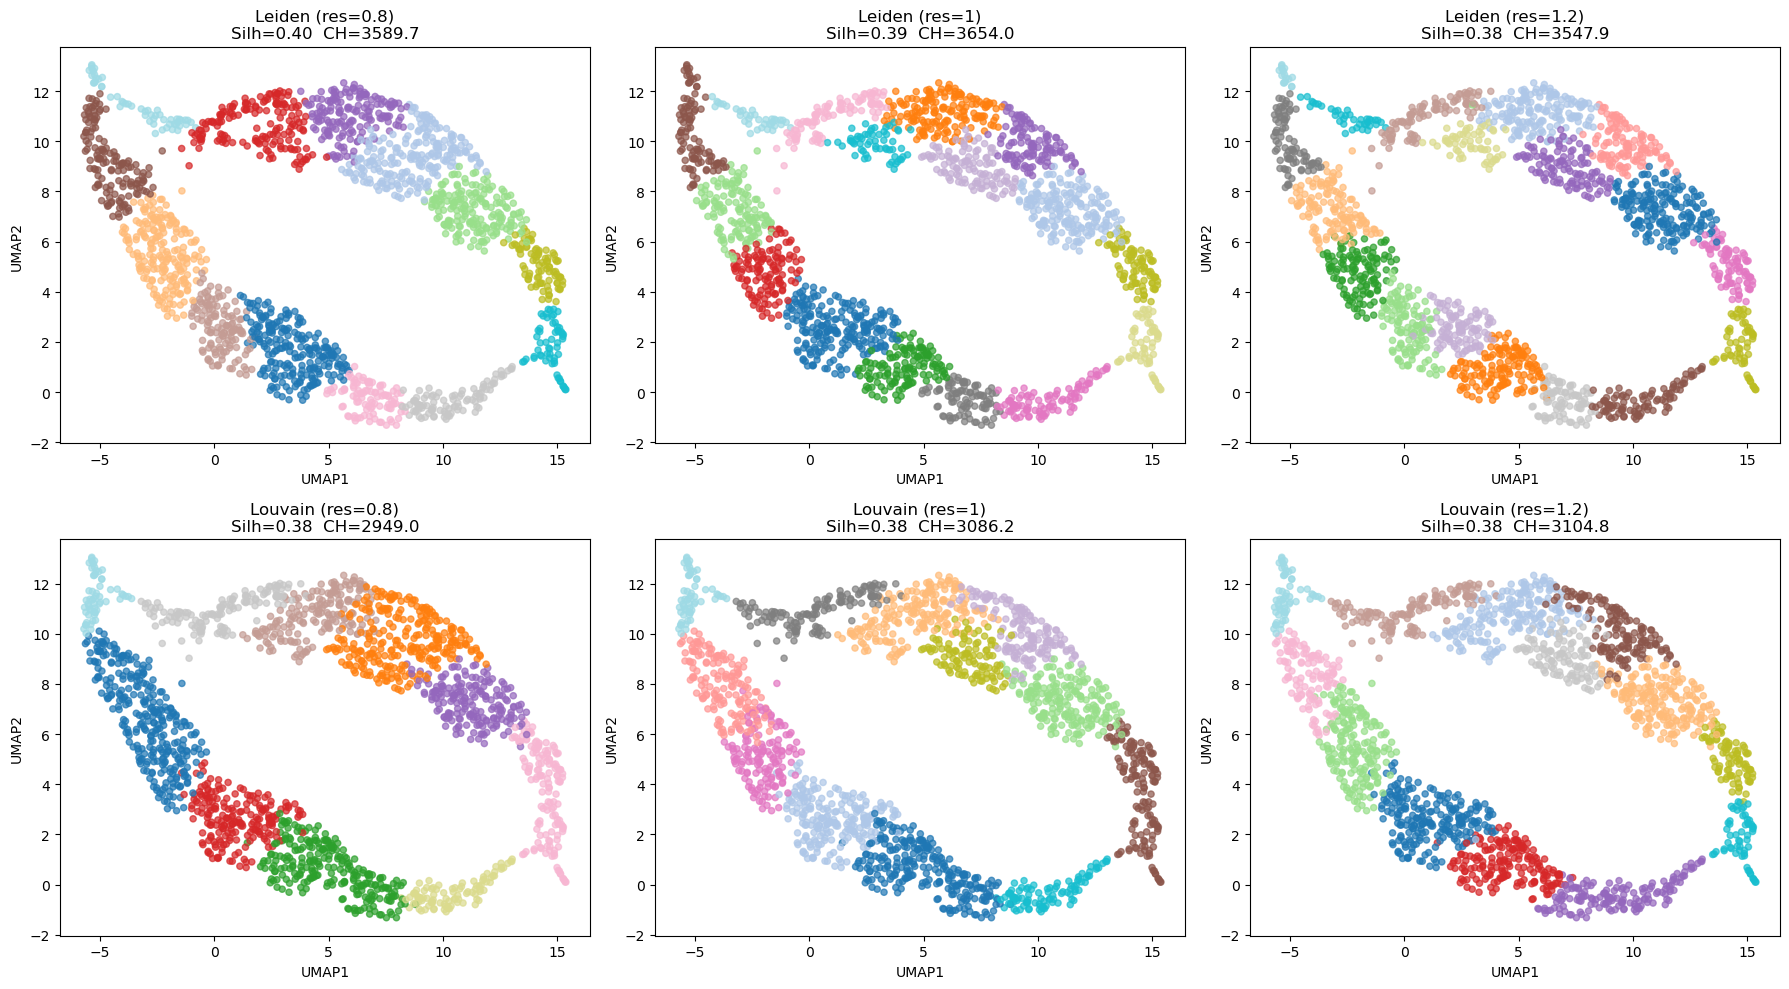

{'method': 'leiden', 'resolution': 0.8, 'n_clusters': 13, 'silhouette': 0.39767218, 'calinski_harabasz': 3589.727555364166}
{'method': 'leiden', 'resolution': 1, 'n_clusters': 16, 'silhouette': 0.38561532, 'calinski_harabasz': 3653.956059480163}
{'method': 'leiden', 'resolution': 1.2, 'n_clusters': 18, 'silhouette': 0.37700152, 'calinski_harabasz': 3547.9152476164872}
{'method': 'louvain', 'resolution': 0.8, 'n_clusters': 10, 'silhouette': 0.37911522, 'calinski_harabasz': 2949.030194021593}
{'method': 'louvain', 'resolution': 1, 'n_clusters': 12, 'silhouette': 0.37672058, 'calinski_harabasz': 3086.1654853481728}
{'method': 'louvain', 'resolution': 1.2, 'n_clusters': 13, 'silhouette': 0.37962666, 'calinski_harabasz': 3104.7947195914385}


In [170]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Re-define the Attention mechanism and VAE model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
    
    def forward(self, x):
        attn_output, _ = self.attention_layer(x, x, x)
        return attn_output

class VAEAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAEAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.attn = Attention(hidden_dim)
        
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)
        
        self.fc_p0 = nn.Linear(latent_dim, input_dim)
        
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        
        h = h.unsqueeze(1)
        h = self.attn(h)
        h = h.squeeze(1)
        
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        p0 = torch.sigmoid(self.fc_p0(mu))
        return self.decode(z), mu, log_var, p0

# Define the ZINB loss function for the VAE
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()
        else:
            x = torch.tensor(x, dtype=torch.float32)

    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()
        else:
            recon_x = torch.tensor(recon_x, dtype=torch.float32)

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - 
                         torch.lgamma(theta_tensor) + x * torch.log(torch.clamp(recon_x, min=1e-8) + 1e-8) + 
                         theta_tensor * torch.log(theta_tensor / (torch.clamp(recon_x, min=1e-8) + 1e-8)))

    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

# Function to train the model
def train_model_vae(model, X, optimizer, num_epochs, verbose=1):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}, NB Loss: {nb_loss.item():.4f}, "
                  f"Bernoulli Loss: {bernoulli_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}")

    return losses, nb_losses, bernoulli_losses, kl_losses

# Function to perform clustering and calculate metrics (Silhouette, Calinski, Pearson)
def clustering_and_metrics(X_data, mu):
    # Perform UMAP using sc.pp.neighbors and sc.tl.umap
    adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
    sc.tl.umap(adata_latent)
    umap_coords = adata_latent.obsm['X_umap']

    resolutions = [0.8, 1, 1.2]
    methods = ['leiden', 'louvain']
    clustering_results = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    i = 0

    for method in methods:
        for res in resolutions:
            key = f"{method}_r"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            n_clusters = len(set(labels))
            silh = silhouette_score(umap_coords, labels) if n_clusters > 1 else -1
            ch = calinski_harabasz_score(umap_coords, labels) if n_clusters > 1 else -1

            clustering_results.append({
                'method': method,
                'resolution': res,
                'n_clusters': n_clusters,
                'silhouette': silh,
                'calinski_harabasz': ch
            })

            axs[i].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
            axs[i].set_xlabel("UMAP1")
            axs[i].set_ylabel("UMAP2")
            i += 1

    plt.tight_layout()
    plt.show()

    return clustering_results

# Example data (use your own data here)
X_data = adata_filtered.X
# Best hyperparameters obtained from hyperparameter tuning
best_params = {'dropout_rate': 0.1, 'hidden_dim': 64, 'latent_dim': 32, 'learning_rate': 0.0001}

# Instantiate and train the model
vae_model = VAEAttention(input_dim=X_data.shape[1], hidden_dim=best_params['hidden_dim'], latent_dim=best_params['latent_dim'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(vae_model.parameters(), lr=best_params['learning_rate'])

num_epochs = 100
# Convert X_data to a torch.Tensor if it is not already
if not isinstance(X_data, torch.Tensor):
    X_data = torch.tensor(X_data, dtype=torch.float32)

vae_losses, vae_nb_losses, vae_bernoulli_losses, vae_kl_losses = train_model_vae(vae_model, X_data, optimizer, num_epochs, verbose=1)

# Calculate the UMAP embeddings
mu, log_var = vae_model.encode(X_data)
clustering_results = clustering_and_metrics(X_data, mu)

# Print the clustering results
for result in clustering_results:
    print(result)

# VAE + GAT

We calculate the expression Graph 

In [ ]:
X = adata_filtered.X
X_array = X.toarray() if hasattr(X, 'toarray') else X  

# CReate the graph using k-NN
k = 10
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_array)
distances, indices = nbrs.kneighbors(X_array)


In [ ]:
edges = []
n_cells = X_array.shape[0]

for i in range(n_cells):
    for j in indices[i][1:]:  #not self loop
        edges.append([i, j])
        edges.append([j, i])  # driven graph

edge_index_cells = torch.tensor(edges, dtype=torch.long).T  # shape (2, num_edges)

print(f" Número de aristas: {edge_index_cells.shape[1]}")
print(f" Número de células (nodos): {n_cells}")

🔗 Número de aristas: 36460
🧬 Número de células (nodos): 1823


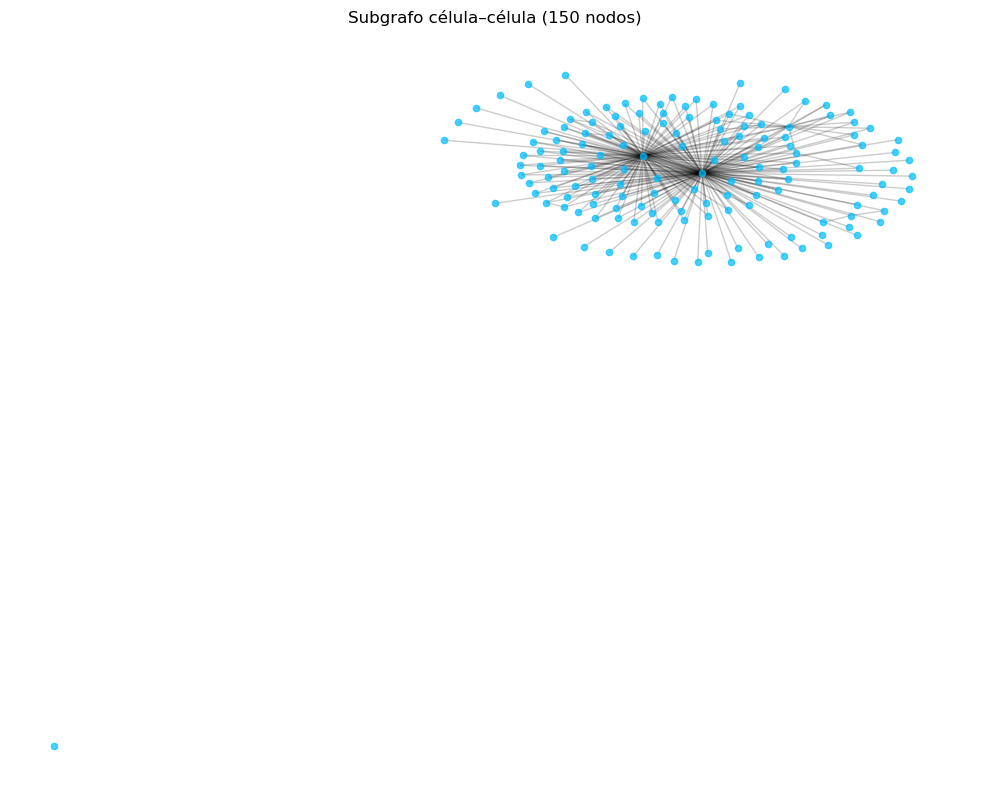

In [ ]:
G = nx.Graph()
edges = edge_index_cells.T.tolist()
G.add_edges_from(edges)

# subgraph random sampling
sample_nodes = random.sample(list(G.nodes), 150)
subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=20, node_color='deepskyblue', alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
plt.title("Subgraph cell-cell (150 nodes)")
plt.axis('off')
plt.tight_layout()
plt.show()

## Hyperparametrization of VAE + GAT

In [ ]:
n_genes = adata_filtered.shape[1]  # columns
input_dim = n_genes
hidden_dim = 256
latent_dim = 64 #latent dimension
learning_rate = 1e-3
num_epochs = 200
X_data = adata_filtered.X  
X = torch.FloatTensor(X_data)
X_tensor = torch.FloatTensor(adata_filtered.X)


In [ ]:
class VAE_GAT_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1, num_heads=2):
        super(VAE_GAT_Cell, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        p0 = torch.sigmoid(self.fc_p0(h))
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        mu, log_var, p0 = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, p0

In [ ]:
# ===============================================================
# Función de pérdida ZINB
# ===============================================================
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    if x.is_sparse:
        x = x.to_dense()
    if recon_x.is_sparse:
        recon_x = recon_x.to_dense()
    x = torch.abs(x)
    recon_x = torch.abs(recon_x)
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) +
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))
    p0 = p0.expand(x.size(0), x.size(1))
    p0 = torch.clamp(p0, min=1e-5, max=1 - 1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))
    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [ ]:
# ===============================================================
# Fijar semilla para reproducibilidad
# ===============================================================
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:


# ===============================================================
# Grid search de hiperparámetros
# ===============================================================
latent_dims = [32, 64]
hidden_dims = [128, 256]
dropout_rates = [0.1, 0.3]
betas = [0.1, 1.0]
num_epochs = 200

param_grid = list(product(latent_dims, hidden_dims, dropout_rates, betas))
results = []

# 🔁 Ejecutar entrenamiento para cada combinación
for latent_dim, hidden_dim, dropout_rate, beta in tqdm(param_grid, desc="Grid Search"):
    set_seed(42)

    model = VAE_GAT_Cell(input_dim=X_tensor.shape[1],
                         hidden_dim=hidden_dim,
                         latent_dim=latent_dim,
                         dropout_rate=dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_x, X_tensor, mu, log_var, p0, beta=beta)
        loss.backward()
        optimizer.step()

    # Evaluación
    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
        mu_np = mu.numpy()
        pearson_corr = np.corrcoef(X_tensor.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
        kl_div = kl_loss.item()

        umap_embeds = umap.UMAP(n_components=2, random_state=42).fit_transform(mu_np)
        labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(umap_embeds)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        silhouette = silhouette_score(umap_embeds, labels) if n_clusters > 1 else -1
        calinski = calinski_harabasz_score(umap_embeds, labels) if n_clusters > 1 else -1

    results.append({
        'latent_dim': latent_dim,
        'hidden_dim': hidden_dim,
        'dropout_rate': dropout_rate,
        'beta': beta,
        'pearson_corr': pearson_corr,
        'silhouette': silhouette,
        'calinski': calinski,
        'kl_divergence': kl_div
    })

# Convertir resultados en DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["silhouette", "calinski", "pearson_corr"], ascending=False)
print(results_df.head(10))

Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:   6%|▋         | 1/16 [02:07<31:56, 127.74s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  12%|█▎        | 2/16 [04:08<28:54, 123.91s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  19%|█▉        | 3/16 [06:11<26:40, 123.08s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  25%|██▌       | 4/16 [0

    latent_dim  hidden_dim  dropout_rate  beta  pearson_corr  silhouette  \
14          64         256           0.3   0.1      0.000148    0.962478   
15          64         256           0.3   1.0      0.000132    0.948041   
4           32         256           0.1   0.1     -0.000111    0.867644   
11          64         128           0.3   1.0     -0.000403    0.828804   
2           32         128           0.3   0.1      0.000049    0.752601   
5           32         256           0.1   1.0     -0.000075    0.547024   
12          64         256           0.1   0.1     -0.001432    0.385074   
1           32         128           0.1   1.0     -0.001508    0.363834   
7           32         256           0.3   1.0     -0.001574    0.198862   
13          64         256           0.1   1.0      0.000087    0.195343   

         calinski  kl_divergence  
14  417077.597154   1.591323e+07  
15  132579.796732   1.361510e+06  
4     4403.134182   2.890908e+06  
11   15216.441208   4.1

In [226]:
results_df

latent_dim  hidden_dim  dropout_rate  beta  pearson_corr  silhouette  \
14          64         256           0.3   0.1      0.000148    0.962478   
15          64         256           0.3   1.0      0.000132    0.948041   
4           32         256           0.1   0.1     -0.000111    0.867644   
11          64         128           0.3   1.0     -0.000403    0.828804   
2           32         128           0.3   0.1      0.000049    0.752601   
5           32         256           0.1   1.0     -0.000075    0.547024   
12          64         256           0.1   0.1     -0.001432    0.385074   
1           32         128           0.1   1.0     -0.001508    0.363834   
7           32         256           0.3   1.0     -0.001574    0.198862   
13          64         256           0.1   1.0      0.000087    0.195343   
8           64         128           0.1   0.1      0.001138    0.088228   
9           64         128           0.1   1.0     -0.000162    0.034470   
3           32         128           0.3   1.0     -0.000410    0.015829   
6           32         256           0.3   0.1      0.000628    0.006562   
10          64         128           0.3   0.1     -0.001180   -0.006513   
0           32         128           0.1   0.1      0.003605   -0.314394   

         calinski  kl_divergence  
14  417077.597154   1.591323e+07  
15  132579.796732   1.361510e+06  
4     4403.134182   2.890908e+06  
11   15216.441208   4.112711e+05  
2    17909.392912   6.680801e+05  
5    25669.620124   1.265968e+06  
12    1874.009473   1.823830e+06  
1      696.617386   6.159973e+04  
7      743.364529   2.634128e+05  
13     938.828025   1.018689e+06  
8      636.894494   3.178297e+05  
9      760.341408   3.081613e+05  
3      960.967203   1.860802e+05  
6      500.019505   2.328310e+06  
10     296.436004   1.937551e+05  
0       70.165057   1.829032e+05

## Model VAE + GAT

In [228]:
# ========================= MODELO =========================
class VAE_GAT_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout_rate=0.3, num_heads=2):
        super(VAE_GAT_Cell, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        p0 = torch.sigmoid(self.fc_p0(h))
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        mu, log_var, p0 = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, p0


In [229]:
# ======================= ZINB LOSS ========================
def zinb_loss(recon_x, x, mu, log_var, p0, beta=0.1, theta=1.0):
    x = x.to_dense() if x.is_sparse else x
    recon_x = recon_x.to_dense() if recon_x.is_sparse else recon_x
    x = torch.abs(x)
    recon_x = torch.abs(recon_x)
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)

    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) +
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))
    p0 = torch.clamp(p0.expand(x.size(0), x.size(1)), min=1e-5, max=1 - 1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))
    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [230]:
# ===================== ENTRENAMIENTO ======================
model = VAE_GAT_Cell(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
    loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_x, X_tensor, mu, log_var, p0, beta=0.1)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    nb_losses.append(nb_loss.item())
    bernoulli_losses.append(bernoulli_loss.item())
    kl_losses.append(kl_loss.item())

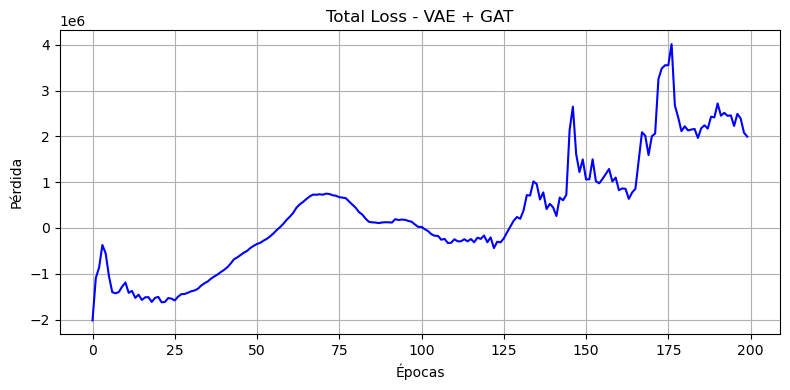

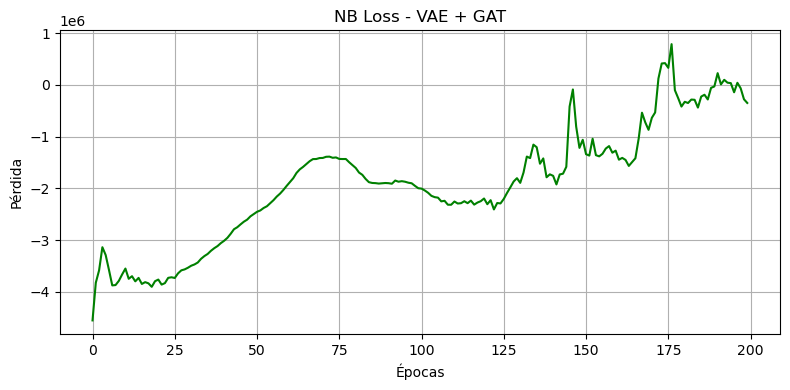

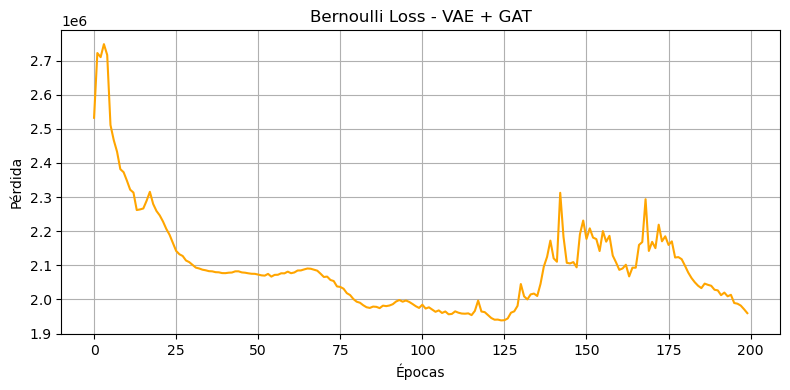

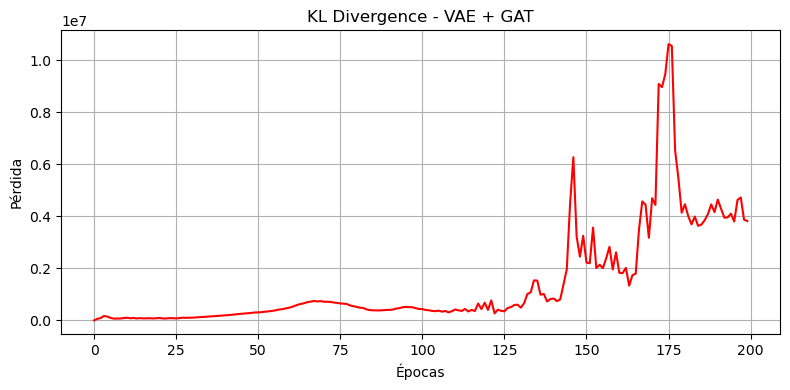

In [236]:
# Total Loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Total Loss', color='blue')
plt.title("Total Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# NB Loss
plt.figure(figsize=(8, 4))
plt.plot(nb_losses, label='NB Loss', color='green')
plt.title("NB Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bernoulli Loss
plt.figure(figsize=(8, 4))
plt.plot(bernoulli_losses, label='Bernoulli Loss', color='orange')
plt.title("Bernoulli Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# KL Loss
plt.figure(figsize=(8, 4))
plt.plot(kl_losses, label='KL Loss', color='red')
plt.title("KL Divergence - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()


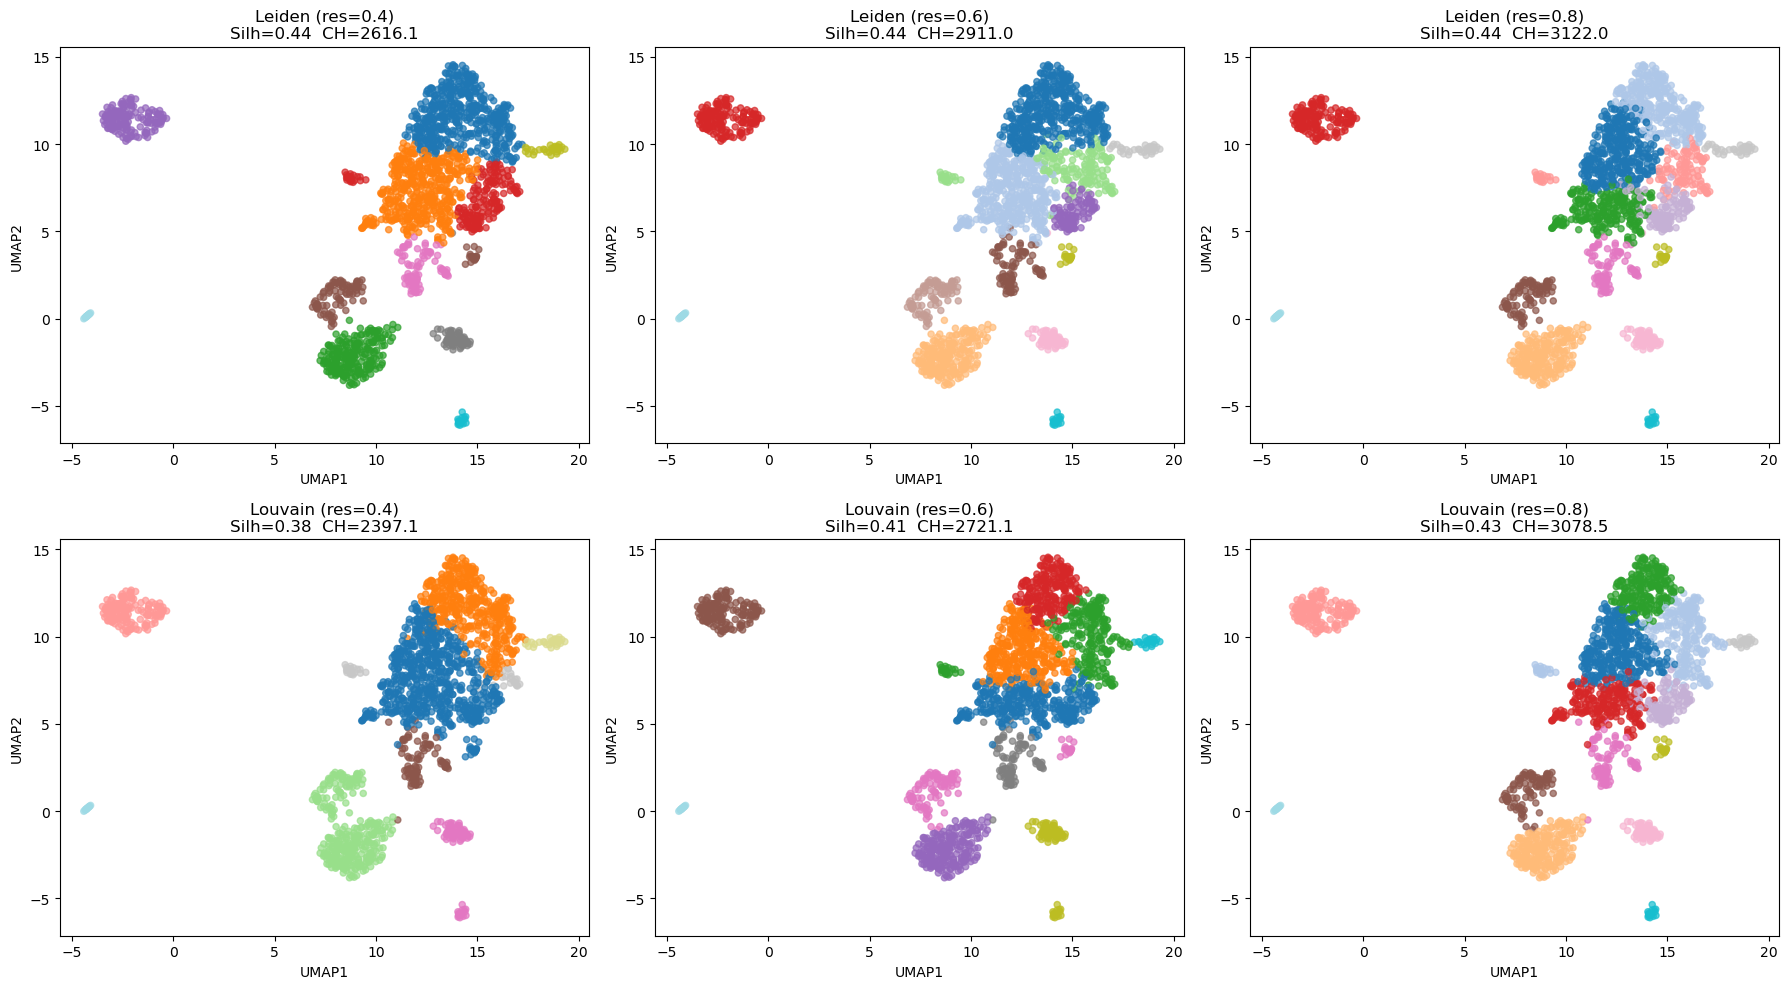

In [232]:
# ===================== CLUSTERING Leiden y Louvain =====================
adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
sc.tl.umap(adata_latent)
umap_coords = adata_latent.obsm['X_umap']

resolutions = [0.4, 0.6, 0.8]
methods = ['leiden', 'louvain']
clustering_results = []

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
i = 0

for method in methods:
    for res in resolutions:
        key = f"{method}_r"
        if method == 'leiden':
            sc.tl.leiden(adata_latent, resolution=res, key_added=key)
        else:
            sc.tl.louvain(adata_latent, resolution=res, key_added=key)

        labels = adata_latent.obs[key].astype(int).values
        n_clusters = len(set(labels))
        silh = silhouette_score(umap_coords, labels) if n_clusters > 1 else -1
        ch = calinski_harabasz_score(umap_coords, labels) if n_clusters > 1 else -1

        clustering_results.append({
            'method': method,
            'resolution': res,
            'n_clusters': n_clusters,
            'silhouette': silh,
            'calinski_harabasz': ch
        })

        axs[i].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
        axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
        axs[i].set_xlabel("UMAP1")
        axs[i].set_ylabel("UMAP2")
        i += 1

plt.tight_layout()
plt.show()

In [234]:
# ==================== MÉTRICAS FINALES ====================
recon_np = recon_x.detach().numpy()
pearson_corr = np.corrcoef(X_tensor.numpy().flatten(), recon_np.flatten())[0, 1]
kl_div = kl_loss.item()

metrics_df = pd.DataFrame({
    'Metric': ['Pearson Corr', 'Silhouette Score', 'Calinski-Harabasz', 'KL Divergence'],
    'VAE + GAT': [pearson_corr, silh, ch, kl_div]
})

In [235]:
pd.set_option('display.float_format', '{:.6f}'.format)
metrics_df

Metric      VAE + GAT
0       Pearson Corr       0.000916
1   Silhouette Score       0.429634
2  Calinski-Harabasz    3078.546958
3      KL Divergence 3822839.000000